In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [ ]:
!ls

drive  sample_data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

image_dir = "/content/drive/MyDrive/datasets/face-mask-detection/images"
annotation_dir = "/content/drive/MyDrive/datasets/face-mask-detection/annotations"

imgs = sorted(os.listdir(image_dir))
print(f"Found {len(imgs)} images")
print(imgs[:5])

Found 853 images
['maksssksksss0.png', 'maksssksksss1.png', 'maksssksksss10.png', 'maksssksksss100.png', 'maksssksksss101.png']


In [ ]:
def generate_box(obj):

    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(image_id, file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)


        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id

        return target

In [ ]:
image_dir = "/content/drive/MyDrive/datasets/face-mask-detection/images"

imgs = sorted(os.listdir(image_dir))
print(f"Found {len(imgs)} images")
print("Sample images:", imgs[:5])

Found 853 images
Sample images: ['maksssksksss0.png', 'maksssksksss1.png', 'maksssksksss10.png', 'maksssksksss100.png', 'maksssksksss101.png']


In [ ]:
labels = list(sorted(os.listdir("/content/drive/MyDrive/datasets/face-mask-detection/annotations")))

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset

class MaskDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.transforms = transforms

        # Set image and annotation folders
        self.imgs_dir = os.path.join(root, "images")
        self.labels_dir = os.path.join(root, "annotations")

        # Get list of image files (assumes images are .png)
        self.imgs = sorted([f for f in os.listdir(self.imgs_dir) if f.endswith(".png")])

    def __getitem__(self, idx):
        # Get file names
        file_image = self.imgs[idx]
        file_label = file_image.replace('.png', '.xml')

        # Construct full paths
        img_path = os.path.join(self.imgs_dir, file_image)
        label_path = os.path.join(self.labels_dir, file_label)

        # Load image
        img = Image.open(img_path).convert("RGB")

        # Generate label
        target = generate_target(idx, label_path)

        # Apply transforms
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
from torchvision import transforms

In [ ]:
data_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(
    root="/content/drive/MyDrive/datasets/face-mask-detection",
    transforms=data_transform
)

In [ ]:
import torch

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
model = get_model_instance_segmentation(3)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 80.4MB/s]


In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

# Transform
data_transform = transforms.Compose([
    transforms.ToTensor()
])

# Dataset root path in Google Drive
dataset_root = "/content/drive/MyDrive/datasets/face-mask-detection"

# Dataset
dataset = MaskDataset(root=dataset_root, transforms=data_transform)

# Collate function
def collate_fn(batch):
    return tuple(zip(*batch))

# DataLoader
data_loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

for imgs, annotations in data_loader:
    imgs = [img.to(device) for img in imgs]
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[115.,  47., 157.,  87.],
        [186.,  90., 231., 130.],
        [307.,  42., 347.,  84.],
        [ 69.,  64.,  89.,  81.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 0], device='cuda:0'), 'image_id': tensor([427], device='cuda:0')}, {'boxes': tensor([[ 82., 139., 187., 270.]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'image_id': tensor([255], device='cuda:0')}, {'boxes': tensor([[ 93.,  44., 150., 100.]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'image_id': tensor([706], device='cuda:0')}, {'boxes': tensor([[ 37.,  50.,  63.,  78.],
        [ 63.,  79.,  88., 101.],
        [ 64., 112.,  91., 141.],
        [ 88.,  44., 112.,  72.],
        [120.,  99., 150., 133.],
        [161., 102., 197., 143.],
        [206.,  51., 228.,  79.],
        [227., 124., 260., 157.],
        [236.,  91., 262., 119.],
        [338., 116., 370., 155.],
        [374.,  63., 396.,  88.],
        [267.,  22., 289.,  44.],
        [344.,  35., 361.,

In [ ]:
from tqdm import tqdm  # optional: nice progress bar

num_epochs = 25
model.to(device)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    print(f"\n🟢 Epoch {epoch + 1}/{num_epochs}")
    print("-" * 40)

    # Use tqdm for progress bar
    for i, (imgs, annotations) in enumerate(tqdm(data_loader), 1):
        imgs = [img.to(device) for img in imgs]
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

        print(f"🧱 Batch {i}/{len_dataloader} - Loss: {losses.item():.4f}")

    avg_loss = epoch_loss / len_dataloader
    print(f"\n✅ Epoch {epoch + 1} Completed — Avg Loss: {avg_loss:.4f}")


🟢 Epoch 1/25
----------------------------------------


  0%|          | 1/214 [00:01<06:39,  1.88s/it]

🧱 Batch 1/214 - Loss: 0.1132


  1%|          | 2/214 [00:03<06:09,  1.74s/it]

🧱 Batch 2/214 - Loss: 0.1416


  1%|▏         | 3/214 [00:05<06:11,  1.76s/it]

🧱 Batch 3/214 - Loss: 0.0351


  2%|▏         | 4/214 [00:07<06:06,  1.75s/it]

🧱 Batch 4/214 - Loss: 0.1484


  2%|▏         | 5/214 [00:09<06:28,  1.86s/it]

🧱 Batch 5/214 - Loss: 0.0208


  3%|▎         | 6/214 [00:10<05:52,  1.70s/it]

🧱 Batch 6/214 - Loss: 0.0878


  3%|▎         | 7/214 [00:12<05:46,  1.67s/it]

🧱 Batch 7/214 - Loss: 0.1064


  4%|▎         | 8/214 [00:13<05:58,  1.74s/it]

🧱 Batch 8/214 - Loss: 0.0193


  4%|▍         | 9/214 [00:15<05:58,  1.75s/it]

🧱 Batch 9/214 - Loss: 0.0805


  5%|▍         | 10/214 [00:17<05:46,  1.70s/it]

🧱 Batch 10/214 - Loss: 0.0671


  5%|▌         | 11/214 [00:18<05:39,  1.67s/it]

🧱 Batch 11/214 - Loss: 0.0774


  6%|▌         | 12/214 [00:20<05:31,  1.64s/it]

🧱 Batch 12/214 - Loss: 0.0784


  6%|▌         | 13/214 [00:22<05:30,  1.64s/it]

🧱 Batch 13/214 - Loss: 0.1494


  7%|▋         | 14/214 [00:23<05:06,  1.53s/it]

🧱 Batch 14/214 - Loss: 0.0920


  7%|▋         | 15/214 [00:24<04:49,  1.45s/it]

🧱 Batch 15/214 - Loss: 0.1327


  7%|▋         | 16/214 [00:26<04:42,  1.43s/it]

🧱 Batch 16/214 - Loss: 0.0592


  8%|▊         | 17/214 [00:27<04:31,  1.38s/it]

🧱 Batch 17/214 - Loss: 0.1724


  8%|▊         | 18/214 [00:29<04:53,  1.50s/it]

🧱 Batch 18/214 - Loss: 0.0558


  9%|▉         | 19/214 [00:30<04:38,  1.43s/it]

🧱 Batch 19/214 - Loss: 0.1539


  9%|▉         | 20/214 [00:31<04:46,  1.48s/it]

🧱 Batch 20/214 - Loss: 0.0117


 10%|▉         | 21/214 [00:33<05:04,  1.58s/it]

🧱 Batch 21/214 - Loss: 0.0769


 10%|█         | 22/214 [00:35<05:07,  1.60s/it]

🧱 Batch 22/214 - Loss: 0.1375


 11%|█         | 23/214 [00:37<05:07,  1.61s/it]

🧱 Batch 23/214 - Loss: 0.1123


 11%|█         | 24/214 [00:38<04:45,  1.50s/it]

🧱 Batch 24/214 - Loss: 0.1405


 12%|█▏        | 25/214 [00:39<04:49,  1.53s/it]

🧱 Batch 25/214 - Loss: 0.0684


 12%|█▏        | 26/214 [00:41<04:44,  1.51s/it]

🧱 Batch 26/214 - Loss: 0.0235


 13%|█▎        | 27/214 [00:42<04:40,  1.50s/it]

🧱 Batch 27/214 - Loss: 0.1040


 13%|█▎        | 28/214 [00:44<04:44,  1.53s/it]

🧱 Batch 28/214 - Loss: 0.0927


 14%|█▎        | 29/214 [00:46<04:47,  1.55s/it]

🧱 Batch 29/214 - Loss: 0.1253


 14%|█▍        | 30/214 [00:47<04:48,  1.57s/it]

🧱 Batch 30/214 - Loss: 0.0871


 14%|█▍        | 31/214 [00:49<04:51,  1.59s/it]

🧱 Batch 31/214 - Loss: 0.0705


 15%|█▍        | 32/214 [00:50<04:48,  1.59s/it]

🧱 Batch 32/214 - Loss: 0.0340


 15%|█▌        | 33/214 [00:52<04:47,  1.59s/it]

🧱 Batch 33/214 - Loss: 0.0870


 16%|█▌        | 34/214 [00:53<04:39,  1.55s/it]

🧱 Batch 34/214 - Loss: 0.1105


 16%|█▋        | 35/214 [00:55<04:32,  1.52s/it]

🧱 Batch 35/214 - Loss: 0.0331


 17%|█▋        | 36/214 [00:57<04:43,  1.59s/it]

🧱 Batch 36/214 - Loss: 0.1525


 17%|█▋        | 37/214 [00:58<04:21,  1.48s/it]

🧱 Batch 37/214 - Loss: 0.1163


 18%|█▊        | 38/214 [00:59<04:10,  1.42s/it]

🧱 Batch 38/214 - Loss: 0.1229


 18%|█▊        | 39/214 [01:00<03:59,  1.37s/it]

🧱 Batch 39/214 - Loss: 0.0978


 19%|█▊        | 40/214 [01:02<03:52,  1.34s/it]

🧱 Batch 40/214 - Loss: 0.0995


 19%|█▉        | 41/214 [01:03<03:46,  1.31s/it]

🧱 Batch 41/214 - Loss: 0.0641


 20%|█▉        | 42/214 [01:04<03:42,  1.29s/it]

🧱 Batch 42/214 - Loss: 0.1568


 20%|██        | 43/214 [01:05<03:39,  1.29s/it]

🧱 Batch 43/214 - Loss: 0.1488


 21%|██        | 44/214 [01:07<03:30,  1.24s/it]

🧱 Batch 44/214 - Loss: 0.0194


 21%|██        | 45/214 [01:08<03:39,  1.30s/it]

🧱 Batch 45/214 - Loss: 0.0508


 21%|██▏       | 46/214 [01:10<04:00,  1.43s/it]

🧱 Batch 46/214 - Loss: 0.0535


 22%|██▏       | 47/214 [01:11<04:06,  1.48s/it]

🧱 Batch 47/214 - Loss: 0.0445


 22%|██▏       | 48/214 [01:13<03:50,  1.39s/it]

🧱 Batch 48/214 - Loss: 0.1422


 23%|██▎       | 49/214 [01:14<04:00,  1.46s/it]

🧱 Batch 49/214 - Loss: 0.1260


 23%|██▎       | 50/214 [01:16<04:05,  1.50s/it]

🧱 Batch 50/214 - Loss: 0.1304


 24%|██▍       | 51/214 [01:17<03:46,  1.39s/it]

🧱 Batch 51/214 - Loss: 0.1306


 24%|██▍       | 52/214 [01:18<03:54,  1.45s/it]

🧱 Batch 52/214 - Loss: 0.1000


 25%|██▍       | 53/214 [01:20<03:59,  1.49s/it]

🧱 Batch 53/214 - Loss: 0.0424


 25%|██▌       | 54/214 [01:22<04:02,  1.51s/it]

🧱 Batch 54/214 - Loss: 0.1249


 26%|██▌       | 55/214 [01:23<03:37,  1.37s/it]

🧱 Batch 55/214 - Loss: 0.0245


 26%|██▌       | 56/214 [01:24<03:31,  1.34s/it]

🧱 Batch 56/214 - Loss: 0.1358


 27%|██▋       | 57/214 [01:25<03:41,  1.41s/it]

🧱 Batch 57/214 - Loss: 0.0866


 27%|██▋       | 58/214 [01:27<03:51,  1.48s/it]

🧱 Batch 58/214 - Loss: 0.0326


 28%|██▊       | 59/214 [01:29<04:02,  1.57s/it]

🧱 Batch 59/214 - Loss: 0.0857


 28%|██▊       | 60/214 [01:30<04:02,  1.57s/it]

🧱 Batch 60/214 - Loss: 0.1090


 29%|██▊       | 61/214 [01:32<04:02,  1.58s/it]

🧱 Batch 61/214 - Loss: 0.0880


 29%|██▉       | 62/214 [01:33<03:45,  1.49s/it]

🧱 Batch 62/214 - Loss: 0.1506


 29%|██▉       | 63/214 [01:35<03:43,  1.48s/it]

🧱 Batch 63/214 - Loss: 0.1377


 30%|██▉       | 64/214 [01:36<03:34,  1.43s/it]

🧱 Batch 64/214 - Loss: 0.0268


 30%|███       | 65/214 [01:38<03:49,  1.54s/it]

🧱 Batch 65/214 - Loss: 0.0803


 31%|███       | 66/214 [01:39<03:31,  1.43s/it]

🧱 Batch 66/214 - Loss: 0.0460


 31%|███▏      | 67/214 [01:41<03:33,  1.45s/it]

🧱 Batch 67/214 - Loss: 0.0490


 32%|███▏      | 68/214 [01:42<03:37,  1.49s/it]

🧱 Batch 68/214 - Loss: 0.0740


 32%|███▏      | 69/214 [01:44<03:40,  1.52s/it]

🧱 Batch 69/214 - Loss: 0.0712


 33%|███▎      | 70/214 [01:45<03:43,  1.55s/it]

🧱 Batch 70/214 - Loss: 0.0714


 33%|███▎      | 71/214 [01:47<03:33,  1.49s/it]

🧱 Batch 71/214 - Loss: 0.1884


 34%|███▎      | 72/214 [01:48<03:21,  1.42s/it]

🧱 Batch 72/214 - Loss: 0.0873


 34%|███▍      | 73/214 [01:50<03:33,  1.52s/it]

🧱 Batch 73/214 - Loss: 0.0656


 35%|███▍      | 74/214 [01:51<03:37,  1.56s/it]

🧱 Batch 74/214 - Loss: 0.1802


 35%|███▌      | 75/214 [01:53<03:38,  1.57s/it]

🧱 Batch 75/214 - Loss: 0.0488


 36%|███▌      | 76/214 [01:55<03:35,  1.56s/it]

🧱 Batch 76/214 - Loss: 0.1297


 36%|███▌      | 77/214 [01:56<03:48,  1.66s/it]

🧱 Batch 77/214 - Loss: 0.1439


 36%|███▋      | 78/214 [01:58<03:45,  1.66s/it]

🧱 Batch 78/214 - Loss: 0.0756


 37%|███▋      | 79/214 [01:59<03:28,  1.54s/it]

🧱 Batch 79/214 - Loss: 0.1561


 37%|███▋      | 80/214 [02:01<03:36,  1.62s/it]

🧱 Batch 80/214 - Loss: 0.0367


 38%|███▊      | 81/214 [02:03<03:33,  1.61s/it]

🧱 Batch 81/214 - Loss: 0.0770


 38%|███▊      | 82/214 [02:04<03:28,  1.58s/it]

🧱 Batch 82/214 - Loss: 0.1249


 39%|███▉      | 83/214 [02:06<03:25,  1.57s/it]

🧱 Batch 83/214 - Loss: 0.1297


 39%|███▉      | 84/214 [02:07<03:11,  1.47s/it]

🧱 Batch 84/214 - Loss: 0.1301


 40%|███▉      | 85/214 [02:09<03:15,  1.52s/it]

🧱 Batch 85/214 - Loss: 0.0512


 40%|████      | 86/214 [02:10<02:55,  1.37s/it]

🧱 Batch 86/214 - Loss: 0.0178


 41%|████      | 87/214 [02:11<02:46,  1.31s/it]

🧱 Batch 87/214 - Loss: 0.0351


 41%|████      | 88/214 [02:12<02:43,  1.30s/it]

🧱 Batch 88/214 - Loss: 0.1307


 42%|████▏     | 89/214 [02:14<02:48,  1.35s/it]

🧱 Batch 89/214 - Loss: 0.0689


 42%|████▏     | 90/214 [02:15<02:55,  1.42s/it]

🧱 Batch 90/214 - Loss: 0.0272


 43%|████▎     | 91/214 [02:16<02:49,  1.38s/it]

🧱 Batch 91/214 - Loss: 0.1030


 43%|████▎     | 92/214 [02:18<03:01,  1.49s/it]

🧱 Batch 92/214 - Loss: 0.0246


 43%|████▎     | 93/214 [02:20<03:04,  1.52s/it]

🧱 Batch 93/214 - Loss: 0.0525


 44%|████▍     | 94/214 [02:21<02:53,  1.44s/it]

🧱 Batch 94/214 - Loss: 0.1445


 44%|████▍     | 95/214 [02:22<02:45,  1.39s/it]

🧱 Batch 95/214 - Loss: 0.1797


 45%|████▍     | 96/214 [02:24<02:59,  1.52s/it]

🧱 Batch 96/214 - Loss: 0.0738


 45%|████▌     | 97/214 [02:26<03:05,  1.58s/it]

🧱 Batch 97/214 - Loss: 0.0271


 46%|████▌     | 98/214 [02:27<03:03,  1.59s/it]

🧱 Batch 98/214 - Loss: 0.0619


 46%|████▋     | 99/214 [02:29<03:02,  1.59s/it]

🧱 Batch 99/214 - Loss: 0.1471


 47%|████▋     | 100/214 [02:31<03:03,  1.61s/it]

🧱 Batch 100/214 - Loss: 0.1524


 47%|████▋     | 101/214 [02:32<03:01,  1.61s/it]

🧱 Batch 101/214 - Loss: 0.1701


 48%|████▊     | 102/214 [02:34<03:01,  1.62s/it]

🧱 Batch 102/214 - Loss: 0.1061


 48%|████▊     | 103/214 [02:35<02:54,  1.57s/it]

🧱 Batch 103/214 - Loss: 0.1300


 49%|████▊     | 104/214 [02:37<02:53,  1.57s/it]

🧱 Batch 104/214 - Loss: 0.0553


 49%|████▉     | 105/214 [02:38<02:40,  1.48s/it]

🧱 Batch 105/214 - Loss: 0.1121


 50%|████▉     | 106/214 [02:40<02:47,  1.55s/it]

🧱 Batch 106/214 - Loss: 0.0702


 50%|█████     | 107/214 [02:41<02:42,  1.52s/it]

🧱 Batch 107/214 - Loss: 0.0817


 50%|█████     | 108/214 [02:43<02:44,  1.55s/it]

🧱 Batch 108/214 - Loss: 0.0706


 51%|█████     | 109/214 [02:45<02:41,  1.54s/it]

🧱 Batch 109/214 - Loss: 0.0494


 51%|█████▏    | 110/214 [02:46<02:35,  1.49s/it]

🧱 Batch 110/214 - Loss: 0.0747


 52%|█████▏    | 111/214 [02:47<02:34,  1.50s/it]

🧱 Batch 111/214 - Loss: 0.1136


 52%|█████▏    | 112/214 [02:49<02:35,  1.53s/it]

🧱 Batch 112/214 - Loss: 0.0405


 53%|█████▎    | 113/214 [02:51<02:40,  1.59s/it]

🧱 Batch 113/214 - Loss: 0.0507


 53%|█████▎    | 114/214 [02:52<02:40,  1.60s/it]

🧱 Batch 114/214 - Loss: 0.2114


 54%|█████▎    | 115/214 [02:54<02:34,  1.56s/it]

🧱 Batch 115/214 - Loss: 0.0476


 54%|█████▍    | 116/214 [02:55<02:34,  1.57s/it]

🧱 Batch 116/214 - Loss: 0.1157


 55%|█████▍    | 117/214 [02:57<02:33,  1.59s/it]

🧱 Batch 117/214 - Loss: 0.0946


 55%|█████▌    | 118/214 [02:59<02:34,  1.60s/it]

🧱 Batch 118/214 - Loss: 0.1592


 56%|█████▌    | 119/214 [03:00<02:32,  1.60s/it]

🧱 Batch 119/214 - Loss: 0.0294


 56%|█████▌    | 120/214 [03:02<02:21,  1.50s/it]

🧱 Batch 120/214 - Loss: 0.1437


 57%|█████▋    | 121/214 [03:03<02:14,  1.45s/it]

🧱 Batch 121/214 - Loss: 0.0227


 57%|█████▋    | 122/214 [03:05<02:16,  1.49s/it]

🧱 Batch 122/214 - Loss: 0.0334


 57%|█████▋    | 123/214 [03:06<02:15,  1.49s/it]

🧱 Batch 123/214 - Loss: 0.1540


 58%|█████▊    | 124/214 [03:08<02:16,  1.52s/it]

🧱 Batch 124/214 - Loss: 0.0871


 58%|█████▊    | 125/214 [03:09<02:13,  1.50s/it]

🧱 Batch 125/214 - Loss: 0.1111


 59%|█████▉    | 126/214 [03:11<02:15,  1.54s/it]

🧱 Batch 126/214 - Loss: 0.2372


 59%|█████▉    | 127/214 [03:12<02:16,  1.56s/it]

🧱 Batch 127/214 - Loss: 0.0196


 60%|█████▉    | 128/214 [03:14<02:14,  1.57s/it]

🧱 Batch 128/214 - Loss: 0.0846


 60%|██████    | 129/214 [03:15<02:05,  1.48s/it]

🧱 Batch 129/214 - Loss: 0.1996


 61%|██████    | 130/214 [03:16<01:59,  1.42s/it]

🧱 Batch 130/214 - Loss: 0.2093


 61%|██████    | 131/214 [03:18<01:59,  1.44s/it]

🧱 Batch 131/214 - Loss: 0.0716


 62%|██████▏   | 132/214 [03:20<02:02,  1.49s/it]

🧱 Batch 132/214 - Loss: 0.1428


 62%|██████▏   | 133/214 [03:21<02:03,  1.53s/it]

🧱 Batch 133/214 - Loss: 0.2237


 63%|██████▎   | 134/214 [03:23<02:04,  1.56s/it]

🧱 Batch 134/214 - Loss: 0.1489


 63%|██████▎   | 135/214 [03:24<02:06,  1.60s/it]

🧱 Batch 135/214 - Loss: 0.2014


 64%|██████▎   | 136/214 [03:26<02:02,  1.57s/it]

🧱 Batch 136/214 - Loss: 0.0918


 64%|██████▍   | 137/214 [03:28<02:01,  1.58s/it]

🧱 Batch 137/214 - Loss: 0.0839


 64%|██████▍   | 138/214 [03:29<02:04,  1.64s/it]

🧱 Batch 138/214 - Loss: 0.0576


 65%|██████▍   | 139/214 [03:31<02:02,  1.63s/it]

🧱 Batch 139/214 - Loss: 0.0571


 65%|██████▌   | 140/214 [03:32<01:52,  1.52s/it]

🧱 Batch 140/214 - Loss: 0.2364


 66%|██████▌   | 141/214 [03:33<01:43,  1.42s/it]

🧱 Batch 141/214 - Loss: 0.1213


 66%|██████▋   | 142/214 [03:35<01:46,  1.48s/it]

🧱 Batch 142/214 - Loss: 0.0678


 67%|██████▋   | 143/214 [03:37<01:48,  1.53s/it]

🧱 Batch 143/214 - Loss: 0.1427


 67%|██████▋   | 144/214 [03:38<01:48,  1.55s/it]

🧱 Batch 144/214 - Loss: 0.0393


 68%|██████▊   | 145/214 [03:40<01:48,  1.57s/it]

🧱 Batch 145/214 - Loss: 0.0509


 68%|██████▊   | 146/214 [03:41<01:47,  1.57s/it]

🧱 Batch 146/214 - Loss: 0.0715


 69%|██████▊   | 147/214 [03:43<01:39,  1.48s/it]

🧱 Batch 147/214 - Loss: 0.1224


 69%|██████▉   | 148/214 [03:44<01:42,  1.56s/it]

🧱 Batch 148/214 - Loss: 0.0498


 70%|██████▉   | 149/214 [03:46<01:39,  1.53s/it]

🧱 Batch 149/214 - Loss: 0.0532


 70%|███████   | 150/214 [03:48<01:42,  1.60s/it]

🧱 Batch 150/214 - Loss: 0.0885


 71%|███████   | 151/214 [03:50<01:44,  1.66s/it]

🧱 Batch 151/214 - Loss: 0.1191


 71%|███████   | 152/214 [03:51<01:34,  1.52s/it]

🧱 Batch 152/214 - Loss: 0.1469


 71%|███████▏  | 153/214 [03:52<01:34,  1.55s/it]

🧱 Batch 153/214 - Loss: 0.0921


 72%|███████▏  | 154/214 [03:54<01:28,  1.47s/it]

🧱 Batch 154/214 - Loss: 0.2257


 72%|███████▏  | 155/214 [03:55<01:28,  1.50s/it]

🧱 Batch 155/214 - Loss: 0.0323


 73%|███████▎  | 156/214 [03:56<01:22,  1.43s/it]

🧱 Batch 156/214 - Loss: 0.1733


 73%|███████▎  | 157/214 [03:58<01:18,  1.37s/it]

🧱 Batch 157/214 - Loss: 0.1177


 74%|███████▍  | 158/214 [03:59<01:20,  1.44s/it]

🧱 Batch 158/214 - Loss: 0.0979


 74%|███████▍  | 159/214 [04:01<01:19,  1.44s/it]

🧱 Batch 159/214 - Loss: 0.0513


 75%|███████▍  | 160/214 [04:02<01:20,  1.49s/it]

🧱 Batch 160/214 - Loss: 0.0505


 75%|███████▌  | 161/214 [04:04<01:23,  1.58s/it]

🧱 Batch 161/214 - Loss: 0.0661


 76%|███████▌  | 162/214 [04:06<01:22,  1.59s/it]

🧱 Batch 162/214 - Loss: 0.1046


 76%|███████▌  | 163/214 [04:07<01:19,  1.56s/it]

🧱 Batch 163/214 - Loss: 0.1446


 77%|███████▋  | 164/214 [04:09<01:18,  1.58s/it]

🧱 Batch 164/214 - Loss: 0.1440


 77%|███████▋  | 165/214 [04:11<01:19,  1.62s/it]

🧱 Batch 165/214 - Loss: 0.0731


 78%|███████▊  | 166/214 [04:12<01:16,  1.60s/it]

🧱 Batch 166/214 - Loss: 0.1957


 78%|███████▊  | 167/214 [04:13<01:09,  1.48s/it]

🧱 Batch 167/214 - Loss: 0.1020


 79%|███████▊  | 168/214 [04:15<01:05,  1.43s/it]

🧱 Batch 168/214 - Loss: 0.2419


 79%|███████▉  | 169/214 [04:16<01:07,  1.49s/it]

🧱 Batch 169/214 - Loss: 0.1383


 79%|███████▉  | 170/214 [04:18<01:06,  1.52s/it]

🧱 Batch 170/214 - Loss: 0.0274


 80%|███████▉  | 171/214 [04:19<01:06,  1.55s/it]

🧱 Batch 171/214 - Loss: 0.1172


 80%|████████  | 172/214 [04:21<01:01,  1.46s/it]

🧱 Batch 172/214 - Loss: 0.1316


 81%|████████  | 173/214 [04:22<01:01,  1.50s/it]

🧱 Batch 173/214 - Loss: 0.0563


 81%|████████▏ | 174/214 [04:24<01:00,  1.52s/it]

🧱 Batch 174/214 - Loss: 0.0813


 82%|████████▏ | 175/214 [04:25<01:00,  1.55s/it]

🧱 Batch 175/214 - Loss: 0.1047


 82%|████████▏ | 176/214 [04:27<00:57,  1.50s/it]

🧱 Batch 176/214 - Loss: 0.0984


 83%|████████▎ | 177/214 [04:28<00:55,  1.51s/it]

🧱 Batch 177/214 - Loss: 0.0860


 83%|████████▎ | 178/214 [04:30<00:55,  1.54s/it]

🧱 Batch 178/214 - Loss: 0.1245


 84%|████████▎ | 179/214 [04:31<00:51,  1.46s/it]

🧱 Batch 179/214 - Loss: 0.0553


 84%|████████▍ | 180/214 [04:33<00:50,  1.49s/it]

🧱 Batch 180/214 - Loss: 0.1177


 85%|████████▍ | 181/214 [04:34<00:50,  1.52s/it]

🧱 Batch 181/214 - Loss: 0.0505


 85%|████████▌ | 182/214 [04:36<00:49,  1.54s/it]

🧱 Batch 182/214 - Loss: 0.1031


 86%|████████▌ | 183/214 [04:38<00:47,  1.52s/it]

🧱 Batch 183/214 - Loss: 0.0527


 86%|████████▌ | 184/214 [04:39<00:47,  1.59s/it]

🧱 Batch 184/214 - Loss: 0.1375


 86%|████████▋ | 185/214 [04:41<00:47,  1.65s/it]

🧱 Batch 185/214 - Loss: 0.1242


 87%|████████▋ | 186/214 [04:43<00:45,  1.64s/it]

🧱 Batch 186/214 - Loss: 0.0725


 87%|████████▋ | 187/214 [04:44<00:43,  1.62s/it]

🧱 Batch 187/214 - Loss: 0.0788


 88%|████████▊ | 188/214 [04:46<00:42,  1.65s/it]

🧱 Batch 188/214 - Loss: 0.0904


 88%|████████▊ | 189/214 [04:48<00:42,  1.68s/it]

🧱 Batch 189/214 - Loss: 0.0910


 89%|████████▉ | 190/214 [04:49<00:37,  1.55s/it]

🧱 Batch 190/214 - Loss: 0.1538


 89%|████████▉ | 191/214 [04:51<00:36,  1.57s/it]

🧱 Batch 191/214 - Loss: 0.1289


 90%|████████▉ | 192/214 [04:52<00:34,  1.58s/it]

🧱 Batch 192/214 - Loss: 0.1654


 90%|█████████ | 193/214 [04:53<00:31,  1.50s/it]

🧱 Batch 193/214 - Loss: 0.2174


 91%|█████████ | 194/214 [04:55<00:28,  1.44s/it]

🧱 Batch 194/214 - Loss: 0.1426


 91%|█████████ | 195/214 [04:56<00:25,  1.35s/it]

🧱 Batch 195/214 - Loss: 0.0882


 92%|█████████▏| 196/214 [04:57<00:23,  1.33s/it]

🧱 Batch 196/214 - Loss: 0.1268


 92%|█████████▏| 197/214 [04:58<00:22,  1.31s/it]

🧱 Batch 197/214 - Loss: 0.1423


 93%|█████████▎| 198/214 [05:00<00:22,  1.39s/it]

🧱 Batch 198/214 - Loss: 0.0972


 93%|█████████▎| 199/214 [05:02<00:21,  1.41s/it]

🧱 Batch 199/214 - Loss: 0.0898


 93%|█████████▎| 200/214 [05:03<00:21,  1.53s/it]

🧱 Batch 200/214 - Loss: 0.1003


 94%|█████████▍| 201/214 [05:05<00:19,  1.51s/it]

🧱 Batch 201/214 - Loss: 0.0765


 94%|█████████▍| 202/214 [05:06<00:17,  1.44s/it]

🧱 Batch 202/214 - Loss: 0.2629


 95%|█████████▍| 203/214 [05:08<00:16,  1.49s/it]

🧱 Batch 203/214 - Loss: 0.0593


 95%|█████████▌| 204/214 [05:10<00:15,  1.60s/it]

🧱 Batch 204/214 - Loss: 0.1125


 96%|█████████▌| 205/214 [05:11<00:13,  1.50s/it]

🧱 Batch 205/214 - Loss: 0.1022


 96%|█████████▋| 206/214 [05:12<00:12,  1.52s/it]

🧱 Batch 206/214 - Loss: 0.1707


 97%|█████████▋| 207/214 [05:14<00:10,  1.51s/it]

🧱 Batch 207/214 - Loss: 0.0983


 97%|█████████▋| 208/214 [05:15<00:09,  1.53s/it]

🧱 Batch 208/214 - Loss: 0.2069


 98%|█████████▊| 209/214 [05:17<00:07,  1.47s/it]

🧱 Batch 209/214 - Loss: 0.0461


 98%|█████████▊| 210/214 [05:18<00:06,  1.51s/it]

🧱 Batch 210/214 - Loss: 0.1004


 99%|█████████▊| 211/214 [05:20<00:04,  1.44s/it]

🧱 Batch 211/214 - Loss: 0.0908


 99%|█████████▉| 212/214 [05:21<00:02,  1.50s/it]

🧱 Batch 212/214 - Loss: 0.1072


100%|█████████▉| 213/214 [05:23<00:01,  1.50s/it]

🧱 Batch 213/214 - Loss: 0.0531


100%|██████████| 214/214 [05:23<00:00,  1.51s/it]


🧱 Batch 214/214 - Loss: 0.2529

✅ Epoch 1 Completed — Avg Loss: 0.1014

🟢 Epoch 2/25
----------------------------------------


  0%|          | 1/214 [00:01<06:07,  1.72s/it]

🧱 Batch 1/214 - Loss: 0.0614


  1%|          | 2/214 [00:03<05:35,  1.58s/it]

🧱 Batch 2/214 - Loss: 0.1631


  1%|▏         | 3/214 [00:04<05:33,  1.58s/it]

🧱 Batch 3/214 - Loss: 0.0820


  2%|▏         | 4/214 [00:06<05:46,  1.65s/it]

🧱 Batch 4/214 - Loss: 0.0441


  2%|▏         | 5/214 [00:08<05:40,  1.63s/it]

🧱 Batch 5/214 - Loss: 0.1680


  3%|▎         | 6/214 [00:09<05:29,  1.58s/it]

🧱 Batch 6/214 - Loss: 0.1297


  3%|▎         | 7/214 [00:11<05:21,  1.55s/it]

🧱 Batch 7/214 - Loss: 0.1289


  4%|▎         | 8/214 [00:12<05:21,  1.56s/it]

🧱 Batch 8/214 - Loss: 0.0363


  4%|▍         | 9/214 [00:14<05:23,  1.58s/it]

🧱 Batch 9/214 - Loss: 0.0932


  5%|▍         | 10/214 [00:15<05:16,  1.55s/it]

🧱 Batch 10/214 - Loss: 0.0674


  5%|▌         | 11/214 [00:17<04:56,  1.46s/it]

🧱 Batch 11/214 - Loss: 0.1493


  6%|▌         | 12/214 [00:18<05:23,  1.60s/it]

🧱 Batch 12/214 - Loss: 0.2093


  6%|▌         | 13/214 [00:20<05:21,  1.60s/it]

🧱 Batch 13/214 - Loss: 0.0475


  7%|▋         | 14/214 [00:21<04:55,  1.48s/it]

🧱 Batch 14/214 - Loss: 0.0795


  7%|▋         | 15/214 [00:23<05:11,  1.56s/it]

🧱 Batch 15/214 - Loss: 0.0342


  7%|▋         | 16/214 [00:25<05:12,  1.58s/it]

🧱 Batch 16/214 - Loss: 0.0887


  8%|▊         | 17/214 [00:26<05:14,  1.60s/it]

🧱 Batch 17/214 - Loss: 0.1225


  8%|▊         | 18/214 [00:28<05:14,  1.60s/it]

🧱 Batch 18/214 - Loss: 0.0795


  9%|▉         | 19/214 [00:29<05:00,  1.54s/it]

🧱 Batch 19/214 - Loss: 0.0873


  9%|▉         | 20/214 [00:31<04:56,  1.53s/it]

🧱 Batch 20/214 - Loss: 0.1124


 10%|▉         | 21/214 [00:32<04:50,  1.51s/it]

🧱 Batch 21/214 - Loss: 0.0824


 10%|█         | 22/214 [00:34<04:47,  1.50s/it]

🧱 Batch 22/214 - Loss: 0.0901


 11%|█         | 23/214 [00:35<04:55,  1.55s/it]

🧱 Batch 23/214 - Loss: 0.1114


 11%|█         | 24/214 [00:37<04:58,  1.57s/it]

🧱 Batch 24/214 - Loss: 0.0878


 12%|█▏        | 25/214 [00:39<05:06,  1.62s/it]

🧱 Batch 25/214 - Loss: 0.0636


 12%|█▏        | 26/214 [00:40<04:56,  1.58s/it]

🧱 Batch 26/214 - Loss: 0.1521


 13%|█▎        | 27/214 [00:42<04:57,  1.59s/it]

🧱 Batch 27/214 - Loss: 0.0633


 13%|█▎        | 28/214 [00:43<04:55,  1.59s/it]

🧱 Batch 28/214 - Loss: 0.0600


 14%|█▎        | 29/214 [00:45<04:55,  1.60s/it]

🧱 Batch 29/214 - Loss: 0.1109


 14%|█▍        | 30/214 [00:47<04:52,  1.59s/it]

🧱 Batch 30/214 - Loss: 0.0506


 14%|█▍        | 31/214 [00:48<04:41,  1.54s/it]

🧱 Batch 31/214 - Loss: 0.1379


 15%|█▍        | 32/214 [00:49<04:26,  1.46s/it]

🧱 Batch 32/214 - Loss: 0.0801


 15%|█▌        | 33/214 [00:51<04:41,  1.55s/it]

🧱 Batch 33/214 - Loss: 0.0826


 16%|█▌        | 34/214 [00:52<04:23,  1.47s/it]

🧱 Batch 34/214 - Loss: 0.0468


 16%|█▋        | 35/214 [00:54<04:11,  1.41s/it]

🧱 Batch 35/214 - Loss: 0.1507


 17%|█▋        | 36/214 [00:55<04:19,  1.46s/it]

🧱 Batch 36/214 - Loss: 0.0601


 17%|█▋        | 37/214 [00:56<04:07,  1.40s/it]

🧱 Batch 37/214 - Loss: 0.1436


 18%|█▊        | 38/214 [00:58<03:58,  1.35s/it]

🧱 Batch 38/214 - Loss: 0.1334


 18%|█▊        | 39/214 [00:59<04:09,  1.43s/it]

🧱 Batch 39/214 - Loss: 0.0450


 19%|█▊        | 40/214 [01:01<04:18,  1.48s/it]

🧱 Batch 40/214 - Loss: 0.1387


 19%|█▉        | 41/214 [01:03<04:24,  1.53s/it]

🧱 Batch 41/214 - Loss: 0.0751


 20%|█▉        | 42/214 [01:04<04:23,  1.53s/it]

🧱 Batch 42/214 - Loss: 0.1055


 20%|██        | 43/214 [01:05<04:11,  1.47s/it]

🧱 Batch 43/214 - Loss: 0.0978


 21%|██        | 44/214 [01:07<04:15,  1.50s/it]

🧱 Batch 44/214 - Loss: 0.0822


 21%|██        | 45/214 [01:09<04:21,  1.55s/it]

🧱 Batch 45/214 - Loss: 0.0945


 21%|██▏       | 46/214 [01:10<04:22,  1.56s/it]

🧱 Batch 46/214 - Loss: 0.0855


 22%|██▏       | 47/214 [01:12<04:17,  1.54s/it]

🧱 Batch 47/214 - Loss: 0.0824


 22%|██▏       | 48/214 [01:13<03:57,  1.43s/it]

🧱 Batch 48/214 - Loss: 0.0674


 23%|██▎       | 49/214 [01:15<04:04,  1.48s/it]

🧱 Batch 49/214 - Loss: 0.0198


 23%|██▎       | 50/214 [01:17<04:27,  1.63s/it]

🧱 Batch 50/214 - Loss: 0.1335


 24%|██▍       | 51/214 [01:18<04:31,  1.67s/it]

🧱 Batch 51/214 - Loss: 0.0916


 24%|██▍       | 52/214 [01:20<04:35,  1.70s/it]

🧱 Batch 52/214 - Loss: 0.1362


 25%|██▍       | 53/214 [01:21<04:06,  1.53s/it]

🧱 Batch 53/214 - Loss: 0.0416


 25%|██▌       | 54/214 [01:23<04:03,  1.52s/it]

🧱 Batch 54/214 - Loss: 0.0263


 26%|██▌       | 55/214 [01:24<04:13,  1.60s/it]

🧱 Batch 55/214 - Loss: 0.1037


 26%|██▌       | 56/214 [01:26<03:57,  1.50s/it]

🧱 Batch 56/214 - Loss: 0.1265


 27%|██▋       | 57/214 [01:27<03:46,  1.44s/it]

🧱 Batch 57/214 - Loss: 0.0943


 27%|██▋       | 58/214 [01:28<03:41,  1.42s/it]

🧱 Batch 58/214 - Loss: 0.0221


 28%|██▊       | 59/214 [01:30<03:32,  1.37s/it]

🧱 Batch 59/214 - Loss: 0.0595


 28%|██▊       | 60/214 [01:31<03:41,  1.44s/it]

🧱 Batch 60/214 - Loss: 0.0863


 29%|██▊       | 61/214 [01:33<03:41,  1.45s/it]

🧱 Batch 61/214 - Loss: 0.1261


 29%|██▉       | 62/214 [01:34<03:48,  1.50s/it]

🧱 Batch 62/214 - Loss: 0.1729


 29%|██▉       | 63/214 [01:36<03:39,  1.45s/it]

🧱 Batch 63/214 - Loss: 0.0184


 30%|██▉       | 64/214 [01:37<03:51,  1.54s/it]

🧱 Batch 64/214 - Loss: 0.1304


 30%|███       | 65/214 [01:39<03:55,  1.58s/it]

🧱 Batch 65/214 - Loss: 0.0446


 31%|███       | 66/214 [01:41<03:49,  1.55s/it]

🧱 Batch 66/214 - Loss: 0.1439


 31%|███▏      | 67/214 [01:42<03:36,  1.47s/it]

🧱 Batch 67/214 - Loss: 0.1460


 32%|███▏      | 68/214 [01:43<03:40,  1.51s/it]

🧱 Batch 68/214 - Loss: 0.0388


 32%|███▏      | 69/214 [01:45<03:42,  1.54s/it]

🧱 Batch 69/214 - Loss: 0.1187


 33%|███▎      | 70/214 [01:47<03:37,  1.51s/it]

🧱 Batch 70/214 - Loss: 0.0634


 33%|███▎      | 71/214 [01:48<03:40,  1.54s/it]

🧱 Batch 71/214 - Loss: 0.1608


 34%|███▎      | 72/214 [01:49<03:28,  1.47s/it]

🧱 Batch 72/214 - Loss: 0.0183


 34%|███▍      | 73/214 [01:51<03:31,  1.50s/it]

🧱 Batch 73/214 - Loss: 0.0941


 35%|███▍      | 74/214 [01:53<03:35,  1.54s/it]

🧱 Batch 74/214 - Loss: 0.0988


 35%|███▌      | 75/214 [01:54<03:23,  1.47s/it]

🧱 Batch 75/214 - Loss: 0.0791


 36%|███▌      | 76/214 [01:56<03:28,  1.51s/it]

🧱 Batch 76/214 - Loss: 0.1955


 36%|███▌      | 77/214 [01:57<03:39,  1.60s/it]

🧱 Batch 77/214 - Loss: 0.0473


 36%|███▋      | 78/214 [01:59<03:23,  1.50s/it]

🧱 Batch 78/214 - Loss: 0.1054


 37%|███▋      | 79/214 [02:00<03:25,  1.52s/it]

🧱 Batch 79/214 - Loss: 0.1265


 37%|███▋      | 80/214 [02:02<03:27,  1.55s/it]

🧱 Batch 80/214 - Loss: 0.1596


 38%|███▊      | 81/214 [02:03<03:22,  1.52s/it]

🧱 Batch 81/214 - Loss: 0.0686


 38%|███▊      | 82/214 [02:05<03:29,  1.59s/it]

🧱 Batch 82/214 - Loss: 0.0687


 39%|███▉      | 83/214 [02:06<03:23,  1.56s/it]

🧱 Batch 83/214 - Loss: 0.0733


 39%|███▉      | 84/214 [02:08<03:23,  1.56s/it]

🧱 Batch 84/214 - Loss: 0.0237


 40%|███▉      | 85/214 [02:10<03:23,  1.58s/it]

🧱 Batch 85/214 - Loss: 0.0913


 40%|████      | 86/214 [02:11<03:22,  1.58s/it]

🧱 Batch 86/214 - Loss: 0.1505


 41%|████      | 87/214 [02:13<03:21,  1.59s/it]

🧱 Batch 87/214 - Loss: 0.0496


 41%|████      | 88/214 [02:14<03:20,  1.59s/it]

🧱 Batch 88/214 - Loss: 0.0355


 42%|████▏     | 89/214 [02:16<03:06,  1.49s/it]

🧱 Batch 89/214 - Loss: 0.1081


 42%|████▏     | 90/214 [02:17<03:11,  1.54s/it]

🧱 Batch 90/214 - Loss: 0.0375


 43%|████▎     | 91/214 [02:19<02:59,  1.46s/it]

🧱 Batch 91/214 - Loss: 0.0302


 43%|████▎     | 92/214 [02:20<02:59,  1.47s/it]

🧱 Batch 92/214 - Loss: 0.0941


 43%|████▎     | 93/214 [02:22<03:08,  1.56s/it]

🧱 Batch 93/214 - Loss: 0.1061


 44%|████▍     | 94/214 [02:23<03:08,  1.57s/it]

🧱 Batch 94/214 - Loss: 0.0695


 44%|████▍     | 95/214 [02:25<03:07,  1.57s/it]

🧱 Batch 95/214 - Loss: 0.0714


 45%|████▍     | 96/214 [02:27<03:05,  1.58s/it]

🧱 Batch 96/214 - Loss: 0.1257


 45%|████▌     | 97/214 [02:28<03:05,  1.59s/it]

🧱 Batch 97/214 - Loss: 0.0510


 46%|████▌     | 98/214 [02:30<02:52,  1.48s/it]

🧱 Batch 98/214 - Loss: 0.1400


 46%|████▋     | 99/214 [02:31<02:58,  1.55s/it]

🧱 Batch 99/214 - Loss: 0.1366


 47%|████▋     | 100/214 [02:33<02:59,  1.57s/it]

🧱 Batch 100/214 - Loss: 0.0575


 47%|████▋     | 101/214 [02:34<02:47,  1.48s/it]

🧱 Batch 101/214 - Loss: 0.1614


 48%|████▊     | 102/214 [02:35<02:38,  1.42s/it]

🧱 Batch 102/214 - Loss: 0.1363


 48%|████▊     | 103/214 [02:37<02:42,  1.46s/it]

🧱 Batch 103/214 - Loss: 0.1002


 49%|████▊     | 104/214 [02:39<02:47,  1.52s/it]

🧱 Batch 104/214 - Loss: 0.2124


 49%|████▉     | 105/214 [02:40<02:47,  1.53s/it]

🧱 Batch 105/214 - Loss: 0.1303


 50%|████▉     | 106/214 [02:42<02:47,  1.55s/it]

🧱 Batch 106/214 - Loss: 0.0577


 50%|█████     | 107/214 [02:43<02:33,  1.43s/it]

🧱 Batch 107/214 - Loss: 0.0143


 50%|█████     | 108/214 [02:45<02:43,  1.54s/it]

🧱 Batch 108/214 - Loss: 0.1766


 51%|█████     | 109/214 [02:46<02:34,  1.47s/it]

🧱 Batch 109/214 - Loss: 0.1387


 51%|█████▏    | 110/214 [02:47<02:32,  1.46s/it]

🧱 Batch 110/214 - Loss: 0.0442


 52%|█████▏    | 111/214 [02:49<02:24,  1.40s/it]

🧱 Batch 111/214 - Loss: 0.1215


 52%|█████▏    | 112/214 [02:50<02:28,  1.45s/it]

🧱 Batch 112/214 - Loss: 0.0221


 53%|█████▎    | 113/214 [02:52<02:36,  1.55s/it]

🧱 Batch 113/214 - Loss: 0.0785


 53%|█████▎    | 114/214 [02:54<02:36,  1.57s/it]

🧱 Batch 114/214 - Loss: 0.1319


 54%|█████▎    | 115/214 [02:55<02:36,  1.58s/it]

🧱 Batch 115/214 - Loss: 0.1012


 54%|█████▍    | 116/214 [02:56<02:22,  1.46s/it]

🧱 Batch 116/214 - Loss: 0.1269


 55%|█████▍    | 117/214 [02:58<02:26,  1.51s/it]

🧱 Batch 117/214 - Loss: 0.0624


 55%|█████▌    | 118/214 [03:00<02:24,  1.51s/it]

🧱 Batch 118/214 - Loss: 0.0506


 56%|█████▌    | 119/214 [03:01<02:25,  1.53s/it]

🧱 Batch 119/214 - Loss: 0.0698


 56%|█████▌    | 120/214 [03:03<02:25,  1.55s/it]

🧱 Batch 120/214 - Loss: 0.1613


 57%|█████▋    | 121/214 [03:05<02:29,  1.61s/it]

🧱 Batch 121/214 - Loss: 0.0430


 57%|█████▋    | 122/214 [03:06<02:26,  1.59s/it]

🧱 Batch 122/214 - Loss: 0.0949


 57%|█████▋    | 123/214 [03:08<02:25,  1.60s/it]

🧱 Batch 123/214 - Loss: 0.1204


 58%|█████▊    | 124/214 [03:09<02:24,  1.60s/it]

🧱 Batch 124/214 - Loss: 0.1162


 58%|█████▊    | 125/214 [03:11<02:28,  1.67s/it]

🧱 Batch 125/214 - Loss: 0.0897


 59%|█████▉    | 126/214 [03:13<02:29,  1.70s/it]

🧱 Batch 126/214 - Loss: 0.0385


 59%|█████▉    | 127/214 [03:14<02:16,  1.57s/it]

🧱 Batch 127/214 - Loss: 0.1149


 60%|█████▉    | 128/214 [03:16<02:21,  1.65s/it]

🧱 Batch 128/214 - Loss: 0.1244


 60%|██████    | 129/214 [03:18<02:22,  1.68s/it]

🧱 Batch 129/214 - Loss: 0.0500


 61%|██████    | 130/214 [03:19<02:07,  1.52s/it]

🧱 Batch 130/214 - Loss: 0.0378


 61%|██████    | 131/214 [03:20<02:07,  1.54s/it]

🧱 Batch 131/214 - Loss: 0.0348


 62%|██████▏   | 132/214 [03:22<02:01,  1.49s/it]

🧱 Batch 132/214 - Loss: 0.0811


 62%|██████▏   | 133/214 [03:23<02:00,  1.49s/it]

🧱 Batch 133/214 - Loss: 0.0816


 63%|██████▎   | 134/214 [03:25<02:00,  1.50s/it]

🧱 Batch 134/214 - Loss: 0.0861


 63%|██████▎   | 135/214 [03:26<02:00,  1.53s/it]

🧱 Batch 135/214 - Loss: 0.0361


 64%|██████▎   | 136/214 [03:28<02:00,  1.55s/it]

🧱 Batch 136/214 - Loss: 0.0495


 64%|██████▍   | 137/214 [03:30<02:04,  1.62s/it]

🧱 Batch 137/214 - Loss: 0.0899


 64%|██████▍   | 138/214 [03:31<01:58,  1.56s/it]

🧱 Batch 138/214 - Loss: 0.0508


 65%|██████▍   | 139/214 [03:33<01:58,  1.58s/it]

🧱 Batch 139/214 - Loss: 0.1019


 65%|██████▌   | 140/214 [03:34<01:57,  1.58s/it]

🧱 Batch 140/214 - Loss: 0.1295


 66%|██████▌   | 141/214 [03:36<01:56,  1.60s/it]

🧱 Batch 141/214 - Loss: 0.2038


 66%|██████▋   | 142/214 [03:37<01:49,  1.52s/it]

🧱 Batch 142/214 - Loss: 0.1573


 67%|██████▋   | 143/214 [03:39<01:42,  1.44s/it]

🧱 Batch 143/214 - Loss: 0.1113


 67%|██████▋   | 144/214 [03:40<01:37,  1.40s/it]

🧱 Batch 144/214 - Loss: 0.2147


 68%|██████▊   | 145/214 [03:41<01:37,  1.41s/it]

🧱 Batch 145/214 - Loss: 0.0550


 68%|██████▊   | 146/214 [03:43<01:31,  1.34s/it]

🧱 Batch 146/214 - Loss: 0.2117


 69%|██████▊   | 147/214 [03:44<01:27,  1.31s/it]

🧱 Batch 147/214 - Loss: 0.0550


 69%|██████▉   | 148/214 [03:46<01:35,  1.45s/it]

🧱 Batch 148/214 - Loss: 0.1128


 70%|██████▉   | 149/214 [03:47<01:36,  1.49s/it]

🧱 Batch 149/214 - Loss: 0.1186


 70%|███████   | 150/214 [03:48<01:30,  1.42s/it]

🧱 Batch 150/214 - Loss: 0.1241


 71%|███████   | 151/214 [03:50<01:32,  1.46s/it]

🧱 Batch 151/214 - Loss: 0.1293


 71%|███████   | 152/214 [03:52<01:33,  1.51s/it]

🧱 Batch 152/214 - Loss: 0.0971


 71%|███████▏  | 153/214 [03:53<01:27,  1.44s/it]

🧱 Batch 153/214 - Loss: 0.1406


 72%|███████▏  | 154/214 [03:54<01:28,  1.48s/it]

🧱 Batch 154/214 - Loss: 0.0241


 72%|███████▏  | 155/214 [03:56<01:31,  1.56s/it]

🧱 Batch 155/214 - Loss: 0.1164


 73%|███████▎  | 156/214 [03:58<01:28,  1.53s/it]

🧱 Batch 156/214 - Loss: 0.1545


 73%|███████▎  | 157/214 [03:59<01:31,  1.60s/it]

🧱 Batch 157/214 - Loss: 0.0825


 74%|███████▍  | 158/214 [04:01<01:30,  1.61s/it]

🧱 Batch 158/214 - Loss: 0.1798


 74%|███████▍  | 159/214 [04:03<01:31,  1.67s/it]

🧱 Batch 159/214 - Loss: 0.1166


 75%|███████▍  | 160/214 [04:04<01:23,  1.55s/it]

🧱 Batch 160/214 - Loss: 0.1217


 75%|███████▌  | 161/214 [04:06<01:26,  1.62s/it]

🧱 Batch 161/214 - Loss: 0.1599


 76%|███████▌  | 162/214 [04:08<01:23,  1.61s/it]

🧱 Batch 162/214 - Loss: 0.0969


 76%|███████▌  | 163/214 [04:09<01:16,  1.51s/it]

🧱 Batch 163/214 - Loss: 0.0875


 77%|███████▋  | 164/214 [04:11<01:19,  1.59s/it]

🧱 Batch 164/214 - Loss: 0.1591


 77%|███████▋  | 165/214 [04:12<01:17,  1.59s/it]

🧱 Batch 165/214 - Loss: 0.1280


 78%|███████▊  | 166/214 [04:14<01:16,  1.60s/it]

🧱 Batch 166/214 - Loss: 0.1873


 78%|███████▊  | 167/214 [04:15<01:15,  1.61s/it]

🧱 Batch 167/214 - Loss: 0.0683


 79%|███████▊  | 168/214 [04:17<01:12,  1.58s/it]

🧱 Batch 168/214 - Loss: 0.0923


 79%|███████▉  | 169/214 [04:18<01:06,  1.48s/it]

🧱 Batch 169/214 - Loss: 0.0896


 79%|███████▉  | 170/214 [04:20<01:06,  1.51s/it]

🧱 Batch 170/214 - Loss: 0.0415


 80%|███████▉  | 171/214 [04:21<01:02,  1.45s/it]

🧱 Batch 171/214 - Loss: 0.0514


 80%|████████  | 172/214 [04:22<01:00,  1.44s/it]

🧱 Batch 172/214 - Loss: 0.1154


 81%|████████  | 173/214 [04:24<00:56,  1.39s/it]

🧱 Batch 173/214 - Loss: 0.1531


 81%|████████▏ | 174/214 [04:25<00:58,  1.46s/it]

🧱 Batch 174/214 - Loss: 0.1363


 82%|████████▏ | 175/214 [04:27<00:58,  1.50s/it]

🧱 Batch 175/214 - Loss: 0.1235


 82%|████████▏ | 176/214 [04:28<00:53,  1.41s/it]

🧱 Batch 176/214 - Loss: 0.1703


 83%|████████▎ | 177/214 [04:30<00:54,  1.47s/it]

🧱 Batch 177/214 - Loss: 0.0495


 83%|████████▎ | 178/214 [04:31<00:54,  1.51s/it]

🧱 Batch 178/214 - Loss: 0.0863


 84%|████████▎ | 179/214 [04:33<00:54,  1.56s/it]

🧱 Batch 179/214 - Loss: 0.0597


 84%|████████▍ | 180/214 [04:35<00:55,  1.62s/it]

🧱 Batch 180/214 - Loss: 0.1927


 85%|████████▍ | 181/214 [04:36<00:48,  1.48s/it]

🧱 Batch 181/214 - Loss: 0.1219


 85%|████████▌ | 182/214 [04:38<00:48,  1.52s/it]

🧱 Batch 182/214 - Loss: 0.0781


 86%|████████▌ | 183/214 [04:39<00:49,  1.60s/it]

🧱 Batch 183/214 - Loss: 0.0511


 86%|████████▌ | 184/214 [04:41<00:48,  1.61s/it]

🧱 Batch 184/214 - Loss: 0.1032


 86%|████████▋ | 185/214 [04:43<00:46,  1.59s/it]

🧱 Batch 185/214 - Loss: 0.0773


 87%|████████▋ | 186/214 [04:44<00:44,  1.59s/it]

🧱 Batch 186/214 - Loss: 0.0668


 87%|████████▋ | 187/214 [04:46<00:44,  1.64s/it]

🧱 Batch 187/214 - Loss: 0.0387


 88%|████████▊ | 188/214 [04:48<00:43,  1.67s/it]

🧱 Batch 188/214 - Loss: 0.0480


 88%|████████▊ | 189/214 [04:49<00:39,  1.60s/it]

🧱 Batch 189/214 - Loss: 0.0308


 89%|████████▉ | 190/214 [04:51<00:37,  1.56s/it]

🧱 Batch 190/214 - Loss: 0.0957


 89%|████████▉ | 191/214 [04:52<00:36,  1.57s/it]

🧱 Batch 191/214 - Loss: 0.1244


 90%|████████▉ | 192/214 [04:53<00:31,  1.45s/it]

🧱 Batch 192/214 - Loss: 0.0849


 90%|█████████ | 193/214 [04:55<00:32,  1.56s/it]

🧱 Batch 193/214 - Loss: 0.0477


 91%|█████████ | 194/214 [04:57<00:33,  1.69s/it]

🧱 Batch 194/214 - Loss: 0.1729


 91%|█████████ | 195/214 [04:59<00:31,  1.67s/it]

🧱 Batch 195/214 - Loss: 0.0353


 92%|█████████▏| 196/214 [05:00<00:28,  1.58s/it]

🧱 Batch 196/214 - Loss: 0.0542


 92%|█████████▏| 197/214 [05:01<00:25,  1.48s/it]

🧱 Batch 197/214 - Loss: 0.1588


 93%|█████████▎| 198/214 [05:03<00:25,  1.56s/it]

🧱 Batch 198/214 - Loss: 0.0184


 93%|█████████▎| 199/214 [05:05<00:23,  1.57s/it]

🧱 Batch 199/214 - Loss: 0.1222


 93%|█████████▎| 200/214 [05:06<00:22,  1.61s/it]

🧱 Batch 200/214 - Loss: 0.1042


 94%|█████████▍| 201/214 [05:08<00:21,  1.62s/it]

🧱 Batch 201/214 - Loss: 0.1669


 94%|█████████▍| 202/214 [05:10<00:19,  1.62s/it]

🧱 Batch 202/214 - Loss: 0.0639


 95%|█████████▍| 203/214 [05:11<00:16,  1.51s/it]

🧱 Batch 203/214 - Loss: 0.1632


 95%|█████████▌| 204/214 [05:13<00:15,  1.54s/it]

🧱 Batch 204/214 - Loss: 0.1436


 96%|█████████▌| 205/214 [05:14<00:12,  1.39s/it]

🧱 Batch 205/214 - Loss: 0.0243


 96%|█████████▋| 206/214 [05:15<00:11,  1.41s/it]

🧱 Batch 206/214 - Loss: 0.0617


 97%|█████████▋| 207/214 [05:17<00:10,  1.47s/it]

🧱 Batch 207/214 - Loss: 0.1715


 97%|█████████▋| 208/214 [05:18<00:08,  1.41s/it]

🧱 Batch 208/214 - Loss: 0.1415


 98%|█████████▊| 209/214 [05:19<00:06,  1.36s/it]

🧱 Batch 209/214 - Loss: 0.0736


 98%|█████████▊| 210/214 [05:21<00:05,  1.43s/it]

🧱 Batch 210/214 - Loss: 0.0593


 99%|█████████▊| 211/214 [05:22<00:04,  1.50s/it]

🧱 Batch 211/214 - Loss: 0.1150


 99%|█████████▉| 212/214 [05:24<00:03,  1.53s/it]

🧱 Batch 212/214 - Loss: 0.0794


100%|█████████▉| 213/214 [05:26<00:01,  1.54s/it]

🧱 Batch 213/214 - Loss: 0.0777


100%|██████████| 214/214 [05:26<00:00,  1.53s/it]


🧱 Batch 214/214 - Loss: 0.1114

✅ Epoch 2 Completed — Avg Loss: 0.0968

🟢 Epoch 3/25
----------------------------------------


  0%|          | 1/214 [00:01<04:32,  1.28s/it]

🧱 Batch 1/214 - Loss: 0.1058


  1%|          | 2/214 [00:02<04:28,  1.27s/it]

🧱 Batch 2/214 - Loss: 0.0997


  1%|▏         | 3/214 [00:04<04:59,  1.42s/it]

🧱 Batch 3/214 - Loss: 0.1076


  2%|▏         | 4/214 [00:05<05:10,  1.48s/it]

🧱 Batch 4/214 - Loss: 0.0383


  2%|▏         | 5/214 [00:06<04:53,  1.40s/it]

🧱 Batch 5/214 - Loss: 0.0919


  3%|▎         | 6/214 [00:08<04:44,  1.37s/it]

🧱 Batch 6/214 - Loss: 0.1000


  3%|▎         | 7/214 [00:09<05:00,  1.45s/it]

🧱 Batch 7/214 - Loss: 0.0418


  4%|▎         | 8/214 [00:11<04:46,  1.39s/it]

🧱 Batch 8/214 - Loss: 0.1014


  4%|▍         | 9/214 [00:12<05:07,  1.50s/it]

🧱 Batch 9/214 - Loss: 0.1162


  5%|▍         | 10/214 [00:14<05:12,  1.53s/it]

🧱 Batch 10/214 - Loss: 0.0986


  5%|▌         | 11/214 [00:15<04:54,  1.45s/it]

🧱 Batch 11/214 - Loss: 0.0784


  6%|▌         | 12/214 [00:17<05:01,  1.49s/it]

🧱 Batch 12/214 - Loss: 0.0254


  6%|▌         | 13/214 [00:18<05:00,  1.50s/it]

🧱 Batch 13/214 - Loss: 0.1133


  7%|▋         | 14/214 [00:20<05:11,  1.56s/it]

🧱 Batch 14/214 - Loss: 0.1170


  7%|▋         | 15/214 [00:22<05:13,  1.57s/it]

🧱 Batch 15/214 - Loss: 0.0395


  7%|▋         | 16/214 [00:23<05:15,  1.59s/it]

🧱 Batch 16/214 - Loss: 0.0899


  8%|▊         | 17/214 [00:25<04:53,  1.49s/it]

🧱 Batch 17/214 - Loss: 0.1370


  8%|▊         | 18/214 [00:26<04:39,  1.42s/it]

🧱 Batch 18/214 - Loss: 0.0989


  9%|▉         | 19/214 [00:27<04:49,  1.48s/it]

🧱 Batch 19/214 - Loss: 0.1061


  9%|▉         | 20/214 [00:29<04:53,  1.51s/it]

🧱 Batch 20/214 - Loss: 0.1010


 10%|▉         | 21/214 [00:31<04:49,  1.50s/it]

🧱 Batch 21/214 - Loss: 0.1164


 10%|█         | 22/214 [00:32<04:53,  1.53s/it]

🧱 Batch 22/214 - Loss: 0.0611


 11%|█         | 23/214 [00:34<04:49,  1.52s/it]

🧱 Batch 23/214 - Loss: 0.0792


 11%|█         | 24/214 [00:35<04:50,  1.53s/it]

🧱 Batch 24/214 - Loss: 0.0395


 12%|█▏        | 25/214 [00:37<04:44,  1.51s/it]

🧱 Batch 25/214 - Loss: 0.0383


 12%|█▏        | 26/214 [00:38<04:48,  1.53s/it]

🧱 Batch 26/214 - Loss: 0.0575


 13%|█▎        | 27/214 [00:40<04:49,  1.55s/it]

🧱 Batch 27/214 - Loss: 0.0329


 13%|█▎        | 28/214 [00:42<04:59,  1.61s/it]

🧱 Batch 28/214 - Loss: 0.0787


 14%|█▎        | 29/214 [00:43<04:57,  1.61s/it]

🧱 Batch 29/214 - Loss: 0.0772


 14%|█▍        | 30/214 [00:45<04:55,  1.60s/it]

🧱 Batch 30/214 - Loss: 0.0822


 14%|█▍        | 31/214 [00:46<04:54,  1.61s/it]

🧱 Batch 31/214 - Loss: 0.0710


 15%|█▍        | 32/214 [00:48<04:53,  1.61s/it]

🧱 Batch 32/214 - Loss: 0.0906


 15%|█▌        | 33/214 [00:50<04:50,  1.61s/it]

🧱 Batch 33/214 - Loss: 0.1269


 16%|█▌        | 34/214 [00:51<04:30,  1.51s/it]

🧱 Batch 34/214 - Loss: 0.2223


 16%|█▋        | 35/214 [00:53<04:38,  1.56s/it]

🧱 Batch 35/214 - Loss: 0.0995


 17%|█▋        | 36/214 [00:54<04:47,  1.61s/it]

🧱 Batch 36/214 - Loss: 0.0343


 17%|█▋        | 37/214 [00:56<04:37,  1.57s/it]

🧱 Batch 37/214 - Loss: 0.0357


 18%|█▊        | 38/214 [00:57<04:46,  1.63s/it]

🧱 Batch 38/214 - Loss: 0.1346


 18%|█▊        | 39/214 [00:59<04:45,  1.63s/it]

🧱 Batch 39/214 - Loss: 0.1124


 19%|█▊        | 40/214 [01:01<04:45,  1.64s/it]

🧱 Batch 40/214 - Loss: 0.1304


 19%|█▉        | 41/214 [01:02<04:41,  1.63s/it]

🧱 Batch 41/214 - Loss: 0.0771


 20%|█▉        | 42/214 [01:04<04:52,  1.70s/it]

🧱 Batch 42/214 - Loss: 0.0717


 20%|██        | 43/214 [01:06<04:46,  1.68s/it]

🧱 Batch 43/214 - Loss: 0.1483


 21%|██        | 44/214 [01:07<04:33,  1.61s/it]

🧱 Batch 44/214 - Loss: 0.0533


 21%|██        | 45/214 [01:09<04:31,  1.61s/it]

🧱 Batch 45/214 - Loss: 0.0571


 21%|██▏       | 46/214 [01:11<04:29,  1.60s/it]

🧱 Batch 46/214 - Loss: 0.1504


 22%|██▏       | 47/214 [01:12<04:29,  1.61s/it]

🧱 Batch 47/214 - Loss: 0.0654


 22%|██▏       | 48/214 [01:14<04:36,  1.67s/it]

🧱 Batch 48/214 - Loss: 0.0732


 23%|██▎       | 49/214 [01:15<04:15,  1.55s/it]

🧱 Batch 49/214 - Loss: 0.1490


 23%|██▎       | 50/214 [01:17<04:15,  1.56s/it]

🧱 Batch 50/214 - Loss: 0.1764


 24%|██▍       | 51/214 [01:18<04:15,  1.57s/it]

🧱 Batch 51/214 - Loss: 0.0424


 24%|██▍       | 52/214 [01:20<03:55,  1.45s/it]

🧱 Batch 52/214 - Loss: 0.0892


 25%|██▍       | 53/214 [01:21<03:59,  1.49s/it]

🧱 Batch 53/214 - Loss: 0.0550


 25%|██▌       | 54/214 [01:23<04:03,  1.52s/it]

🧱 Batch 54/214 - Loss: 0.0320


 26%|██▌       | 55/214 [01:24<04:06,  1.55s/it]

🧱 Batch 55/214 - Loss: 0.1557


 26%|██▌       | 56/214 [01:26<03:52,  1.47s/it]

🧱 Batch 56/214 - Loss: 0.0610


 27%|██▋       | 57/214 [01:27<03:58,  1.52s/it]

🧱 Batch 57/214 - Loss: 0.0317


 27%|██▋       | 58/214 [01:29<04:00,  1.54s/it]

🧱 Batch 58/214 - Loss: 0.1302


 28%|██▊       | 59/214 [01:31<04:08,  1.60s/it]

🧱 Batch 59/214 - Loss: 0.0624


 28%|██▊       | 60/214 [01:32<04:01,  1.57s/it]

🧱 Batch 60/214 - Loss: 0.1254


 29%|██▊       | 61/214 [01:34<04:01,  1.58s/it]

🧱 Batch 61/214 - Loss: 0.0576


 29%|██▉       | 62/214 [01:35<03:56,  1.55s/it]

🧱 Batch 62/214 - Loss: 0.0913


 29%|██▉       | 63/214 [01:37<03:58,  1.58s/it]

🧱 Batch 63/214 - Loss: 0.1783


 30%|██▉       | 64/214 [01:38<03:58,  1.59s/it]

🧱 Batch 64/214 - Loss: 0.1060


 30%|███       | 65/214 [01:40<03:47,  1.52s/it]

🧱 Batch 65/214 - Loss: 0.0392


 31%|███       | 66/214 [01:41<03:43,  1.51s/it]

🧱 Batch 66/214 - Loss: 0.0628


 31%|███▏      | 67/214 [01:43<03:30,  1.43s/it]

🧱 Batch 67/214 - Loss: 0.1184


 32%|███▏      | 68/214 [01:44<03:37,  1.49s/it]

🧱 Batch 68/214 - Loss: 0.2091


 32%|███▏      | 69/214 [01:46<03:34,  1.48s/it]

🧱 Batch 69/214 - Loss: 0.1137


 33%|███▎      | 70/214 [01:47<03:38,  1.52s/it]

🧱 Batch 70/214 - Loss: 0.2540


 33%|███▎      | 71/214 [01:49<03:47,  1.59s/it]

🧱 Batch 71/214 - Loss: 0.0479


 34%|███▎      | 72/214 [01:51<03:46,  1.59s/it]

🧱 Batch 72/214 - Loss: 0.1015


 34%|███▍      | 73/214 [01:52<03:47,  1.61s/it]

🧱 Batch 73/214 - Loss: 0.1425


 35%|███▍      | 74/214 [01:54<03:44,  1.61s/it]

🧱 Batch 74/214 - Loss: 0.0693


 35%|███▌      | 75/214 [01:55<03:29,  1.51s/it]

🧱 Batch 75/214 - Loss: 0.1242


 36%|███▌      | 76/214 [01:57<03:31,  1.53s/it]

🧱 Batch 76/214 - Loss: 0.0315


 36%|███▌      | 77/214 [01:58<03:19,  1.46s/it]

🧱 Batch 77/214 - Loss: 0.2313


 36%|███▋      | 78/214 [01:59<03:19,  1.46s/it]

🧱 Batch 78/214 - Loss: 0.0799


 37%|███▋      | 79/214 [02:01<03:29,  1.55s/it]

🧱 Batch 79/214 - Loss: 0.0743


 37%|███▋      | 80/214 [02:03<03:41,  1.65s/it]

🧱 Batch 80/214 - Loss: 0.0422


 38%|███▊      | 81/214 [02:05<03:33,  1.61s/it]

🧱 Batch 81/214 - Loss: 0.0675


 38%|███▊      | 82/214 [02:06<03:32,  1.61s/it]

🧱 Batch 82/214 - Loss: 0.0791


 39%|███▉      | 83/214 [02:08<03:30,  1.61s/it]

🧱 Batch 83/214 - Loss: 0.1559


 39%|███▉      | 84/214 [02:09<03:25,  1.58s/it]

🧱 Batch 84/214 - Loss: 0.0425


 40%|███▉      | 85/214 [02:11<03:24,  1.58s/it]

🧱 Batch 85/214 - Loss: 0.0994


 40%|████      | 86/214 [02:12<03:18,  1.55s/it]

🧱 Batch 86/214 - Loss: 0.1462


 41%|████      | 87/214 [02:14<03:13,  1.52s/it]

🧱 Batch 87/214 - Loss: 0.0278


 41%|████      | 88/214 [02:15<03:01,  1.44s/it]

🧱 Batch 88/214 - Loss: 0.1860


 42%|████▏     | 89/214 [02:16<02:56,  1.41s/it]

🧱 Batch 89/214 - Loss: 0.0500


 42%|████▏     | 90/214 [02:18<03:03,  1.48s/it]

🧱 Batch 90/214 - Loss: 0.0382


 43%|████▎     | 91/214 [02:20<02:58,  1.45s/it]

🧱 Batch 91/214 - Loss: 0.0175


 43%|████▎     | 92/214 [02:21<03:03,  1.50s/it]

🧱 Batch 92/214 - Loss: 0.0661


 43%|████▎     | 93/214 [02:23<03:04,  1.52s/it]

🧱 Batch 93/214 - Loss: 0.0311


 44%|████▍     | 94/214 [02:24<03:00,  1.50s/it]

🧱 Batch 94/214 - Loss: 0.0691


 44%|████▍     | 95/214 [02:26<03:01,  1.52s/it]

🧱 Batch 95/214 - Loss: 0.0356


 45%|████▍     | 96/214 [02:28<03:09,  1.61s/it]

🧱 Batch 96/214 - Loss: 0.0455


 45%|████▌     | 97/214 [02:29<02:55,  1.50s/it]

🧱 Batch 97/214 - Loss: 0.0436


 46%|████▌     | 98/214 [02:30<02:58,  1.54s/it]

🧱 Batch 98/214 - Loss: 0.0576


 46%|████▋     | 99/214 [02:32<02:55,  1.52s/it]

🧱 Batch 99/214 - Loss: 0.0626


 47%|████▋     | 100/214 [02:33<02:56,  1.54s/it]

🧱 Batch 100/214 - Loss: 0.0510


 47%|████▋     | 101/214 [02:35<02:51,  1.52s/it]

🧱 Batch 101/214 - Loss: 0.0174


 48%|████▊     | 102/214 [02:36<02:41,  1.44s/it]

🧱 Batch 102/214 - Loss: 0.0848


 48%|████▊     | 103/214 [02:37<02:34,  1.39s/it]

🧱 Batch 103/214 - Loss: 0.1252


 49%|████▊     | 104/214 [02:39<02:41,  1.47s/it]

🧱 Batch 104/214 - Loss: 0.1981


 49%|████▉     | 105/214 [02:41<02:44,  1.51s/it]

🧱 Batch 105/214 - Loss: 0.1085


 50%|████▉     | 106/214 [02:42<02:47,  1.55s/it]

🧱 Batch 106/214 - Loss: 0.1540


 50%|█████     | 107/214 [02:44<02:48,  1.57s/it]

🧱 Batch 107/214 - Loss: 0.0784


 50%|█████     | 108/214 [02:45<02:37,  1.49s/it]

🧱 Batch 108/214 - Loss: 0.0906


 51%|█████     | 109/214 [02:47<02:35,  1.48s/it]

🧱 Batch 109/214 - Loss: 0.0883


 51%|█████▏    | 110/214 [02:48<02:35,  1.50s/it]

🧱 Batch 110/214 - Loss: 0.0891


 52%|█████▏    | 111/214 [02:49<02:24,  1.41s/it]

🧱 Batch 111/214 - Loss: 0.1800


 52%|█████▏    | 112/214 [02:51<02:28,  1.46s/it]

🧱 Batch 112/214 - Loss: 0.0473


 53%|█████▎    | 113/214 [02:53<02:31,  1.50s/it]

🧱 Batch 113/214 - Loss: 0.0404


 53%|█████▎    | 114/214 [02:54<02:22,  1.43s/it]

🧱 Batch 114/214 - Loss: 0.0985


 54%|█████▎    | 115/214 [02:55<02:23,  1.45s/it]

🧱 Batch 115/214 - Loss: 0.0933


 54%|█████▍    | 116/214 [02:57<02:18,  1.42s/it]

🧱 Batch 116/214 - Loss: 0.0924


 55%|█████▍    | 117/214 [02:58<02:14,  1.39s/it]

🧱 Batch 117/214 - Loss: 0.0431


 55%|█████▌    | 118/214 [03:00<02:20,  1.46s/it]

🧱 Batch 118/214 - Loss: 0.1146


 56%|█████▌    | 119/214 [03:01<02:18,  1.46s/it]

🧱 Batch 119/214 - Loss: 0.0957


 56%|█████▌    | 120/214 [03:02<02:11,  1.40s/it]

🧱 Batch 120/214 - Loss: 0.1468


 57%|█████▋    | 121/214 [03:04<02:12,  1.43s/it]

🧱 Batch 121/214 - Loss: 0.1004


 57%|█████▋    | 122/214 [03:06<02:18,  1.51s/it]

🧱 Batch 122/214 - Loss: 0.1832


 57%|█████▋    | 123/214 [03:07<02:18,  1.53s/it]

🧱 Batch 123/214 - Loss: 0.0417


 58%|█████▊    | 124/214 [03:09<02:25,  1.62s/it]

🧱 Batch 124/214 - Loss: 0.1461


 58%|█████▊    | 125/214 [03:11<02:21,  1.58s/it]

🧱 Batch 125/214 - Loss: 0.1082


 59%|█████▉    | 126/214 [03:12<02:20,  1.59s/it]

🧱 Batch 126/214 - Loss: 0.0661


 59%|█████▉    | 127/214 [03:14<02:18,  1.59s/it]

🧱 Batch 127/214 - Loss: 0.1174


 60%|█████▉    | 128/214 [03:15<02:13,  1.55s/it]

🧱 Batch 128/214 - Loss: 0.0453


 60%|██████    | 129/214 [03:17<02:12,  1.56s/it]

🧱 Batch 129/214 - Loss: 0.0520


 61%|██████    | 130/214 [03:18<02:02,  1.46s/it]

🧱 Batch 130/214 - Loss: 0.1490


 61%|██████    | 131/214 [03:19<02:00,  1.46s/it]

🧱 Batch 131/214 - Loss: 0.0464


 62%|██████▏   | 132/214 [03:21<02:07,  1.55s/it]

🧱 Batch 132/214 - Loss: 0.1760


 62%|██████▏   | 133/214 [03:23<02:13,  1.65s/it]

🧱 Batch 133/214 - Loss: 0.0887


 63%|██████▎   | 134/214 [03:24<02:04,  1.55s/it]

🧱 Batch 134/214 - Loss: 0.0605


 63%|██████▎   | 135/214 [03:26<01:59,  1.52s/it]

🧱 Batch 135/214 - Loss: 0.1304


 64%|██████▎   | 136/214 [03:27<02:00,  1.54s/it]

🧱 Batch 136/214 - Loss: 0.0638


 64%|██████▍   | 137/214 [03:29<02:03,  1.60s/it]

🧱 Batch 137/214 - Loss: 0.0230


 64%|██████▍   | 138/214 [03:30<01:54,  1.50s/it]

🧱 Batch 138/214 - Loss: 0.1025


 65%|██████▍   | 139/214 [03:32<01:58,  1.58s/it]

🧱 Batch 139/214 - Loss: 0.1096


 65%|██████▌   | 140/214 [03:34<01:57,  1.59s/it]

🧱 Batch 140/214 - Loss: 0.1141


 66%|██████▌   | 141/214 [03:35<01:50,  1.51s/it]

🧱 Batch 141/214 - Loss: 0.0811


 66%|██████▋   | 142/214 [03:37<01:48,  1.50s/it]

🧱 Batch 142/214 - Loss: 0.0247


 67%|██████▋   | 143/214 [03:38<01:47,  1.51s/it]

🧱 Batch 143/214 - Loss: 0.1073


 67%|██████▋   | 144/214 [03:40<01:47,  1.54s/it]

🧱 Batch 144/214 - Loss: 0.0497


 68%|██████▊   | 145/214 [03:41<01:48,  1.57s/it]

🧱 Batch 145/214 - Loss: 0.0632


 68%|██████▊   | 146/214 [03:43<01:50,  1.63s/it]

🧱 Batch 146/214 - Loss: 0.0809


 69%|██████▊   | 147/214 [03:45<01:51,  1.67s/it]

🧱 Batch 147/214 - Loss: 0.0629


 69%|██████▉   | 148/214 [03:47<01:48,  1.65s/it]

🧱 Batch 148/214 - Loss: 0.1784


 70%|██████▉   | 149/214 [03:48<01:39,  1.52s/it]

🧱 Batch 149/214 - Loss: 0.0835


 70%|███████   | 150/214 [03:49<01:33,  1.46s/it]

🧱 Batch 150/214 - Loss: 0.0699


 71%|███████   | 151/214 [03:51<01:32,  1.47s/it]

🧱 Batch 151/214 - Loss: 0.0359


 71%|███████   | 152/214 [03:52<01:31,  1.47s/it]

🧱 Batch 152/214 - Loss: 0.0592


 71%|███████▏  | 153/214 [03:54<01:32,  1.51s/it]

🧱 Batch 153/214 - Loss: 0.1179


 72%|███████▏  | 154/214 [03:55<01:32,  1.54s/it]

🧱 Batch 154/214 - Loss: 0.0417


 72%|███████▏  | 155/214 [03:57<01:29,  1.52s/it]

🧱 Batch 155/214 - Loss: 0.0643


 73%|███████▎  | 156/214 [03:58<01:29,  1.55s/it]

🧱 Batch 156/214 - Loss: 0.0474


 73%|███████▎  | 157/214 [04:00<01:26,  1.52s/it]

🧱 Batch 157/214 - Loss: 0.0508


 74%|███████▍  | 158/214 [04:01<01:27,  1.56s/it]

🧱 Batch 158/214 - Loss: 0.0880


 74%|███████▍  | 159/214 [04:03<01:29,  1.62s/it]

🧱 Batch 159/214 - Loss: 0.0512


 75%|███████▍  | 160/214 [04:04<01:21,  1.50s/it]

🧱 Batch 160/214 - Loss: 0.2433


 75%|███████▌  | 161/214 [04:06<01:16,  1.44s/it]

🧱 Batch 161/214 - Loss: 0.0849


 76%|███████▌  | 162/214 [04:07<01:11,  1.38s/it]

🧱 Batch 162/214 - Loss: 0.1139


 76%|███████▌  | 163/214 [04:09<01:13,  1.45s/it]

🧱 Batch 163/214 - Loss: 0.0997


 77%|███████▋  | 164/214 [04:10<01:09,  1.39s/it]

🧱 Batch 164/214 - Loss: 0.0684


 77%|███████▋  | 165/214 [04:11<01:07,  1.38s/it]

🧱 Batch 165/214 - Loss: 0.0381


 78%|███████▊  | 166/214 [04:13<01:06,  1.38s/it]

🧱 Batch 166/214 - Loss: 0.0827


 78%|███████▊  | 167/214 [04:14<01:07,  1.44s/it]

🧱 Batch 167/214 - Loss: 0.0492


 79%|███████▊  | 168/214 [04:16<01:11,  1.55s/it]

🧱 Batch 168/214 - Loss: 0.0612


 79%|███████▉  | 169/214 [04:18<01:12,  1.61s/it]

🧱 Batch 169/214 - Loss: 0.0582


 79%|███████▉  | 170/214 [04:19<01:06,  1.51s/it]

🧱 Batch 170/214 - Loss: 0.0831


 80%|███████▉  | 171/214 [04:21<01:06,  1.54s/it]

🧱 Batch 171/214 - Loss: 0.1623


 80%|████████  | 172/214 [04:22<01:01,  1.45s/it]

🧱 Batch 172/214 - Loss: 0.0756


 81%|████████  | 173/214 [04:23<01:01,  1.49s/it]

🧱 Batch 173/214 - Loss: 0.0948


 81%|████████▏ | 174/214 [04:25<00:59,  1.49s/it]

🧱 Batch 174/214 - Loss: 0.0690


 82%|████████▏ | 175/214 [04:27<00:59,  1.51s/it]

🧱 Batch 175/214 - Loss: 0.0308


 82%|████████▏ | 176/214 [04:28<00:54,  1.44s/it]

🧱 Batch 176/214 - Loss: 0.1174


 83%|████████▎ | 177/214 [04:29<00:54,  1.49s/it]

🧱 Batch 177/214 - Loss: 0.0252


 83%|████████▎ | 178/214 [04:31<00:55,  1.53s/it]

🧱 Batch 178/214 - Loss: 0.1249


 84%|████████▎ | 179/214 [04:33<00:54,  1.55s/it]

🧱 Batch 179/214 - Loss: 0.0928


 84%|████████▍ | 180/214 [04:34<00:54,  1.61s/it]

🧱 Batch 180/214 - Loss: 0.0358


 85%|████████▍ | 181/214 [04:36<00:52,  1.60s/it]

🧱 Batch 181/214 - Loss: 0.0356


 85%|████████▌ | 182/214 [04:37<00:47,  1.50s/it]

🧱 Batch 182/214 - Loss: 0.1215


 86%|████████▌ | 183/214 [04:39<00:46,  1.50s/it]

🧱 Batch 183/214 - Loss: 0.0583


 86%|████████▌ | 184/214 [04:40<00:45,  1.53s/it]

🧱 Batch 184/214 - Loss: 0.1185


 86%|████████▋ | 185/214 [04:41<00:41,  1.43s/it]

🧱 Batch 185/214 - Loss: 0.0460


 87%|████████▋ | 186/214 [04:43<00:41,  1.50s/it]

🧱 Batch 186/214 - Loss: 0.0523


 87%|████████▋ | 187/214 [04:45<00:42,  1.58s/it]

🧱 Batch 187/214 - Loss: 0.1577


 88%|████████▊ | 188/214 [04:47<00:42,  1.62s/it]

🧱 Batch 188/214 - Loss: 0.0735


 88%|████████▊ | 189/214 [04:48<00:40,  1.61s/it]

🧱 Batch 189/214 - Loss: 0.0412


 89%|████████▉ | 190/214 [04:50<00:38,  1.60s/it]

🧱 Batch 190/214 - Loss: 0.0384


 89%|████████▉ | 191/214 [04:51<00:34,  1.50s/it]

🧱 Batch 191/214 - Loss: 0.0910


 90%|████████▉ | 192/214 [04:53<00:34,  1.58s/it]

🧱 Batch 192/214 - Loss: 0.1161


 90%|█████████ | 193/214 [04:54<00:31,  1.50s/it]

🧱 Batch 193/214 - Loss: 0.1562


 91%|█████████ | 194/214 [04:55<00:28,  1.44s/it]

🧱 Batch 194/214 - Loss: 0.0972


 91%|█████████ | 195/214 [04:57<00:26,  1.39s/it]

🧱 Batch 195/214 - Loss: 0.0713


 92%|█████████▏| 196/214 [04:59<00:27,  1.53s/it]

🧱 Batch 196/214 - Loss: 0.0361


 92%|█████████▏| 197/214 [05:00<00:27,  1.60s/it]

🧱 Batch 197/214 - Loss: 0.1215


 93%|█████████▎| 198/214 [05:02<00:25,  1.61s/it]

🧱 Batch 198/214 - Loss: 0.0997


 93%|█████████▎| 199/214 [05:03<00:22,  1.50s/it]

🧱 Batch 199/214 - Loss: 0.0933


 93%|█████████▎| 200/214 [05:05<00:20,  1.49s/it]

🧱 Batch 200/214 - Loss: 0.0595


 94%|█████████▍| 201/214 [05:06<00:18,  1.42s/it]

🧱 Batch 201/214 - Loss: 0.1161


 94%|█████████▍| 202/214 [05:08<00:18,  1.53s/it]

🧱 Batch 202/214 - Loss: 0.0579


 95%|█████████▍| 203/214 [05:10<00:17,  1.61s/it]

🧱 Batch 203/214 - Loss: 0.1440


 95%|█████████▌| 204/214 [05:11<00:15,  1.51s/it]

🧱 Batch 204/214 - Loss: 0.0743


 96%|█████████▌| 205/214 [05:13<00:14,  1.60s/it]

🧱 Batch 205/214 - Loss: 0.0457


 96%|█████████▋| 206/214 [05:14<00:12,  1.56s/it]

🧱 Batch 206/214 - Loss: 0.0459


 97%|█████████▋| 207/214 [05:16<00:10,  1.57s/it]

🧱 Batch 207/214 - Loss: 0.0689


 97%|█████████▋| 208/214 [05:17<00:08,  1.47s/it]

🧱 Batch 208/214 - Loss: 0.1414


 98%|█████████▊| 209/214 [05:18<00:07,  1.47s/it]

🧱 Batch 209/214 - Loss: 0.0735


 98%|█████████▊| 210/214 [05:20<00:05,  1.41s/it]

🧱 Batch 210/214 - Loss: 0.1263


 99%|█████████▊| 211/214 [05:21<00:04,  1.48s/it]

🧱 Batch 211/214 - Loss: 0.1193


 99%|█████████▉| 212/214 [05:23<00:02,  1.44s/it]

🧱 Batch 212/214 - Loss: 0.0839


100%|█████████▉| 213/214 [05:24<00:01,  1.49s/it]

🧱 Batch 213/214 - Loss: 0.1212


100%|██████████| 214/214 [05:24<00:00,  1.52s/it]


🧱 Batch 214/214 - Loss: 0.0016

✅ Epoch 3 Completed — Avg Loss: 0.0882

🟢 Epoch 4/25
----------------------------------------


  0%|          | 1/214 [00:01<06:12,  1.75s/it]

🧱 Batch 1/214 - Loss: 0.0685


  1%|          | 2/214 [00:03<05:50,  1.65s/it]

🧱 Batch 2/214 - Loss: 0.0629


  1%|▏         | 3/214 [00:04<05:42,  1.62s/it]

🧱 Batch 3/214 - Loss: 0.0736


  2%|▏         | 4/214 [00:06<05:10,  1.48s/it]

🧱 Batch 4/214 - Loss: 0.0632


  2%|▏         | 5/214 [00:07<04:52,  1.40s/it]

🧱 Batch 5/214 - Loss: 0.0829


  3%|▎         | 6/214 [00:09<05:08,  1.48s/it]

🧱 Batch 6/214 - Loss: 0.1068


  3%|▎         | 7/214 [00:10<05:05,  1.48s/it]

🧱 Batch 7/214 - Loss: 0.0385


  4%|▎         | 8/214 [00:12<05:11,  1.51s/it]

🧱 Batch 8/214 - Loss: 0.0424


  4%|▍         | 9/214 [00:13<05:31,  1.62s/it]

🧱 Batch 9/214 - Loss: 0.0926


  5%|▍         | 10/214 [00:15<05:29,  1.61s/it]

🧱 Batch 10/214 - Loss: 0.0691


  5%|▌         | 11/214 [00:17<05:28,  1.62s/it]

🧱 Batch 11/214 - Loss: 0.0655


  6%|▌         | 12/214 [00:18<05:17,  1.57s/it]

🧱 Batch 12/214 - Loss: 0.0598


  6%|▌         | 13/214 [00:20<05:01,  1.50s/it]

🧱 Batch 13/214 - Loss: 0.0566


  7%|▋         | 14/214 [00:21<05:10,  1.55s/it]

🧱 Batch 14/214 - Loss: 0.1128


  7%|▋         | 15/214 [00:22<04:53,  1.47s/it]

🧱 Batch 15/214 - Loss: 0.1496


  7%|▋         | 16/214 [00:24<04:52,  1.48s/it]

🧱 Batch 16/214 - Loss: 0.0807


  8%|▊         | 17/214 [00:26<04:59,  1.52s/it]

🧱 Batch 17/214 - Loss: 0.1718


  8%|▊         | 18/214 [00:27<04:43,  1.44s/it]

🧱 Batch 18/214 - Loss: 0.1223


  9%|▉         | 19/214 [00:28<04:39,  1.43s/it]

🧱 Batch 19/214 - Loss: 0.0290


  9%|▉         | 20/214 [00:30<04:47,  1.48s/it]

🧱 Batch 20/214 - Loss: 0.1489


 10%|▉         | 21/214 [00:32<05:01,  1.56s/it]

🧱 Batch 21/214 - Loss: 0.0626


 10%|█         | 22/214 [00:33<04:43,  1.48s/it]

🧱 Batch 22/214 - Loss: 0.1443


 11%|█         | 23/214 [00:34<04:42,  1.48s/it]

🧱 Batch 23/214 - Loss: 0.0687


 11%|█         | 24/214 [00:36<04:50,  1.53s/it]

🧱 Batch 24/214 - Loss: 0.0303


 12%|█▏        | 25/214 [00:38<04:52,  1.55s/it]

🧱 Batch 25/214 - Loss: 0.1113


 12%|█▏        | 26/214 [00:39<04:36,  1.47s/it]

🧱 Batch 26/214 - Loss: 0.1785


 13%|█▎        | 27/214 [00:40<04:23,  1.41s/it]

🧱 Batch 27/214 - Loss: 0.1281


 13%|█▎        | 28/214 [00:42<04:32,  1.47s/it]

🧱 Batch 28/214 - Loss: 0.0661


 14%|█▎        | 29/214 [00:43<04:38,  1.50s/it]

🧱 Batch 29/214 - Loss: 0.1142


 14%|█▍        | 30/214 [00:45<04:42,  1.53s/it]

🧱 Batch 30/214 - Loss: 0.1964


 14%|█▍        | 31/214 [00:47<04:44,  1.55s/it]

🧱 Batch 31/214 - Loss: 0.0701


 15%|█▍        | 32/214 [00:48<04:46,  1.57s/it]

🧱 Batch 32/214 - Loss: 0.0535


 15%|█▌        | 33/214 [00:50<04:47,  1.59s/it]

🧱 Batch 33/214 - Loss: 0.0536


 16%|█▌        | 34/214 [00:51<04:27,  1.48s/it]

🧱 Batch 34/214 - Loss: 0.0750


 16%|█▋        | 35/214 [00:53<04:40,  1.57s/it]

🧱 Batch 35/214 - Loss: 0.0229


 17%|█▋        | 36/214 [00:54<04:22,  1.47s/it]

🧱 Batch 36/214 - Loss: 0.1097


 17%|█▋        | 37/214 [00:56<04:35,  1.56s/it]

🧱 Batch 37/214 - Loss: 0.0473


 18%|█▊        | 38/214 [00:57<04:29,  1.53s/it]

🧱 Batch 38/214 - Loss: 0.0779


 18%|█▊        | 39/214 [00:59<04:39,  1.60s/it]

🧱 Batch 39/214 - Loss: 0.0679


 19%|█▊        | 40/214 [01:01<04:36,  1.59s/it]

🧱 Batch 40/214 - Loss: 0.1291


 19%|█▉        | 41/214 [01:02<04:37,  1.60s/it]

🧱 Batch 41/214 - Loss: 0.1115


 20%|█▉        | 42/214 [01:04<04:34,  1.60s/it]

🧱 Batch 42/214 - Loss: 0.0522


 20%|██        | 43/214 [01:05<04:34,  1.60s/it]

🧱 Batch 43/214 - Loss: 0.1058


 21%|██        | 44/214 [01:07<04:33,  1.61s/it]

🧱 Batch 44/214 - Loss: 0.0590


 21%|██        | 45/214 [01:09<04:38,  1.65s/it]

🧱 Batch 45/214 - Loss: 0.0430


 21%|██▏       | 46/214 [01:10<04:27,  1.59s/it]

🧱 Batch 46/214 - Loss: 0.0973


 22%|██▏       | 47/214 [01:12<04:25,  1.59s/it]

🧱 Batch 47/214 - Loss: 0.0485


 22%|██▏       | 48/214 [01:13<04:12,  1.52s/it]

🧱 Batch 48/214 - Loss: 0.1894


 23%|██▎       | 49/214 [01:14<04:00,  1.45s/it]

🧱 Batch 49/214 - Loss: 0.0805


 23%|██▎       | 50/214 [01:16<03:57,  1.45s/it]

🧱 Batch 50/214 - Loss: 0.0535


 24%|██▍       | 51/214 [01:17<03:56,  1.45s/it]

🧱 Batch 51/214 - Loss: 0.0605


 24%|██▍       | 52/214 [01:19<03:55,  1.45s/it]

🧱 Batch 52/214 - Loss: 0.0277


 25%|██▍       | 53/214 [01:20<03:45,  1.40s/it]

🧱 Batch 53/214 - Loss: 0.0926


 25%|██▌       | 54/214 [01:22<04:07,  1.55s/it]

🧱 Batch 54/214 - Loss: 0.0368


 26%|██▌       | 55/214 [01:23<03:51,  1.46s/it]

🧱 Batch 55/214 - Loss: 0.0952


 26%|██▌       | 56/214 [01:25<04:05,  1.55s/it]

🧱 Batch 56/214 - Loss: 0.0712


 27%|██▋       | 57/214 [01:27<04:07,  1.58s/it]

🧱 Batch 57/214 - Loss: 0.0443


 27%|██▋       | 58/214 [01:29<04:21,  1.67s/it]

🧱 Batch 58/214 - Loss: 0.0810


 28%|██▊       | 59/214 [01:30<04:22,  1.69s/it]

🧱 Batch 59/214 - Loss: 0.0302


 28%|██▊       | 60/214 [01:32<04:00,  1.56s/it]

🧱 Batch 60/214 - Loss: 0.1204


 29%|██▊       | 61/214 [01:33<04:00,  1.57s/it]

🧱 Batch 61/214 - Loss: 0.1034


 29%|██▉       | 62/214 [01:35<04:00,  1.58s/it]

🧱 Batch 62/214 - Loss: 0.0698


 29%|██▉       | 63/214 [01:36<03:59,  1.59s/it]

🧱 Batch 63/214 - Loss: 0.0366


 30%|██▉       | 64/214 [01:38<04:06,  1.64s/it]

🧱 Batch 64/214 - Loss: 0.0340


 30%|███       | 65/214 [01:39<03:50,  1.54s/it]

🧱 Batch 65/214 - Loss: 0.1742


 31%|███       | 66/214 [01:41<03:38,  1.47s/it]

🧱 Batch 66/214 - Loss: 0.0779


 31%|███▏      | 67/214 [01:42<03:27,  1.41s/it]

🧱 Batch 67/214 - Loss: 0.0714


 32%|███▏      | 68/214 [01:43<03:18,  1.36s/it]

🧱 Batch 68/214 - Loss: 0.0803


 32%|███▏      | 69/214 [01:45<03:27,  1.43s/it]

🧱 Batch 69/214 - Loss: 0.1200


 33%|███▎      | 70/214 [01:46<03:33,  1.48s/it]

🧱 Batch 70/214 - Loss: 0.0680


 33%|███▎      | 71/214 [01:48<03:31,  1.48s/it]

🧱 Batch 71/214 - Loss: 0.0728


 34%|███▎      | 72/214 [01:49<03:29,  1.48s/it]

🧱 Batch 72/214 - Loss: 0.0602


 34%|███▍      | 73/214 [01:51<03:20,  1.42s/it]

🧱 Batch 73/214 - Loss: 0.0393


 35%|███▍      | 74/214 [01:52<03:32,  1.52s/it]

🧱 Batch 74/214 - Loss: 0.0823


 35%|███▌      | 75/214 [01:54<03:33,  1.54s/it]

🧱 Batch 75/214 - Loss: 0.0629


 36%|███▌      | 76/214 [01:55<03:17,  1.43s/it]

🧱 Batch 76/214 - Loss: 0.0674


 36%|███▌      | 77/214 [01:57<03:17,  1.44s/it]

🧱 Batch 77/214 - Loss: 0.0621


 36%|███▋      | 78/214 [01:58<03:08,  1.39s/it]

🧱 Batch 78/214 - Loss: 0.1511


 37%|███▋      | 79/214 [01:59<02:58,  1.32s/it]

🧱 Batch 79/214 - Loss: 0.0638


 37%|███▋      | 80/214 [02:00<02:50,  1.28s/it]

🧱 Batch 80/214 - Loss: 0.0416


 38%|███▊      | 81/214 [02:02<03:02,  1.37s/it]

🧱 Batch 81/214 - Loss: 0.0932


 38%|███▊      | 82/214 [02:03<03:09,  1.44s/it]

🧱 Batch 82/214 - Loss: 0.0640


 39%|███▉      | 83/214 [02:05<03:01,  1.38s/it]

🧱 Batch 83/214 - Loss: 0.0668


 39%|███▉      | 84/214 [02:06<03:06,  1.43s/it]

🧱 Batch 84/214 - Loss: 0.1835


 40%|███▉      | 85/214 [02:08<03:07,  1.45s/it]

🧱 Batch 85/214 - Loss: 0.0357


 40%|████      | 86/214 [02:09<03:11,  1.50s/it]

🧱 Batch 86/214 - Loss: 0.0335


 41%|████      | 87/214 [02:11<03:13,  1.53s/it]

🧱 Batch 87/214 - Loss: 0.0429


 41%|████      | 88/214 [02:12<02:54,  1.38s/it]

🧱 Batch 88/214 - Loss: 0.0273


 42%|████▏     | 89/214 [02:14<03:02,  1.46s/it]

🧱 Batch 89/214 - Loss: 0.0589


 42%|████▏     | 90/214 [02:15<03:14,  1.57s/it]

🧱 Batch 90/214 - Loss: 0.0819


 43%|████▎     | 91/214 [02:17<03:14,  1.58s/it]

🧱 Batch 91/214 - Loss: 0.0837


 43%|████▎     | 92/214 [02:19<03:13,  1.59s/it]

🧱 Batch 92/214 - Loss: 0.1190


 43%|████▎     | 93/214 [02:20<03:01,  1.50s/it]

🧱 Batch 93/214 - Loss: 0.0749


 44%|████▍     | 94/214 [02:21<02:52,  1.44s/it]

🧱 Batch 94/214 - Loss: 0.0821


 44%|████▍     | 95/214 [02:23<02:57,  1.49s/it]

🧱 Batch 95/214 - Loss: 0.1158


 45%|████▍     | 96/214 [02:24<02:59,  1.52s/it]

🧱 Batch 96/214 - Loss: 0.0302


 45%|████▌     | 97/214 [02:26<03:01,  1.55s/it]

🧱 Batch 97/214 - Loss: 0.0813


 46%|████▌     | 98/214 [02:28<03:01,  1.56s/it]

🧱 Batch 98/214 - Loss: 0.0725


 46%|████▋     | 99/214 [02:29<03:06,  1.62s/it]

🧱 Batch 99/214 - Loss: 0.0888


 47%|████▋     | 100/214 [02:31<02:50,  1.50s/it]

🧱 Batch 100/214 - Loss: 0.1079


 47%|████▋     | 101/214 [02:32<02:59,  1.59s/it]

🧱 Batch 101/214 - Loss: 0.0671


 48%|████▊     | 102/214 [02:34<02:49,  1.51s/it]

🧱 Batch 102/214 - Loss: 0.1582


 48%|████▊     | 103/214 [02:36<03:00,  1.63s/it]

🧱 Batch 103/214 - Loss: 0.0494


 49%|████▊     | 104/214 [02:37<02:54,  1.58s/it]

🧱 Batch 104/214 - Loss: 0.0783


 49%|████▉     | 105/214 [02:39<02:56,  1.62s/it]

🧱 Batch 105/214 - Loss: 0.0846


 50%|████▉     | 106/214 [02:40<02:54,  1.61s/it]

🧱 Batch 106/214 - Loss: 0.0981


 50%|█████     | 107/214 [02:42<02:57,  1.66s/it]

🧱 Batch 107/214 - Loss: 0.0644


 50%|█████     | 108/214 [02:44<02:50,  1.61s/it]

🧱 Batch 108/214 - Loss: 0.1125


 51%|█████     | 109/214 [02:45<02:49,  1.61s/it]

🧱 Batch 109/214 - Loss: 0.0846


 51%|█████▏    | 110/214 [02:47<02:35,  1.49s/it]

🧱 Batch 110/214 - Loss: 0.1171


 52%|█████▏    | 111/214 [02:48<02:32,  1.48s/it]

🧱 Batch 111/214 - Loss: 0.0244


 52%|█████▏    | 112/214 [02:49<02:23,  1.41s/it]

🧱 Batch 112/214 - Loss: 0.1166


 53%|█████▎    | 113/214 [02:51<02:28,  1.47s/it]

🧱 Batch 113/214 - Loss: 0.0677


 53%|█████▎    | 114/214 [02:53<02:37,  1.57s/it]

🧱 Batch 114/214 - Loss: 0.1540


 54%|█████▎    | 115/214 [02:54<02:26,  1.48s/it]

🧱 Batch 115/214 - Loss: 0.0802


 54%|█████▍    | 116/214 [02:56<02:28,  1.51s/it]

🧱 Batch 116/214 - Loss: 0.0642


 55%|█████▍    | 117/214 [02:57<02:22,  1.47s/it]

🧱 Batch 117/214 - Loss: 0.0434


 55%|█████▌    | 118/214 [02:59<02:31,  1.58s/it]

🧱 Batch 118/214 - Loss: 0.1364


 56%|█████▌    | 119/214 [03:00<02:31,  1.59s/it]

🧱 Batch 119/214 - Loss: 0.0711


 56%|█████▌    | 120/214 [03:02<02:20,  1.49s/it]

🧱 Batch 120/214 - Loss: 0.0633


 57%|█████▋    | 121/214 [03:03<02:15,  1.46s/it]

🧱 Batch 121/214 - Loss: 0.0682


 57%|█████▋    | 122/214 [03:05<02:18,  1.51s/it]

🧱 Batch 122/214 - Loss: 0.0596


 57%|█████▋    | 123/214 [03:06<02:17,  1.51s/it]

🧱 Batch 123/214 - Loss: 0.1078


 58%|█████▊    | 124/214 [03:08<02:19,  1.55s/it]

🧱 Batch 124/214 - Loss: 0.0646


 58%|█████▊    | 125/214 [03:09<02:04,  1.40s/it]

🧱 Batch 125/214 - Loss: 0.0363


 59%|█████▉    | 126/214 [03:10<02:08,  1.46s/it]

🧱 Batch 126/214 - Loss: 0.0805


 59%|█████▉    | 127/214 [03:12<02:15,  1.56s/it]

🧱 Batch 127/214 - Loss: 0.0442


 60%|█████▉    | 128/214 [03:13<02:06,  1.47s/it]

🧱 Batch 128/214 - Loss: 0.1256


 60%|██████    | 129/214 [03:15<02:12,  1.56s/it]

🧱 Batch 129/214 - Loss: 0.0756


 61%|██████    | 130/214 [03:17<02:12,  1.57s/it]

🧱 Batch 130/214 - Loss: 0.0854


 61%|██████    | 131/214 [03:18<02:08,  1.54s/it]

🧱 Batch 131/214 - Loss: 0.0696


 62%|██████▏   | 132/214 [03:20<02:08,  1.57s/it]

🧱 Batch 132/214 - Loss: 0.2428


 62%|██████▏   | 133/214 [03:22<02:08,  1.59s/it]

🧱 Batch 133/214 - Loss: 0.0555


 63%|██████▎   | 134/214 [03:23<02:03,  1.55s/it]

🧱 Batch 134/214 - Loss: 0.0994


 63%|██████▎   | 135/214 [03:25<02:04,  1.58s/it]

🧱 Batch 135/214 - Loss: 0.0713


 64%|██████▎   | 136/214 [03:27<02:09,  1.66s/it]

🧱 Batch 136/214 - Loss: 0.1152


 64%|██████▍   | 137/214 [03:28<02:06,  1.64s/it]

🧱 Batch 137/214 - Loss: 0.0945


 64%|██████▍   | 138/214 [03:30<02:00,  1.59s/it]

🧱 Batch 138/214 - Loss: 0.0243


 65%|██████▍   | 139/214 [03:31<01:53,  1.51s/it]

🧱 Batch 139/214 - Loss: 0.0530


 65%|██████▌   | 140/214 [03:33<01:57,  1.59s/it]

🧱 Batch 140/214 - Loss: 0.0502


 66%|██████▌   | 141/214 [03:34<01:59,  1.64s/it]

🧱 Batch 141/214 - Loss: 0.0746


 66%|██████▋   | 142/214 [03:36<01:56,  1.62s/it]

🧱 Batch 142/214 - Loss: 0.0624


 67%|██████▋   | 143/214 [03:38<01:54,  1.62s/it]

🧱 Batch 143/214 - Loss: 0.0290


 67%|██████▋   | 144/214 [03:39<01:53,  1.62s/it]

🧱 Batch 144/214 - Loss: 0.0321


 68%|██████▊   | 145/214 [03:41<01:48,  1.57s/it]

🧱 Batch 145/214 - Loss: 0.0524


 68%|██████▊   | 146/214 [03:42<01:44,  1.53s/it]

🧱 Batch 146/214 - Loss: 0.0197


 69%|██████▊   | 147/214 [03:44<01:44,  1.55s/it]

🧱 Batch 147/214 - Loss: 0.1119


 69%|██████▉   | 148/214 [03:45<01:43,  1.57s/it]

🧱 Batch 148/214 - Loss: 0.0742


 70%|██████▉   | 149/214 [03:47<01:42,  1.57s/it]

🧱 Batch 149/214 - Loss: 0.1448


 70%|███████   | 150/214 [03:48<01:35,  1.49s/it]

🧱 Batch 150/214 - Loss: 0.1592


 71%|███████   | 151/214 [03:50<01:30,  1.43s/it]

🧱 Batch 151/214 - Loss: 0.1500


 71%|███████   | 152/214 [03:51<01:23,  1.34s/it]

🧱 Batch 152/214 - Loss: 0.0393


 71%|███████▏  | 153/214 [03:52<01:21,  1.33s/it]

🧱 Batch 153/214 - Loss: 0.1256


 72%|███████▏  | 154/214 [03:54<01:27,  1.46s/it]

🧱 Batch 154/214 - Loss: 0.0782


 72%|███████▏  | 155/214 [03:55<01:30,  1.53s/it]

🧱 Batch 155/214 - Loss: 0.1321


 73%|███████▎  | 156/214 [03:57<01:30,  1.55s/it]

🧱 Batch 156/214 - Loss: 0.0855


 73%|███████▎  | 157/214 [03:59<01:29,  1.57s/it]

🧱 Batch 157/214 - Loss: 0.0660


 74%|███████▍  | 158/214 [04:00<01:24,  1.51s/it]

🧱 Batch 158/214 - Loss: 0.0303


 74%|███████▍  | 159/214 [04:02<01:24,  1.54s/it]

🧱 Batch 159/214 - Loss: 0.0733


 75%|███████▍  | 160/214 [04:03<01:20,  1.50s/it]

🧱 Batch 160/214 - Loss: 0.0284


 75%|███████▌  | 161/214 [04:04<01:17,  1.46s/it]

🧱 Batch 161/214 - Loss: 0.1194


 76%|███████▌  | 162/214 [04:06<01:11,  1.37s/it]

🧱 Batch 162/214 - Loss: 0.1070


 76%|███████▌  | 163/214 [04:07<01:16,  1.50s/it]

🧱 Batch 163/214 - Loss: 0.0684


 77%|███████▋  | 164/214 [04:09<01:18,  1.57s/it]

🧱 Batch 164/214 - Loss: 0.0654


 77%|███████▋  | 165/214 [04:10<01:11,  1.45s/it]

🧱 Batch 165/214 - Loss: 0.1420


 78%|███████▊  | 166/214 [04:12<01:11,  1.49s/it]

🧱 Batch 166/214 - Loss: 0.0210


 78%|███████▊  | 167/214 [04:13<01:11,  1.52s/it]

🧱 Batch 167/214 - Loss: 0.0182


 79%|███████▊  | 168/214 [04:15<01:06,  1.44s/it]

🧱 Batch 168/214 - Loss: 0.0776


 79%|███████▉  | 169/214 [04:16<01:06,  1.47s/it]

🧱 Batch 169/214 - Loss: 0.0275


 79%|███████▉  | 170/214 [04:18<01:06,  1.52s/it]

🧱 Batch 170/214 - Loss: 0.0618


 80%|███████▉  | 171/214 [04:19<01:06,  1.54s/it]

🧱 Batch 171/214 - Loss: 0.0522


 80%|████████  | 172/214 [04:21<01:05,  1.56s/it]

🧱 Batch 172/214 - Loss: 0.0737


 81%|████████  | 173/214 [04:22<01:00,  1.47s/it]

🧱 Batch 173/214 - Loss: 0.1907


 81%|████████▏ | 174/214 [04:24<01:00,  1.51s/it]

🧱 Batch 174/214 - Loss: 0.0862


 82%|████████▏ | 175/214 [04:26<00:59,  1.54s/it]

🧱 Batch 175/214 - Loss: 0.0552


 82%|████████▏ | 176/214 [04:27<01:00,  1.60s/it]

🧱 Batch 176/214 - Loss: 0.0284


 83%|████████▎ | 177/214 [04:29<00:55,  1.51s/it]

🧱 Batch 177/214 - Loss: 0.1189


 83%|████████▎ | 178/214 [04:30<00:57,  1.61s/it]

🧱 Batch 178/214 - Loss: 0.0667


 84%|████████▎ | 179/214 [04:32<00:56,  1.60s/it]

🧱 Batch 179/214 - Loss: 0.1070


 84%|████████▍ | 180/214 [04:33<00:50,  1.50s/it]

🧱 Batch 180/214 - Loss: 0.0741


 85%|████████▍ | 181/214 [04:35<00:50,  1.54s/it]

🧱 Batch 181/214 - Loss: 0.0470


 85%|████████▌ | 182/214 [04:36<00:49,  1.56s/it]

🧱 Batch 182/214 - Loss: 0.0866


 86%|████████▌ | 183/214 [04:38<00:45,  1.47s/it]

🧱 Batch 183/214 - Loss: 0.0534


 86%|████████▌ | 184/214 [04:39<00:44,  1.48s/it]

🧱 Batch 184/214 - Loss: 0.0953


 86%|████████▋ | 185/214 [04:41<00:42,  1.47s/it]

🧱 Batch 185/214 - Loss: 0.0270


 87%|████████▋ | 186/214 [04:42<00:42,  1.52s/it]

🧱 Batch 186/214 - Loss: 0.0436


 87%|████████▋ | 187/214 [04:44<00:43,  1.60s/it]

🧱 Batch 187/214 - Loss: 0.0927


 88%|████████▊ | 188/214 [04:45<00:39,  1.50s/it]

🧱 Batch 188/214 - Loss: 0.1226


 88%|████████▊ | 189/214 [04:47<00:38,  1.53s/it]

🧱 Batch 189/214 - Loss: 0.0879


 89%|████████▉ | 190/214 [04:49<00:37,  1.55s/it]

🧱 Batch 190/214 - Loss: 0.0560


 89%|████████▉ | 191/214 [04:50<00:37,  1.61s/it]

🧱 Batch 191/214 - Loss: 0.0768


 90%|████████▉ | 192/214 [04:52<00:33,  1.51s/it]

🧱 Batch 192/214 - Loss: 0.1115


 90%|█████████ | 193/214 [04:53<00:32,  1.53s/it]

🧱 Batch 193/214 - Loss: 0.0389


 91%|█████████ | 194/214 [04:54<00:28,  1.44s/it]

🧱 Batch 194/214 - Loss: 0.1099


 91%|█████████ | 195/214 [04:56<00:26,  1.40s/it]

🧱 Batch 195/214 - Loss: 0.0505


 92%|█████████▏| 196/214 [04:57<00:24,  1.37s/it]

🧱 Batch 196/214 - Loss: 0.0795


 92%|█████████▏| 197/214 [04:59<00:25,  1.48s/it]

🧱 Batch 197/214 - Loss: 0.0442


 93%|█████████▎| 198/214 [05:00<00:23,  1.48s/it]

🧱 Batch 198/214 - Loss: 0.0784


 93%|█████████▎| 199/214 [05:02<00:23,  1.56s/it]

🧱 Batch 199/214 - Loss: 0.0169


 93%|█████████▎| 200/214 [05:04<00:22,  1.58s/it]

🧱 Batch 200/214 - Loss: 0.0875


 94%|█████████▍| 201/214 [05:05<00:21,  1.63s/it]

🧱 Batch 201/214 - Loss: 0.0817


 94%|█████████▍| 202/214 [05:07<00:19,  1.65s/it]

🧱 Batch 202/214 - Loss: 0.0759


 95%|█████████▍| 203/214 [05:08<00:17,  1.55s/it]

🧱 Batch 203/214 - Loss: 0.1751


 95%|█████████▌| 204/214 [05:10<00:14,  1.48s/it]

🧱 Batch 204/214 - Loss: 0.0939


 96%|█████████▌| 205/214 [05:11<00:13,  1.52s/it]

🧱 Batch 205/214 - Loss: 0.1715


 96%|█████████▋| 206/214 [05:13<00:12,  1.56s/it]

🧱 Batch 206/214 - Loss: 0.1304


 97%|█████████▋| 207/214 [05:15<00:10,  1.56s/it]

🧱 Batch 207/214 - Loss: 0.0704


 97%|█████████▋| 208/214 [05:16<00:09,  1.54s/it]

🧱 Batch 208/214 - Loss: 0.0222


 98%|█████████▊| 209/214 [05:18<00:07,  1.56s/it]

🧱 Batch 209/214 - Loss: 0.0904


 98%|█████████▊| 210/214 [05:19<00:05,  1.47s/it]

🧱 Batch 210/214 - Loss: 0.0872


 99%|█████████▊| 211/214 [05:20<00:04,  1.41s/it]

🧱 Batch 211/214 - Loss: 0.0710


 99%|█████████▉| 212/214 [05:21<00:02,  1.38s/it]

🧱 Batch 212/214 - Loss: 0.1147


100%|█████████▉| 213/214 [05:23<00:01,  1.45s/it]

🧱 Batch 213/214 - Loss: 0.0371


100%|██████████| 214/214 [05:23<00:00,  1.51s/it]


🧱 Batch 214/214 - Loss: 0.1129

✅ Epoch 4 Completed — Avg Loss: 0.0809

🟢 Epoch 5/25
----------------------------------------


  0%|          | 1/214 [00:01<05:12,  1.47s/it]

🧱 Batch 1/214 - Loss: 0.0197


  1%|          | 2/214 [00:02<05:13,  1.48s/it]

🧱 Batch 2/214 - Loss: 0.0630


  1%|▏         | 3/214 [00:04<04:50,  1.38s/it]

🧱 Batch 3/214 - Loss: 0.0518


  2%|▏         | 4/214 [00:05<05:09,  1.48s/it]

🧱 Batch 4/214 - Loss: 0.1058


  2%|▏         | 5/214 [00:07<05:28,  1.57s/it]

🧱 Batch 5/214 - Loss: 0.0244


  3%|▎         | 6/214 [00:09<05:41,  1.64s/it]

🧱 Batch 6/214 - Loss: 0.0977


  3%|▎         | 7/214 [00:11<05:40,  1.64s/it]

🧱 Batch 7/214 - Loss: 0.0825


  4%|▎         | 8/214 [00:12<05:16,  1.54s/it]

🧱 Batch 8/214 - Loss: 0.0654


  4%|▍         | 9/214 [00:14<05:33,  1.63s/it]

🧱 Batch 9/214 - Loss: 0.1280


  5%|▍         | 10/214 [00:15<05:40,  1.67s/it]

🧱 Batch 10/214 - Loss: 0.0259


  5%|▌         | 11/214 [00:17<05:15,  1.56s/it]

🧱 Batch 11/214 - Loss: 0.0229


  6%|▌         | 12/214 [00:18<05:18,  1.58s/it]

🧱 Batch 12/214 - Loss: 0.0522


  6%|▌         | 13/214 [00:20<05:00,  1.49s/it]

🧱 Batch 13/214 - Loss: 0.1049


  7%|▋         | 14/214 [00:21<05:05,  1.53s/it]

🧱 Batch 14/214 - Loss: 0.0466


  7%|▋         | 15/214 [00:23<05:10,  1.56s/it]

🧱 Batch 15/214 - Loss: 0.0339


  7%|▋         | 16/214 [00:25<05:15,  1.59s/it]

🧱 Batch 16/214 - Loss: 0.1084


  8%|▊         | 17/214 [00:26<05:09,  1.57s/it]

🧱 Batch 17/214 - Loss: 0.1111


  8%|▊         | 18/214 [00:28<05:02,  1.54s/it]

🧱 Batch 18/214 - Loss: 0.0546


  9%|▉         | 19/214 [00:29<04:57,  1.52s/it]

🧱 Batch 19/214 - Loss: 0.0705


  9%|▉         | 20/214 [00:31<05:00,  1.55s/it]

🧱 Batch 20/214 - Loss: 0.0936


 10%|▉         | 21/214 [00:32<05:00,  1.56s/it]

🧱 Batch 21/214 - Loss: 0.1296


 10%|█         | 22/214 [00:34<05:02,  1.58s/it]

🧱 Batch 22/214 - Loss: 0.1067


 11%|█         | 23/214 [00:36<05:14,  1.64s/it]

🧱 Batch 23/214 - Loss: 0.0969


 11%|█         | 24/214 [00:37<05:03,  1.60s/it]

🧱 Batch 24/214 - Loss: 0.0369


 12%|█▏        | 25/214 [00:39<05:12,  1.65s/it]

🧱 Batch 25/214 - Loss: 0.0424


 12%|█▏        | 26/214 [00:40<05:07,  1.64s/it]

🧱 Batch 26/214 - Loss: 0.0238


 13%|█▎        | 27/214 [00:42<05:03,  1.62s/it]

🧱 Batch 27/214 - Loss: 0.1046


 13%|█▎        | 28/214 [00:44<04:52,  1.57s/it]

🧱 Batch 28/214 - Loss: 0.0525


 14%|█▎        | 29/214 [00:45<04:51,  1.57s/it]

🧱 Batch 29/214 - Loss: 0.0663


 14%|█▍        | 30/214 [00:47<04:50,  1.58s/it]

🧱 Batch 30/214 - Loss: 0.0542


 14%|█▍        | 31/214 [00:48<04:53,  1.60s/it]

🧱 Batch 31/214 - Loss: 0.0816


 15%|█▍        | 32/214 [00:50<04:35,  1.51s/it]

🧱 Batch 32/214 - Loss: 0.0655


 15%|█▌        | 33/214 [00:51<04:20,  1.44s/it]

🧱 Batch 33/214 - Loss: 0.0409


 16%|█▌        | 34/214 [00:52<04:09,  1.39s/it]

🧱 Batch 34/214 - Loss: 0.1233


 16%|█▋        | 35/214 [00:54<04:20,  1.46s/it]

🧱 Batch 35/214 - Loss: 0.0718


 17%|█▋        | 36/214 [00:55<04:26,  1.50s/it]

🧱 Batch 36/214 - Loss: 0.0965


 17%|█▋        | 37/214 [00:57<04:38,  1.58s/it]

🧱 Batch 37/214 - Loss: 0.0417


 18%|█▊        | 38/214 [00:58<04:19,  1.47s/it]

🧱 Batch 38/214 - Loss: 0.0906


 18%|█▊        | 39/214 [01:00<04:32,  1.56s/it]

🧱 Batch 39/214 - Loss: 0.1151


 19%|█▊        | 40/214 [01:02<04:38,  1.60s/it]

🧱 Batch 40/214 - Loss: 0.0766


 19%|█▉        | 41/214 [01:04<04:39,  1.61s/it]

🧱 Batch 41/214 - Loss: 0.0636


 20%|█▉        | 42/214 [01:05<04:20,  1.51s/it]

🧱 Batch 42/214 - Loss: 0.1417


 20%|██        | 43/214 [01:07<04:31,  1.59s/it]

🧱 Batch 43/214 - Loss: 0.0339


 21%|██        | 44/214 [01:08<04:12,  1.49s/it]

🧱 Batch 44/214 - Loss: 0.0896


 21%|██        | 45/214 [01:09<04:17,  1.52s/it]

🧱 Batch 45/214 - Loss: 0.0894


 21%|██▏       | 46/214 [01:11<04:13,  1.51s/it]

🧱 Batch 46/214 - Loss: 0.1309


 22%|██▏       | 47/214 [01:12<04:16,  1.54s/it]

🧱 Batch 47/214 - Loss: 0.0591


 22%|██▏       | 48/214 [01:14<04:19,  1.56s/it]

🧱 Batch 48/214 - Loss: 0.0751


 23%|██▎       | 49/214 [01:16<04:15,  1.55s/it]

🧱 Batch 49/214 - Loss: 0.0244


 23%|██▎       | 50/214 [01:17<04:16,  1.56s/it]

🧱 Batch 50/214 - Loss: 0.0613


 24%|██▍       | 51/214 [01:19<04:11,  1.54s/it]

🧱 Batch 51/214 - Loss: 0.0320


 24%|██▍       | 52/214 [01:20<04:04,  1.51s/it]

🧱 Batch 52/214 - Loss: 0.0250


 25%|██▍       | 53/214 [01:21<03:51,  1.44s/it]

🧱 Batch 53/214 - Loss: 0.0843


 25%|██▌       | 54/214 [01:23<03:57,  1.48s/it]

🧱 Batch 54/214 - Loss: 0.0322


 26%|██▌       | 55/214 [01:24<03:54,  1.48s/it]

🧱 Batch 55/214 - Loss: 0.0436


 26%|██▌       | 56/214 [01:26<03:57,  1.51s/it]

🧱 Batch 56/214 - Loss: 0.0434


 27%|██▋       | 57/214 [01:28<03:56,  1.51s/it]

🧱 Batch 57/214 - Loss: 0.0502


 27%|██▋       | 58/214 [01:29<03:55,  1.51s/it]

🧱 Batch 58/214 - Loss: 0.1023


 28%|██▊       | 59/214 [01:31<03:58,  1.54s/it]

🧱 Batch 59/214 - Loss: 0.0829


 28%|██▊       | 60/214 [01:32<03:53,  1.52s/it]

🧱 Batch 60/214 - Loss: 0.0411


 29%|██▊       | 61/214 [01:33<03:40,  1.44s/it]

🧱 Batch 61/214 - Loss: 0.0705


 29%|██▉       | 62/214 [01:35<03:39,  1.44s/it]

🧱 Batch 62/214 - Loss: 0.0298


 29%|██▉       | 63/214 [01:36<03:30,  1.39s/it]

🧱 Batch 63/214 - Loss: 0.1114


 30%|██▉       | 64/214 [01:37<03:22,  1.35s/it]

🧱 Batch 64/214 - Loss: 0.0728


 30%|███       | 65/214 [01:39<03:17,  1.32s/it]

🧱 Batch 65/214 - Loss: 0.1678


 31%|███       | 66/214 [01:40<03:24,  1.38s/it]

🧱 Batch 66/214 - Loss: 0.0267


 31%|███▏      | 67/214 [01:42<03:42,  1.52s/it]

🧱 Batch 67/214 - Loss: 0.0909


 32%|███▏      | 68/214 [01:43<03:40,  1.51s/it]

🧱 Batch 68/214 - Loss: 0.0343


 32%|███▏      | 69/214 [01:45<03:49,  1.58s/it]

🧱 Batch 69/214 - Loss: 0.0319


 33%|███▎      | 70/214 [01:46<03:31,  1.47s/it]

🧱 Batch 70/214 - Loss: 0.1066


 33%|███▎      | 71/214 [01:48<03:35,  1.50s/it]

🧱 Batch 71/214 - Loss: 0.0956


 34%|███▎      | 72/214 [01:49<03:23,  1.43s/it]

🧱 Batch 72/214 - Loss: 0.0976


 34%|███▍      | 73/214 [01:51<03:28,  1.48s/it]

🧱 Batch 73/214 - Loss: 0.0430


 35%|███▍      | 74/214 [01:53<03:38,  1.56s/it]

🧱 Batch 74/214 - Loss: 0.0355


 35%|███▌      | 75/214 [01:54<03:40,  1.59s/it]

🧱 Batch 75/214 - Loss: 0.1244


 36%|███▌      | 76/214 [01:56<03:41,  1.61s/it]

🧱 Batch 76/214 - Loss: 0.0921


 36%|███▌      | 77/214 [01:57<03:26,  1.50s/it]

🧱 Batch 77/214 - Loss: 0.1062


 36%|███▋      | 78/214 [01:58<03:14,  1.43s/it]

🧱 Batch 78/214 - Loss: 0.0626


 37%|███▋      | 79/214 [02:00<03:27,  1.53s/it]

🧱 Batch 79/214 - Loss: 0.0785


 37%|███▋      | 80/214 [02:02<03:26,  1.54s/it]

🧱 Batch 80/214 - Loss: 0.0259


 38%|███▊      | 81/214 [02:03<03:28,  1.57s/it]

🧱 Batch 81/214 - Loss: 0.0105


 38%|███▊      | 82/214 [02:05<03:28,  1.58s/it]

🧱 Batch 82/214 - Loss: 0.0857


 39%|███▉      | 83/214 [02:07<03:24,  1.56s/it]

🧱 Batch 83/214 - Loss: 0.0555


 39%|███▉      | 84/214 [02:08<03:26,  1.59s/it]

🧱 Batch 84/214 - Loss: 0.0765


 40%|███▉      | 85/214 [02:10<03:25,  1.59s/it]

🧱 Batch 85/214 - Loss: 0.0808


 40%|████      | 86/214 [02:11<03:19,  1.56s/it]

🧱 Batch 86/214 - Loss: 0.0722


 41%|████      | 87/214 [02:13<03:07,  1.47s/it]

🧱 Batch 87/214 - Loss: 0.1093


 41%|████      | 88/214 [02:14<03:10,  1.51s/it]

🧱 Batch 88/214 - Loss: 0.0547


 42%|████▏     | 89/214 [02:16<03:12,  1.54s/it]

🧱 Batch 89/214 - Loss: 0.0565


 42%|████▏     | 90/214 [02:17<03:12,  1.55s/it]

🧱 Batch 90/214 - Loss: 0.0410


 43%|████▎     | 91/214 [02:19<03:04,  1.50s/it]

🧱 Batch 91/214 - Loss: 0.0680


 43%|████▎     | 92/214 [02:20<02:56,  1.45s/it]

🧱 Batch 92/214 - Loss: 0.0595


 43%|████▎     | 93/214 [02:22<03:10,  1.57s/it]

🧱 Batch 93/214 - Loss: 0.0940


 44%|████▍     | 94/214 [02:24<03:15,  1.63s/it]

🧱 Batch 94/214 - Loss: 0.1395


 44%|████▍     | 95/214 [02:25<03:12,  1.62s/it]

🧱 Batch 95/214 - Loss: 0.0771


 45%|████▍     | 96/214 [02:27<03:05,  1.57s/it]

🧱 Batch 96/214 - Loss: 0.0606


 45%|████▌     | 97/214 [02:28<02:53,  1.48s/it]

🧱 Batch 97/214 - Loss: 0.1406


 46%|████▌     | 98/214 [02:29<02:44,  1.42s/it]

🧱 Batch 98/214 - Loss: 0.0974


 46%|████▋     | 99/214 [02:31<02:41,  1.41s/it]

🧱 Batch 99/214 - Loss: 0.0338


 47%|████▋     | 100/214 [02:32<02:36,  1.37s/it]

🧱 Batch 100/214 - Loss: 0.0295


 47%|████▋     | 101/214 [02:34<02:44,  1.46s/it]

🧱 Batch 101/214 - Loss: 0.1358


 48%|████▊     | 102/214 [02:35<02:37,  1.40s/it]

🧱 Batch 102/214 - Loss: 0.1419


 48%|████▊     | 103/214 [02:36<02:41,  1.46s/it]

🧱 Batch 103/214 - Loss: 0.0785


 49%|████▊     | 104/214 [02:38<02:40,  1.46s/it]

🧱 Batch 104/214 - Loss: 0.0429


 49%|████▉     | 105/214 [02:39<02:31,  1.39s/it]

🧱 Batch 105/214 - Loss: 0.1468


 50%|████▉     | 106/214 [02:40<02:23,  1.33s/it]

🧱 Batch 106/214 - Loss: 0.1437


 50%|█████     | 107/214 [02:42<02:23,  1.34s/it]

🧱 Batch 107/214 - Loss: 0.1045


 50%|█████     | 108/214 [02:43<02:19,  1.32s/it]

🧱 Batch 108/214 - Loss: 0.0911


 51%|█████     | 109/214 [02:44<02:20,  1.34s/it]

🧱 Batch 109/214 - Loss: 0.0309


 51%|█████▏    | 110/214 [02:46<02:28,  1.42s/it]

🧱 Batch 110/214 - Loss: 0.0599


 52%|█████▏    | 111/214 [02:47<02:27,  1.43s/it]

🧱 Batch 111/214 - Loss: 0.0436


 52%|█████▏    | 112/214 [02:49<02:30,  1.48s/it]

🧱 Batch 112/214 - Loss: 0.1233


 53%|█████▎    | 113/214 [02:51<02:33,  1.52s/it]

🧱 Batch 113/214 - Loss: 0.0516


 53%|█████▎    | 114/214 [02:52<02:33,  1.54s/it]

🧱 Batch 114/214 - Loss: 0.0535


 54%|█████▎    | 115/214 [02:54<02:34,  1.56s/it]

🧱 Batch 115/214 - Loss: 0.0838


 54%|█████▍    | 116/214 [02:56<02:38,  1.62s/it]

🧱 Batch 116/214 - Loss: 0.0965


 55%|█████▍    | 117/214 [02:57<02:32,  1.57s/it]

🧱 Batch 117/214 - Loss: 0.1272


 55%|█████▌    | 118/214 [02:59<02:33,  1.60s/it]

🧱 Batch 118/214 - Loss: 0.0754


 56%|█████▌    | 119/214 [03:01<02:41,  1.70s/it]

🧱 Batch 119/214 - Loss: 0.1581


 56%|█████▌    | 120/214 [03:02<02:41,  1.72s/it]

🧱 Batch 120/214 - Loss: 0.0818


 57%|█████▋    | 121/214 [03:04<02:33,  1.66s/it]

🧱 Batch 121/214 - Loss: 0.0581


 57%|█████▋    | 122/214 [03:06<02:30,  1.63s/it]

🧱 Batch 122/214 - Loss: 0.0358


 57%|█████▋    | 123/214 [03:07<02:27,  1.62s/it]

🧱 Batch 123/214 - Loss: 0.1503


 58%|█████▊    | 124/214 [03:09<02:24,  1.60s/it]

🧱 Batch 124/214 - Loss: 0.0239


 58%|█████▊    | 125/214 [03:10<02:18,  1.56s/it]

🧱 Batch 125/214 - Loss: 0.0232


 59%|█████▉    | 126/214 [03:12<02:18,  1.58s/it]

🧱 Batch 126/214 - Loss: 0.0643


 59%|█████▉    | 127/214 [03:13<02:14,  1.55s/it]

🧱 Batch 127/214 - Loss: 0.0940


 60%|█████▉    | 128/214 [03:15<02:10,  1.52s/it]

🧱 Batch 128/214 - Loss: 0.0621


 60%|██████    | 129/214 [03:16<02:10,  1.54s/it]

🧱 Batch 129/214 - Loss: 0.0398


 61%|██████    | 130/214 [03:18<02:11,  1.56s/it]

🧱 Batch 130/214 - Loss: 0.0797


 61%|██████    | 131/214 [03:19<02:10,  1.57s/it]

🧱 Batch 131/214 - Loss: 0.0225


 62%|██████▏   | 132/214 [03:21<02:09,  1.58s/it]

🧱 Batch 132/214 - Loss: 0.0584


 62%|██████▏   | 133/214 [03:23<02:08,  1.58s/it]

🧱 Batch 133/214 - Loss: 0.0486


 63%|██████▎   | 134/214 [03:24<02:03,  1.54s/it]

🧱 Batch 134/214 - Loss: 0.0533


 63%|██████▎   | 135/214 [03:26<02:08,  1.63s/it]

🧱 Batch 135/214 - Loss: 0.0770


 64%|██████▎   | 136/214 [03:27<01:58,  1.52s/it]

🧱 Batch 136/214 - Loss: 0.1089


 64%|██████▍   | 137/214 [03:29<01:59,  1.55s/it]

🧱 Batch 137/214 - Loss: 0.0964


 64%|██████▍   | 138/214 [03:30<01:48,  1.42s/it]

🧱 Batch 138/214 - Loss: 0.0270


 65%|██████▍   | 139/214 [03:32<01:50,  1.48s/it]

🧱 Batch 139/214 - Loss: 0.1104


 65%|██████▌   | 140/214 [03:33<01:48,  1.47s/it]

🧱 Batch 140/214 - Loss: 0.0707


 66%|██████▌   | 141/214 [03:35<01:53,  1.56s/it]

🧱 Batch 141/214 - Loss: 0.0737


 66%|██████▋   | 142/214 [03:36<01:53,  1.57s/it]

🧱 Batch 142/214 - Loss: 0.0647


 67%|██████▋   | 143/214 [03:38<01:52,  1.59s/it]

🧱 Batch 143/214 - Loss: 0.1531


 67%|██████▋   | 144/214 [03:40<01:56,  1.66s/it]

🧱 Batch 144/214 - Loss: 0.0822


 68%|██████▊   | 145/214 [03:41<01:53,  1.64s/it]

🧱 Batch 145/214 - Loss: 0.0899


 68%|██████▊   | 146/214 [03:43<01:48,  1.60s/it]

🧱 Batch 146/214 - Loss: 0.0536


 69%|██████▊   | 147/214 [03:44<01:46,  1.59s/it]

🧱 Batch 147/214 - Loss: 0.0366


 69%|██████▉   | 148/214 [03:46<01:45,  1.59s/it]

🧱 Batch 148/214 - Loss: 0.1408


 70%|██████▉   | 149/214 [03:47<01:37,  1.50s/it]

🧱 Batch 149/214 - Loss: 0.1160


 70%|███████   | 150/214 [03:49<01:37,  1.53s/it]

🧱 Batch 150/214 - Loss: 0.0960


 71%|███████   | 151/214 [03:51<01:39,  1.57s/it]

🧱 Batch 151/214 - Loss: 0.0833


 71%|███████   | 152/214 [03:52<01:38,  1.59s/it]

🧱 Batch 152/214 - Loss: 0.0399


 71%|███████▏  | 153/214 [03:54<01:40,  1.64s/it]

🧱 Batch 153/214 - Loss: 0.0945


 72%|███████▏  | 154/214 [03:55<01:33,  1.55s/it]

🧱 Batch 154/214 - Loss: 0.0534


 72%|███████▏  | 155/214 [03:57<01:32,  1.56s/it]

🧱 Batch 155/214 - Loss: 0.0708


 73%|███████▎  | 156/214 [03:58<01:25,  1.47s/it]

🧱 Batch 156/214 - Loss: 0.0529


 73%|███████▎  | 157/214 [03:59<01:20,  1.41s/it]

🧱 Batch 157/214 - Loss: 0.1135


 74%|███████▍  | 158/214 [04:01<01:16,  1.36s/it]

🧱 Batch 158/214 - Loss: 0.1170


 74%|███████▍  | 159/214 [04:02<01:18,  1.43s/it]

🧱 Batch 159/214 - Loss: 0.0250


 75%|███████▍  | 160/214 [04:04<01:18,  1.45s/it]

🧱 Batch 160/214 - Loss: 0.0268


 75%|███████▌  | 161/214 [04:05<01:19,  1.50s/it]

🧱 Batch 161/214 - Loss: 0.0388


 76%|███████▌  | 162/214 [04:07<01:19,  1.53s/it]

🧱 Batch 162/214 - Loss: 0.0326


 76%|███████▌  | 163/214 [04:08<01:14,  1.45s/it]

🧱 Batch 163/214 - Loss: 0.0587


 77%|███████▋  | 164/214 [04:10<01:14,  1.50s/it]

🧱 Batch 164/214 - Loss: 0.1134


 77%|███████▋  | 165/214 [04:11<01:11,  1.45s/it]

🧱 Batch 165/214 - Loss: 0.0858


 78%|███████▊  | 166/214 [04:13<01:07,  1.40s/it]

🧱 Batch 166/214 - Loss: 0.0737


 78%|███████▊  | 167/214 [04:14<01:08,  1.46s/it]

🧱 Batch 167/214 - Loss: 0.0557


 79%|███████▊  | 168/214 [04:15<01:03,  1.38s/it]

🧱 Batch 168/214 - Loss: 0.0760


 79%|███████▉  | 169/214 [04:17<01:05,  1.46s/it]

🧱 Batch 169/214 - Loss: 0.0814


 79%|███████▉  | 170/214 [04:18<01:02,  1.42s/it]

🧱 Batch 170/214 - Loss: 0.1309


 80%|███████▉  | 171/214 [04:20<00:59,  1.38s/it]

🧱 Batch 171/214 - Loss: 0.1864


 80%|████████  | 172/214 [04:21<01:01,  1.45s/it]

🧱 Batch 172/214 - Loss: 0.1436


 81%|████████  | 173/214 [04:23<01:01,  1.49s/it]

🧱 Batch 173/214 - Loss: 0.0876


 81%|████████▏ | 174/214 [04:24<00:56,  1.42s/it]

🧱 Batch 174/214 - Loss: 0.0681


 82%|████████▏ | 175/214 [04:26<00:58,  1.51s/it]

🧱 Batch 175/214 - Loss: 0.0549


 82%|████████▏ | 176/214 [04:27<00:58,  1.53s/it]

🧱 Batch 176/214 - Loss: 0.0715


 83%|████████▎ | 177/214 [04:29<00:55,  1.51s/it]

🧱 Batch 177/214 - Loss: 0.0537


 83%|████████▎ | 178/214 [04:30<00:54,  1.52s/it]

🧱 Batch 178/214 - Loss: 0.0562


 84%|████████▎ | 179/214 [04:32<00:50,  1.46s/it]

🧱 Batch 179/214 - Loss: 0.1471


 84%|████████▍ | 180/214 [04:33<00:52,  1.55s/it]

🧱 Batch 180/214 - Loss: 0.0571


 85%|████████▍ | 181/214 [04:35<00:53,  1.62s/it]

🧱 Batch 181/214 - Loss: 0.0773


 85%|████████▌ | 182/214 [04:37<00:51,  1.60s/it]

🧱 Batch 182/214 - Loss: 0.2045


 86%|████████▌ | 183/214 [04:38<00:46,  1.50s/it]

🧱 Batch 183/214 - Loss: 0.0182


 86%|████████▌ | 184/214 [04:40<00:45,  1.53s/it]

🧱 Batch 184/214 - Loss: 0.0666


 86%|████████▋ | 185/214 [04:41<00:45,  1.55s/it]

🧱 Batch 185/214 - Loss: 0.1177


 87%|████████▋ | 186/214 [04:43<00:43,  1.54s/it]

🧱 Batch 186/214 - Loss: 0.0616


 87%|████████▋ | 187/214 [04:44<00:42,  1.56s/it]

🧱 Batch 187/214 - Loss: 0.0402


 88%|████████▊ | 188/214 [04:46<00:39,  1.53s/it]

🧱 Batch 188/214 - Loss: 0.0432


 88%|████████▊ | 189/214 [04:47<00:37,  1.51s/it]

🧱 Batch 189/214 - Loss: 0.1062


 89%|████████▉ | 190/214 [04:49<00:37,  1.55s/it]

🧱 Batch 190/214 - Loss: 0.0318


 89%|████████▉ | 191/214 [04:51<00:36,  1.57s/it]

🧱 Batch 191/214 - Loss: 0.0787


 90%|████████▉ | 192/214 [04:52<00:32,  1.48s/it]

🧱 Batch 192/214 - Loss: 0.0664


 90%|█████████ | 193/214 [04:54<00:33,  1.60s/it]

🧱 Batch 193/214 - Loss: 0.0600


 91%|█████████ | 194/214 [04:56<00:33,  1.66s/it]

🧱 Batch 194/214 - Loss: 0.1004


 91%|█████████ | 195/214 [04:57<00:31,  1.67s/it]

🧱 Batch 195/214 - Loss: 0.1255


 92%|█████████▏| 196/214 [04:59<00:29,  1.61s/it]

🧱 Batch 196/214 - Loss: 0.0348


 92%|█████████▏| 197/214 [05:00<00:27,  1.60s/it]

🧱 Batch 197/214 - Loss: 0.0920


 93%|█████████▎| 198/214 [05:02<00:26,  1.65s/it]

🧱 Batch 198/214 - Loss: 0.0758


 93%|█████████▎| 199/214 [05:04<00:25,  1.67s/it]

🧱 Batch 199/214 - Loss: 0.2048


 93%|█████████▎| 200/214 [05:06<00:23,  1.70s/it]

🧱 Batch 200/214 - Loss: 0.0814


 94%|█████████▍| 201/214 [05:07<00:21,  1.62s/it]

🧱 Batch 201/214 - Loss: 0.0356


 94%|█████████▍| 202/214 [05:09<00:19,  1.61s/it]

🧱 Batch 202/214 - Loss: 0.0214


 95%|█████████▍| 203/214 [05:10<00:17,  1.62s/it]

🧱 Batch 203/214 - Loss: 0.0755


 95%|█████████▌| 204/214 [05:12<00:15,  1.59s/it]

🧱 Batch 204/214 - Loss: 0.0899


 96%|█████████▌| 205/214 [05:13<00:13,  1.46s/it]

🧱 Batch 205/214 - Loss: 0.0890


 96%|█████████▋| 206/214 [05:14<00:11,  1.46s/it]

🧱 Batch 206/214 - Loss: 0.0656


 97%|█████████▋| 207/214 [05:16<00:09,  1.40s/it]

🧱 Batch 207/214 - Loss: 0.0781


 97%|█████████▋| 208/214 [05:17<00:09,  1.53s/it]

🧱 Batch 208/214 - Loss: 0.1534


 98%|█████████▊| 209/214 [05:19<00:07,  1.55s/it]

🧱 Batch 209/214 - Loss: 0.1227


 98%|█████████▊| 210/214 [05:20<00:05,  1.47s/it]

🧱 Batch 210/214 - Loss: 0.1032


 99%|█████████▊| 211/214 [05:22<00:04,  1.56s/it]

🧱 Batch 211/214 - Loss: 0.0323


 99%|█████████▉| 212/214 [05:24<00:03,  1.63s/it]

🧱 Batch 212/214 - Loss: 0.0574


100%|█████████▉| 213/214 [05:25<00:01,  1.63s/it]

🧱 Batch 213/214 - Loss: 0.0859


100%|██████████| 214/214 [05:26<00:00,  1.52s/it]


🧱 Batch 214/214 - Loss: 0.0173

✅ Epoch 5 Completed — Avg Loss: 0.0761

🟢 Epoch 6/25
----------------------------------------


  0%|          | 1/214 [00:01<06:16,  1.77s/it]

🧱 Batch 1/214 - Loss: 0.0683


  1%|          | 2/214 [00:03<06:15,  1.77s/it]

🧱 Batch 2/214 - Loss: 0.0250


  1%|▏         | 3/214 [00:05<05:54,  1.68s/it]

🧱 Batch 3/214 - Loss: 0.0645


  2%|▏         | 4/214 [00:06<05:16,  1.51s/it]

🧱 Batch 4/214 - Loss: 0.0430


  2%|▏         | 5/214 [00:07<04:57,  1.43s/it]

🧱 Batch 5/214 - Loss: 0.0981


  3%|▎         | 6/214 [00:09<05:24,  1.56s/it]

🧱 Batch 6/214 - Loss: 0.0758


  3%|▎         | 7/214 [00:11<05:37,  1.63s/it]

🧱 Batch 7/214 - Loss: 0.0346


  4%|▎         | 8/214 [00:12<05:31,  1.61s/it]

🧱 Batch 8/214 - Loss: 0.0369


  4%|▍         | 9/214 [00:14<05:09,  1.51s/it]

🧱 Batch 9/214 - Loss: 0.1480


  5%|▍         | 10/214 [00:15<04:52,  1.43s/it]

🧱 Batch 10/214 - Loss: 0.1338


  5%|▌         | 11/214 [00:16<04:39,  1.38s/it]

🧱 Batch 11/214 - Loss: 0.0456


  6%|▌         | 12/214 [00:18<04:54,  1.46s/it]

🧱 Batch 12/214 - Loss: 0.1491


  6%|▌         | 13/214 [00:19<05:00,  1.50s/it]

🧱 Batch 13/214 - Loss: 0.0218


  7%|▋         | 14/214 [00:21<05:06,  1.53s/it]

🧱 Batch 14/214 - Loss: 0.0240


  7%|▋         | 15/214 [00:22<05:03,  1.52s/it]

🧱 Batch 15/214 - Loss: 0.0461


  7%|▋         | 16/214 [00:24<05:16,  1.60s/it]

🧱 Batch 16/214 - Loss: 0.0763


  8%|▊         | 17/214 [00:26<05:00,  1.53s/it]

🧱 Batch 17/214 - Loss: 0.0437


  8%|▊         | 18/214 [00:27<05:13,  1.60s/it]

🧱 Batch 18/214 - Loss: 0.0614


  9%|▉         | 19/214 [00:29<05:05,  1.57s/it]

🧱 Batch 19/214 - Loss: 0.0490


  9%|▉         | 20/214 [00:30<04:57,  1.53s/it]

🧱 Batch 20/214 - Loss: 0.0198


 10%|▉         | 21/214 [00:32<04:52,  1.52s/it]

🧱 Batch 21/214 - Loss: 0.0442


 10%|█         | 22/214 [00:33<04:55,  1.54s/it]

🧱 Batch 22/214 - Loss: 0.0638


 11%|█         | 23/214 [00:35<04:33,  1.43s/it]

🧱 Batch 23/214 - Loss: 0.0448


 11%|█         | 24/214 [00:36<04:42,  1.49s/it]

🧱 Batch 24/214 - Loss: 0.0540


 12%|█▏        | 25/214 [00:37<04:28,  1.42s/it]

🧱 Batch 25/214 - Loss: 0.0303


 12%|█▏        | 26/214 [00:39<04:39,  1.48s/it]

🧱 Batch 26/214 - Loss: 0.1661


 13%|█▎        | 27/214 [00:40<04:35,  1.47s/it]

🧱 Batch 27/214 - Loss: 0.0384


 13%|█▎        | 28/214 [00:42<04:50,  1.56s/it]

🧱 Batch 28/214 - Loss: 0.1217


 14%|█▎        | 29/214 [00:43<04:27,  1.45s/it]

🧱 Batch 29/214 - Loss: 0.0782


 14%|█▍        | 30/214 [00:45<04:15,  1.39s/it]

🧱 Batch 30/214 - Loss: 0.0704


 14%|█▍        | 31/214 [00:46<04:26,  1.45s/it]

🧱 Batch 31/214 - Loss: 0.1105


 15%|█▍        | 32/214 [00:48<04:28,  1.47s/it]

🧱 Batch 32/214 - Loss: 0.0802


 15%|█▌        | 33/214 [00:49<04:34,  1.52s/it]

🧱 Batch 33/214 - Loss: 0.0362


 16%|█▌        | 34/214 [00:51<04:36,  1.54s/it]

🧱 Batch 34/214 - Loss: 0.0261


 16%|█▋        | 35/214 [00:53<04:38,  1.56s/it]

🧱 Batch 35/214 - Loss: 0.0311


 17%|█▋        | 36/214 [00:54<04:40,  1.58s/it]

🧱 Batch 36/214 - Loss: 0.0276


 17%|█▋        | 37/214 [00:56<04:31,  1.53s/it]

🧱 Batch 37/214 - Loss: 0.0615


 18%|█▊        | 38/214 [00:57<04:27,  1.52s/it]

🧱 Batch 38/214 - Loss: 0.0796


 18%|█▊        | 39/214 [00:59<04:37,  1.59s/it]

🧱 Batch 39/214 - Loss: 0.0679


 19%|█▊        | 40/214 [01:01<04:40,  1.61s/it]

🧱 Batch 40/214 - Loss: 0.1038


 19%|█▉        | 41/214 [01:03<04:56,  1.71s/it]

🧱 Batch 41/214 - Loss: 0.0319


 20%|█▉        | 42/214 [01:04<04:57,  1.73s/it]

🧱 Batch 42/214 - Loss: 0.1372


 20%|██        | 43/214 [01:06<04:32,  1.59s/it]

🧱 Batch 43/214 - Loss: 0.0901


 21%|██        | 44/214 [01:07<04:24,  1.56s/it]

🧱 Batch 44/214 - Loss: 0.0504


 21%|██        | 45/214 [01:09<04:27,  1.58s/it]

🧱 Batch 45/214 - Loss: 0.0413


 21%|██▏       | 46/214 [01:10<04:09,  1.49s/it]

🧱 Batch 46/214 - Loss: 0.0865


 22%|██▏       | 47/214 [01:12<04:18,  1.55s/it]

🧱 Batch 47/214 - Loss: 0.1183


 22%|██▏       | 48/214 [01:14<04:34,  1.65s/it]

🧱 Batch 48/214 - Loss: 0.0407


 23%|██▎       | 49/214 [01:15<04:19,  1.57s/it]

🧱 Batch 49/214 - Loss: 0.0422


 23%|██▎       | 50/214 [01:17<04:18,  1.58s/it]

🧱 Batch 50/214 - Loss: 0.0551


 24%|██▍       | 51/214 [01:18<04:14,  1.56s/it]

🧱 Batch 51/214 - Loss: 0.1203


 24%|██▍       | 52/214 [01:19<03:59,  1.48s/it]

🧱 Batch 52/214 - Loss: 0.2406


 25%|██▍       | 53/214 [01:21<03:48,  1.42s/it]

🧱 Batch 53/214 - Loss: 0.1096


 25%|██▌       | 54/214 [01:22<03:55,  1.47s/it]

🧱 Batch 54/214 - Loss: 0.1132


 26%|██▌       | 55/214 [01:23<03:40,  1.38s/it]

🧱 Batch 55/214 - Loss: 0.1175


 26%|██▌       | 56/214 [01:25<03:43,  1.42s/it]

🧱 Batch 56/214 - Loss: 0.0753


 27%|██▋       | 57/214 [01:27<03:54,  1.49s/it]

🧱 Batch 57/214 - Loss: 0.0785


 27%|██▋       | 58/214 [01:28<03:58,  1.53s/it]

🧱 Batch 58/214 - Loss: 0.1060


 28%|██▊       | 59/214 [01:30<03:53,  1.51s/it]

🧱 Batch 59/214 - Loss: 0.0350


 28%|██▊       | 60/214 [01:31<03:53,  1.51s/it]

🧱 Batch 60/214 - Loss: 0.1285


 29%|██▊       | 61/214 [01:33<03:55,  1.54s/it]

🧱 Batch 61/214 - Loss: 0.0480


 29%|██▉       | 62/214 [01:34<03:54,  1.55s/it]

🧱 Batch 62/214 - Loss: 0.0360


 29%|██▉       | 63/214 [01:36<04:03,  1.61s/it]

🧱 Batch 63/214 - Loss: 0.1084


 30%|██▉       | 64/214 [01:38<03:56,  1.58s/it]

🧱 Batch 64/214 - Loss: 0.0364


 30%|███       | 65/214 [01:39<03:57,  1.59s/it]

🧱 Batch 65/214 - Loss: 0.0788


 31%|███       | 66/214 [01:41<03:57,  1.60s/it]

🧱 Batch 66/214 - Loss: 0.1683


 31%|███▏      | 67/214 [01:42<03:49,  1.56s/it]

🧱 Batch 67/214 - Loss: 0.1230


 32%|███▏      | 68/214 [01:44<03:49,  1.57s/it]

🧱 Batch 68/214 - Loss: 0.0481


 32%|███▏      | 69/214 [01:45<03:24,  1.41s/it]

🧱 Batch 69/214 - Loss: 0.0116


 33%|███▎      | 70/214 [01:46<03:30,  1.46s/it]

🧱 Batch 70/214 - Loss: 0.0560


 33%|███▎      | 71/214 [01:48<03:29,  1.46s/it]

🧱 Batch 71/214 - Loss: 0.0744


 34%|███▎      | 72/214 [01:50<03:32,  1.50s/it]

🧱 Batch 72/214 - Loss: 0.0610


 34%|███▍      | 73/214 [01:51<03:28,  1.48s/it]

🧱 Batch 73/214 - Loss: 0.0227


 35%|███▍      | 74/214 [01:52<03:20,  1.43s/it]

🧱 Batch 74/214 - Loss: 0.0966


 35%|███▌      | 75/214 [01:54<03:30,  1.52s/it]

🧱 Batch 75/214 - Loss: 0.0481


 36%|███▌      | 76/214 [01:55<03:18,  1.44s/it]

🧱 Batch 76/214 - Loss: 0.0981


 36%|███▌      | 77/214 [01:57<03:20,  1.47s/it]

🧱 Batch 77/214 - Loss: 0.1100


 36%|███▋      | 78/214 [01:59<03:31,  1.56s/it]

🧱 Batch 78/214 - Loss: 0.1244


 37%|███▋      | 79/214 [02:00<03:26,  1.53s/it]

🧱 Batch 79/214 - Loss: 0.0362


 37%|███▋      | 80/214 [02:02<03:27,  1.54s/it]

🧱 Batch 80/214 - Loss: 0.0713


 38%|███▊      | 81/214 [02:03<03:14,  1.46s/it]

🧱 Batch 81/214 - Loss: 0.1011


 38%|███▊      | 82/214 [02:04<03:06,  1.41s/it]

🧱 Batch 82/214 - Loss: 0.1249


 39%|███▉      | 83/214 [02:06<03:10,  1.45s/it]

🧱 Batch 83/214 - Loss: 0.0343


 39%|███▉      | 84/214 [02:07<03:16,  1.51s/it]

🧱 Batch 84/214 - Loss: 0.0905


 40%|███▉      | 85/214 [02:09<03:25,  1.59s/it]

🧱 Batch 85/214 - Loss: 0.0618


 40%|████      | 86/214 [02:11<03:23,  1.59s/it]

🧱 Batch 86/214 - Loss: 0.0771


 41%|████      | 87/214 [02:12<03:21,  1.59s/it]

🧱 Batch 87/214 - Loss: 0.0402


 41%|████      | 88/214 [02:14<03:07,  1.49s/it]

🧱 Batch 88/214 - Loss: 0.0830


 42%|████▏     | 89/214 [02:15<03:16,  1.57s/it]

🧱 Batch 89/214 - Loss: 0.0703


 42%|████▏     | 90/214 [02:17<03:15,  1.57s/it]

🧱 Batch 90/214 - Loss: 0.0221


 43%|████▎     | 91/214 [02:19<03:16,  1.60s/it]

🧱 Batch 91/214 - Loss: 0.0893


 43%|████▎     | 92/214 [02:20<03:11,  1.57s/it]

🧱 Batch 92/214 - Loss: 0.1136


 43%|████▎     | 93/214 [02:21<03:01,  1.50s/it]

🧱 Batch 93/214 - Loss: 0.0381


 44%|████▍     | 94/214 [02:23<03:02,  1.52s/it]

🧱 Batch 94/214 - Loss: 0.0641


 44%|████▍     | 95/214 [02:25<03:03,  1.54s/it]

🧱 Batch 95/214 - Loss: 0.0581


 45%|████▍     | 96/214 [02:26<03:03,  1.56s/it]

🧱 Batch 96/214 - Loss: 0.0245


 45%|████▌     | 97/214 [02:27<02:52,  1.47s/it]

🧱 Batch 97/214 - Loss: 0.1076


 46%|████▌     | 98/214 [02:29<02:54,  1.51s/it]

🧱 Batch 98/214 - Loss: 0.0749


 46%|████▋     | 99/214 [02:31<02:58,  1.55s/it]

🧱 Batch 99/214 - Loss: 0.0427


 47%|████▋     | 100/214 [02:32<02:48,  1.48s/it]

🧱 Batch 100/214 - Loss: 0.0586


 47%|████▋     | 101/214 [02:34<02:51,  1.51s/it]

🧱 Batch 101/214 - Loss: 0.0773


 48%|████▊     | 102/214 [02:35<02:57,  1.59s/it]

🧱 Batch 102/214 - Loss: 0.0990


 48%|████▊     | 103/214 [02:36<02:37,  1.42s/it]

🧱 Batch 103/214 - Loss: 0.0143


 49%|████▊     | 104/214 [02:38<02:43,  1.48s/it]

🧱 Batch 104/214 - Loss: 0.0457


 49%|████▉     | 105/214 [02:40<02:47,  1.54s/it]

🧱 Batch 105/214 - Loss: 0.1213


 50%|████▉     | 106/214 [02:41<02:53,  1.60s/it]

🧱 Batch 106/214 - Loss: 0.0428


 50%|█████     | 107/214 [02:43<02:56,  1.65s/it]

🧱 Batch 107/214 - Loss: 0.1153


 50%|█████     | 108/214 [02:45<02:54,  1.65s/it]

🧱 Batch 108/214 - Loss: 0.0496


 51%|█████     | 109/214 [02:47<02:57,  1.69s/it]

🧱 Batch 109/214 - Loss: 0.0664


 51%|█████▏    | 110/214 [02:48<02:52,  1.66s/it]

🧱 Batch 110/214 - Loss: 0.0878


 52%|█████▏    | 111/214 [02:50<02:45,  1.60s/it]

🧱 Batch 111/214 - Loss: 0.0450


 52%|█████▏    | 112/214 [02:51<02:33,  1.50s/it]

🧱 Batch 112/214 - Loss: 0.1157


 53%|█████▎    | 113/214 [02:52<02:21,  1.40s/it]

🧱 Batch 113/214 - Loss: 0.1105


 53%|█████▎    | 114/214 [02:54<02:32,  1.53s/it]

🧱 Batch 114/214 - Loss: 0.0343


 54%|█████▎    | 115/214 [02:55<02:30,  1.52s/it]

🧱 Batch 115/214 - Loss: 0.0933


 54%|█████▍    | 116/214 [02:57<02:39,  1.63s/it]

🧱 Batch 116/214 - Loss: 0.1721


 55%|█████▍    | 117/214 [02:59<02:38,  1.63s/it]

🧱 Batch 117/214 - Loss: 0.0310


 55%|█████▌    | 118/214 [03:01<02:35,  1.62s/it]

🧱 Batch 118/214 - Loss: 0.0634


 56%|█████▌    | 119/214 [03:02<02:32,  1.61s/it]

🧱 Batch 119/214 - Loss: 0.0363


 56%|█████▌    | 120/214 [03:03<02:22,  1.51s/it]

🧱 Batch 120/214 - Loss: 0.0563


 57%|█████▋    | 121/214 [03:05<02:23,  1.54s/it]

🧱 Batch 121/214 - Loss: 0.0466


 57%|█████▋    | 122/214 [03:06<02:12,  1.44s/it]

🧱 Batch 122/214 - Loss: 0.1364


 57%|█████▋    | 123/214 [03:08<02:19,  1.54s/it]

🧱 Batch 123/214 - Loss: 0.0406


 58%|█████▊    | 124/214 [03:09<02:11,  1.46s/it]

🧱 Batch 124/214 - Loss: 0.0839


 58%|█████▊    | 125/214 [03:11<02:06,  1.42s/it]

🧱 Batch 125/214 - Loss: 0.1119


 59%|█████▉    | 126/214 [03:12<02:00,  1.37s/it]

🧱 Batch 126/214 - Loss: 0.0608


 59%|█████▉    | 127/214 [03:13<01:54,  1.32s/it]

🧱 Batch 127/214 - Loss: 0.0827


 60%|█████▉    | 128/214 [03:15<02:01,  1.41s/it]

🧱 Batch 128/214 - Loss: 0.0823


 60%|██████    | 129/214 [03:16<02:01,  1.43s/it]

🧱 Batch 129/214 - Loss: 0.0388


 61%|██████    | 130/214 [03:18<01:58,  1.41s/it]

🧱 Batch 130/214 - Loss: 0.0386


 61%|██████    | 131/214 [03:19<02:01,  1.46s/it]

🧱 Batch 131/214 - Loss: 0.0149


 62%|██████▏   | 132/214 [03:20<01:55,  1.40s/it]

🧱 Batch 132/214 - Loss: 0.0902


 62%|██████▏   | 133/214 [03:22<02:02,  1.51s/it]

🧱 Batch 133/214 - Loss: 0.0187


 63%|██████▎   | 134/214 [03:23<01:56,  1.45s/it]

🧱 Batch 134/214 - Loss: 0.1408


 63%|██████▎   | 135/214 [03:25<02:04,  1.58s/it]

🧱 Batch 135/214 - Loss: 0.0648


 64%|██████▎   | 136/214 [03:27<02:01,  1.55s/it]

🧱 Batch 136/214 - Loss: 0.1246


 64%|██████▍   | 137/214 [03:28<01:53,  1.47s/it]

🧱 Batch 137/214 - Loss: 0.1251


 64%|██████▍   | 138/214 [03:30<01:58,  1.56s/it]

🧱 Batch 138/214 - Loss: 0.0852


 65%|██████▍   | 139/214 [03:31<01:57,  1.57s/it]

🧱 Batch 139/214 - Loss: 0.0404


 65%|██████▌   | 140/214 [03:33<01:54,  1.55s/it]

🧱 Batch 140/214 - Loss: 0.0672


 66%|██████▌   | 141/214 [03:35<01:59,  1.63s/it]

🧱 Batch 141/214 - Loss: 0.0898


 66%|██████▋   | 142/214 [03:36<01:48,  1.51s/it]

🧱 Batch 142/214 - Loss: 0.0588


 67%|██████▋   | 143/214 [03:38<01:49,  1.54s/it]

🧱 Batch 143/214 - Loss: 0.0367


 67%|██████▋   | 144/214 [03:39<01:41,  1.46s/it]

🧱 Batch 144/214 - Loss: 0.0845


 68%|██████▊   | 145/214 [03:40<01:40,  1.46s/it]

🧱 Batch 145/214 - Loss: 0.0548


 68%|██████▊   | 146/214 [03:42<01:34,  1.39s/it]

🧱 Batch 146/214 - Loss: 0.1279


 69%|██████▊   | 147/214 [03:43<01:40,  1.49s/it]

🧱 Batch 147/214 - Loss: 0.0244


 69%|██████▉   | 148/214 [03:45<01:43,  1.57s/it]

🧱 Batch 148/214 - Loss: 0.0304


 70%|██████▉   | 149/214 [03:47<01:40,  1.55s/it]

🧱 Batch 149/214 - Loss: 0.0636


 70%|███████   | 150/214 [03:48<01:34,  1.47s/it]

🧱 Batch 150/214 - Loss: 0.0906


 71%|███████   | 151/214 [03:49<01:33,  1.48s/it]

🧱 Batch 151/214 - Loss: 0.0404


 71%|███████   | 152/214 [03:51<01:32,  1.48s/it]

🧱 Batch 152/214 - Loss: 0.0319


 71%|███████▏  | 153/214 [03:53<01:34,  1.56s/it]

🧱 Batch 153/214 - Loss: 0.0694


 72%|███████▏  | 154/214 [03:54<01:23,  1.40s/it]

🧱 Batch 154/214 - Loss: 0.0061


 72%|███████▏  | 155/214 [03:55<01:25,  1.46s/it]

🧱 Batch 155/214 - Loss: 0.0291


 73%|███████▎  | 156/214 [03:57<01:23,  1.44s/it]

🧱 Batch 156/214 - Loss: 0.0583


 73%|███████▎  | 157/214 [03:58<01:27,  1.54s/it]

🧱 Batch 157/214 - Loss: 0.0518


 74%|███████▍  | 158/214 [04:00<01:21,  1.45s/it]

🧱 Batch 158/214 - Loss: 0.0391


 74%|███████▍  | 159/214 [04:01<01:21,  1.49s/it]

🧱 Batch 159/214 - Loss: 0.0513


 75%|███████▍  | 160/214 [04:03<01:23,  1.54s/it]

🧱 Batch 160/214 - Loss: 0.0745


 75%|███████▌  | 161/214 [04:04<01:17,  1.46s/it]

🧱 Batch 161/214 - Loss: 0.0905


 76%|███████▌  | 162/214 [04:06<01:18,  1.51s/it]

🧱 Batch 162/214 - Loss: 0.0530


 76%|███████▌  | 163/214 [04:07<01:16,  1.49s/it]

🧱 Batch 163/214 - Loss: 0.0627


 77%|███████▋  | 164/214 [04:09<01:16,  1.53s/it]

🧱 Batch 164/214 - Loss: 0.0537


 77%|███████▋  | 165/214 [04:10<01:16,  1.56s/it]

🧱 Batch 165/214 - Loss: 0.0928


 78%|███████▊  | 166/214 [04:12<01:13,  1.54s/it]

🧱 Batch 166/214 - Loss: 0.0675


 78%|███████▊  | 167/214 [04:14<01:12,  1.55s/it]

🧱 Batch 167/214 - Loss: 0.0942


 79%|███████▊  | 168/214 [04:15<01:15,  1.64s/it]

🧱 Batch 168/214 - Loss: 0.1044


 79%|███████▉  | 169/214 [04:17<01:16,  1.71s/it]

🧱 Batch 169/214 - Loss: 0.0594


 79%|███████▉  | 170/214 [04:19<01:09,  1.59s/it]

🧱 Batch 170/214 - Loss: 0.1148


 80%|███████▉  | 171/214 [04:20<01:08,  1.60s/it]

🧱 Batch 171/214 - Loss: 0.1171


 80%|████████  | 172/214 [04:22<01:05,  1.56s/it]

🧱 Batch 172/214 - Loss: 0.0428


 81%|████████  | 173/214 [04:23<01:00,  1.47s/it]

🧱 Batch 173/214 - Loss: 0.0965


 81%|████████▏ | 174/214 [04:24<00:56,  1.42s/it]

🧱 Batch 174/214 - Loss: 0.1173


 82%|████████▏ | 175/214 [04:25<00:53,  1.37s/it]

🧱 Batch 175/214 - Loss: 0.0633


 82%|████████▏ | 176/214 [04:27<00:54,  1.44s/it]

🧱 Batch 176/214 - Loss: 0.0631


 83%|████████▎ | 177/214 [04:29<00:55,  1.50s/it]

🧱 Batch 177/214 - Loss: 0.0699


 83%|████████▎ | 178/214 [04:30<00:55,  1.55s/it]

🧱 Batch 178/214 - Loss: 0.0661


 84%|████████▎ | 179/214 [04:32<00:54,  1.57s/it]

🧱 Batch 179/214 - Loss: 0.0734


 84%|████████▍ | 180/214 [04:34<00:54,  1.60s/it]

🧱 Batch 180/214 - Loss: 0.0213


 85%|████████▍ | 181/214 [04:35<00:51,  1.56s/it]

🧱 Batch 181/214 - Loss: 0.0553


 85%|████████▌ | 182/214 [04:36<00:47,  1.50s/it]

🧱 Batch 182/214 - Loss: 0.0268


 86%|████████▌ | 183/214 [04:38<00:45,  1.46s/it]

🧱 Batch 183/214 - Loss: 0.0762


 86%|████████▌ | 184/214 [04:39<00:41,  1.37s/it]

🧱 Batch 184/214 - Loss: 0.1265


 86%|████████▋ | 185/214 [04:40<00:40,  1.41s/it]

🧱 Batch 185/214 - Loss: 0.0357


 87%|████████▋ | 186/214 [04:42<00:41,  1.47s/it]

🧱 Batch 186/214 - Loss: 0.0712


 87%|████████▋ | 187/214 [04:44<00:40,  1.51s/it]

🧱 Batch 187/214 - Loss: 0.0998


 88%|████████▊ | 188/214 [04:45<00:37,  1.44s/it]

🧱 Batch 188/214 - Loss: 0.1011


 88%|████████▊ | 189/214 [04:47<00:37,  1.49s/it]

🧱 Batch 189/214 - Loss: 0.1078


 89%|████████▉ | 190/214 [04:48<00:36,  1.52s/it]

🧱 Batch 190/214 - Loss: 0.1004


 89%|████████▉ | 191/214 [04:50<00:35,  1.54s/it]

🧱 Batch 191/214 - Loss: 0.0450


 90%|████████▉ | 192/214 [04:51<00:33,  1.52s/it]

🧱 Batch 192/214 - Loss: 0.0760


 90%|█████████ | 193/214 [04:53<00:33,  1.59s/it]

🧱 Batch 193/214 - Loss: 0.0946


 91%|█████████ | 194/214 [04:54<00:30,  1.55s/it]

🧱 Batch 194/214 - Loss: 0.0669


 91%|█████████ | 195/214 [04:56<00:30,  1.63s/it]

🧱 Batch 195/214 - Loss: 0.1050


 92%|█████████▏| 196/214 [04:58<00:30,  1.67s/it]

🧱 Batch 196/214 - Loss: 0.0473


 92%|█████████▏| 197/214 [05:00<00:28,  1.65s/it]

🧱 Batch 197/214 - Loss: 0.0931


 93%|█████████▎| 198/214 [05:01<00:24,  1.54s/it]

🧱 Batch 198/214 - Loss: 0.1106


 93%|█████████▎| 199/214 [05:02<00:22,  1.49s/it]

🧱 Batch 199/214 - Loss: 0.1973


 93%|█████████▎| 200/214 [05:04<00:20,  1.49s/it]

🧱 Batch 200/214 - Loss: 0.0229


 94%|█████████▍| 201/214 [05:05<00:19,  1.51s/it]

🧱 Batch 201/214 - Loss: 0.0265


 94%|█████████▍| 202/214 [05:07<00:19,  1.59s/it]

🧱 Batch 202/214 - Loss: 0.0129


 95%|█████████▍| 203/214 [05:09<00:17,  1.63s/it]

🧱 Batch 203/214 - Loss: 0.0695


 95%|█████████▌| 204/214 [05:10<00:15,  1.52s/it]

🧱 Batch 204/214 - Loss: 0.1002


 96%|█████████▌| 205/214 [05:11<00:12,  1.44s/it]

🧱 Batch 205/214 - Loss: 0.0756


 96%|█████████▋| 206/214 [05:13<00:11,  1.48s/it]

🧱 Batch 206/214 - Loss: 0.1051


 97%|█████████▋| 207/214 [05:14<00:10,  1.47s/it]

🧱 Batch 207/214 - Loss: 0.0227


 97%|█████████▋| 208/214 [05:16<00:08,  1.39s/it]

🧱 Batch 208/214 - Loss: 0.1110


 98%|█████████▊| 209/214 [05:17<00:07,  1.45s/it]

🧱 Batch 209/214 - Loss: 0.0620


 98%|█████████▊| 210/214 [05:19<00:06,  1.55s/it]

🧱 Batch 210/214 - Loss: 0.0525


 99%|█████████▊| 211/214 [05:21<00:04,  1.58s/it]

🧱 Batch 211/214 - Loss: 0.0246


 99%|█████████▉| 212/214 [05:22<00:03,  1.57s/it]

🧱 Batch 212/214 - Loss: 0.2198


100%|█████████▉| 213/214 [05:23<00:01,  1.48s/it]

🧱 Batch 213/214 - Loss: 0.1360


100%|██████████| 214/214 [05:24<00:00,  1.51s/it]


🧱 Batch 214/214 - Loss: 0.0240

✅ Epoch 6 Completed — Avg Loss: 0.0727

🟢 Epoch 7/25
----------------------------------------


  0%|          | 1/214 [00:01<05:23,  1.52s/it]

🧱 Batch 1/214 - Loss: 0.0731


  1%|          | 2/214 [00:03<05:39,  1.60s/it]

🧱 Batch 2/214 - Loss: 0.0409


  1%|▏         | 3/214 [00:04<05:37,  1.60s/it]

🧱 Batch 3/214 - Loss: 0.1397


  2%|▏         | 4/214 [00:06<05:27,  1.56s/it]

🧱 Batch 4/214 - Loss: 0.0298


  2%|▏         | 5/214 [00:07<05:27,  1.57s/it]

🧱 Batch 5/214 - Loss: 0.0427


  3%|▎         | 6/214 [00:09<05:41,  1.64s/it]

🧱 Batch 6/214 - Loss: 0.0793


  3%|▎         | 7/214 [00:11<05:42,  1.66s/it]

🧱 Batch 7/214 - Loss: 0.0333


  4%|▎         | 8/214 [00:12<05:14,  1.52s/it]

🧱 Batch 8/214 - Loss: 0.0551


  4%|▍         | 9/214 [00:14<05:10,  1.52s/it]

🧱 Batch 9/214 - Loss: 0.0515


  5%|▍         | 10/214 [00:15<05:14,  1.54s/it]

🧱 Batch 10/214 - Loss: 0.0504


  5%|▌         | 11/214 [00:17<05:08,  1.52s/it]

🧱 Batch 11/214 - Loss: 0.0693


  6%|▌         | 12/214 [00:18<05:21,  1.59s/it]

🧱 Batch 12/214 - Loss: 0.0232


  6%|▌         | 13/214 [00:20<05:26,  1.63s/it]

🧱 Batch 13/214 - Loss: 0.0787


  7%|▋         | 14/214 [00:22<05:24,  1.62s/it]

🧱 Batch 14/214 - Loss: 0.0439


  7%|▋         | 15/214 [00:23<05:01,  1.52s/it]

🧱 Batch 15/214 - Loss: 0.0332


  7%|▋         | 16/214 [00:24<04:56,  1.50s/it]

🧱 Batch 16/214 - Loss: 0.0181


  8%|▊         | 17/214 [00:26<04:40,  1.42s/it]

🧱 Batch 17/214 - Loss: 0.0300


  8%|▊         | 18/214 [00:27<04:49,  1.48s/it]

🧱 Batch 18/214 - Loss: 0.0801


  9%|▉         | 19/214 [00:29<04:55,  1.52s/it]

🧱 Batch 19/214 - Loss: 0.0324


  9%|▉         | 20/214 [00:30<04:59,  1.54s/it]

🧱 Batch 20/214 - Loss: 0.0205


 10%|▉         | 21/214 [00:32<04:41,  1.46s/it]

🧱 Batch 21/214 - Loss: 0.0708


 10%|█         | 22/214 [00:33<04:56,  1.54s/it]

🧱 Batch 22/214 - Loss: 0.1241


 11%|█         | 23/214 [00:35<04:41,  1.48s/it]

🧱 Batch 23/214 - Loss: 0.0423


 11%|█         | 24/214 [00:36<04:45,  1.50s/it]

🧱 Batch 24/214 - Loss: 0.0059


 12%|█▏        | 25/214 [00:38<04:48,  1.52s/it]

🧱 Batch 25/214 - Loss: 0.0442


 12%|█▏        | 26/214 [00:39<04:32,  1.45s/it]

🧱 Batch 26/214 - Loss: 0.1219


 13%|█▎        | 27/214 [00:40<04:19,  1.39s/it]

🧱 Batch 27/214 - Loss: 0.0862


 13%|█▎        | 28/214 [00:42<04:39,  1.50s/it]

🧱 Batch 28/214 - Loss: 0.0306


 14%|█▎        | 29/214 [00:44<04:24,  1.43s/it]

🧱 Batch 29/214 - Loss: 0.0865


 14%|█▍        | 30/214 [00:45<04:42,  1.53s/it]

🧱 Batch 30/214 - Loss: 0.0586


 14%|█▍        | 31/214 [00:47<04:29,  1.47s/it]

🧱 Batch 31/214 - Loss: 0.0870


 15%|█▍        | 32/214 [00:48<04:36,  1.52s/it]

🧱 Batch 32/214 - Loss: 0.0437


 15%|█▌        | 33/214 [00:50<04:47,  1.59s/it]

🧱 Batch 33/214 - Loss: 0.0759


 16%|█▌        | 34/214 [00:51<04:40,  1.56s/it]

🧱 Batch 34/214 - Loss: 0.0230


 16%|█▋        | 35/214 [00:53<04:22,  1.47s/it]

🧱 Batch 35/214 - Loss: 0.0387


 17%|█▋        | 36/214 [00:54<04:27,  1.50s/it]

🧱 Batch 36/214 - Loss: 0.0342


 17%|█▋        | 37/214 [00:56<04:37,  1.57s/it]

🧱 Batch 37/214 - Loss: 0.0789


 18%|█▊        | 38/214 [00:58<04:36,  1.57s/it]

🧱 Batch 38/214 - Loss: 0.0738


 18%|█▊        | 39/214 [00:59<04:15,  1.46s/it]

🧱 Batch 39/214 - Loss: 0.0189


 19%|█▊        | 40/214 [01:01<04:26,  1.53s/it]

🧱 Batch 40/214 - Loss: 0.1004


 19%|█▉        | 41/214 [01:02<04:28,  1.55s/it]

🧱 Batch 41/214 - Loss: 0.0348


 20%|█▉        | 42/214 [01:03<04:11,  1.46s/it]

🧱 Batch 42/214 - Loss: 0.0864


 20%|██        | 43/214 [01:05<04:16,  1.50s/it]

🧱 Batch 43/214 - Loss: 0.0624


 21%|██        | 44/214 [01:06<03:56,  1.39s/it]

🧱 Batch 44/214 - Loss: 0.0196


 21%|██        | 45/214 [01:08<04:06,  1.46s/it]

🧱 Batch 45/214 - Loss: 0.0521


 21%|██▏       | 46/214 [01:09<04:11,  1.50s/it]

🧱 Batch 46/214 - Loss: 0.0470


 22%|██▏       | 47/214 [01:11<04:18,  1.55s/it]

🧱 Batch 47/214 - Loss: 0.1527


 22%|██▏       | 48/214 [01:13<04:25,  1.60s/it]

🧱 Batch 48/214 - Loss: 0.0474


 23%|██▎       | 49/214 [01:14<04:23,  1.60s/it]

🧱 Batch 49/214 - Loss: 0.0308


 23%|██▎       | 50/214 [01:16<04:24,  1.61s/it]

🧱 Batch 50/214 - Loss: 0.0649


 24%|██▍       | 51/214 [01:18<04:21,  1.61s/it]

🧱 Batch 51/214 - Loss: 0.0398


 24%|██▍       | 52/214 [01:19<04:02,  1.50s/it]

🧱 Batch 52/214 - Loss: 0.0459


 25%|██▍       | 53/214 [01:20<03:49,  1.42s/it]

🧱 Batch 53/214 - Loss: 0.0688


 25%|██▌       | 54/214 [01:22<04:03,  1.52s/it]

🧱 Batch 54/214 - Loss: 0.0604


 26%|██▌       | 55/214 [01:23<03:53,  1.47s/it]

🧱 Batch 55/214 - Loss: 0.0323


 26%|██▌       | 56/214 [01:24<03:42,  1.41s/it]

🧱 Batch 56/214 - Loss: 0.0864


 27%|██▋       | 57/214 [01:26<03:45,  1.44s/it]

🧱 Batch 57/214 - Loss: 0.0655


 27%|██▋       | 58/214 [01:27<03:47,  1.46s/it]

🧱 Batch 58/214 - Loss: 0.0939


 28%|██▊       | 59/214 [01:29<04:00,  1.55s/it]

🧱 Batch 59/214 - Loss: 0.0912


 28%|██▊       | 60/214 [01:31<04:11,  1.63s/it]

🧱 Batch 60/214 - Loss: 0.0219


 29%|██▊       | 61/214 [01:33<04:14,  1.67s/it]

🧱 Batch 61/214 - Loss: 0.0360


 29%|██▉       | 62/214 [01:34<04:04,  1.61s/it]

🧱 Batch 62/214 - Loss: 0.0849


 29%|██▉       | 63/214 [01:36<04:02,  1.60s/it]

🧱 Batch 63/214 - Loss: 0.1265


 30%|██▉       | 64/214 [01:37<04:03,  1.62s/it]

🧱 Batch 64/214 - Loss: 0.0369


 30%|███       | 65/214 [01:39<03:56,  1.59s/it]

🧱 Batch 65/214 - Loss: 0.0807


 31%|███       | 66/214 [01:41<03:58,  1.61s/it]

🧱 Batch 66/214 - Loss: 0.0883


 31%|███▏      | 67/214 [01:42<03:50,  1.57s/it]

🧱 Batch 67/214 - Loss: 0.0604


 32%|███▏      | 68/214 [01:44<03:50,  1.58s/it]

🧱 Batch 68/214 - Loss: 0.0613


 32%|███▏      | 69/214 [01:45<03:48,  1.57s/it]

🧱 Batch 69/214 - Loss: 0.0191


 33%|███▎      | 70/214 [01:47<03:55,  1.63s/it]

🧱 Batch 70/214 - Loss: 0.1013


 33%|███▎      | 71/214 [01:48<03:37,  1.52s/it]

🧱 Batch 71/214 - Loss: 0.1053


 34%|███▎      | 72/214 [01:50<03:34,  1.51s/it]

🧱 Batch 72/214 - Loss: 0.1048


 34%|███▍      | 73/214 [01:52<03:43,  1.59s/it]

🧱 Batch 73/214 - Loss: 0.1068


 35%|███▍      | 74/214 [01:53<03:39,  1.57s/it]

🧱 Batch 74/214 - Loss: 0.0338


 35%|███▌      | 75/214 [01:55<03:39,  1.58s/it]

🧱 Batch 75/214 - Loss: 0.0894


 36%|███▌      | 76/214 [01:56<03:25,  1.49s/it]

🧱 Batch 76/214 - Loss: 0.1798


 36%|███▌      | 77/214 [01:58<03:27,  1.52s/it]

🧱 Batch 77/214 - Loss: 0.0590


 36%|███▋      | 78/214 [01:59<03:29,  1.54s/it]

🧱 Batch 78/214 - Loss: 0.0285


 37%|███▋      | 79/214 [02:01<03:29,  1.55s/it]

🧱 Batch 79/214 - Loss: 0.0866


 37%|███▋      | 80/214 [02:02<03:26,  1.54s/it]

🧱 Batch 80/214 - Loss: 0.0618


 38%|███▊      | 81/214 [02:03<03:13,  1.46s/it]

🧱 Batch 81/214 - Loss: 0.0857


 38%|███▊      | 82/214 [02:05<03:06,  1.42s/it]

🧱 Batch 82/214 - Loss: 0.1159


 39%|███▉      | 83/214 [02:06<03:16,  1.50s/it]

🧱 Batch 83/214 - Loss: 0.1125


 39%|███▉      | 84/214 [02:08<03:18,  1.53s/it]

🧱 Batch 84/214 - Loss: 0.1008


 40%|███▉      | 85/214 [02:10<03:24,  1.59s/it]

🧱 Batch 85/214 - Loss: 0.1015


 40%|████      | 86/214 [02:11<03:18,  1.55s/it]

🧱 Batch 86/214 - Loss: 0.0714


 41%|████      | 87/214 [02:13<03:07,  1.47s/it]

🧱 Batch 87/214 - Loss: 0.1010


 41%|████      | 88/214 [02:14<03:10,  1.51s/it]

🧱 Batch 88/214 - Loss: 0.0831


 42%|████▏     | 89/214 [02:16<03:11,  1.53s/it]

🧱 Batch 89/214 - Loss: 0.0870


 42%|████▏     | 90/214 [02:17<03:01,  1.46s/it]

🧱 Batch 90/214 - Loss: 0.0990


 43%|████▎     | 91/214 [02:19<03:12,  1.56s/it]

🧱 Batch 91/214 - Loss: 0.0367


 43%|████▎     | 92/214 [02:20<03:11,  1.57s/it]

🧱 Batch 92/214 - Loss: 0.0139


 43%|████▎     | 93/214 [02:22<03:10,  1.57s/it]

🧱 Batch 93/214 - Loss: 0.0348


 44%|████▍     | 94/214 [02:24<03:09,  1.58s/it]

🧱 Batch 94/214 - Loss: 0.0593


 44%|████▍     | 95/214 [02:25<03:08,  1.59s/it]

🧱 Batch 95/214 - Loss: 0.0433


 45%|████▍     | 96/214 [02:27<03:06,  1.58s/it]

🧱 Batch 96/214 - Loss: 0.0582


 45%|████▌     | 97/214 [02:28<02:45,  1.42s/it]

🧱 Batch 97/214 - Loss: 0.0123


 46%|████▌     | 98/214 [02:29<02:46,  1.44s/it]

🧱 Batch 98/214 - Loss: 0.0416


 46%|████▋     | 99/214 [02:31<02:53,  1.51s/it]

🧱 Batch 99/214 - Loss: 0.3145


 47%|████▋     | 100/214 [02:33<02:57,  1.56s/it]

🧱 Batch 100/214 - Loss: 0.1191


 47%|████▋     | 101/214 [02:34<02:46,  1.47s/it]

🧱 Batch 101/214 - Loss: 0.0921


 48%|████▊     | 102/214 [02:35<02:48,  1.51s/it]

🧱 Batch 102/214 - Loss: 0.0343


 48%|████▊     | 103/214 [02:37<02:49,  1.53s/it]

🧱 Batch 103/214 - Loss: 0.0509


 49%|████▊     | 104/214 [02:39<02:46,  1.51s/it]

🧱 Batch 104/214 - Loss: 0.0807


 49%|████▉     | 105/214 [02:40<02:43,  1.50s/it]

🧱 Batch 105/214 - Loss: 0.0807


 50%|████▉     | 106/214 [02:41<02:40,  1.49s/it]

🧱 Batch 106/214 - Loss: 0.0876


 50%|█████     | 107/214 [02:43<02:35,  1.45s/it]

🧱 Batch 107/214 - Loss: 0.2614


 50%|█████     | 108/214 [02:44<02:39,  1.50s/it]

🧱 Batch 108/214 - Loss: 0.0483


 51%|█████     | 109/214 [02:46<02:30,  1.44s/it]

🧱 Batch 109/214 - Loss: 0.1007


 51%|█████▏    | 110/214 [02:47<02:33,  1.48s/it]

🧱 Batch 110/214 - Loss: 0.0651


 52%|█████▏    | 111/214 [02:49<02:25,  1.41s/it]

🧱 Batch 111/214 - Loss: 0.1541


 52%|█████▏    | 112/214 [02:50<02:26,  1.43s/it]

🧱 Batch 112/214 - Loss: 0.0758


 53%|█████▎    | 113/214 [02:52<02:35,  1.54s/it]

🧱 Batch 113/214 - Loss: 0.0384


 53%|█████▎    | 114/214 [02:53<02:29,  1.49s/it]

🧱 Batch 114/214 - Loss: 0.0990


 54%|█████▎    | 115/214 [02:55<02:35,  1.58s/it]

🧱 Batch 115/214 - Loss: 0.0723


 54%|█████▍    | 116/214 [02:57<02:36,  1.60s/it]

🧱 Batch 116/214 - Loss: 0.0596


 55%|█████▍    | 117/214 [02:58<02:33,  1.58s/it]

🧱 Batch 117/214 - Loss: 0.0215


 55%|█████▌    | 118/214 [03:00<02:41,  1.68s/it]

🧱 Batch 118/214 - Loss: 0.0523


 56%|█████▌    | 119/214 [03:02<02:34,  1.63s/it]

🧱 Batch 119/214 - Loss: 0.0889


 56%|█████▌    | 120/214 [03:03<02:28,  1.58s/it]

🧱 Batch 120/214 - Loss: 0.0521


 57%|█████▋    | 121/214 [03:05<02:26,  1.58s/it]

🧱 Batch 121/214 - Loss: 0.0437


 57%|█████▋    | 122/214 [03:06<02:22,  1.54s/it]

🧱 Batch 122/214 - Loss: 0.0426


 57%|█████▋    | 123/214 [03:07<02:13,  1.46s/it]

🧱 Batch 123/214 - Loss: 0.1444


 58%|█████▊    | 124/214 [03:09<02:20,  1.57s/it]

🧱 Batch 124/214 - Loss: 0.0401


 58%|█████▊    | 125/214 [03:10<02:10,  1.46s/it]

🧱 Batch 125/214 - Loss: 0.0880


 59%|█████▉    | 126/214 [03:12<02:12,  1.50s/it]

🧱 Batch 126/214 - Loss: 0.0296


 59%|█████▉    | 127/214 [03:13<01:59,  1.38s/it]

🧱 Batch 127/214 - Loss: 0.0245


 60%|█████▉    | 128/214 [03:14<01:55,  1.34s/it]

🧱 Batch 128/214 - Loss: 0.1068


 60%|██████    | 129/214 [03:16<01:57,  1.38s/it]

🧱 Batch 129/214 - Loss: 0.0545


 61%|██████    | 130/214 [03:17<01:53,  1.35s/it]

🧱 Batch 130/214 - Loss: 0.1391


 61%|██████    | 131/214 [03:19<02:06,  1.52s/it]

🧱 Batch 131/214 - Loss: 0.0698


 62%|██████▏   | 132/214 [03:21<02:10,  1.60s/it]

🧱 Batch 132/214 - Loss: 0.0710


 62%|██████▏   | 133/214 [03:22<02:09,  1.60s/it]

🧱 Batch 133/214 - Loss: 0.1047


 63%|██████▎   | 134/214 [03:24<02:00,  1.50s/it]

🧱 Batch 134/214 - Loss: 0.1362


 63%|██████▎   | 135/214 [03:25<01:53,  1.43s/it]

🧱 Batch 135/214 - Loss: 0.0952


 64%|██████▎   | 136/214 [03:27<01:57,  1.51s/it]

🧱 Batch 136/214 - Loss: 0.0641


 64%|██████▍   | 137/214 [03:28<01:54,  1.49s/it]

🧱 Batch 137/214 - Loss: 0.0295


 64%|██████▍   | 138/214 [03:30<01:55,  1.52s/it]

🧱 Batch 138/214 - Loss: 0.0818


 65%|██████▍   | 139/214 [03:31<01:48,  1.44s/it]

🧱 Batch 139/214 - Loss: 0.1878


 65%|██████▌   | 140/214 [03:32<01:44,  1.42s/it]

🧱 Batch 140/214 - Loss: 0.0735


 66%|██████▌   | 141/214 [03:34<01:56,  1.59s/it]

🧱 Batch 141/214 - Loss: 0.1471


 66%|██████▋   | 142/214 [03:36<01:48,  1.50s/it]

🧱 Batch 142/214 - Loss: 0.0395


 67%|██████▋   | 143/214 [03:37<01:49,  1.54s/it]

🧱 Batch 143/214 - Loss: 0.0579


 67%|██████▋   | 144/214 [03:39<01:48,  1.56s/it]

🧱 Batch 144/214 - Loss: 0.0258


 68%|██████▊   | 145/214 [03:40<01:39,  1.44s/it]

🧱 Batch 145/214 - Loss: 0.1725


 68%|██████▊   | 146/214 [03:41<01:34,  1.39s/it]

🧱 Batch 146/214 - Loss: 0.1224


 69%|██████▊   | 147/214 [03:43<01:37,  1.45s/it]

🧱 Batch 147/214 - Loss: 0.0466


 69%|██████▉   | 148/214 [03:44<01:38,  1.49s/it]

🧱 Batch 148/214 - Loss: 0.0655


 70%|██████▉   | 149/214 [03:46<01:39,  1.53s/it]

🧱 Batch 149/214 - Loss: 0.0980


 70%|███████   | 150/214 [03:47<01:33,  1.47s/it]

🧱 Batch 150/214 - Loss: 0.1598


 71%|███████   | 151/214 [03:49<01:29,  1.42s/it]

🧱 Batch 151/214 - Loss: 0.0903


 71%|███████   | 152/214 [03:50<01:31,  1.48s/it]

🧱 Batch 152/214 - Loss: 0.0525


 71%|███████▏  | 153/214 [03:52<01:30,  1.49s/it]

🧱 Batch 153/214 - Loss: 0.0579


 72%|███████▏  | 154/214 [03:53<01:25,  1.43s/it]

🧱 Batch 154/214 - Loss: 0.1178


 72%|███████▏  | 155/214 [03:54<01:21,  1.38s/it]

🧱 Batch 155/214 - Loss: 0.0701


 73%|███████▎  | 156/214 [03:56<01:21,  1.40s/it]

🧱 Batch 156/214 - Loss: 0.0554


 73%|███████▎  | 157/214 [03:57<01:23,  1.47s/it]

🧱 Batch 157/214 - Loss: 0.0459


 74%|███████▍  | 158/214 [03:59<01:21,  1.45s/it]

🧱 Batch 158/214 - Loss: 0.0467


 74%|███████▍  | 159/214 [04:01<01:23,  1.52s/it]

🧱 Batch 159/214 - Loss: 0.1131


 75%|███████▍  | 160/214 [04:02<01:23,  1.54s/it]

🧱 Batch 160/214 - Loss: 0.0253


 75%|███████▌  | 161/214 [04:04<01:20,  1.53s/it]

🧱 Batch 161/214 - Loss: 0.0544


 76%|███████▌  | 162/214 [04:05<01:15,  1.45s/it]

🧱 Batch 162/214 - Loss: 0.0567


 76%|███████▌  | 163/214 [04:06<01:16,  1.49s/it]

🧱 Batch 163/214 - Loss: 0.0191


 77%|███████▋  | 164/214 [04:08<01:10,  1.40s/it]

🧱 Batch 164/214 - Loss: 0.1510


 77%|███████▋  | 165/214 [04:09<01:11,  1.46s/it]

🧱 Batch 165/214 - Loss: 0.0501


 78%|███████▊  | 166/214 [04:11<01:07,  1.40s/it]

🧱 Batch 166/214 - Loss: 0.1167


 78%|███████▊  | 167/214 [04:12<01:02,  1.34s/it]

🧱 Batch 167/214 - Loss: 0.0301


 79%|███████▊  | 168/214 [04:13<01:05,  1.43s/it]

🧱 Batch 168/214 - Loss: 0.0296


 79%|███████▉  | 169/214 [04:15<01:09,  1.55s/it]

🧱 Batch 169/214 - Loss: 0.0866


 79%|███████▉  | 170/214 [04:16<01:03,  1.43s/it]

🧱 Batch 170/214 - Loss: 0.0817


 80%|███████▉  | 171/214 [04:18<01:05,  1.53s/it]

🧱 Batch 171/214 - Loss: 0.0413


 80%|████████  | 172/214 [04:20<01:05,  1.55s/it]

🧱 Batch 172/214 - Loss: 0.0678


 81%|████████  | 173/214 [04:21<01:04,  1.56s/it]

🧱 Batch 173/214 - Loss: 0.1316


 81%|████████▏ | 174/214 [04:22<00:56,  1.41s/it]

🧱 Batch 174/214 - Loss: 0.0116


 82%|████████▏ | 175/214 [04:24<00:57,  1.47s/it]

🧱 Batch 175/214 - Loss: 0.0748


 82%|████████▏ | 176/214 [04:26<00:59,  1.56s/it]

🧱 Batch 176/214 - Loss: 0.0225


 83%|████████▎ | 177/214 [04:27<00:58,  1.57s/it]

🧱 Batch 177/214 - Loss: 0.0327


 83%|████████▎ | 178/214 [04:29<00:53,  1.48s/it]

🧱 Batch 178/214 - Loss: 0.1389


 84%|████████▎ | 179/214 [04:30<00:48,  1.38s/it]

🧱 Batch 179/214 - Loss: 0.0123


 84%|████████▍ | 180/214 [04:31<00:45,  1.34s/it]

🧱 Batch 180/214 - Loss: 0.1612


 85%|████████▍ | 181/214 [04:33<00:46,  1.42s/it]

🧱 Batch 181/214 - Loss: 0.0922


 85%|████████▌ | 182/214 [04:34<00:47,  1.47s/it]

🧱 Batch 182/214 - Loss: 0.1203


 86%|████████▌ | 183/214 [04:36<00:44,  1.42s/it]

🧱 Batch 183/214 - Loss: 0.1407


 86%|████████▌ | 184/214 [04:37<00:44,  1.48s/it]

🧱 Batch 184/214 - Loss: 0.0888


 86%|████████▋ | 185/214 [04:39<00:44,  1.53s/it]

🧱 Batch 185/214 - Loss: 0.0210


 87%|████████▋ | 186/214 [04:41<00:45,  1.62s/it]

🧱 Batch 186/214 - Loss: 0.1071


 87%|████████▋ | 187/214 [04:42<00:42,  1.57s/it]

🧱 Batch 187/214 - Loss: 0.0507


 88%|████████▊ | 188/214 [04:44<00:41,  1.58s/it]

🧱 Batch 188/214 - Loss: 0.0654


 88%|████████▊ | 189/214 [04:45<00:38,  1.55s/it]

🧱 Batch 189/214 - Loss: 0.1106


 89%|████████▉ | 190/214 [04:47<00:38,  1.61s/it]

🧱 Batch 190/214 - Loss: 0.0418


 89%|████████▉ | 191/214 [04:48<00:36,  1.61s/it]

🧱 Batch 191/214 - Loss: 0.0712


 90%|████████▉ | 192/214 [04:50<00:33,  1.51s/it]

🧱 Batch 192/214 - Loss: 0.1765


 90%|█████████ | 193/214 [04:51<00:30,  1.45s/it]

🧱 Batch 193/214 - Loss: 0.0745


 91%|█████████ | 194/214 [04:53<00:30,  1.52s/it]

🧱 Batch 194/214 - Loss: 0.0679


 91%|█████████ | 195/214 [04:54<00:29,  1.55s/it]

🧱 Batch 195/214 - Loss: 0.0787


 92%|█████████▏| 196/214 [04:56<00:27,  1.54s/it]

🧱 Batch 196/214 - Loss: 0.0977


 92%|█████████▏| 197/214 [04:58<00:26,  1.56s/it]

🧱 Batch 197/214 - Loss: 0.0768


 93%|█████████▎| 198/214 [04:59<00:25,  1.56s/it]

🧱 Batch 198/214 - Loss: 0.1604


 93%|█████████▎| 199/214 [05:01<00:23,  1.58s/it]

🧱 Batch 199/214 - Loss: 0.1060


 93%|█████████▎| 200/214 [05:02<00:20,  1.48s/it]

🧱 Batch 200/214 - Loss: 0.1437


 94%|█████████▍| 201/214 [05:04<00:19,  1.52s/it]

🧱 Batch 201/214 - Loss: 0.0807


 94%|█████████▍| 202/214 [05:05<00:18,  1.56s/it]

🧱 Batch 202/214 - Loss: 0.0358


 95%|█████████▍| 203/214 [05:07<00:18,  1.65s/it]

🧱 Batch 203/214 - Loss: 0.1048


 95%|█████████▌| 204/214 [05:09<00:16,  1.64s/it]

🧱 Batch 204/214 - Loss: 0.0772


 96%|█████████▌| 205/214 [05:10<00:14,  1.66s/it]

🧱 Batch 205/214 - Loss: 0.0833


 96%|█████████▋| 206/214 [05:12<00:12,  1.55s/it]

🧱 Batch 206/214 - Loss: 0.0986


 97%|█████████▋| 207/214 [05:13<00:10,  1.46s/it]

🧱 Batch 207/214 - Loss: 0.0775


 97%|█████████▋| 208/214 [05:15<00:08,  1.50s/it]

🧱 Batch 208/214 - Loss: 0.0562


 98%|█████████▊| 209/214 [05:16<00:07,  1.53s/it]

🧱 Batch 209/214 - Loss: 0.0335


 98%|█████████▊| 210/214 [05:18<00:06,  1.63s/it]

🧱 Batch 210/214 - Loss: 0.0888


 99%|█████████▊| 211/214 [05:19<00:04,  1.52s/it]

🧱 Batch 211/214 - Loss: 0.1314


 99%|█████████▉| 212/214 [05:21<00:03,  1.54s/it]

🧱 Batch 212/214 - Loss: 0.0118


100%|█████████▉| 213/214 [05:22<00:01,  1.52s/it]

🧱 Batch 213/214 - Loss: 0.0767


100%|██████████| 214/214 [05:23<00:00,  1.51s/it]


🧱 Batch 214/214 - Loss: 0.0127

✅ Epoch 7 Completed — Avg Loss: 0.0738

🟢 Epoch 8/25
----------------------------------------


  0%|          | 1/214 [00:01<04:17,  1.21s/it]

🧱 Batch 1/214 - Loss: 0.0707


  1%|          | 2/214 [00:02<05:05,  1.44s/it]

🧱 Batch 2/214 - Loss: 0.0721


  1%|▏         | 3/214 [00:04<05:34,  1.58s/it]

🧱 Batch 3/214 - Loss: 0.0262


  2%|▏         | 4/214 [00:06<05:33,  1.59s/it]

🧱 Batch 4/214 - Loss: 0.0316


  2%|▏         | 5/214 [00:07<05:36,  1.61s/it]

🧱 Batch 5/214 - Loss: 0.1013


  3%|▎         | 6/214 [00:09<05:33,  1.60s/it]

🧱 Batch 6/214 - Loss: 0.0659


  3%|▎         | 7/214 [00:11<05:33,  1.61s/it]

🧱 Batch 7/214 - Loss: 0.1035


  4%|▎         | 8/214 [00:12<05:31,  1.61s/it]

🧱 Batch 8/214 - Loss: 0.0402


  4%|▍         | 9/214 [00:14<05:27,  1.60s/it]

🧱 Batch 9/214 - Loss: 0.0365


  5%|▍         | 10/214 [00:15<05:05,  1.50s/it]

🧱 Batch 10/214 - Loss: 0.1169


  5%|▌         | 11/214 [00:16<04:56,  1.46s/it]

🧱 Batch 11/214 - Loss: 0.1262


  6%|▌         | 12/214 [00:18<05:07,  1.52s/it]

🧱 Batch 12/214 - Loss: 0.0766


  6%|▌         | 13/214 [00:20<05:17,  1.58s/it]

🧱 Batch 13/214 - Loss: 0.0456


  7%|▋         | 14/214 [00:21<05:18,  1.59s/it]

🧱 Batch 14/214 - Loss: 0.0531


  7%|▋         | 15/214 [00:23<04:56,  1.49s/it]

🧱 Batch 15/214 - Loss: 0.0474


  7%|▋         | 16/214 [00:24<04:35,  1.39s/it]

🧱 Batch 16/214 - Loss: 0.0440


  8%|▊         | 17/214 [00:25<04:48,  1.46s/it]

🧱 Batch 17/214 - Loss: 0.1438


  8%|▊         | 18/214 [00:27<04:45,  1.46s/it]

🧱 Batch 18/214 - Loss: 0.0676


  9%|▉         | 19/214 [00:28<04:27,  1.37s/it]

🧱 Batch 19/214 - Loss: 0.0309


  9%|▉         | 20/214 [00:30<04:40,  1.45s/it]

🧱 Batch 20/214 - Loss: 0.0386


 10%|▉         | 21/214 [00:31<04:50,  1.51s/it]

🧱 Batch 21/214 - Loss: 0.0208


 10%|█         | 22/214 [00:33<05:00,  1.56s/it]

🧱 Batch 22/214 - Loss: 0.0264


 11%|█         | 23/214 [00:34<04:41,  1.47s/it]

🧱 Batch 23/214 - Loss: 0.0344


 11%|█         | 24/214 [00:36<04:55,  1.55s/it]

🧱 Batch 24/214 - Loss: 0.0652


 12%|█▏        | 25/214 [00:37<04:37,  1.47s/it]

🧱 Batch 25/214 - Loss: 0.0841


 12%|█▏        | 26/214 [00:39<04:37,  1.48s/it]

🧱 Batch 26/214 - Loss: 0.0319


 13%|█▎        | 27/214 [00:40<04:43,  1.51s/it]

🧱 Batch 27/214 - Loss: 0.0687


 13%|█▎        | 28/214 [00:42<04:46,  1.54s/it]

🧱 Batch 28/214 - Loss: 0.0207


 14%|█▎        | 29/214 [00:43<04:41,  1.52s/it]

🧱 Batch 29/214 - Loss: 0.0419


 14%|█▍        | 30/214 [00:45<04:40,  1.52s/it]

🧱 Batch 30/214 - Loss: 0.0287


 14%|█▍        | 31/214 [00:47<04:44,  1.56s/it]

🧱 Batch 31/214 - Loss: 0.0512


 15%|█▍        | 32/214 [00:48<05:01,  1.66s/it]

🧱 Batch 32/214 - Loss: 0.0538


 15%|█▌        | 33/214 [00:50<04:38,  1.54s/it]

🧱 Batch 33/214 - Loss: 0.0650


 16%|█▌        | 34/214 [00:51<04:21,  1.45s/it]

🧱 Batch 34/214 - Loss: 0.0692


 16%|█▋        | 35/214 [00:53<04:31,  1.51s/it]

🧱 Batch 35/214 - Loss: 0.0451


 17%|█▋        | 36/214 [00:54<04:16,  1.44s/it]

🧱 Batch 36/214 - Loss: 0.0401


 17%|█▋        | 37/214 [00:55<03:53,  1.32s/it]

🧱 Batch 37/214 - Loss: 0.0108


 18%|█▊        | 38/214 [00:56<04:01,  1.37s/it]

🧱 Batch 38/214 - Loss: 0.0391


 18%|█▊        | 39/214 [00:58<04:08,  1.42s/it]

🧱 Batch 39/214 - Loss: 0.0770


 19%|█▊        | 40/214 [01:00<04:11,  1.45s/it]

🧱 Batch 40/214 - Loss: 0.0439


 19%|█▉        | 41/214 [01:01<04:00,  1.39s/it]

🧱 Batch 41/214 - Loss: 0.0604


 20%|█▉        | 42/214 [01:03<04:18,  1.50s/it]

🧱 Batch 42/214 - Loss: 0.0340


 20%|██        | 43/214 [01:04<04:21,  1.53s/it]

🧱 Batch 43/214 - Loss: 0.0145


 21%|██        | 44/214 [01:06<04:36,  1.63s/it]

🧱 Batch 44/214 - Loss: 0.1265


 21%|██        | 45/214 [01:07<04:12,  1.49s/it]

🧱 Batch 45/214 - Loss: 0.1038


 21%|██▏       | 46/214 [01:08<03:54,  1.40s/it]

🧱 Batch 46/214 - Loss: 0.1115


 22%|██▏       | 47/214 [01:10<04:08,  1.49s/it]

🧱 Batch 47/214 - Loss: 0.0386


 22%|██▏       | 48/214 [01:12<04:15,  1.54s/it]

🧱 Batch 48/214 - Loss: 0.0680


 23%|██▎       | 49/214 [01:13<04:15,  1.55s/it]

🧱 Batch 49/214 - Loss: 0.0449


 23%|██▎       | 50/214 [01:15<04:16,  1.57s/it]

🧱 Batch 50/214 - Loss: 0.0355


 24%|██▍       | 51/214 [01:16<04:05,  1.50s/it]

🧱 Batch 51/214 - Loss: 0.0455


 24%|██▍       | 52/214 [01:18<03:53,  1.44s/it]

🧱 Batch 52/214 - Loss: 0.1478


 25%|██▍       | 53/214 [01:19<03:43,  1.39s/it]

🧱 Batch 53/214 - Loss: 0.0447


 25%|██▌       | 54/214 [01:20<03:52,  1.46s/it]

🧱 Batch 54/214 - Loss: 0.1011


 26%|██▌       | 55/214 [01:22<04:05,  1.54s/it]

🧱 Batch 55/214 - Loss: 0.0276


 26%|██▌       | 56/214 [01:24<04:19,  1.64s/it]

🧱 Batch 56/214 - Loss: 0.1077


 27%|██▋       | 57/214 [01:26<04:16,  1.63s/it]

🧱 Batch 57/214 - Loss: 0.1355


 27%|██▋       | 58/214 [01:27<04:12,  1.62s/it]

🧱 Batch 58/214 - Loss: 0.0259


 28%|██▊       | 59/214 [01:29<04:10,  1.61s/it]

🧱 Batch 59/214 - Loss: 0.0584


 28%|██▊       | 60/214 [01:30<04:03,  1.58s/it]

🧱 Batch 60/214 - Loss: 0.0183


 29%|██▊       | 61/214 [01:32<04:15,  1.67s/it]

🧱 Batch 61/214 - Loss: 0.0227


 29%|██▉       | 62/214 [01:34<04:03,  1.60s/it]

🧱 Batch 62/214 - Loss: 0.0253


 29%|██▉       | 63/214 [01:35<03:56,  1.56s/it]

🧱 Batch 63/214 - Loss: 0.0364


 30%|██▉       | 64/214 [01:37<03:57,  1.58s/it]

🧱 Batch 64/214 - Loss: 0.0777


 30%|███       | 65/214 [01:38<03:50,  1.54s/it]

🧱 Batch 65/214 - Loss: 0.0745


 31%|███       | 66/214 [01:40<03:44,  1.52s/it]

🧱 Batch 66/214 - Loss: 0.0343


 31%|███▏      | 67/214 [01:41<03:46,  1.54s/it]

🧱 Batch 67/214 - Loss: 0.0361


 32%|███▏      | 68/214 [01:43<03:46,  1.55s/it]

🧱 Batch 68/214 - Loss: 0.0212


 32%|███▏      | 69/214 [01:44<03:32,  1.47s/it]

🧱 Batch 69/214 - Loss: 0.0884


 33%|███▎      | 70/214 [01:46<03:37,  1.51s/it]

🧱 Batch 70/214 - Loss: 0.1140


 33%|███▎      | 71/214 [01:47<03:39,  1.53s/it]

🧱 Batch 71/214 - Loss: 0.0586


 34%|███▎      | 72/214 [01:49<03:32,  1.49s/it]

🧱 Batch 72/214 - Loss: 0.0699


 34%|███▍      | 73/214 [01:50<03:22,  1.44s/it]

🧱 Batch 73/214 - Loss: 0.1073


 35%|███▍      | 74/214 [01:52<03:41,  1.58s/it]

🧱 Batch 74/214 - Loss: 0.1079


 35%|███▌      | 75/214 [01:53<03:39,  1.58s/it]

🧱 Batch 75/214 - Loss: 0.0218


 36%|███▌      | 76/214 [01:55<03:25,  1.49s/it]

🧱 Batch 76/214 - Loss: 0.0877


 36%|███▌      | 77/214 [01:56<03:22,  1.48s/it]

🧱 Batch 77/214 - Loss: 0.0205


 36%|███▋      | 78/214 [01:58<03:25,  1.51s/it]

🧱 Batch 78/214 - Loss: 0.0495


 37%|███▋      | 79/214 [01:59<03:27,  1.54s/it]

🧱 Batch 79/214 - Loss: 0.0476


 37%|███▋      | 80/214 [02:01<03:35,  1.61s/it]

🧱 Batch 80/214 - Loss: 0.0112


 38%|███▊      | 81/214 [02:02<03:21,  1.51s/it]

🧱 Batch 81/214 - Loss: 0.1220


 38%|███▊      | 82/214 [02:04<03:22,  1.54s/it]

🧱 Batch 82/214 - Loss: 0.0537


 39%|███▉      | 83/214 [02:05<03:10,  1.45s/it]

🧱 Batch 83/214 - Loss: 0.0687


 39%|███▉      | 84/214 [02:07<03:06,  1.44s/it]

🧱 Batch 84/214 - Loss: 0.0275


 40%|███▉      | 85/214 [02:08<03:17,  1.53s/it]

🧱 Batch 85/214 - Loss: 0.0518


 40%|████      | 86/214 [02:10<03:17,  1.55s/it]

🧱 Batch 86/214 - Loss: 0.0648


 41%|████      | 87/214 [02:12<03:18,  1.56s/it]

🧱 Batch 87/214 - Loss: 0.0712


 41%|████      | 88/214 [02:13<03:17,  1.57s/it]

🧱 Batch 88/214 - Loss: 0.0300


 42%|████▏     | 89/214 [02:15<03:26,  1.65s/it]

🧱 Batch 89/214 - Loss: 0.0582


 42%|████▏     | 90/214 [02:17<03:23,  1.64s/it]

🧱 Batch 90/214 - Loss: 0.0503


 43%|████▎     | 91/214 [02:18<03:14,  1.58s/it]

🧱 Batch 91/214 - Loss: 0.0943


 43%|████▎     | 92/214 [02:20<03:20,  1.64s/it]

🧱 Batch 92/214 - Loss: 0.0788


 43%|████▎     | 93/214 [02:22<03:16,  1.63s/it]

🧱 Batch 93/214 - Loss: 0.0651


 44%|████▍     | 94/214 [02:23<03:15,  1.63s/it]

🧱 Batch 94/214 - Loss: 0.1225


 44%|████▍     | 95/214 [02:25<03:11,  1.61s/it]

🧱 Batch 95/214 - Loss: 0.0559


 45%|████▍     | 96/214 [02:26<02:58,  1.51s/it]

🧱 Batch 96/214 - Loss: 0.0620


 45%|████▌     | 97/214 [02:28<03:00,  1.54s/it]

🧱 Batch 97/214 - Loss: 0.0385


 46%|████▌     | 98/214 [02:29<02:42,  1.40s/it]

🧱 Batch 98/214 - Loss: 0.0201


 46%|████▋     | 99/214 [02:30<02:36,  1.36s/it]

🧱 Batch 99/214 - Loss: 0.1150


 47%|████▋     | 100/214 [02:31<02:38,  1.39s/it]

🧱 Batch 100/214 - Loss: 0.0478


 47%|████▋     | 101/214 [02:33<02:49,  1.50s/it]

🧱 Batch 101/214 - Loss: 0.0792


 48%|████▊     | 102/214 [02:34<02:38,  1.41s/it]

🧱 Batch 102/214 - Loss: 0.1039


 48%|████▊     | 103/214 [02:36<02:31,  1.37s/it]

🧱 Batch 103/214 - Loss: 0.0906


 49%|████▊     | 104/214 [02:37<02:40,  1.46s/it]

🧱 Batch 104/214 - Loss: 0.0334


 49%|████▉     | 105/214 [02:39<02:33,  1.41s/it]

🧱 Batch 105/214 - Loss: 0.1503


 50%|████▉     | 106/214 [02:40<02:45,  1.54s/it]

🧱 Batch 106/214 - Loss: 0.1067


 50%|█████     | 107/214 [02:42<02:49,  1.58s/it]

🧱 Batch 107/214 - Loss: 0.0554


 50%|█████     | 108/214 [02:44<02:48,  1.59s/it]

🧱 Batch 108/214 - Loss: 0.0713


 51%|█████     | 109/214 [02:45<02:42,  1.55s/it]

🧱 Batch 109/214 - Loss: 0.0423


 51%|█████▏    | 110/214 [02:46<02:31,  1.46s/it]

🧱 Batch 110/214 - Loss: 0.0667


 52%|█████▏    | 111/214 [02:48<02:32,  1.48s/it]

🧱 Batch 111/214 - Loss: 0.0471


 52%|█████▏    | 112/214 [02:49<02:24,  1.42s/it]

🧱 Batch 112/214 - Loss: 0.0949


 53%|█████▎    | 113/214 [02:51<02:18,  1.37s/it]

🧱 Batch 113/214 - Loss: 0.0485


 53%|█████▎    | 114/214 [02:52<02:24,  1.44s/it]

🧱 Batch 114/214 - Loss: 0.0575


 54%|█████▎    | 115/214 [02:54<02:28,  1.50s/it]

🧱 Batch 115/214 - Loss: 0.0955


 54%|█████▍    | 116/214 [02:55<02:30,  1.54s/it]

🧱 Batch 116/214 - Loss: 0.0843


 55%|█████▍    | 117/214 [02:57<02:35,  1.61s/it]

🧱 Batch 117/214 - Loss: 0.0762


 55%|█████▌    | 118/214 [02:58<02:26,  1.53s/it]

🧱 Batch 118/214 - Loss: 0.0393


 56%|█████▌    | 119/214 [03:00<02:14,  1.42s/it]

🧱 Batch 119/214 - Loss: 0.0587


 56%|█████▌    | 120/214 [03:01<02:19,  1.48s/it]

🧱 Batch 120/214 - Loss: 0.0493


 57%|█████▋    | 121/214 [03:03<02:25,  1.57s/it]

🧱 Batch 121/214 - Loss: 0.0555


 57%|█████▋    | 122/214 [03:05<02:23,  1.56s/it]

🧱 Batch 122/214 - Loss: 0.0276


 57%|█████▋    | 123/214 [03:06<02:23,  1.58s/it]

🧱 Batch 123/214 - Loss: 0.0489


 58%|█████▊    | 124/214 [03:08<02:21,  1.57s/it]

🧱 Batch 124/214 - Loss: 0.0795


 58%|█████▊    | 125/214 [03:09<02:20,  1.58s/it]

🧱 Batch 125/214 - Loss: 0.0421


 59%|█████▉    | 126/214 [03:11<02:19,  1.58s/it]

🧱 Batch 126/214 - Loss: 0.1009


 59%|█████▉    | 127/214 [03:13<02:22,  1.63s/it]

🧱 Batch 127/214 - Loss: 0.0754


 60%|█████▉    | 128/214 [03:14<02:19,  1.62s/it]

🧱 Batch 128/214 - Loss: 0.0635


 60%|██████    | 129/214 [03:16<02:14,  1.58s/it]

🧱 Batch 129/214 - Loss: 0.0522


 61%|██████    | 130/214 [03:17<02:05,  1.49s/it]

🧱 Batch 130/214 - Loss: 0.1063


 61%|██████    | 131/214 [03:18<02:00,  1.45s/it]

🧱 Batch 131/214 - Loss: 0.1603


 62%|██████▏   | 132/214 [03:20<02:04,  1.51s/it]

🧱 Batch 132/214 - Loss: 0.1125


 62%|██████▏   | 133/214 [03:22<02:02,  1.51s/it]

🧱 Batch 133/214 - Loss: 0.0762


 63%|██████▎   | 134/214 [03:23<02:07,  1.59s/it]

🧱 Batch 134/214 - Loss: 0.1281


 63%|██████▎   | 135/214 [03:25<01:59,  1.51s/it]

🧱 Batch 135/214 - Loss: 0.3712


 64%|██████▎   | 136/214 [03:26<02:00,  1.54s/it]

🧱 Batch 136/214 - Loss: 0.0507


 64%|██████▍   | 137/214 [03:28<01:52,  1.46s/it]

🧱 Batch 137/214 - Loss: 0.1093


 64%|██████▍   | 138/214 [03:29<01:49,  1.44s/it]

🧱 Batch 138/214 - Loss: 0.0390


 65%|██████▍   | 139/214 [03:31<01:52,  1.50s/it]

🧱 Batch 139/214 - Loss: 0.0421


 65%|██████▌   | 140/214 [03:32<01:45,  1.42s/it]

🧱 Batch 140/214 - Loss: 0.0830


 66%|██████▌   | 141/214 [03:34<01:51,  1.53s/it]

🧱 Batch 141/214 - Loss: 0.0739


 66%|██████▋   | 142/214 [03:35<01:48,  1.51s/it]

🧱 Batch 142/214 - Loss: 0.0734


 67%|██████▋   | 143/214 [03:36<01:39,  1.40s/it]

🧱 Batch 143/214 - Loss: 0.0599


 67%|██████▋   | 144/214 [03:38<01:42,  1.46s/it]

🧱 Batch 144/214 - Loss: 0.0573


 68%|██████▊   | 145/214 [03:39<01:43,  1.50s/it]

🧱 Batch 145/214 - Loss: 0.0304


 68%|██████▊   | 146/214 [03:41<01:37,  1.43s/it]

🧱 Batch 146/214 - Loss: 0.0843


 69%|██████▊   | 147/214 [03:42<01:42,  1.53s/it]

🧱 Batch 147/214 - Loss: 0.0494


 69%|██████▉   | 148/214 [03:44<01:44,  1.59s/it]

🧱 Batch 148/214 - Loss: 0.0480


 70%|██████▉   | 149/214 [03:46<01:42,  1.57s/it]

🧱 Batch 149/214 - Loss: 0.0675


 70%|███████   | 150/214 [03:48<01:46,  1.66s/it]

🧱 Batch 150/214 - Loss: 0.0524


 71%|███████   | 151/214 [03:49<01:43,  1.64s/it]

🧱 Batch 151/214 - Loss: 0.0539


 71%|███████   | 152/214 [03:51<01:44,  1.68s/it]

🧱 Batch 152/214 - Loss: 0.0613


 71%|███████▏  | 153/214 [03:53<01:41,  1.66s/it]

🧱 Batch 153/214 - Loss: 0.0944


 72%|███████▏  | 154/214 [03:54<01:42,  1.71s/it]

🧱 Batch 154/214 - Loss: 0.0851


 72%|███████▏  | 155/214 [03:56<01:36,  1.64s/it]

🧱 Batch 155/214 - Loss: 0.0371


 73%|███████▎  | 156/214 [03:57<01:29,  1.54s/it]

🧱 Batch 156/214 - Loss: 0.1137


 73%|███████▎  | 157/214 [03:59<01:27,  1.54s/it]

🧱 Batch 157/214 - Loss: 0.0737


 74%|███████▍  | 158/214 [04:00<01:21,  1.46s/it]

🧱 Batch 158/214 - Loss: 0.0751


 74%|███████▍  | 159/214 [04:01<01:20,  1.46s/it]

🧱 Batch 159/214 - Loss: 0.0230


 75%|███████▍  | 160/214 [04:03<01:13,  1.37s/it]

🧱 Batch 160/214 - Loss: 0.0242


 75%|███████▌  | 161/214 [04:04<01:15,  1.43s/it]

🧱 Batch 161/214 - Loss: 0.0708


 76%|███████▌  | 162/214 [04:06<01:13,  1.41s/it]

🧱 Batch 162/214 - Loss: 0.0338


 76%|███████▌  | 163/214 [04:07<01:11,  1.40s/it]

🧱 Batch 163/214 - Loss: 0.0328


 77%|███████▋  | 164/214 [04:09<01:12,  1.46s/it]

🧱 Batch 164/214 - Loss: 0.0227


 77%|███████▋  | 165/214 [04:10<01:13,  1.50s/it]

🧱 Batch 165/214 - Loss: 0.0679


 78%|███████▊  | 166/214 [04:11<01:09,  1.44s/it]

🧱 Batch 166/214 - Loss: 0.0437


 78%|███████▊  | 167/214 [04:13<01:09,  1.49s/it]

🧱 Batch 167/214 - Loss: 0.0178


 79%|███████▊  | 168/214 [04:15<01:09,  1.52s/it]

🧱 Batch 168/214 - Loss: 0.0223


 79%|███████▉  | 169/214 [04:16<01:11,  1.59s/it]

🧱 Batch 169/214 - Loss: 0.0632


 79%|███████▉  | 170/214 [04:18<01:05,  1.50s/it]

🧱 Batch 170/214 - Loss: 0.0447


 80%|███████▉  | 171/214 [04:19<01:05,  1.53s/it]

🧱 Batch 171/214 - Loss: 0.1263


 80%|████████  | 172/214 [04:21<01:07,  1.60s/it]

🧱 Batch 172/214 - Loss: 0.0569


 81%|████████  | 173/214 [04:22<01:04,  1.56s/it]

🧱 Batch 173/214 - Loss: 0.0570


 81%|████████▏ | 174/214 [04:24<01:03,  1.60s/it]

🧱 Batch 174/214 - Loss: 0.0444


 82%|████████▏ | 175/214 [04:25<00:58,  1.51s/it]

🧱 Batch 175/214 - Loss: 0.1049


 82%|████████▏ | 176/214 [04:27<00:58,  1.53s/it]

🧱 Batch 176/214 - Loss: 0.0307


 83%|████████▎ | 177/214 [04:29<00:55,  1.51s/it]

🧱 Batch 177/214 - Loss: 0.0785


 83%|████████▎ | 178/214 [04:30<00:51,  1.44s/it]

🧱 Batch 178/214 - Loss: 0.0786


 84%|████████▎ | 179/214 [04:31<00:52,  1.49s/it]

🧱 Batch 179/214 - Loss: 0.1381


 84%|████████▍ | 180/214 [04:33<00:50,  1.48s/it]

🧱 Batch 180/214 - Loss: 0.0655


 85%|████████▍ | 181/214 [04:34<00:50,  1.52s/it]

🧱 Batch 181/214 - Loss: 0.0856


 85%|████████▌ | 182/214 [04:36<00:46,  1.46s/it]

🧱 Batch 182/214 - Loss: 0.0302


 86%|████████▌ | 183/214 [04:37<00:43,  1.42s/it]

🧱 Batch 183/214 - Loss: 0.0515


 86%|████████▌ | 184/214 [04:39<00:45,  1.52s/it]

🧱 Batch 184/214 - Loss: 0.1132


 86%|████████▋ | 185/214 [04:40<00:44,  1.54s/it]

🧱 Batch 185/214 - Loss: 0.0349


 87%|████████▋ | 186/214 [04:42<00:42,  1.52s/it]

🧱 Batch 186/214 - Loss: 0.0642


 87%|████████▋ | 187/214 [04:43<00:41,  1.54s/it]

🧱 Batch 187/214 - Loss: 0.1056


 88%|████████▊ | 188/214 [04:45<00:41,  1.61s/it]

🧱 Batch 188/214 - Loss: 0.0687


 88%|████████▊ | 189/214 [04:47<00:39,  1.57s/it]

🧱 Batch 189/214 - Loss: 0.0853


 89%|████████▉ | 190/214 [04:48<00:38,  1.59s/it]

🧱 Batch 190/214 - Loss: 0.1460


 89%|████████▉ | 191/214 [04:50<00:37,  1.62s/it]

🧱 Batch 191/214 - Loss: 0.0965


 90%|████████▉ | 192/214 [04:52<00:35,  1.62s/it]

🧱 Batch 192/214 - Loss: 0.1064


 90%|█████████ | 193/214 [04:53<00:31,  1.51s/it]

🧱 Batch 193/214 - Loss: 0.0374


 91%|█████████ | 194/214 [04:54<00:28,  1.44s/it]

🧱 Batch 194/214 - Loss: 0.0329


 91%|█████████ | 195/214 [04:56<00:29,  1.53s/it]

🧱 Batch 195/214 - Loss: 0.0559


 92%|█████████▏| 196/214 [04:57<00:25,  1.44s/it]

🧱 Batch 196/214 - Loss: 0.0935


 92%|█████████▏| 197/214 [04:58<00:23,  1.36s/it]

🧱 Batch 197/214 - Loss: 0.1575


 93%|█████████▎| 198/214 [05:00<00:21,  1.34s/it]

🧱 Batch 198/214 - Loss: 0.1172


 93%|█████████▎| 199/214 [05:01<00:20,  1.40s/it]

🧱 Batch 199/214 - Loss: 0.0498


 93%|█████████▎| 200/214 [05:03<00:20,  1.43s/it]

🧱 Batch 200/214 - Loss: 0.0742


 94%|█████████▍| 201/214 [05:04<00:18,  1.44s/it]

🧱 Batch 201/214 - Loss: 0.0694


 94%|█████████▍| 202/214 [05:06<00:17,  1.42s/it]

🧱 Batch 202/214 - Loss: 0.0528


 95%|█████████▍| 203/214 [05:07<00:15,  1.44s/it]

🧱 Batch 203/214 - Loss: 0.0640


 95%|█████████▌| 204/214 [05:09<00:14,  1.49s/it]

🧱 Batch 204/214 - Loss: 0.0813


 96%|█████████▌| 205/214 [05:10<00:13,  1.54s/it]

🧱 Batch 205/214 - Loss: 0.0632


 96%|█████████▋| 206/214 [05:11<00:11,  1.44s/it]

🧱 Batch 206/214 - Loss: 0.1375


 97%|█████████▋| 207/214 [05:13<00:10,  1.54s/it]

🧱 Batch 207/214 - Loss: 0.0446


 97%|█████████▋| 208/214 [05:15<00:09,  1.57s/it]

🧱 Batch 208/214 - Loss: 0.0420


 98%|█████████▊| 209/214 [05:16<00:07,  1.49s/it]

🧱 Batch 209/214 - Loss: 0.0125


 98%|█████████▊| 210/214 [05:18<00:06,  1.53s/it]

🧱 Batch 210/214 - Loss: 0.1039


 99%|█████████▊| 211/214 [05:19<00:04,  1.54s/it]

🧱 Batch 211/214 - Loss: 0.0210


 99%|█████████▉| 212/214 [05:21<00:03,  1.54s/it]

🧱 Batch 212/214 - Loss: 0.1239


100%|█████████▉| 213/214 [05:22<00:01,  1.51s/it]

🧱 Batch 213/214 - Loss: 0.0839


100%|██████████| 214/214 [05:23<00:00,  1.51s/it]


🧱 Batch 214/214 - Loss: 0.0659

✅ Epoch 8 Completed — Avg Loss: 0.0668

🟢 Epoch 9/25
----------------------------------------


  0%|          | 1/214 [00:01<04:35,  1.29s/it]

🧱 Batch 1/214 - Loss: 0.1057


  1%|          | 2/214 [00:02<04:32,  1.29s/it]

🧱 Batch 2/214 - Loss: 0.1210


  1%|▏         | 3/214 [00:03<04:33,  1.30s/it]

🧱 Batch 3/214 - Loss: 0.1415


  2%|▏         | 4/214 [00:05<05:01,  1.44s/it]

🧱 Batch 4/214 - Loss: 0.0554


  2%|▏         | 5/214 [00:06<04:45,  1.37s/it]

🧱 Batch 5/214 - Loss: 0.0417


  3%|▎         | 6/214 [00:08<05:01,  1.45s/it]

🧱 Batch 6/214 - Loss: 0.0766


  3%|▎         | 7/214 [00:09<05:01,  1.46s/it]

🧱 Batch 7/214 - Loss: 0.0178


  4%|▎         | 8/214 [00:11<04:49,  1.41s/it]

🧱 Batch 8/214 - Loss: 0.0666


  4%|▍         | 9/214 [00:12<04:58,  1.46s/it]

🧱 Batch 9/214 - Loss: 0.0202


  5%|▍         | 10/214 [00:14<05:05,  1.50s/it]

🧱 Batch 10/214 - Loss: 0.0339


  5%|▌         | 11/214 [00:15<05:10,  1.53s/it]

🧱 Batch 11/214 - Loss: 0.0155


  6%|▌         | 12/214 [00:17<05:17,  1.57s/it]

🧱 Batch 12/214 - Loss: 0.0659


  6%|▌         | 13/214 [00:19<05:30,  1.64s/it]

🧱 Batch 13/214 - Loss: 0.0469


  7%|▋         | 14/214 [00:20<05:19,  1.60s/it]

🧱 Batch 14/214 - Loss: 0.0528


  7%|▋         | 15/214 [00:22<05:28,  1.65s/it]

🧱 Batch 15/214 - Loss: 0.0755


  7%|▋         | 16/214 [00:24<05:22,  1.63s/it]

🧱 Batch 16/214 - Loss: 0.0133


  8%|▊         | 17/214 [00:26<05:30,  1.68s/it]

🧱 Batch 17/214 - Loss: 0.1026


  8%|▊         | 18/214 [00:27<05:04,  1.55s/it]

🧱 Batch 18/214 - Loss: 0.1312


  9%|▉         | 19/214 [00:28<04:46,  1.47s/it]

🧱 Batch 19/214 - Loss: 0.0519


  9%|▉         | 20/214 [00:30<04:55,  1.52s/it]

🧱 Batch 20/214 - Loss: 0.0429


 10%|▉         | 21/214 [00:31<05:02,  1.57s/it]

🧱 Batch 21/214 - Loss: 0.0362


 10%|█         | 22/214 [00:33<05:01,  1.57s/it]

🧱 Batch 22/214 - Loss: 0.0270


 11%|█         | 23/214 [00:34<04:42,  1.48s/it]

🧱 Batch 23/214 - Loss: 0.0574


 11%|█         | 24/214 [00:36<04:41,  1.48s/it]

🧱 Batch 24/214 - Loss: 0.0725


 12%|█▏        | 25/214 [00:37<04:27,  1.42s/it]

🧱 Batch 25/214 - Loss: 0.0984


 12%|█▏        | 26/214 [00:39<04:36,  1.47s/it]

🧱 Batch 26/214 - Loss: 0.0271


 13%|█▎        | 27/214 [00:40<04:43,  1.51s/it]

🧱 Batch 27/214 - Loss: 0.1148


 13%|█▎        | 28/214 [00:42<04:41,  1.52s/it]

🧱 Batch 28/214 - Loss: 0.0450


 14%|█▎        | 29/214 [00:43<04:49,  1.56s/it]

🧱 Batch 29/214 - Loss: 0.0975


 14%|█▍        | 30/214 [00:45<04:32,  1.48s/it]

🧱 Batch 30/214 - Loss: 0.1324


 14%|█▍        | 31/214 [00:46<04:32,  1.49s/it]

🧱 Batch 31/214 - Loss: 0.0782


 15%|█▍        | 32/214 [00:47<04:21,  1.44s/it]

🧱 Batch 32/214 - Loss: 0.0228


 15%|█▌        | 33/214 [00:49<04:29,  1.49s/it]

🧱 Batch 33/214 - Loss: 0.1081


 16%|█▌        | 34/214 [00:51<04:34,  1.52s/it]

🧱 Batch 34/214 - Loss: 0.0690


 16%|█▋        | 35/214 [00:52<04:37,  1.55s/it]

🧱 Batch 35/214 - Loss: 0.0982


 17%|█▋        | 36/214 [00:54<04:38,  1.56s/it]

🧱 Batch 36/214 - Loss: 0.0604


 17%|█▋        | 37/214 [00:55<04:38,  1.57s/it]

🧱 Batch 37/214 - Loss: 0.0242


 18%|█▊        | 38/214 [00:57<04:47,  1.63s/it]

🧱 Batch 38/214 - Loss: 0.0406


 18%|█▊        | 39/214 [00:59<04:27,  1.53s/it]

🧱 Batch 39/214 - Loss: 0.0702


 19%|█▊        | 40/214 [01:00<04:38,  1.60s/it]

🧱 Batch 40/214 - Loss: 0.0909


 19%|█▉        | 41/214 [01:02<04:36,  1.60s/it]

🧱 Batch 41/214 - Loss: 0.1042


 20%|█▉        | 42/214 [01:04<04:34,  1.60s/it]

🧱 Batch 42/214 - Loss: 0.0524


 20%|██        | 43/214 [01:05<04:11,  1.47s/it]

🧱 Batch 43/214 - Loss: 0.0620


 21%|██        | 44/214 [01:06<03:59,  1.41s/it]

🧱 Batch 44/214 - Loss: 0.0261


 21%|██        | 45/214 [01:07<03:51,  1.37s/it]

🧱 Batch 45/214 - Loss: 0.0874


 21%|██▏       | 46/214 [01:09<04:04,  1.46s/it]

🧱 Batch 46/214 - Loss: 0.0340


 22%|██▏       | 47/214 [01:10<04:10,  1.50s/it]

🧱 Batch 47/214 - Loss: 0.1508


 22%|██▏       | 48/214 [01:12<04:13,  1.53s/it]

🧱 Batch 48/214 - Loss: 0.0890


 23%|██▎       | 49/214 [01:14<04:11,  1.52s/it]

🧱 Batch 49/214 - Loss: 0.0471


 23%|██▎       | 50/214 [01:15<04:08,  1.51s/it]

🧱 Batch 50/214 - Loss: 0.0605


 24%|██▍       | 51/214 [01:16<03:50,  1.41s/it]

🧱 Batch 51/214 - Loss: 0.0838


 24%|██▍       | 52/214 [01:18<03:58,  1.47s/it]

🧱 Batch 52/214 - Loss: 0.0838


 25%|██▍       | 53/214 [01:19<03:57,  1.48s/it]

🧱 Batch 53/214 - Loss: 0.0517


 25%|██▌       | 54/214 [01:21<04:04,  1.53s/it]

🧱 Batch 54/214 - Loss: 0.0581


 26%|██▌       | 55/214 [01:22<03:51,  1.46s/it]

🧱 Batch 55/214 - Loss: 0.0902


 26%|██▌       | 56/214 [01:24<03:50,  1.46s/it]

🧱 Batch 56/214 - Loss: 0.0507


 27%|██▋       | 57/214 [01:26<04:02,  1.55s/it]

🧱 Batch 57/214 - Loss: 0.0231


 27%|██▋       | 58/214 [01:27<04:12,  1.62s/it]

🧱 Batch 58/214 - Loss: 0.0443


 28%|██▊       | 59/214 [01:29<04:15,  1.65s/it]

🧱 Batch 59/214 - Loss: 0.0379


 28%|██▊       | 60/214 [01:31<04:19,  1.68s/it]

🧱 Batch 60/214 - Loss: 0.1050


 29%|██▊       | 61/214 [01:33<04:21,  1.71s/it]

🧱 Batch 61/214 - Loss: 0.1166


 29%|██▉       | 62/214 [01:34<04:26,  1.76s/it]

🧱 Batch 62/214 - Loss: 0.0707


 29%|██▉       | 63/214 [01:36<04:18,  1.71s/it]

🧱 Batch 63/214 - Loss: 0.0399


 30%|██▉       | 64/214 [01:38<04:12,  1.68s/it]

🧱 Batch 64/214 - Loss: 0.0184


 30%|███       | 65/214 [01:39<03:53,  1.57s/it]

🧱 Batch 65/214 - Loss: 0.1017


 31%|███       | 66/214 [01:41<03:53,  1.58s/it]

🧱 Batch 66/214 - Loss: 0.1024


 31%|███▏      | 67/214 [01:42<03:38,  1.48s/it]

🧱 Batch 67/214 - Loss: 0.0759


 32%|███▏      | 68/214 [01:43<03:35,  1.48s/it]

🧱 Batch 68/214 - Loss: 0.0595


 32%|███▏      | 69/214 [01:44<03:19,  1.38s/it]

🧱 Batch 69/214 - Loss: 0.0126


 33%|███▎      | 70/214 [01:46<03:36,  1.51s/it]

🧱 Batch 70/214 - Loss: 0.0350


 33%|███▎      | 71/214 [01:48<03:49,  1.60s/it]

🧱 Batch 71/214 - Loss: 0.0747


 34%|███▎      | 72/214 [01:49<03:32,  1.50s/it]

🧱 Batch 72/214 - Loss: 0.0511


 34%|███▍      | 73/214 [01:51<03:30,  1.49s/it]

🧱 Batch 73/214 - Loss: 0.0457


 35%|███▍      | 74/214 [01:52<03:32,  1.52s/it]

🧱 Batch 74/214 - Loss: 0.0352


 35%|███▌      | 75/214 [01:54<03:34,  1.54s/it]

🧱 Batch 75/214 - Loss: 0.0564


 36%|███▌      | 76/214 [01:56<03:35,  1.56s/it]

🧱 Batch 76/214 - Loss: 0.0491


 36%|███▌      | 77/214 [01:57<03:35,  1.58s/it]

🧱 Batch 77/214 - Loss: 0.0567


 36%|███▋      | 78/214 [01:59<03:32,  1.56s/it]

🧱 Batch 78/214 - Loss: 0.0140


 37%|███▋      | 79/214 [02:00<03:34,  1.59s/it]

🧱 Batch 79/214 - Loss: 0.0808


 37%|███▋      | 80/214 [02:02<03:20,  1.49s/it]

🧱 Batch 80/214 - Loss: 0.0640


 38%|███▊      | 81/214 [02:03<03:23,  1.53s/it]

🧱 Batch 81/214 - Loss: 0.0381


 38%|███▊      | 82/214 [02:05<03:31,  1.60s/it]

🧱 Batch 82/214 - Loss: 0.0556


 39%|███▉      | 83/214 [02:06<03:24,  1.56s/it]

🧱 Batch 83/214 - Loss: 0.0872


 39%|███▉      | 84/214 [02:08<03:28,  1.60s/it]

🧱 Batch 84/214 - Loss: 0.0644


 40%|███▉      | 85/214 [02:10<03:26,  1.60s/it]

🧱 Batch 85/214 - Loss: 0.0538


 40%|████      | 86/214 [02:11<03:27,  1.62s/it]

🧱 Batch 86/214 - Loss: 0.0520


 41%|████      | 87/214 [02:13<03:27,  1.63s/it]

🧱 Batch 87/214 - Loss: 0.1026


 41%|████      | 88/214 [02:14<03:11,  1.52s/it]

🧱 Batch 88/214 - Loss: 0.1117


 42%|████▏     | 89/214 [02:16<03:19,  1.59s/it]

🧱 Batch 89/214 - Loss: 0.0167


 42%|████▏     | 90/214 [02:18<03:17,  1.59s/it]

🧱 Batch 90/214 - Loss: 0.0431


 43%|████▎     | 91/214 [02:19<03:00,  1.47s/it]

🧱 Batch 91/214 - Loss: 0.0210


 43%|████▎     | 92/214 [02:20<02:59,  1.47s/it]

🧱 Batch 92/214 - Loss: 0.1240


 43%|████▎     | 93/214 [02:22<02:59,  1.48s/it]

🧱 Batch 93/214 - Loss: 0.1107


 44%|████▍     | 94/214 [02:23<02:48,  1.40s/it]

🧱 Batch 94/214 - Loss: 0.0467


 44%|████▍     | 95/214 [02:25<02:55,  1.48s/it]

🧱 Batch 95/214 - Loss: 0.0926


 45%|████▍     | 96/214 [02:26<02:48,  1.43s/it]

🧱 Batch 96/214 - Loss: 0.1004


 45%|████▌     | 97/214 [02:27<02:45,  1.41s/it]

🧱 Batch 97/214 - Loss: 0.0600


 46%|████▌     | 98/214 [02:29<02:50,  1.47s/it]

🧱 Batch 98/214 - Loss: 0.0644


 46%|████▋     | 99/214 [02:30<02:41,  1.41s/it]

🧱 Batch 99/214 - Loss: 0.0461


 47%|████▋     | 100/214 [02:32<02:43,  1.44s/it]

🧱 Batch 100/214 - Loss: 0.1836


 47%|████▋     | 101/214 [02:33<02:36,  1.38s/it]

🧱 Batch 101/214 - Loss: 0.0734


 48%|████▊     | 102/214 [02:35<02:41,  1.45s/it]

🧱 Batch 102/214 - Loss: 0.0315


 48%|████▊     | 103/214 [02:36<02:44,  1.49s/it]

🧱 Batch 103/214 - Loss: 0.0853


 49%|████▊     | 104/214 [02:38<02:48,  1.53s/it]

🧱 Batch 104/214 - Loss: 0.0254


 49%|████▉     | 105/214 [02:40<02:53,  1.59s/it]

🧱 Batch 105/214 - Loss: 0.0825


 50%|████▉     | 106/214 [02:41<02:51,  1.59s/it]

🧱 Batch 106/214 - Loss: 0.0403


 50%|█████     | 107/214 [02:43<02:49,  1.59s/it]

🧱 Batch 107/214 - Loss: 0.0495


 50%|█████     | 108/214 [02:44<02:44,  1.55s/it]

🧱 Batch 108/214 - Loss: 0.0485


 51%|█████     | 109/214 [02:46<02:44,  1.57s/it]

🧱 Batch 109/214 - Loss: 0.0478


 51%|█████▏    | 110/214 [02:48<02:53,  1.67s/it]

🧱 Batch 110/214 - Loss: 0.0421


 52%|█████▏    | 111/214 [02:49<02:50,  1.65s/it]

🧱 Batch 111/214 - Loss: 0.1312


 52%|█████▏    | 112/214 [02:51<02:48,  1.65s/it]

🧱 Batch 112/214 - Loss: 0.0662


 53%|█████▎    | 113/214 [02:52<02:36,  1.55s/it]

🧱 Batch 113/214 - Loss: 0.0924


 53%|█████▎    | 114/214 [02:54<02:32,  1.53s/it]

🧱 Batch 114/214 - Loss: 0.1191


 54%|█████▎    | 115/214 [02:55<02:23,  1.45s/it]

🧱 Batch 115/214 - Loss: 0.1276


 54%|█████▍    | 116/214 [02:57<02:22,  1.45s/it]

🧱 Batch 116/214 - Loss: 0.0438


 55%|█████▍    | 117/214 [02:58<02:13,  1.37s/it]

🧱 Batch 117/214 - Loss: 0.0571


 55%|█████▌    | 118/214 [02:59<02:18,  1.44s/it]

🧱 Batch 118/214 - Loss: 0.1137


 56%|█████▌    | 119/214 [03:01<02:26,  1.54s/it]

🧱 Batch 119/214 - Loss: 0.0307


 56%|█████▌    | 120/214 [03:02<02:14,  1.44s/it]

🧱 Batch 120/214 - Loss: 0.1220


 57%|█████▋    | 121/214 [03:04<02:19,  1.50s/it]

🧱 Batch 121/214 - Loss: 0.0212


 57%|█████▋    | 122/214 [03:06<02:20,  1.52s/it]

🧱 Batch 122/214 - Loss: 0.0353


 57%|█████▋    | 123/214 [03:07<02:21,  1.56s/it]

🧱 Batch 123/214 - Loss: 0.0870


 58%|█████▊    | 124/214 [03:09<02:17,  1.52s/it]

🧱 Batch 124/214 - Loss: 0.0228


 58%|█████▊    | 125/214 [03:10<02:18,  1.55s/it]

🧱 Batch 125/214 - Loss: 0.0701


 59%|█████▉    | 126/214 [03:12<02:15,  1.54s/it]

🧱 Batch 126/214 - Loss: 0.1211


 59%|█████▉    | 127/214 [03:13<02:15,  1.56s/it]

🧱 Batch 127/214 - Loss: 0.0309


 60%|█████▉    | 128/214 [03:15<02:14,  1.56s/it]

🧱 Batch 128/214 - Loss: 0.0398


 60%|██████    | 129/214 [03:17<02:19,  1.64s/it]

🧱 Batch 129/214 - Loss: 0.0649


 61%|██████    | 130/214 [03:18<02:08,  1.53s/it]

🧱 Batch 130/214 - Loss: 0.1039


 61%|██████    | 131/214 [03:20<02:08,  1.55s/it]

🧱 Batch 131/214 - Loss: 0.0674


 62%|██████▏   | 132/214 [03:21<02:00,  1.47s/it]

🧱 Batch 132/214 - Loss: 0.0797


 62%|██████▏   | 133/214 [03:22<01:56,  1.44s/it]

🧱 Batch 133/214 - Loss: 0.0367


 63%|██████▎   | 134/214 [03:24<01:55,  1.44s/it]

🧱 Batch 134/214 - Loss: 0.0560


 63%|██████▎   | 135/214 [03:25<01:54,  1.45s/it]

🧱 Batch 135/214 - Loss: 0.0405


 64%|██████▎   | 136/214 [03:27<01:56,  1.49s/it]

🧱 Batch 136/214 - Loss: 0.0582


 64%|██████▍   | 137/214 [03:28<01:58,  1.54s/it]

🧱 Batch 137/214 - Loss: 0.0600


 64%|██████▍   | 138/214 [03:30<01:51,  1.47s/it]

🧱 Batch 138/214 - Loss: 0.0555


 65%|██████▍   | 139/214 [03:31<01:43,  1.38s/it]

🧱 Batch 139/214 - Loss: 0.0849


 65%|██████▌   | 140/214 [03:33<01:50,  1.50s/it]

🧱 Batch 140/214 - Loss: 0.0768


 66%|██████▌   | 141/214 [03:34<01:51,  1.52s/it]

🧱 Batch 141/214 - Loss: 0.0331


 66%|██████▋   | 142/214 [03:36<01:48,  1.51s/it]

🧱 Batch 142/214 - Loss: 0.0331


 67%|██████▋   | 143/214 [03:37<01:52,  1.59s/it]

🧱 Batch 143/214 - Loss: 0.0791


 67%|██████▋   | 144/214 [03:39<01:54,  1.64s/it]

🧱 Batch 144/214 - Loss: 0.0187


 68%|██████▊   | 145/214 [03:41<01:52,  1.63s/it]

🧱 Batch 145/214 - Loss: 0.0373


 68%|██████▊   | 146/214 [03:42<01:44,  1.54s/it]

🧱 Batch 146/214 - Loss: 0.0660


 69%|██████▊   | 147/214 [03:43<01:37,  1.46s/it]

🧱 Batch 147/214 - Loss: 0.0497


 69%|██████▉   | 148/214 [03:45<01:39,  1.50s/it]

🧱 Batch 148/214 - Loss: 0.0758


 70%|██████▉   | 149/214 [03:47<01:36,  1.49s/it]

🧱 Batch 149/214 - Loss: 0.0273


 70%|███████   | 150/214 [03:48<01:30,  1.42s/it]

🧱 Batch 150/214 - Loss: 0.0804


 71%|███████   | 151/214 [03:49<01:32,  1.47s/it]

🧱 Batch 151/214 - Loss: 0.0525


 71%|███████   | 152/214 [03:51<01:27,  1.41s/it]

🧱 Batch 152/214 - Loss: 0.0805


 71%|███████▏  | 153/214 [03:52<01:29,  1.47s/it]

🧱 Batch 153/214 - Loss: 0.0191


 72%|███████▏  | 154/214 [03:54<01:30,  1.51s/it]

🧱 Batch 154/214 - Loss: 0.0368


 72%|███████▏  | 155/214 [03:55<01:26,  1.46s/it]

🧱 Batch 155/214 - Loss: 0.0781


 73%|███████▎  | 156/214 [03:56<01:21,  1.40s/it]

🧱 Batch 156/214 - Loss: 0.1255


 73%|███████▎  | 157/214 [03:58<01:24,  1.48s/it]

🧱 Batch 157/214 - Loss: 0.0628


 74%|███████▍  | 158/214 [04:00<01:25,  1.52s/it]

🧱 Batch 158/214 - Loss: 0.0871


 74%|███████▍  | 159/214 [04:01<01:24,  1.54s/it]

🧱 Batch 159/214 - Loss: 0.0485


 75%|███████▍  | 160/214 [04:03<01:19,  1.47s/it]

🧱 Batch 160/214 - Loss: 0.1253


 75%|███████▌  | 161/214 [04:04<01:17,  1.47s/it]

🧱 Batch 161/214 - Loss: 0.0572


 76%|███████▌  | 162/214 [04:06<01:18,  1.51s/it]

🧱 Batch 162/214 - Loss: 0.1003


 76%|███████▌  | 163/214 [04:07<01:19,  1.56s/it]

🧱 Batch 163/214 - Loss: 0.0815


 77%|███████▋  | 164/214 [04:09<01:19,  1.59s/it]

🧱 Batch 164/214 - Loss: 0.0931


 77%|███████▋  | 165/214 [04:10<01:13,  1.50s/it]

🧱 Batch 165/214 - Loss: 0.1378


 78%|███████▊  | 166/214 [04:12<01:13,  1.53s/it]

🧱 Batch 166/214 - Loss: 0.1306


 78%|███████▊  | 167/214 [04:14<01:15,  1.60s/it]

🧱 Batch 167/214 - Loss: 0.0991


 79%|███████▊  | 168/214 [04:15<01:15,  1.64s/it]

🧱 Batch 168/214 - Loss: 0.0341


 79%|███████▉  | 169/214 [04:17<01:09,  1.54s/it]

🧱 Batch 169/214 - Loss: 0.0942


 79%|███████▉  | 170/214 [04:18<01:08,  1.55s/it]

🧱 Batch 170/214 - Loss: 0.0597


 80%|███████▉  | 171/214 [04:19<01:00,  1.41s/it]

🧱 Batch 171/214 - Loss: 0.0128


 80%|████████  | 172/214 [04:21<00:59,  1.42s/it]

🧱 Batch 172/214 - Loss: 0.0538


 81%|████████  | 173/214 [04:22<00:56,  1.37s/it]

🧱 Batch 173/214 - Loss: 0.1367


 81%|████████▏ | 174/214 [04:24<01:00,  1.51s/it]

🧱 Batch 174/214 - Loss: 0.0522


 82%|████████▏ | 175/214 [04:25<00:55,  1.44s/it]

🧱 Batch 175/214 - Loss: 0.1940


 82%|████████▏ | 176/214 [04:27<00:56,  1.48s/it]

🧱 Batch 176/214 - Loss: 0.0174


 83%|████████▎ | 177/214 [04:28<00:54,  1.48s/it]

🧱 Batch 177/214 - Loss: 0.0388


 83%|████████▎ | 178/214 [04:30<00:53,  1.48s/it]

🧱 Batch 178/214 - Loss: 0.0667


 84%|████████▎ | 179/214 [04:31<00:52,  1.51s/it]

🧱 Batch 179/214 - Loss: 0.0626


 84%|████████▍ | 180/214 [04:33<00:55,  1.62s/it]

🧱 Batch 180/214 - Loss: 0.0517


 85%|████████▍ | 181/214 [04:35<00:53,  1.61s/it]

🧱 Batch 181/214 - Loss: 0.0766


 85%|████████▌ | 182/214 [04:37<00:54,  1.69s/it]

🧱 Batch 182/214 - Loss: 0.0426


 86%|████████▌ | 183/214 [04:38<00:50,  1.62s/it]

🧱 Batch 183/214 - Loss: 0.0609


 86%|████████▌ | 184/214 [04:40<00:48,  1.62s/it]

🧱 Batch 184/214 - Loss: 0.0957


 86%|████████▋ | 185/214 [04:41<00:46,  1.62s/it]

🧱 Batch 185/214 - Loss: 0.0493


 87%|████████▋ | 186/214 [04:43<00:45,  1.62s/it]

🧱 Batch 186/214 - Loss: 0.0655


 87%|████████▋ | 187/214 [04:44<00:40,  1.51s/it]

🧱 Batch 187/214 - Loss: 0.0450


 88%|████████▊ | 188/214 [04:46<00:40,  1.55s/it]

🧱 Batch 188/214 - Loss: 0.0515


 88%|████████▊ | 189/214 [04:48<00:40,  1.63s/it]

🧱 Batch 189/214 - Loss: 0.0483


 89%|████████▉ | 190/214 [04:49<00:38,  1.62s/it]

🧱 Batch 190/214 - Loss: 0.0452


 89%|████████▉ | 191/214 [04:51<00:34,  1.51s/it]

🧱 Batch 191/214 - Loss: 0.1018


 90%|████████▉ | 192/214 [04:52<00:31,  1.44s/it]

🧱 Batch 192/214 - Loss: 0.0846


 90%|█████████ | 193/214 [04:53<00:29,  1.39s/it]

🧱 Batch 193/214 - Loss: 0.0517


 91%|█████████ | 194/214 [04:55<00:28,  1.44s/it]

🧱 Batch 194/214 - Loss: 0.0827


 91%|█████████ | 195/214 [04:56<00:28,  1.49s/it]

🧱 Batch 195/214 - Loss: 0.0529


 92%|█████████▏| 196/214 [04:58<00:27,  1.51s/it]

🧱 Batch 196/214 - Loss: 0.0383


 92%|█████████▏| 197/214 [04:59<00:26,  1.55s/it]

🧱 Batch 197/214 - Loss: 0.0486


 93%|█████████▎| 198/214 [05:01<00:24,  1.54s/it]

🧱 Batch 198/214 - Loss: 0.1048


 93%|█████████▎| 199/214 [05:02<00:21,  1.45s/it]

🧱 Batch 199/214 - Loss: 0.0864


 93%|█████████▎| 200/214 [05:03<00:19,  1.40s/it]

🧱 Batch 200/214 - Loss: 0.0784


 94%|█████████▍| 201/214 [05:05<00:18,  1.42s/it]

🧱 Batch 201/214 - Loss: 0.0424


 94%|█████████▍| 202/214 [05:06<00:16,  1.37s/it]

🧱 Batch 202/214 - Loss: 0.0955


 95%|█████████▍| 203/214 [05:08<00:15,  1.41s/it]

🧱 Batch 203/214 - Loss: 0.1029


 95%|█████████▌| 204/214 [05:09<00:13,  1.37s/it]

🧱 Batch 204/214 - Loss: 0.0928


 96%|█████████▌| 205/214 [05:11<00:13,  1.46s/it]

🧱 Batch 205/214 - Loss: 0.0503


 96%|█████████▋| 206/214 [05:12<00:11,  1.41s/it]

🧱 Batch 206/214 - Loss: 0.0806


 97%|█████████▋| 207/214 [05:14<00:10,  1.47s/it]

🧱 Batch 207/214 - Loss: 0.0436


 97%|█████████▋| 208/214 [05:15<00:08,  1.50s/it]

🧱 Batch 208/214 - Loss: 0.0129


 98%|█████████▊| 209/214 [05:16<00:07,  1.45s/it]

🧱 Batch 209/214 - Loss: 0.0400


 98%|█████████▊| 210/214 [05:18<00:05,  1.49s/it]

🧱 Batch 210/214 - Loss: 0.0554


 99%|█████████▊| 211/214 [05:19<00:04,  1.42s/it]

🧱 Batch 211/214 - Loss: 0.1015


 99%|█████████▉| 212/214 [05:20<00:02,  1.35s/it]

🧱 Batch 212/214 - Loss: 0.0500


100%|█████████▉| 213/214 [05:22<00:01,  1.31s/it]

🧱 Batch 213/214 - Loss: 0.0359


100%|██████████| 214/214 [05:22<00:00,  1.51s/it]


🧱 Batch 214/214 - Loss: 0.0229

✅ Epoch 9 Completed — Avg Loss: 0.0663

🟢 Epoch 10/25
----------------------------------------


  0%|          | 1/214 [00:01<04:51,  1.37s/it]

🧱 Batch 1/214 - Loss: 0.0658


  1%|          | 2/214 [00:03<05:24,  1.53s/it]

🧱 Batch 2/214 - Loss: 0.0321


  1%|▏         | 3/214 [00:04<05:15,  1.50s/it]

🧱 Batch 3/214 - Loss: 0.0316


  2%|▏         | 4/214 [00:05<05:10,  1.48s/it]

🧱 Batch 4/214 - Loss: 0.0398


  2%|▏         | 5/214 [00:07<05:28,  1.57s/it]

🧱 Batch 5/214 - Loss: 0.0602


  3%|▎         | 6/214 [00:09<05:30,  1.59s/it]

🧱 Batch 6/214 - Loss: 0.0420


  3%|▎         | 7/214 [00:10<05:12,  1.51s/it]

🧱 Batch 7/214 - Loss: 0.0233


  4%|▎         | 8/214 [00:12<05:36,  1.63s/it]

🧱 Batch 8/214 - Loss: 0.0820


  4%|▍         | 9/214 [00:14<05:34,  1.63s/it]

🧱 Batch 9/214 - Loss: 0.0321


  5%|▍         | 10/214 [00:15<05:34,  1.64s/it]

🧱 Batch 10/214 - Loss: 0.0709


  5%|▌         | 11/214 [00:17<05:22,  1.59s/it]

🧱 Batch 11/214 - Loss: 0.0707


  6%|▌         | 12/214 [00:18<05:22,  1.60s/it]

🧱 Batch 12/214 - Loss: 0.0473


  6%|▌         | 13/214 [00:20<05:35,  1.67s/it]

🧱 Batch 13/214 - Loss: 0.0761


  7%|▋         | 14/214 [00:22<05:29,  1.65s/it]

🧱 Batch 14/214 - Loss: 0.0617


  7%|▋         | 15/214 [00:23<05:06,  1.54s/it]

🧱 Batch 15/214 - Loss: 0.1308


  7%|▋         | 16/214 [00:25<05:01,  1.52s/it]

🧱 Batch 16/214 - Loss: 0.0403


  8%|▊         | 17/214 [00:26<05:04,  1.55s/it]

🧱 Batch 17/214 - Loss: 0.0587


  8%|▊         | 18/214 [00:28<05:18,  1.63s/it]

🧱 Batch 18/214 - Loss: 0.0672


  9%|▉         | 19/214 [00:30<05:14,  1.61s/it]

🧱 Batch 19/214 - Loss: 0.0338


  9%|▉         | 20/214 [00:31<05:12,  1.61s/it]

🧱 Batch 20/214 - Loss: 0.0464


 10%|▉         | 21/214 [00:32<04:50,  1.50s/it]

🧱 Batch 21/214 - Loss: 0.0945


 10%|█         | 22/214 [00:34<04:35,  1.43s/it]

🧱 Batch 22/214 - Loss: 0.1165


 11%|█         | 23/214 [00:35<04:35,  1.44s/it]

🧱 Batch 23/214 - Loss: 0.0747


 11%|█         | 24/214 [00:36<04:23,  1.39s/it]

🧱 Batch 24/214 - Loss: 0.0496


 12%|█▏        | 25/214 [00:38<04:22,  1.39s/it]

🧱 Batch 25/214 - Loss: 0.0541


 12%|█▏        | 26/214 [00:39<04:35,  1.47s/it]

🧱 Batch 26/214 - Loss: 0.0573


 13%|█▎        | 27/214 [00:41<04:46,  1.53s/it]

🧱 Batch 27/214 - Loss: 0.0318


 13%|█▎        | 28/214 [00:43<04:56,  1.60s/it]

🧱 Batch 28/214 - Loss: 0.0263


 14%|█▎        | 29/214 [00:45<04:55,  1.60s/it]

🧱 Batch 29/214 - Loss: 0.0341


 14%|█▍        | 30/214 [00:46<04:54,  1.60s/it]

🧱 Batch 30/214 - Loss: 0.0825


 14%|█▍        | 31/214 [00:47<04:34,  1.50s/it]

🧱 Batch 31/214 - Loss: 0.1058


 15%|█▍        | 32/214 [00:49<04:37,  1.52s/it]

🧱 Batch 32/214 - Loss: 0.0206


 15%|█▌        | 33/214 [00:51<04:46,  1.58s/it]

🧱 Batch 33/214 - Loss: 0.0198


 16%|█▌        | 34/214 [00:52<04:49,  1.61s/it]

🧱 Batch 34/214 - Loss: 0.0331


 16%|█▋        | 35/214 [00:54<04:58,  1.67s/it]

🧱 Batch 35/214 - Loss: 0.0634


 17%|█▋        | 36/214 [00:56<04:46,  1.61s/it]

🧱 Batch 36/214 - Loss: 0.0136


 17%|█▋        | 37/214 [00:57<04:43,  1.60s/it]

🧱 Batch 37/214 - Loss: 0.0681


 18%|█▊        | 38/214 [00:59<04:30,  1.54s/it]

🧱 Batch 38/214 - Loss: 0.0139


 18%|█▊        | 39/214 [01:00<04:14,  1.45s/it]

🧱 Batch 39/214 - Loss: 0.0414


 19%|█▊        | 40/214 [01:01<04:20,  1.50s/it]

🧱 Batch 40/214 - Loss: 0.0591


 19%|█▉        | 41/214 [01:03<04:26,  1.54s/it]

🧱 Batch 41/214 - Loss: 0.0685


 20%|█▉        | 42/214 [01:04<04:13,  1.48s/it]

🧱 Batch 42/214 - Loss: 0.0570


 20%|██        | 43/214 [01:06<04:23,  1.54s/it]

🧱 Batch 43/214 - Loss: 0.0317


 21%|██        | 44/214 [01:07<04:09,  1.47s/it]

🧱 Batch 44/214 - Loss: 0.0740


 21%|██        | 45/214 [01:09<04:14,  1.51s/it]

🧱 Batch 45/214 - Loss: 0.0631


 21%|██▏       | 46/214 [01:11<04:16,  1.53s/it]

🧱 Batch 46/214 - Loss: 0.1027


 22%|██▏       | 47/214 [01:12<04:18,  1.55s/it]

🧱 Batch 47/214 - Loss: 0.0433


 22%|██▏       | 48/214 [01:14<04:19,  1.56s/it]

🧱 Batch 48/214 - Loss: 0.0629


 23%|██▎       | 49/214 [01:15<04:16,  1.56s/it]

🧱 Batch 49/214 - Loss: 0.0692


 23%|██▎       | 50/214 [01:17<04:18,  1.58s/it]

🧱 Batch 50/214 - Loss: 0.0555


 24%|██▍       | 51/214 [01:19<04:14,  1.56s/it]

🧱 Batch 51/214 - Loss: 0.0541


 24%|██▍       | 52/214 [01:20<04:26,  1.64s/it]

🧱 Batch 52/214 - Loss: 0.0804


 25%|██▍       | 53/214 [01:22<04:20,  1.62s/it]

🧱 Batch 53/214 - Loss: 0.0389


 25%|██▌       | 54/214 [01:23<04:13,  1.59s/it]

🧱 Batch 54/214 - Loss: 0.0766


 26%|██▌       | 55/214 [01:25<04:20,  1.64s/it]

🧱 Batch 55/214 - Loss: 0.0448


 26%|██▌       | 56/214 [01:27<04:24,  1.68s/it]

🧱 Batch 56/214 - Loss: 0.0316


 27%|██▋       | 57/214 [01:28<04:03,  1.55s/it]

🧱 Batch 57/214 - Loss: 0.0803


 27%|██▋       | 58/214 [01:29<03:38,  1.40s/it]

🧱 Batch 58/214 - Loss: 0.0127


 28%|██▊       | 59/214 [01:31<04:00,  1.55s/it]

🧱 Batch 59/214 - Loss: 0.0751


 28%|██▊       | 60/214 [01:32<03:49,  1.49s/it]

🧱 Batch 60/214 - Loss: 0.0673


 29%|██▊       | 61/214 [01:34<03:36,  1.42s/it]

🧱 Batch 61/214 - Loss: 0.0940


 29%|██▉       | 62/214 [01:35<03:44,  1.48s/it]

🧱 Batch 62/214 - Loss: 0.0659


 29%|██▉       | 63/214 [01:37<03:47,  1.51s/it]

🧱 Batch 63/214 - Loss: 0.0308


 30%|██▉       | 64/214 [01:39<03:50,  1.54s/it]

🧱 Batch 64/214 - Loss: 0.0812


 30%|███       | 65/214 [01:40<03:41,  1.49s/it]

🧱 Batch 65/214 - Loss: 0.0268


 31%|███       | 66/214 [01:42<03:45,  1.53s/it]

🧱 Batch 66/214 - Loss: 0.0581


 31%|███▏      | 67/214 [01:43<03:42,  1.51s/it]

🧱 Batch 67/214 - Loss: 0.0429


 32%|███▏      | 68/214 [01:44<03:32,  1.46s/it]

🧱 Batch 68/214 - Loss: 0.0657


 32%|███▏      | 69/214 [01:46<03:24,  1.41s/it]

🧱 Batch 69/214 - Loss: 0.0339


 33%|███▎      | 70/214 [01:47<03:30,  1.46s/it]

🧱 Batch 70/214 - Loss: 0.0506


 33%|███▎      | 71/214 [01:49<03:34,  1.50s/it]

🧱 Batch 71/214 - Loss: 0.0156


 34%|███▎      | 72/214 [01:50<03:34,  1.51s/it]

🧱 Batch 72/214 - Loss: 0.0525


 34%|███▍      | 73/214 [01:52<03:31,  1.50s/it]

🧱 Batch 73/214 - Loss: 0.1276


 35%|███▍      | 74/214 [01:54<03:47,  1.62s/it]

🧱 Batch 74/214 - Loss: 0.1924


 35%|███▌      | 75/214 [01:55<03:45,  1.62s/it]

🧱 Batch 75/214 - Loss: 0.0490


 36%|███▌      | 76/214 [01:57<03:51,  1.68s/it]

🧱 Batch 76/214 - Loss: 0.0430


 36%|███▌      | 77/214 [01:59<03:53,  1.70s/it]

🧱 Batch 77/214 - Loss: 0.0126


 36%|███▋      | 78/214 [02:00<03:40,  1.62s/it]

🧱 Batch 78/214 - Loss: 0.0960


 37%|███▋      | 79/214 [02:02<03:38,  1.62s/it]

🧱 Batch 79/214 - Loss: 0.0331


 37%|███▋      | 80/214 [02:04<03:37,  1.62s/it]

🧱 Batch 80/214 - Loss: 0.0447


 38%|███▊      | 81/214 [02:05<03:34,  1.61s/it]

🧱 Batch 81/214 - Loss: 0.0347


 38%|███▊      | 82/214 [02:07<03:24,  1.55s/it]

🧱 Batch 82/214 - Loss: 0.0900


 39%|███▉      | 83/214 [02:08<03:20,  1.53s/it]

🧱 Batch 83/214 - Loss: 0.0306


 39%|███▉      | 84/214 [02:10<03:23,  1.56s/it]

🧱 Batch 84/214 - Loss: 0.0289


 40%|███▉      | 85/214 [02:11<03:12,  1.49s/it]

🧱 Batch 85/214 - Loss: 0.1069


 40%|████      | 86/214 [02:13<03:15,  1.53s/it]

🧱 Batch 86/214 - Loss: 0.0493


 41%|████      | 87/214 [02:14<03:01,  1.43s/it]

🧱 Batch 87/214 - Loss: 0.2364


 41%|████      | 88/214 [02:15<03:06,  1.48s/it]

🧱 Batch 88/214 - Loss: 0.0715


 42%|████▏     | 89/214 [02:17<03:09,  1.51s/it]

🧱 Batch 89/214 - Loss: 0.0532


 42%|████▏     | 90/214 [02:18<03:01,  1.46s/it]

🧱 Batch 90/214 - Loss: 0.0626


 43%|████▎     | 91/214 [02:20<02:52,  1.40s/it]

🧱 Batch 91/214 - Loss: 0.0711


 43%|████▎     | 92/214 [02:21<02:41,  1.32s/it]

🧱 Batch 92/214 - Loss: 0.0160


 43%|████▎     | 93/214 [02:22<02:53,  1.43s/it]

🧱 Batch 93/214 - Loss: 0.0163


 44%|████▍     | 94/214 [02:24<02:54,  1.45s/it]

🧱 Batch 94/214 - Loss: 0.0536


 44%|████▍     | 95/214 [02:25<02:54,  1.46s/it]

🧱 Batch 95/214 - Loss: 0.0557


 45%|████▍     | 96/214 [02:27<02:52,  1.46s/it]

🧱 Batch 96/214 - Loss: 0.0185


 45%|████▌     | 97/214 [02:29<02:56,  1.51s/it]

🧱 Batch 97/214 - Loss: 0.0917


 46%|████▌     | 98/214 [02:30<02:57,  1.53s/it]

🧱 Batch 98/214 - Loss: 0.0671


 46%|████▋     | 99/214 [02:31<02:49,  1.47s/it]

🧱 Batch 99/214 - Loss: 0.0303


 47%|████▋     | 100/214 [02:33<02:40,  1.41s/it]

🧱 Batch 100/214 - Loss: 0.0603


 47%|████▋     | 101/214 [02:34<02:34,  1.37s/it]

🧱 Batch 101/214 - Loss: 0.0831


 48%|████▊     | 102/214 [02:35<02:38,  1.41s/it]

🧱 Batch 102/214 - Loss: 0.0772


 48%|████▊     | 103/214 [02:37<02:45,  1.49s/it]

🧱 Batch 103/214 - Loss: 0.0574


 49%|████▊     | 104/214 [02:38<02:33,  1.39s/it]

🧱 Batch 104/214 - Loss: 0.0971


 49%|████▉     | 105/214 [02:40<02:34,  1.42s/it]

🧱 Batch 105/214 - Loss: 0.0486


 50%|████▉     | 106/214 [02:41<02:28,  1.37s/it]

🧱 Batch 106/214 - Loss: 0.0539


 50%|█████     | 107/214 [02:43<02:40,  1.50s/it]

🧱 Batch 107/214 - Loss: 0.0268


 50%|█████     | 108/214 [02:44<02:42,  1.53s/it]

🧱 Batch 108/214 - Loss: 0.0747


 51%|█████     | 109/214 [02:46<02:47,  1.60s/it]

🧱 Batch 109/214 - Loss: 0.0283


 51%|█████▏    | 110/214 [02:48<02:47,  1.61s/it]

🧱 Batch 110/214 - Loss: 0.0526


 52%|█████▏    | 111/214 [02:49<02:42,  1.58s/it]

🧱 Batch 111/214 - Loss: 0.0244


 52%|█████▏    | 112/214 [02:51<02:35,  1.53s/it]

🧱 Batch 112/214 - Loss: 0.0158


 53%|█████▎    | 113/214 [02:52<02:36,  1.55s/it]

🧱 Batch 113/214 - Loss: 0.0365


 53%|█████▎    | 114/214 [02:54<02:32,  1.53s/it]

🧱 Batch 114/214 - Loss: 0.0747


 54%|█████▎    | 115/214 [02:55<02:33,  1.55s/it]

🧱 Batch 115/214 - Loss: 0.0865


 54%|█████▍    | 116/214 [02:57<02:23,  1.46s/it]

🧱 Batch 116/214 - Loss: 0.0845


 55%|█████▍    | 117/214 [02:58<02:16,  1.41s/it]

🧱 Batch 117/214 - Loss: 0.0713


 55%|█████▌    | 118/214 [03:00<02:19,  1.45s/it]

🧱 Batch 118/214 - Loss: 0.0352


 56%|█████▌    | 119/214 [03:01<02:19,  1.47s/it]

🧱 Batch 119/214 - Loss: 0.0470


 56%|█████▌    | 120/214 [03:02<02:13,  1.42s/it]

🧱 Batch 120/214 - Loss: 0.0641


 57%|█████▋    | 121/214 [03:04<02:17,  1.48s/it]

🧱 Batch 121/214 - Loss: 0.0340


 57%|█████▋    | 122/214 [03:06<02:23,  1.56s/it]

🧱 Batch 122/214 - Loss: 0.0252


 57%|█████▋    | 123/214 [03:07<02:19,  1.54s/it]

🧱 Batch 123/214 - Loss: 0.0653


 58%|█████▊    | 124/214 [03:09<02:24,  1.61s/it]

🧱 Batch 124/214 - Loss: 0.0540


 58%|█████▊    | 125/214 [03:11<02:22,  1.60s/it]

🧱 Batch 125/214 - Loss: 0.0759


 59%|█████▉    | 126/214 [03:12<02:13,  1.51s/it]

🧱 Batch 126/214 - Loss: 0.1292


 59%|█████▉    | 127/214 [03:14<02:19,  1.60s/it]

🧱 Batch 127/214 - Loss: 0.0602


 60%|█████▉    | 128/214 [03:16<02:24,  1.68s/it]

🧱 Batch 128/214 - Loss: 0.0352


 60%|██████    | 129/214 [03:17<02:17,  1.61s/it]

🧱 Batch 129/214 - Loss: 0.0281


 61%|██████    | 130/214 [03:19<02:15,  1.61s/it]

🧱 Batch 130/214 - Loss: 0.0712


 61%|██████    | 131/214 [03:20<02:12,  1.60s/it]

🧱 Batch 131/214 - Loss: 0.0885


 62%|██████▏   | 132/214 [03:22<02:07,  1.56s/it]

🧱 Batch 132/214 - Loss: 0.0351


 62%|██████▏   | 133/214 [03:23<02:03,  1.53s/it]

🧱 Batch 133/214 - Loss: 0.0495


 63%|██████▎   | 134/214 [03:24<01:55,  1.45s/it]

🧱 Batch 134/214 - Loss: 0.0946


 63%|██████▎   | 135/214 [03:26<01:58,  1.51s/it]

🧱 Batch 135/214 - Loss: 0.0813


 64%|██████▎   | 136/214 [03:28<02:01,  1.55s/it]

🧱 Batch 136/214 - Loss: 0.0823


 64%|██████▍   | 137/214 [03:29<02:04,  1.62s/it]

🧱 Batch 137/214 - Loss: 0.0473


 64%|██████▍   | 138/214 [03:31<02:03,  1.62s/it]

🧱 Batch 138/214 - Loss: 0.0878


 65%|██████▍   | 139/214 [03:33<02:06,  1.69s/it]

🧱 Batch 139/214 - Loss: 0.0741


 65%|██████▌   | 140/214 [03:34<01:55,  1.56s/it]

🧱 Batch 140/214 - Loss: 0.0651


 66%|██████▌   | 141/214 [03:36<01:54,  1.57s/it]

🧱 Batch 141/214 - Loss: 0.0710


 66%|██████▋   | 142/214 [03:37<01:53,  1.58s/it]

🧱 Batch 142/214 - Loss: 0.0462


 67%|██████▋   | 143/214 [03:39<01:50,  1.56s/it]

🧱 Batch 143/214 - Loss: 0.0417


 67%|██████▋   | 144/214 [03:41<01:51,  1.60s/it]

🧱 Batch 144/214 - Loss: 0.0986


 68%|██████▊   | 145/214 [03:42<01:54,  1.65s/it]

🧱 Batch 145/214 - Loss: 0.0763


 68%|██████▊   | 146/214 [03:44<01:55,  1.69s/it]

🧱 Batch 146/214 - Loss: 0.0292


 69%|██████▊   | 147/214 [03:46<01:48,  1.63s/it]

🧱 Batch 147/214 - Loss: 0.0733


 69%|██████▉   | 148/214 [03:47<01:44,  1.58s/it]

🧱 Batch 148/214 - Loss: 0.0579


 70%|██████▉   | 149/214 [03:49<01:46,  1.64s/it]

🧱 Batch 149/214 - Loss: 0.0799


 70%|███████   | 150/214 [03:50<01:37,  1.53s/it]

🧱 Batch 150/214 - Loss: 0.0791


 71%|███████   | 151/214 [03:52<01:38,  1.56s/it]

🧱 Batch 151/214 - Loss: 0.0312


 71%|███████   | 152/214 [03:54<01:41,  1.63s/it]

🧱 Batch 152/214 - Loss: 0.0592


 71%|███████▏  | 153/214 [03:55<01:32,  1.52s/it]

🧱 Batch 153/214 - Loss: 0.0684


 72%|███████▏  | 154/214 [03:57<01:34,  1.57s/it]

🧱 Batch 154/214 - Loss: 0.0376


 72%|███████▏  | 155/214 [03:58<01:32,  1.56s/it]

🧱 Batch 155/214 - Loss: 0.0295


 73%|███████▎  | 156/214 [04:00<01:31,  1.58s/it]

🧱 Batch 156/214 - Loss: 0.0475


 73%|███████▎  | 157/214 [04:01<01:30,  1.59s/it]

🧱 Batch 157/214 - Loss: 0.0228


 74%|███████▍  | 158/214 [04:03<01:23,  1.49s/it]

🧱 Batch 158/214 - Loss: 0.0836


 74%|███████▍  | 159/214 [04:04<01:28,  1.61s/it]

🧱 Batch 159/214 - Loss: 0.1032


 75%|███████▍  | 160/214 [04:06<01:21,  1.50s/it]

🧱 Batch 160/214 - Loss: 0.0460


 75%|███████▌  | 161/214 [04:07<01:15,  1.43s/it]

🧱 Batch 161/214 - Loss: 0.0298


 76%|███████▌  | 162/214 [04:09<01:19,  1.52s/it]

🧱 Batch 162/214 - Loss: 0.0274


 76%|███████▌  | 163/214 [04:10<01:21,  1.60s/it]

🧱 Batch 163/214 - Loss: 0.1233


 77%|███████▋  | 164/214 [04:12<01:15,  1.51s/it]

🧱 Batch 164/214 - Loss: 0.0395


 77%|███████▋  | 165/214 [04:14<01:17,  1.58s/it]

🧱 Batch 165/214 - Loss: 0.0240


 78%|███████▊  | 166/214 [04:15<01:16,  1.60s/it]

🧱 Batch 166/214 - Loss: 0.1505


 78%|███████▊  | 167/214 [04:16<01:10,  1.49s/it]

🧱 Batch 167/214 - Loss: 0.1024


 79%|███████▊  | 168/214 [04:18<01:09,  1.51s/it]

🧱 Batch 168/214 - Loss: 0.0601


 79%|███████▉  | 169/214 [04:20<01:09,  1.54s/it]

🧱 Batch 169/214 - Loss: 0.0114


 79%|███████▉  | 170/214 [04:21<01:08,  1.56s/it]

🧱 Batch 170/214 - Loss: 0.0890


 80%|███████▉  | 171/214 [04:23<01:07,  1.58s/it]

🧱 Batch 171/214 - Loss: 0.0848


 80%|████████  | 172/214 [04:25<01:09,  1.65s/it]

🧱 Batch 172/214 - Loss: 0.1538


 81%|████████  | 173/214 [04:26<01:06,  1.63s/it]

🧱 Batch 173/214 - Loss: 0.0484


 81%|████████▏ | 174/214 [04:28<01:08,  1.72s/it]

🧱 Batch 174/214 - Loss: 0.0767


 82%|████████▏ | 175/214 [04:29<01:01,  1.58s/it]

🧱 Batch 175/214 - Loss: 0.0828


 82%|████████▏ | 176/214 [04:31<00:59,  1.57s/it]

🧱 Batch 176/214 - Loss: 0.0379


 83%|████████▎ | 177/214 [04:32<00:57,  1.54s/it]

🧱 Batch 177/214 - Loss: 0.0365


 83%|████████▎ | 178/214 [04:34<00:52,  1.46s/it]

🧱 Batch 178/214 - Loss: 0.1130


 84%|████████▎ | 179/214 [04:35<00:48,  1.40s/it]

🧱 Batch 179/214 - Loss: 0.0591


 84%|████████▍ | 180/214 [04:36<00:48,  1.41s/it]

🧱 Batch 180/214 - Loss: 0.0168


 85%|████████▍ | 181/214 [04:38<00:48,  1.47s/it]

🧱 Batch 181/214 - Loss: 0.0654


 85%|████████▌ | 182/214 [04:40<00:49,  1.56s/it]

🧱 Batch 182/214 - Loss: 0.0425


 86%|████████▌ | 183/214 [04:41<00:48,  1.58s/it]

🧱 Batch 183/214 - Loss: 0.0699


 86%|████████▌ | 184/214 [04:43<00:47,  1.59s/it]

🧱 Batch 184/214 - Loss: 0.0219


 86%|████████▋ | 185/214 [04:45<00:46,  1.60s/it]

🧱 Batch 185/214 - Loss: 0.0192


 87%|████████▋ | 186/214 [04:46<00:43,  1.56s/it]

🧱 Batch 186/214 - Loss: 0.1034


 87%|████████▋ | 187/214 [04:48<00:41,  1.53s/it]

🧱 Batch 187/214 - Loss: 0.0905


 88%|████████▊ | 188/214 [04:49<00:40,  1.56s/it]

🧱 Batch 188/214 - Loss: 0.1059


 88%|████████▊ | 189/214 [04:51<00:40,  1.62s/it]

🧱 Batch 189/214 - Loss: 0.1369


 89%|████████▉ | 190/214 [04:52<00:36,  1.52s/it]

🧱 Batch 190/214 - Loss: 0.0726


 89%|████████▉ | 191/214 [04:54<00:35,  1.55s/it]

🧱 Batch 191/214 - Loss: 0.1397


 90%|████████▉ | 192/214 [04:55<00:32,  1.46s/it]

🧱 Batch 192/214 - Loss: 0.1219


 90%|█████████ | 193/214 [04:57<00:31,  1.49s/it]

🧱 Batch 193/214 - Loss: 0.0624


 91%|█████████ | 194/214 [04:58<00:31,  1.57s/it]

🧱 Batch 194/214 - Loss: 0.0856


 91%|█████████ | 195/214 [05:00<00:30,  1.58s/it]

🧱 Batch 195/214 - Loss: 0.0549


 92%|█████████▏| 196/214 [05:02<00:28,  1.58s/it]

🧱 Batch 196/214 - Loss: 0.0717


 92%|█████████▏| 197/214 [05:03<00:26,  1.54s/it]

🧱 Batch 197/214 - Loss: 0.0393


 93%|█████████▎| 198/214 [05:04<00:23,  1.47s/it]

🧱 Batch 198/214 - Loss: 0.1312


 93%|█████████▎| 199/214 [05:06<00:22,  1.51s/it]

🧱 Batch 199/214 - Loss: 0.0833


 93%|█████████▎| 200/214 [05:07<00:20,  1.43s/it]

🧱 Batch 200/214 - Loss: 0.1248


 94%|█████████▍| 201/214 [05:09<00:19,  1.51s/it]

🧱 Batch 201/214 - Loss: 0.1001


 94%|█████████▍| 202/214 [05:11<00:18,  1.58s/it]

🧱 Batch 202/214 - Loss: 0.0493


 95%|█████████▍| 203/214 [05:12<00:18,  1.66s/it]

🧱 Batch 203/214 - Loss: 0.1319


 95%|█████████▌| 204/214 [05:14<00:16,  1.63s/it]

🧱 Batch 204/214 - Loss: 0.0750


 96%|█████████▌| 205/214 [05:15<00:13,  1.52s/it]

🧱 Batch 205/214 - Loss: 0.0683


 96%|█████████▋| 206/214 [05:17<00:12,  1.51s/it]

🧱 Batch 206/214 - Loss: 0.0529


 97%|█████████▋| 207/214 [05:18<00:10,  1.55s/it]

🧱 Batch 207/214 - Loss: 0.0322


 97%|█████████▋| 208/214 [05:20<00:08,  1.47s/it]

🧱 Batch 208/214 - Loss: 0.1209


 98%|█████████▊| 209/214 [05:21<00:07,  1.50s/it]

🧱 Batch 209/214 - Loss: 0.0525


 98%|█████████▊| 210/214 [05:23<00:06,  1.61s/it]

🧱 Batch 210/214 - Loss: 0.0865


 99%|█████████▊| 211/214 [05:25<00:04,  1.63s/it]

🧱 Batch 211/214 - Loss: 0.1047


 99%|█████████▉| 212/214 [05:27<00:03,  1.68s/it]

🧱 Batch 212/214 - Loss: 0.0299


100%|█████████▉| 213/214 [05:28<00:01,  1.61s/it]

🧱 Batch 213/214 - Loss: 0.0430


100%|██████████| 214/214 [05:28<00:00,  1.54s/it]


🧱 Batch 214/214 - Loss: 0.0167

✅ Epoch 10 Completed — Avg Loss: 0.0626

🟢 Epoch 11/25
----------------------------------------


  0%|          | 1/214 [00:01<05:16,  1.49s/it]

🧱 Batch 1/214 - Loss: 0.0417


  1%|          | 2/214 [00:03<05:29,  1.56s/it]

🧱 Batch 2/214 - Loss: 0.0555


  1%|▏         | 3/214 [00:04<05:19,  1.52s/it]

🧱 Batch 3/214 - Loss: 0.0222


  2%|▏         | 4/214 [00:06<05:28,  1.57s/it]

🧱 Batch 4/214 - Loss: 0.1237


  2%|▏         | 5/214 [00:07<05:23,  1.55s/it]

🧱 Batch 5/214 - Loss: 0.0830


  3%|▎         | 6/214 [00:09<05:04,  1.46s/it]

🧱 Batch 6/214 - Loss: 0.0739


  3%|▎         | 7/214 [00:10<05:15,  1.53s/it]

🧱 Batch 7/214 - Loss: 0.1440


  4%|▎         | 8/214 [00:12<05:31,  1.61s/it]

🧱 Batch 8/214 - Loss: 0.1102


  4%|▍         | 9/214 [00:14<05:32,  1.62s/it]

🧱 Batch 9/214 - Loss: 0.0755


  5%|▍         | 10/214 [00:15<05:14,  1.54s/it]

🧱 Batch 10/214 - Loss: 0.0563


  5%|▌         | 11/214 [00:17<05:33,  1.64s/it]

🧱 Batch 11/214 - Loss: 0.1100


  6%|▌         | 12/214 [00:19<05:40,  1.68s/it]

🧱 Batch 12/214 - Loss: 0.0658


  6%|▌         | 13/214 [00:20<05:36,  1.67s/it]

🧱 Batch 13/214 - Loss: 0.0367


  7%|▋         | 14/214 [00:22<05:35,  1.68s/it]

🧱 Batch 14/214 - Loss: 0.0661


  7%|▋         | 15/214 [00:24<05:30,  1.66s/it]

🧱 Batch 15/214 - Loss: 0.0763


  7%|▋         | 16/214 [00:25<05:24,  1.64s/it]

🧱 Batch 16/214 - Loss: 0.0611


  8%|▊         | 17/214 [00:27<05:29,  1.67s/it]

🧱 Batch 17/214 - Loss: 0.0321


  8%|▊         | 18/214 [00:29<05:27,  1.67s/it]

🧱 Batch 18/214 - Loss: 0.0343


  9%|▉         | 19/214 [00:30<05:13,  1.61s/it]

🧱 Batch 19/214 - Loss: 0.0460


  9%|▉         | 20/214 [00:32<05:30,  1.70s/it]

🧱 Batch 20/214 - Loss: 0.0502


 10%|▉         | 21/214 [00:33<05:10,  1.61s/it]

🧱 Batch 21/214 - Loss: 0.2392


 10%|█         | 22/214 [00:35<05:02,  1.58s/it]

🧱 Batch 22/214 - Loss: 0.0319


 11%|█         | 23/214 [00:36<05:01,  1.58s/it]

🧱 Batch 23/214 - Loss: 0.0336


 11%|█         | 24/214 [00:38<04:55,  1.56s/it]

🧱 Batch 24/214 - Loss: 0.0855


 12%|█▏        | 25/214 [00:40<04:57,  1.57s/it]

🧱 Batch 25/214 - Loss: 0.0325


 12%|█▏        | 26/214 [00:41<05:06,  1.63s/it]

🧱 Batch 26/214 - Loss: 0.0425


 13%|█▎        | 27/214 [00:43<04:44,  1.52s/it]

🧱 Batch 27/214 - Loss: 0.0858


 13%|█▎        | 28/214 [00:44<04:46,  1.54s/it]

🧱 Batch 28/214 - Loss: 0.0536


 14%|█▎        | 29/214 [00:46<05:02,  1.63s/it]

🧱 Batch 29/214 - Loss: 0.0279


 14%|█▍        | 30/214 [00:48<05:01,  1.64s/it]

🧱 Batch 30/214 - Loss: 0.0695


 14%|█▍        | 31/214 [00:49<04:57,  1.63s/it]

🧱 Batch 31/214 - Loss: 0.0680


 15%|█▍        | 32/214 [00:51<04:36,  1.52s/it]

🧱 Batch 32/214 - Loss: 0.0608


 15%|█▌        | 33/214 [00:52<04:48,  1.59s/it]

🧱 Batch 33/214 - Loss: 0.0809


 16%|█▌        | 34/214 [00:54<04:40,  1.56s/it]

🧱 Batch 34/214 - Loss: 0.0634


 16%|█▋        | 35/214 [00:55<04:40,  1.57s/it]

🧱 Batch 35/214 - Loss: 0.0334


 17%|█▋        | 36/214 [00:57<04:48,  1.62s/it]

🧱 Batch 36/214 - Loss: 0.0924


 17%|█▋        | 37/214 [00:58<04:29,  1.52s/it]

🧱 Batch 37/214 - Loss: 0.0766


 18%|█▊        | 38/214 [01:00<04:19,  1.48s/it]

🧱 Batch 38/214 - Loss: 0.0991


 18%|█▊        | 39/214 [01:01<04:17,  1.47s/it]

🧱 Batch 39/214 - Loss: 0.0166


 19%|█▊        | 40/214 [01:03<04:14,  1.47s/it]

🧱 Batch 40/214 - Loss: 0.0168


 19%|█▉        | 41/214 [01:04<04:30,  1.56s/it]

🧱 Batch 41/214 - Loss: 0.0566


 20%|█▉        | 42/214 [01:06<04:13,  1.47s/it]

🧱 Batch 42/214 - Loss: 0.0579


 20%|██        | 43/214 [01:07<04:12,  1.48s/it]

🧱 Batch 43/214 - Loss: 0.0402


 21%|██        | 44/214 [01:09<04:00,  1.41s/it]

🧱 Batch 44/214 - Loss: 0.0701


 21%|██        | 45/214 [01:10<04:05,  1.45s/it]

🧱 Batch 45/214 - Loss: 0.0753


 21%|██▏       | 46/214 [01:12<04:09,  1.48s/it]

🧱 Batch 46/214 - Loss: 0.0373


 22%|██▏       | 47/214 [01:13<03:59,  1.43s/it]

🧱 Batch 47/214 - Loss: 0.0667


 22%|██▏       | 48/214 [01:15<04:06,  1.48s/it]

🧱 Batch 48/214 - Loss: 0.0812


 23%|██▎       | 49/214 [01:16<03:53,  1.41s/it]

🧱 Batch 49/214 - Loss: 0.0268


 23%|██▎       | 50/214 [01:17<04:01,  1.47s/it]

🧱 Batch 50/214 - Loss: 0.0481


 24%|██▍       | 51/214 [01:19<04:06,  1.51s/it]

🧱 Batch 51/214 - Loss: 0.0747


 24%|██▍       | 52/214 [01:20<04:02,  1.50s/it]

🧱 Batch 52/214 - Loss: 0.0574


 25%|██▍       | 53/214 [01:22<03:51,  1.44s/it]

🧱 Batch 53/214 - Loss: 0.1216


 25%|██▌       | 54/214 [01:24<04:12,  1.58s/it]

🧱 Batch 54/214 - Loss: 0.0146


 26%|██▌       | 55/214 [01:25<04:14,  1.60s/it]

🧱 Batch 55/214 - Loss: 0.0529


 26%|██▌       | 56/214 [01:27<04:08,  1.57s/it]

🧱 Batch 56/214 - Loss: 0.0238


 27%|██▋       | 57/214 [01:28<04:08,  1.59s/it]

🧱 Batch 57/214 - Loss: 0.0606


 27%|██▋       | 58/214 [01:30<04:06,  1.58s/it]

🧱 Batch 58/214 - Loss: 0.0542


 28%|██▊       | 59/214 [01:32<04:06,  1.59s/it]

🧱 Batch 59/214 - Loss: 0.0449


 28%|██▊       | 60/214 [01:33<04:05,  1.59s/it]

🧱 Batch 60/214 - Loss: 0.0564


 29%|██▊       | 61/214 [01:35<04:11,  1.64s/it]

🧱 Batch 61/214 - Loss: 0.0908


 29%|██▉       | 62/214 [01:37<04:10,  1.65s/it]

🧱 Batch 62/214 - Loss: 0.0194


 29%|██▉       | 63/214 [01:38<04:08,  1.64s/it]

🧱 Batch 63/214 - Loss: 0.0770


 30%|██▉       | 64/214 [01:40<04:04,  1.63s/it]

🧱 Batch 64/214 - Loss: 0.0299


 30%|███       | 65/214 [01:41<04:02,  1.63s/it]

🧱 Batch 65/214 - Loss: 0.1314


 31%|███       | 66/214 [01:43<03:44,  1.52s/it]

🧱 Batch 66/214 - Loss: 0.0404


 31%|███▏      | 67/214 [01:44<03:43,  1.52s/it]

🧱 Batch 67/214 - Loss: 0.0613


 32%|███▏      | 68/214 [01:45<03:24,  1.40s/it]

🧱 Batch 68/214 - Loss: 0.0624


 32%|███▏      | 69/214 [01:47<03:17,  1.36s/it]

🧱 Batch 69/214 - Loss: 0.0732


 33%|███▎      | 70/214 [01:48<03:07,  1.30s/it]

🧱 Batch 70/214 - Loss: 0.0623


 33%|███▎      | 71/214 [01:50<03:28,  1.46s/it]

🧱 Batch 71/214 - Loss: 0.0489


 34%|███▎      | 72/214 [01:51<03:29,  1.48s/it]

🧱 Batch 72/214 - Loss: 0.0705


 34%|███▍      | 73/214 [01:52<03:19,  1.42s/it]

🧱 Batch 73/214 - Loss: 0.0369


 35%|███▍      | 74/214 [01:54<03:25,  1.47s/it]

🧱 Batch 74/214 - Loss: 0.0483


 35%|███▌      | 75/214 [01:55<03:12,  1.39s/it]

🧱 Batch 75/214 - Loss: 0.1357


 36%|███▌      | 76/214 [01:57<03:19,  1.45s/it]

🧱 Batch 76/214 - Loss: 0.0358


 36%|███▌      | 77/214 [01:58<03:23,  1.49s/it]

🧱 Batch 77/214 - Loss: 0.0242


 36%|███▋      | 78/214 [02:00<03:32,  1.57s/it]

🧱 Batch 78/214 - Loss: 0.0587


 37%|███▋      | 79/214 [02:02<03:22,  1.50s/it]

🧱 Batch 79/214 - Loss: 0.0379


 37%|███▋      | 80/214 [02:03<03:27,  1.55s/it]

🧱 Batch 80/214 - Loss: 0.0533


 38%|███▊      | 81/214 [02:05<03:27,  1.56s/it]

🧱 Batch 81/214 - Loss: 0.0384


 38%|███▊      | 82/214 [02:06<03:27,  1.57s/it]

🧱 Batch 82/214 - Loss: 0.0502


 39%|███▉      | 83/214 [02:08<03:26,  1.57s/it]

🧱 Batch 83/214 - Loss: 0.0393


 39%|███▉      | 84/214 [02:10<03:25,  1.58s/it]

🧱 Batch 84/214 - Loss: 0.0439


 40%|███▉      | 85/214 [02:11<03:24,  1.59s/it]

🧱 Batch 85/214 - Loss: 0.0421


 40%|████      | 86/214 [02:13<03:30,  1.64s/it]

🧱 Batch 86/214 - Loss: 0.0465


 41%|████      | 87/214 [02:14<03:23,  1.60s/it]

🧱 Batch 87/214 - Loss: 0.0310


 41%|████      | 88/214 [02:16<03:10,  1.51s/it]

🧱 Batch 88/214 - Loss: 0.0627


 42%|████▏     | 89/214 [02:17<03:13,  1.55s/it]

🧱 Batch 89/214 - Loss: 0.0345


 42%|████▏     | 90/214 [02:19<03:11,  1.55s/it]

🧱 Batch 90/214 - Loss: 0.0175


 43%|████▎     | 91/214 [02:21<03:18,  1.61s/it]

🧱 Batch 91/214 - Loss: 0.0589


 43%|████▎     | 92/214 [02:22<03:11,  1.57s/it]

🧱 Batch 92/214 - Loss: 0.0171


 43%|████▎     | 93/214 [02:23<02:58,  1.48s/it]

🧱 Batch 93/214 - Loss: 0.0354


 44%|████▍     | 94/214 [02:25<02:50,  1.42s/it]

🧱 Batch 94/214 - Loss: 0.0240


 44%|████▍     | 95/214 [02:26<03:01,  1.53s/it]

🧱 Batch 95/214 - Loss: 0.0756


 45%|████▍     | 96/214 [02:28<02:55,  1.49s/it]

🧱 Batch 96/214 - Loss: 0.0740


 45%|████▌     | 97/214 [02:29<02:49,  1.45s/it]

🧱 Batch 97/214 - Loss: 0.1409


 46%|████▌     | 98/214 [02:31<02:51,  1.48s/it]

🧱 Batch 98/214 - Loss: 0.0800


 46%|████▋     | 99/214 [02:32<02:54,  1.51s/it]

🧱 Batch 99/214 - Loss: 0.0826


 47%|████▋     | 100/214 [02:34<02:56,  1.55s/it]

🧱 Batch 100/214 - Loss: 0.0852


 47%|████▋     | 101/214 [02:36<02:56,  1.56s/it]

🧱 Batch 101/214 - Loss: 0.0237


 48%|████▊     | 102/214 [02:37<02:55,  1.57s/it]

🧱 Batch 102/214 - Loss: 0.0534


 48%|████▊     | 103/214 [02:39<02:52,  1.55s/it]

🧱 Batch 103/214 - Loss: 0.0485


 49%|████▊     | 104/214 [02:40<02:42,  1.48s/it]

🧱 Batch 104/214 - Loss: 0.0790


 49%|████▉     | 105/214 [02:42<02:45,  1.52s/it]

🧱 Batch 105/214 - Loss: 0.0167


 50%|████▉     | 106/214 [02:43<02:52,  1.60s/it]

🧱 Batch 106/214 - Loss: 0.0838


 50%|█████     | 107/214 [02:45<02:40,  1.50s/it]

🧱 Batch 107/214 - Loss: 0.1141


 50%|█████     | 108/214 [02:46<02:39,  1.50s/it]

🧱 Batch 108/214 - Loss: 0.0634


 51%|█████     | 109/214 [02:48<02:33,  1.46s/it]

🧱 Batch 109/214 - Loss: 0.0560


 51%|█████▏    | 110/214 [02:49<02:36,  1.51s/it]

🧱 Batch 110/214 - Loss: 0.0585


 52%|█████▏    | 111/214 [02:51<02:38,  1.54s/it]

🧱 Batch 111/214 - Loss: 0.0886


 52%|█████▏    | 112/214 [02:52<02:28,  1.46s/it]

🧱 Batch 112/214 - Loss: 0.0637


 53%|█████▎    | 113/214 [02:54<02:29,  1.48s/it]

🧱 Batch 113/214 - Loss: 0.0561


 53%|█████▎    | 114/214 [02:55<02:21,  1.42s/it]

🧱 Batch 114/214 - Loss: 0.0112


 54%|█████▎    | 115/214 [02:56<02:25,  1.47s/it]

🧱 Batch 115/214 - Loss: 0.0181


 54%|█████▍    | 116/214 [02:58<02:17,  1.40s/it]

🧱 Batch 116/214 - Loss: 0.0673


 55%|█████▍    | 117/214 [02:59<02:14,  1.39s/it]

🧱 Batch 117/214 - Loss: 0.0247


 55%|█████▌    | 118/214 [03:00<02:15,  1.41s/it]

🧱 Batch 118/214 - Loss: 0.0196


 56%|█████▌    | 119/214 [03:02<02:09,  1.36s/it]

🧱 Batch 119/214 - Loss: 0.0671


 56%|█████▌    | 120/214 [03:03<02:05,  1.33s/it]

🧱 Batch 120/214 - Loss: 0.1710


 57%|█████▋    | 121/214 [03:04<02:02,  1.31s/it]

🧱 Batch 121/214 - Loss: 0.1103


 57%|█████▋    | 122/214 [03:06<02:09,  1.41s/it]

🧱 Batch 122/214 - Loss: 0.0770


 57%|█████▋    | 123/214 [03:08<02:15,  1.48s/it]

🧱 Batch 123/214 - Loss: 0.0404


 58%|█████▊    | 124/214 [03:09<02:14,  1.49s/it]

🧱 Batch 124/214 - Loss: 0.0789


 58%|█████▊    | 125/214 [03:11<02:15,  1.52s/it]

🧱 Batch 125/214 - Loss: 0.1204


 59%|█████▉    | 126/214 [03:12<02:12,  1.51s/it]

🧱 Batch 126/214 - Loss: 0.0575


 59%|█████▉    | 127/214 [03:13<02:04,  1.43s/it]

🧱 Batch 127/214 - Loss: 0.0859


 60%|█████▉    | 128/214 [03:15<02:11,  1.53s/it]

🧱 Batch 128/214 - Loss: 0.0389


 60%|██████    | 129/214 [03:16<02:02,  1.44s/it]

🧱 Batch 129/214 - Loss: 0.0200


 61%|██████    | 130/214 [03:18<02:05,  1.49s/it]

🧱 Batch 130/214 - Loss: 0.0507


 61%|██████    | 131/214 [03:20<02:11,  1.58s/it]

🧱 Batch 131/214 - Loss: 0.0356


 62%|██████▏   | 132/214 [03:21<02:01,  1.48s/it]

🧱 Batch 132/214 - Loss: 0.0626


 62%|██████▏   | 133/214 [03:22<01:57,  1.45s/it]

🧱 Batch 133/214 - Loss: 0.0255


 63%|██████▎   | 134/214 [03:24<01:59,  1.50s/it]

🧱 Batch 134/214 - Loss: 0.0560


 63%|██████▎   | 135/214 [03:26<02:00,  1.52s/it]

🧱 Batch 135/214 - Loss: 0.0661


 64%|██████▎   | 136/214 [03:28<02:08,  1.65s/it]

🧱 Batch 136/214 - Loss: 0.0765


 64%|██████▍   | 137/214 [03:29<02:06,  1.64s/it]

🧱 Batch 137/214 - Loss: 0.0719


 64%|██████▍   | 138/214 [03:30<01:56,  1.53s/it]

🧱 Batch 138/214 - Loss: 0.0795


 65%|██████▍   | 139/214 [03:32<01:56,  1.56s/it]

🧱 Batch 139/214 - Loss: 0.0494


 65%|██████▌   | 140/214 [03:33<01:50,  1.50s/it]

🧱 Batch 140/214 - Loss: 0.0229


 66%|██████▌   | 141/214 [03:35<01:51,  1.52s/it]

🧱 Batch 141/214 - Loss: 0.0734


 66%|██████▋   | 142/214 [03:37<01:51,  1.55s/it]

🧱 Batch 142/214 - Loss: 0.0694


 67%|██████▋   | 143/214 [03:38<01:51,  1.57s/it]

🧱 Batch 143/214 - Loss: 0.0420


 67%|██████▋   | 144/214 [03:39<01:43,  1.47s/it]

🧱 Batch 144/214 - Loss: 0.0440


 68%|██████▊   | 145/214 [03:41<01:44,  1.51s/it]

🧱 Batch 145/214 - Loss: 0.0232


 68%|██████▊   | 146/214 [03:43<01:48,  1.60s/it]

🧱 Batch 146/214 - Loss: 0.0210


 69%|██████▊   | 147/214 [03:45<01:51,  1.67s/it]

🧱 Batch 147/214 - Loss: 0.0988


 69%|██████▉   | 148/214 [03:47<01:54,  1.73s/it]

🧱 Batch 148/214 - Loss: 0.0455


 70%|██████▉   | 149/214 [03:48<01:44,  1.61s/it]

🧱 Batch 149/214 - Loss: 0.0863


 70%|███████   | 150/214 [03:50<01:46,  1.66s/it]

🧱 Batch 150/214 - Loss: 0.0192


 71%|███████   | 151/214 [03:51<01:38,  1.57s/it]

🧱 Batch 151/214 - Loss: 0.0355


 71%|███████   | 152/214 [03:53<01:40,  1.62s/it]

🧱 Batch 152/214 - Loss: 0.0450


 71%|███████▏  | 153/214 [03:54<01:38,  1.61s/it]

🧱 Batch 153/214 - Loss: 0.0483


 72%|███████▏  | 154/214 [03:56<01:34,  1.58s/it]

🧱 Batch 154/214 - Loss: 0.1351


 72%|███████▏  | 155/214 [03:58<01:35,  1.63s/it]

🧱 Batch 155/214 - Loss: 0.0149


 73%|███████▎  | 156/214 [03:59<01:28,  1.53s/it]

🧱 Batch 156/214 - Loss: 0.0509


 73%|███████▎  | 157/214 [04:00<01:26,  1.52s/it]

🧱 Batch 157/214 - Loss: 0.0253


 74%|███████▍  | 158/214 [04:02<01:26,  1.54s/it]

🧱 Batch 158/214 - Loss: 0.0721


 74%|███████▍  | 159/214 [04:04<01:26,  1.56s/it]

🧱 Batch 159/214 - Loss: 0.0375


 75%|███████▍  | 160/214 [04:05<01:22,  1.53s/it]

🧱 Batch 160/214 - Loss: 0.0259


 75%|███████▌  | 161/214 [04:07<01:23,  1.58s/it]

🧱 Batch 161/214 - Loss: 0.0883


 76%|███████▌  | 162/214 [04:08<01:17,  1.49s/it]

🧱 Batch 162/214 - Loss: 0.0745


 76%|███████▌  | 163/214 [04:10<01:17,  1.52s/it]

🧱 Batch 163/214 - Loss: 0.0299


 77%|███████▋  | 164/214 [04:11<01:13,  1.46s/it]

🧱 Batch 164/214 - Loss: 0.0544


 77%|███████▋  | 165/214 [04:13<01:18,  1.60s/it]

🧱 Batch 165/214 - Loss: 0.0873


 78%|███████▊  | 166/214 [04:15<01:17,  1.60s/it]

🧱 Batch 166/214 - Loss: 0.1111


 78%|███████▊  | 167/214 [04:16<01:12,  1.54s/it]

🧱 Batch 167/214 - Loss: 0.0358


 79%|███████▊  | 168/214 [04:17<01:05,  1.43s/it]

🧱 Batch 168/214 - Loss: 0.0728


 79%|███████▉  | 169/214 [04:19<01:08,  1.53s/it]

🧱 Batch 169/214 - Loss: 0.0139


 79%|███████▉  | 170/214 [04:20<01:08,  1.56s/it]

🧱 Batch 170/214 - Loss: 0.0595


 80%|███████▉  | 171/214 [04:22<01:07,  1.58s/it]

🧱 Batch 171/214 - Loss: 0.0743


 80%|████████  | 172/214 [04:23<01:04,  1.53s/it]

🧱 Batch 172/214 - Loss: 0.0354


 81%|████████  | 173/214 [04:25<01:01,  1.51s/it]

🧱 Batch 173/214 - Loss: 0.0145


 81%|████████▏ | 174/214 [04:27<01:01,  1.54s/it]

🧱 Batch 174/214 - Loss: 0.0426


 82%|████████▏ | 175/214 [04:28<00:59,  1.53s/it]

🧱 Batch 175/214 - Loss: 0.0178


 82%|████████▏ | 176/214 [04:30<00:58,  1.55s/it]

🧱 Batch 176/214 - Loss: 0.0344


 83%|████████▎ | 177/214 [04:31<01:00,  1.63s/it]

🧱 Batch 177/214 - Loss: 0.0631


 83%|████████▎ | 178/214 [04:33<00:58,  1.62s/it]

🧱 Batch 178/214 - Loss: 0.0303


 84%|████████▎ | 179/214 [04:34<00:51,  1.48s/it]

🧱 Batch 179/214 - Loss: 0.0772


 84%|████████▍ | 180/214 [04:36<00:54,  1.59s/it]

🧱 Batch 180/214 - Loss: 0.0403


 85%|████████▍ | 181/214 [04:38<00:52,  1.60s/it]

🧱 Batch 181/214 - Loss: 0.0575


 85%|████████▌ | 182/214 [04:39<00:51,  1.62s/it]

🧱 Batch 182/214 - Loss: 0.1058


 86%|████████▌ | 183/214 [04:41<00:48,  1.57s/it]

🧱 Batch 183/214 - Loss: 0.0254


 86%|████████▌ | 184/214 [04:42<00:44,  1.47s/it]

🧱 Batch 184/214 - Loss: 0.0777


 86%|████████▋ | 185/214 [04:44<00:42,  1.48s/it]

🧱 Batch 185/214 - Loss: 0.0273


 87%|████████▋ | 186/214 [04:45<00:41,  1.47s/it]

🧱 Batch 186/214 - Loss: 0.0359


 87%|████████▋ | 187/214 [04:47<00:40,  1.51s/it]

🧱 Batch 187/214 - Loss: 0.0480


 88%|████████▊ | 188/214 [04:48<00:36,  1.41s/it]

🧱 Batch 188/214 - Loss: 0.0557


 88%|████████▊ | 189/214 [04:49<00:34,  1.38s/it]

🧱 Batch 189/214 - Loss: 0.0712


 89%|████████▉ | 190/214 [04:51<00:34,  1.46s/it]

🧱 Batch 190/214 - Loss: 0.0197


 89%|████████▉ | 191/214 [04:52<00:34,  1.52s/it]

🧱 Batch 191/214 - Loss: 0.0399


 90%|████████▉ | 192/214 [04:54<00:32,  1.47s/it]

🧱 Batch 192/214 - Loss: 0.0578


 90%|█████████ | 193/214 [04:55<00:31,  1.50s/it]

🧱 Batch 193/214 - Loss: 0.0098


 91%|█████████ | 194/214 [04:57<00:28,  1.43s/it]

🧱 Batch 194/214 - Loss: 0.0987


 91%|█████████ | 195/214 [04:58<00:28,  1.49s/it]

🧱 Batch 195/214 - Loss: 0.0739


 92%|█████████▏| 196/214 [05:00<00:25,  1.43s/it]

🧱 Batch 196/214 - Loss: 0.0409


 92%|█████████▏| 197/214 [05:01<00:25,  1.48s/it]

🧱 Batch 197/214 - Loss: 0.0770


 93%|█████████▎| 198/214 [05:03<00:23,  1.50s/it]

🧱 Batch 198/214 - Loss: 0.0661


 93%|█████████▎| 199/214 [05:04<00:23,  1.59s/it]

🧱 Batch 199/214 - Loss: 0.0177


 93%|█████████▎| 200/214 [05:06<00:20,  1.49s/it]

🧱 Batch 200/214 - Loss: 0.0828


 94%|█████████▍| 201/214 [05:07<00:20,  1.57s/it]

🧱 Batch 201/214 - Loss: 0.0145


 94%|█████████▍| 202/214 [05:09<00:18,  1.58s/it]

🧱 Batch 202/214 - Loss: 0.0100


 95%|█████████▍| 203/214 [05:11<00:17,  1.59s/it]

🧱 Batch 203/214 - Loss: 0.0517


 95%|█████████▌| 204/214 [05:12<00:14,  1.49s/it]

🧱 Batch 204/214 - Loss: 0.0519


 96%|█████████▌| 205/214 [05:13<00:12,  1.42s/it]

🧱 Batch 205/214 - Loss: 0.0541


 96%|█████████▋| 206/214 [05:15<00:11,  1.44s/it]

🧱 Batch 206/214 - Loss: 0.0454


 97%|█████████▋| 207/214 [05:16<00:10,  1.55s/it]

🧱 Batch 207/214 - Loss: 0.0943


 97%|█████████▋| 208/214 [05:18<00:09,  1.53s/it]

🧱 Batch 208/214 - Loss: 0.0908


 98%|█████████▊| 209/214 [05:20<00:07,  1.55s/it]

🧱 Batch 209/214 - Loss: 0.0625


 98%|█████████▊| 210/214 [05:21<00:06,  1.53s/it]

🧱 Batch 210/214 - Loss: 0.0338


 99%|█████████▊| 211/214 [05:22<00:04,  1.47s/it]

🧱 Batch 211/214 - Loss: 0.2230


 99%|█████████▉| 212/214 [05:24<00:02,  1.47s/it]

🧱 Batch 212/214 - Loss: 0.0473


100%|█████████▉| 213/214 [05:25<00:01,  1.38s/it]

🧱 Batch 213/214 - Loss: 0.0344


100%|██████████| 214/214 [05:25<00:00,  1.52s/it]


🧱 Batch 214/214 - Loss: 0.0294

✅ Epoch 11 Completed — Avg Loss: 0.0584

🟢 Epoch 12/25
----------------------------------------


  0%|          | 1/214 [00:01<04:39,  1.31s/it]

🧱 Batch 1/214 - Loss: 0.1000


  1%|          | 2/214 [00:02<04:41,  1.33s/it]

🧱 Batch 2/214 - Loss: 0.1011


  1%|▏         | 3/214 [00:03<04:39,  1.32s/it]

🧱 Batch 3/214 - Loss: 0.1038


  2%|▏         | 4/214 [00:05<04:27,  1.27s/it]

🧱 Batch 4/214 - Loss: 0.0532


  2%|▏         | 5/214 [00:06<04:49,  1.39s/it]

🧱 Batch 5/214 - Loss: 0.0191


  3%|▎         | 6/214 [00:08<04:54,  1.42s/it]

🧱 Batch 6/214 - Loss: 0.0353


  3%|▎         | 7/214 [00:09<04:57,  1.44s/it]

🧱 Batch 7/214 - Loss: 0.0406


  4%|▎         | 8/214 [00:11<05:06,  1.49s/it]

🧱 Batch 8/214 - Loss: 0.0236


  4%|▍         | 9/214 [00:12<05:04,  1.48s/it]

🧱 Batch 9/214 - Loss: 0.0579


  5%|▍         | 10/214 [00:14<05:03,  1.49s/it]

🧱 Batch 10/214 - Loss: 0.0663


  5%|▌         | 11/214 [00:15<05:05,  1.50s/it]

🧱 Batch 11/214 - Loss: 0.0487


  6%|▌         | 12/214 [00:17<05:22,  1.60s/it]

🧱 Batch 12/214 - Loss: 0.0279


  6%|▌         | 13/214 [00:19<05:14,  1.56s/it]

🧱 Batch 13/214 - Loss: 0.0322


  7%|▋         | 14/214 [00:20<05:16,  1.58s/it]

🧱 Batch 14/214 - Loss: 0.0853


  7%|▋         | 15/214 [00:22<05:16,  1.59s/it]

🧱 Batch 15/214 - Loss: 0.0457


  7%|▋         | 16/214 [00:23<04:57,  1.50s/it]

🧱 Batch 16/214 - Loss: 0.0351


  8%|▊         | 17/214 [00:25<05:02,  1.53s/it]

🧱 Batch 17/214 - Loss: 0.0607


  8%|▊         | 18/214 [00:27<05:13,  1.60s/it]

🧱 Batch 18/214 - Loss: 0.1055


  9%|▉         | 19/214 [00:28<05:17,  1.63s/it]

🧱 Batch 19/214 - Loss: 0.0224


  9%|▉         | 20/214 [00:30<05:16,  1.63s/it]

🧱 Batch 20/214 - Loss: 0.0426


 10%|▉         | 21/214 [00:31<05:13,  1.62s/it]

🧱 Batch 21/214 - Loss: 0.0272


 10%|█         | 22/214 [00:33<05:02,  1.58s/it]

🧱 Batch 22/214 - Loss: 0.0484


 11%|█         | 23/214 [00:35<05:10,  1.62s/it]

🧱 Batch 23/214 - Loss: 0.0419


 11%|█         | 24/214 [00:36<04:48,  1.52s/it]

🧱 Batch 24/214 - Loss: 0.1109


 12%|█▏        | 25/214 [00:37<04:45,  1.51s/it]

🧱 Batch 25/214 - Loss: 0.0406


 12%|█▏        | 26/214 [00:39<04:43,  1.51s/it]

🧱 Batch 26/214 - Loss: 0.0648


 13%|█▎        | 27/214 [00:40<04:30,  1.45s/it]

🧱 Batch 27/214 - Loss: 0.0653


 13%|█▎        | 28/214 [00:42<04:34,  1.48s/it]

🧱 Batch 28/214 - Loss: 0.0312


 14%|█▎        | 29/214 [00:43<04:21,  1.41s/it]

🧱 Batch 29/214 - Loss: 0.0993


 14%|█▍        | 30/214 [00:44<04:22,  1.43s/it]

🧱 Batch 30/214 - Loss: 0.0773


 14%|█▍        | 31/214 [00:46<04:31,  1.48s/it]

🧱 Batch 31/214 - Loss: 0.0488


 15%|█▍        | 32/214 [00:47<04:17,  1.42s/it]

🧱 Batch 32/214 - Loss: 0.0642


 15%|█▌        | 33/214 [00:49<04:29,  1.49s/it]

🧱 Batch 33/214 - Loss: 0.1049


 16%|█▌        | 34/214 [00:51<04:34,  1.53s/it]

🧱 Batch 34/214 - Loss: 0.0481


 16%|█▋        | 35/214 [00:52<04:32,  1.52s/it]

🧱 Batch 35/214 - Loss: 0.0492


 17%|█▋        | 36/214 [00:54<04:39,  1.57s/it]

🧱 Batch 36/214 - Loss: 0.0442


 17%|█▋        | 37/214 [00:55<04:41,  1.59s/it]

🧱 Batch 37/214 - Loss: 0.0690


 18%|█▊        | 38/214 [00:57<04:40,  1.59s/it]

🧱 Batch 38/214 - Loss: 0.0471


 18%|█▊        | 39/214 [00:59<04:33,  1.56s/it]

🧱 Batch 39/214 - Loss: 0.0605


 19%|█▊        | 40/214 [01:00<04:33,  1.57s/it]

🧱 Batch 40/214 - Loss: 0.0263


 19%|█▉        | 41/214 [01:02<04:21,  1.51s/it]

🧱 Batch 41/214 - Loss: 0.0162


 20%|█▉        | 42/214 [01:03<04:25,  1.54s/it]

🧱 Batch 42/214 - Loss: 0.0294


 20%|██        | 43/214 [01:05<04:25,  1.56s/it]

🧱 Batch 43/214 - Loss: 0.0581


 21%|██        | 44/214 [01:06<04:18,  1.52s/it]

🧱 Batch 44/214 - Loss: 0.0670


 21%|██        | 45/214 [01:08<04:23,  1.56s/it]

🧱 Batch 45/214 - Loss: 0.0467


 21%|██▏       | 46/214 [01:09<04:24,  1.57s/it]

🧱 Batch 46/214 - Loss: 0.0700


 22%|██▏       | 47/214 [01:11<04:24,  1.59s/it]

🧱 Batch 47/214 - Loss: 0.0391


 22%|██▏       | 48/214 [01:12<04:07,  1.49s/it]

🧱 Batch 48/214 - Loss: 0.0815


 23%|██▎       | 49/214 [01:14<03:56,  1.43s/it]

🧱 Batch 49/214 - Loss: 0.1566


 23%|██▎       | 50/214 [01:15<03:46,  1.38s/it]

🧱 Batch 50/214 - Loss: 0.0825


 24%|██▍       | 51/214 [01:16<03:57,  1.46s/it]

🧱 Batch 51/214 - Loss: 0.0667


 24%|██▍       | 52/214 [01:18<03:46,  1.40s/it]

🧱 Batch 52/214 - Loss: 0.0470


 25%|██▍       | 53/214 [01:20<04:05,  1.53s/it]

🧱 Batch 53/214 - Loss: 0.0656


 25%|██▌       | 54/214 [01:21<03:43,  1.40s/it]

🧱 Batch 54/214 - Loss: 0.1103


 26%|██▌       | 55/214 [01:22<03:51,  1.46s/it]

🧱 Batch 55/214 - Loss: 0.0283


 26%|██▌       | 56/214 [01:24<04:15,  1.62s/it]

🧱 Batch 56/214 - Loss: 0.0778


 27%|██▋       | 57/214 [01:26<04:21,  1.66s/it]

🧱 Batch 57/214 - Loss: 0.0499


 27%|██▋       | 58/214 [01:28<04:17,  1.65s/it]

🧱 Batch 58/214 - Loss: 0.0526


 28%|██▊       | 59/214 [01:29<03:57,  1.53s/it]

🧱 Batch 59/214 - Loss: 0.0974


 28%|██▊       | 60/214 [01:31<04:00,  1.56s/it]

🧱 Batch 60/214 - Loss: 0.0346


 29%|██▊       | 61/214 [01:32<04:10,  1.64s/it]

🧱 Batch 61/214 - Loss: 0.0195


 29%|██▉       | 62/214 [01:34<04:01,  1.59s/it]

🧱 Batch 62/214 - Loss: 0.0177


 29%|██▉       | 63/214 [01:35<04:00,  1.59s/it]

🧱 Batch 63/214 - Loss: 0.0682


 30%|██▉       | 64/214 [01:37<03:59,  1.60s/it]

🧱 Batch 64/214 - Loss: 0.0393


 30%|███       | 65/214 [01:39<03:52,  1.56s/it]

🧱 Batch 65/214 - Loss: 0.0647


 31%|███       | 66/214 [01:40<03:46,  1.53s/it]

🧱 Batch 66/214 - Loss: 0.0276


 31%|███▏      | 67/214 [01:42<03:47,  1.55s/it]

🧱 Batch 67/214 - Loss: 0.0454


 32%|███▏      | 68/214 [01:43<03:34,  1.47s/it]

🧱 Batch 68/214 - Loss: 0.1210


 32%|███▏      | 69/214 [01:44<03:40,  1.52s/it]

🧱 Batch 69/214 - Loss: 0.0483


 33%|███▎      | 70/214 [01:46<03:43,  1.55s/it]

🧱 Batch 70/214 - Loss: 0.0485


 33%|███▎      | 71/214 [01:48<03:43,  1.57s/it]

🧱 Batch 71/214 - Loss: 0.0733


 34%|███▎      | 72/214 [01:49<03:43,  1.58s/it]

🧱 Batch 72/214 - Loss: 0.0664


 34%|███▍      | 73/214 [01:51<03:46,  1.61s/it]

🧱 Batch 73/214 - Loss: 0.2207


 35%|███▍      | 74/214 [01:53<03:45,  1.61s/it]

🧱 Batch 74/214 - Loss: 0.0544


 35%|███▌      | 75/214 [01:54<03:29,  1.51s/it]

🧱 Batch 75/214 - Loss: 0.0509


 36%|███▌      | 76/214 [01:56<03:37,  1.58s/it]

🧱 Batch 76/214 - Loss: 0.0954


 36%|███▌      | 77/214 [01:57<03:45,  1.64s/it]

🧱 Batch 77/214 - Loss: 0.0158


 36%|███▋      | 78/214 [01:59<03:41,  1.63s/it]

🧱 Batch 78/214 - Loss: 0.0235


 37%|███▋      | 79/214 [02:01<03:38,  1.62s/it]

🧱 Batch 79/214 - Loss: 0.0181


 37%|███▋      | 80/214 [02:02<03:36,  1.62s/it]

🧱 Batch 80/214 - Loss: 0.0351


 38%|███▊      | 81/214 [02:04<03:23,  1.53s/it]

🧱 Batch 81/214 - Loss: 0.0170


 38%|███▊      | 82/214 [02:05<03:23,  1.54s/it]

🧱 Batch 82/214 - Loss: 0.0854


 39%|███▉      | 83/214 [02:07<03:23,  1.56s/it]

🧱 Batch 83/214 - Loss: 0.0738


 39%|███▉      | 84/214 [02:08<03:20,  1.54s/it]

🧱 Batch 84/214 - Loss: 0.0391


 40%|███▉      | 85/214 [02:10<03:28,  1.62s/it]

🧱 Batch 85/214 - Loss: 0.0538


 40%|████      | 86/214 [02:12<03:34,  1.67s/it]

🧱 Batch 86/214 - Loss: 0.0339


 41%|████      | 87/214 [02:13<03:16,  1.55s/it]

🧱 Batch 87/214 - Loss: 0.0929


 41%|████      | 88/214 [02:14<03:04,  1.46s/it]

🧱 Batch 88/214 - Loss: 0.0465


 42%|████▏     | 89/214 [02:16<02:54,  1.40s/it]

🧱 Batch 89/214 - Loss: 0.0705


 42%|████▏     | 90/214 [02:17<03:01,  1.46s/it]

🧱 Batch 90/214 - Loss: 0.1086


 43%|████▎     | 91/214 [02:19<03:03,  1.49s/it]

🧱 Batch 91/214 - Loss: 0.0180


 43%|████▎     | 92/214 [02:20<02:53,  1.42s/it]

🧱 Batch 92/214 - Loss: 0.1246


 43%|████▎     | 93/214 [02:22<02:54,  1.44s/it]

🧱 Batch 93/214 - Loss: 0.0651


 44%|████▍     | 94/214 [02:23<03:00,  1.50s/it]

🧱 Batch 94/214 - Loss: 0.0411


 44%|████▍     | 95/214 [02:25<03:09,  1.60s/it]

🧱 Batch 95/214 - Loss: 0.0819


 45%|████▍     | 96/214 [02:27<03:14,  1.65s/it]

🧱 Batch 96/214 - Loss: 0.1038


 45%|████▌     | 97/214 [02:28<03:13,  1.66s/it]

🧱 Batch 97/214 - Loss: 0.0665


 46%|████▌     | 98/214 [02:30<03:14,  1.68s/it]

🧱 Batch 98/214 - Loss: 0.0572


 46%|████▋     | 99/214 [02:32<03:21,  1.75s/it]

🧱 Batch 99/214 - Loss: 0.0490


 47%|████▋     | 100/214 [02:34<03:13,  1.70s/it]

🧱 Batch 100/214 - Loss: 0.1119


 47%|████▋     | 101/214 [02:35<03:06,  1.65s/it]

🧱 Batch 101/214 - Loss: 0.0964


 48%|████▊     | 102/214 [02:36<02:50,  1.52s/it]

🧱 Batch 102/214 - Loss: 0.0710


 48%|████▊     | 103/214 [02:38<02:51,  1.54s/it]

🧱 Batch 103/214 - Loss: 0.0469


 49%|████▊     | 104/214 [02:40<02:51,  1.56s/it]

🧱 Batch 104/214 - Loss: 0.0322


 49%|████▉     | 105/214 [02:41<02:46,  1.53s/it]

🧱 Batch 105/214 - Loss: 0.0156


 50%|████▉     | 106/214 [02:43<02:53,  1.61s/it]

🧱 Batch 106/214 - Loss: 0.1044


 50%|█████     | 107/214 [02:45<02:57,  1.66s/it]

🧱 Batch 107/214 - Loss: 0.0445


 50%|█████     | 108/214 [02:46<02:53,  1.64s/it]

🧱 Batch 108/214 - Loss: 0.0227


 51%|█████     | 109/214 [02:48<02:50,  1.63s/it]

🧱 Batch 109/214 - Loss: 0.0273


 51%|█████▏    | 110/214 [02:49<02:46,  1.60s/it]

🧱 Batch 110/214 - Loss: 0.0631


 52%|█████▏    | 111/214 [02:51<02:44,  1.59s/it]

🧱 Batch 111/214 - Loss: 0.0998


 52%|█████▏    | 112/214 [02:52<02:35,  1.52s/it]

🧱 Batch 112/214 - Loss: 0.0215


 53%|█████▎    | 113/214 [02:54<02:28,  1.47s/it]

🧱 Batch 113/214 - Loss: 0.0613


 53%|█████▎    | 114/214 [02:55<02:21,  1.41s/it]

🧱 Batch 114/214 - Loss: 0.0857


 54%|█████▎    | 115/214 [02:56<02:12,  1.34s/it]

🧱 Batch 115/214 - Loss: 0.0154


 54%|█████▍    | 116/214 [02:58<02:14,  1.37s/it]

🧱 Batch 116/214 - Loss: 0.0238


 55%|█████▍    | 117/214 [02:59<02:10,  1.35s/it]

🧱 Batch 117/214 - Loss: 0.0627


 55%|█████▌    | 118/214 [03:00<02:17,  1.43s/it]

🧱 Batch 118/214 - Loss: 0.0589


 56%|█████▌    | 119/214 [03:02<02:12,  1.40s/it]

🧱 Batch 119/214 - Loss: 0.0446


 56%|█████▌    | 120/214 [03:03<02:17,  1.46s/it]

🧱 Batch 120/214 - Loss: 0.0465


 57%|█████▋    | 121/214 [03:05<02:20,  1.51s/it]

🧱 Batch 121/214 - Loss: 0.0584


 57%|█████▋    | 122/214 [03:06<02:18,  1.51s/it]

🧱 Batch 122/214 - Loss: 0.0158


 57%|█████▋    | 123/214 [03:08<02:19,  1.53s/it]

🧱 Batch 123/214 - Loss: 0.0871


 58%|█████▊    | 124/214 [03:09<02:10,  1.45s/it]

🧱 Batch 124/214 - Loss: 0.0478


 58%|█████▊    | 125/214 [03:11<02:04,  1.40s/it]

🧱 Batch 125/214 - Loss: 0.1077


 59%|█████▉    | 126/214 [03:12<02:12,  1.51s/it]

🧱 Batch 126/214 - Loss: 0.0601


 59%|█████▉    | 127/214 [03:14<02:05,  1.45s/it]

🧱 Batch 127/214 - Loss: 0.0988


 60%|█████▉    | 128/214 [03:15<02:09,  1.51s/it]

🧱 Batch 128/214 - Loss: 0.0283


 60%|██████    | 129/214 [03:17<02:02,  1.44s/it]

🧱 Batch 129/214 - Loss: 0.0676


 61%|██████    | 130/214 [03:18<02:08,  1.54s/it]

🧱 Batch 130/214 - Loss: 0.0800


 61%|██████    | 131/214 [03:20<02:09,  1.56s/it]

🧱 Batch 131/214 - Loss: 0.1035


 62%|██████▏   | 132/214 [03:22<02:14,  1.64s/it]

🧱 Batch 132/214 - Loss: 0.0286


 62%|██████▏   | 133/214 [03:23<02:11,  1.62s/it]

🧱 Batch 133/214 - Loss: 0.0301


 63%|██████▎   | 134/214 [03:25<02:08,  1.61s/it]

🧱 Batch 134/214 - Loss: 0.0184


 63%|██████▎   | 135/214 [03:26<02:01,  1.53s/it]

🧱 Batch 135/214 - Loss: 0.0847


 64%|██████▎   | 136/214 [03:28<02:02,  1.57s/it]

🧱 Batch 136/214 - Loss: 0.0880


 64%|██████▍   | 137/214 [03:30<02:05,  1.62s/it]

🧱 Batch 137/214 - Loss: 0.0076


 64%|██████▍   | 138/214 [03:31<02:03,  1.62s/it]

🧱 Batch 138/214 - Loss: 0.0253


 65%|██████▍   | 139/214 [03:33<01:54,  1.52s/it]

🧱 Batch 139/214 - Loss: 0.1388


 65%|██████▌   | 140/214 [03:34<01:57,  1.59s/it]

🧱 Batch 140/214 - Loss: 0.0437


 66%|██████▌   | 141/214 [03:36<01:56,  1.60s/it]

🧱 Batch 141/214 - Loss: 0.1014


 66%|██████▋   | 142/214 [03:37<01:52,  1.56s/it]

🧱 Batch 142/214 - Loss: 0.0594


 67%|██████▋   | 143/214 [03:39<01:52,  1.58s/it]

🧱 Batch 143/214 - Loss: 0.1110


 67%|██████▋   | 144/214 [03:40<01:45,  1.51s/it]

🧱 Batch 144/214 - Loss: 0.0573


 68%|██████▊   | 145/214 [03:42<01:39,  1.44s/it]

🧱 Batch 145/214 - Loss: 0.0679


 68%|██████▊   | 146/214 [03:43<01:38,  1.45s/it]

🧱 Batch 146/214 - Loss: 0.1092


 69%|██████▊   | 147/214 [03:45<01:40,  1.51s/it]

🧱 Batch 147/214 - Loss: 0.0923


 69%|██████▉   | 148/214 [03:46<01:39,  1.51s/it]

🧱 Batch 148/214 - Loss: 0.0604


 70%|██████▉   | 149/214 [03:48<01:33,  1.44s/it]

🧱 Batch 149/214 - Loss: 0.0270


 70%|███████   | 150/214 [03:49<01:27,  1.37s/it]

🧱 Batch 150/214 - Loss: 0.0712


 71%|███████   | 151/214 [03:50<01:24,  1.34s/it]

🧱 Batch 151/214 - Loss: 0.0931


 71%|███████   | 152/214 [03:52<01:27,  1.41s/it]

🧱 Batch 152/214 - Loss: 0.0292


 71%|███████▏  | 153/214 [03:53<01:30,  1.48s/it]

🧱 Batch 153/214 - Loss: 0.0157


 72%|███████▏  | 154/214 [03:55<01:33,  1.56s/it]

🧱 Batch 154/214 - Loss: 0.0537


 72%|███████▏  | 155/214 [03:57<01:38,  1.66s/it]

🧱 Batch 155/214 - Loss: 0.0449


 73%|███████▎  | 156/214 [03:58<01:29,  1.54s/it]

🧱 Batch 156/214 - Loss: 0.0409


 73%|███████▎  | 157/214 [04:00<01:27,  1.53s/it]

🧱 Batch 157/214 - Loss: 0.0259


 74%|███████▍  | 158/214 [04:01<01:25,  1.53s/it]

🧱 Batch 158/214 - Loss: 0.0633


 74%|███████▍  | 159/214 [04:03<01:25,  1.55s/it]

🧱 Batch 159/214 - Loss: 0.0263


 75%|███████▍  | 160/214 [04:04<01:24,  1.57s/it]

🧱 Batch 160/214 - Loss: 0.0294


 75%|███████▌  | 161/214 [04:06<01:24,  1.59s/it]

🧱 Batch 161/214 - Loss: 0.1599


 76%|███████▌  | 162/214 [04:07<01:16,  1.46s/it]

🧱 Batch 162/214 - Loss: 0.0368


 76%|███████▌  | 163/214 [04:09<01:16,  1.51s/it]

🧱 Batch 163/214 - Loss: 0.0780


 77%|███████▋  | 164/214 [04:10<01:13,  1.47s/it]

🧱 Batch 164/214 - Loss: 0.0185


 77%|███████▋  | 165/214 [04:12<01:14,  1.51s/it]

🧱 Batch 165/214 - Loss: 0.0272


 78%|███████▊  | 166/214 [04:13<01:08,  1.42s/it]

🧱 Batch 166/214 - Loss: 0.0653


 78%|███████▊  | 167/214 [04:14<01:04,  1.38s/it]

🧱 Batch 167/214 - Loss: 0.0862


 79%|███████▊  | 168/214 [04:16<01:06,  1.44s/it]

🧱 Batch 168/214 - Loss: 0.0225


 79%|███████▉  | 169/214 [04:17<01:05,  1.47s/it]

🧱 Batch 169/214 - Loss: 0.0948


 79%|███████▉  | 170/214 [04:19<01:06,  1.52s/it]

🧱 Batch 170/214 - Loss: 0.0556


 80%|███████▉  | 171/214 [04:21<01:06,  1.55s/it]

🧱 Batch 171/214 - Loss: 0.0515


 80%|████████  | 172/214 [04:22<01:05,  1.57s/it]

🧱 Batch 172/214 - Loss: 0.0285


 81%|████████  | 173/214 [04:24<01:00,  1.49s/it]

🧱 Batch 173/214 - Loss: 0.0105


 81%|████████▏ | 174/214 [04:25<00:57,  1.43s/it]

🧱 Batch 174/214 - Loss: 0.0621


 82%|████████▏ | 175/214 [04:26<00:56,  1.44s/it]

🧱 Batch 175/214 - Loss: 0.0378


 82%|████████▏ | 176/214 [04:28<00:56,  1.49s/it]

🧱 Batch 176/214 - Loss: 0.0524


 83%|████████▎ | 177/214 [04:30<00:56,  1.52s/it]

🧱 Batch 177/214 - Loss: 0.1006


 83%|████████▎ | 178/214 [04:32<00:59,  1.66s/it]

🧱 Batch 178/214 - Loss: 0.0527


 84%|████████▎ | 179/214 [04:33<00:54,  1.55s/it]

🧱 Batch 179/214 - Loss: 0.0526


 84%|████████▍ | 180/214 [04:35<00:54,  1.61s/it]

🧱 Batch 180/214 - Loss: 0.0212


 85%|████████▍ | 181/214 [04:36<00:53,  1.61s/it]

🧱 Batch 181/214 - Loss: 0.0333


 85%|████████▌ | 182/214 [04:38<00:49,  1.56s/it]

🧱 Batch 182/214 - Loss: 0.0462


 86%|████████▌ | 183/214 [04:39<00:48,  1.55s/it]

🧱 Batch 183/214 - Loss: 0.0230


 86%|████████▌ | 184/214 [04:41<00:47,  1.57s/it]

🧱 Batch 184/214 - Loss: 0.0324


 86%|████████▋ | 185/214 [04:43<00:47,  1.62s/it]

🧱 Batch 185/214 - Loss: 0.0561


 87%|████████▋ | 186/214 [04:44<00:45,  1.61s/it]

🧱 Batch 186/214 - Loss: 0.0410


 87%|████████▋ | 187/214 [04:46<00:43,  1.60s/it]

🧱 Batch 187/214 - Loss: 0.0141


 88%|████████▊ | 188/214 [04:47<00:41,  1.60s/it]

🧱 Batch 188/214 - Loss: 0.0813


 88%|████████▊ | 189/214 [04:49<00:37,  1.51s/it]

🧱 Batch 189/214 - Loss: 0.0397


 89%|████████▉ | 190/214 [04:50<00:36,  1.53s/it]

🧱 Batch 190/214 - Loss: 0.0269


 89%|████████▉ | 191/214 [04:52<00:36,  1.58s/it]

🧱 Batch 191/214 - Loss: 0.0584


 90%|████████▉ | 192/214 [04:53<00:34,  1.58s/it]

🧱 Batch 192/214 - Loss: 0.0445


 90%|█████████ | 193/214 [04:55<00:34,  1.64s/it]

🧱 Batch 193/214 - Loss: 0.0500


 91%|█████████ | 194/214 [04:57<00:30,  1.54s/it]

🧱 Batch 194/214 - Loss: 0.0700


 91%|█████████ | 195/214 [04:58<00:29,  1.56s/it]

🧱 Batch 195/214 - Loss: 0.0531


 92%|█████████▏| 196/214 [05:00<00:28,  1.57s/it]

🧱 Batch 196/214 - Loss: 0.0889


 92%|█████████▏| 197/214 [05:01<00:26,  1.58s/it]

🧱 Batch 197/214 - Loss: 0.0868


 93%|█████████▎| 198/214 [05:03<00:26,  1.64s/it]

🧱 Batch 198/214 - Loss: 0.0308


 93%|█████████▎| 199/214 [05:05<00:24,  1.63s/it]

🧱 Batch 199/214 - Loss: 0.0560


 93%|█████████▎| 200/214 [05:06<00:21,  1.52s/it]

🧱 Batch 200/214 - Loss: 0.0887


 94%|█████████▍| 201/214 [05:08<00:19,  1.54s/it]

🧱 Batch 201/214 - Loss: 0.0379


 94%|█████████▍| 202/214 [05:09<00:18,  1.56s/it]

🧱 Batch 202/214 - Loss: 0.0465


 95%|█████████▍| 203/214 [05:11<00:18,  1.65s/it]

🧱 Batch 203/214 - Loss: 0.0165


 95%|█████████▌| 204/214 [05:13<00:16,  1.68s/it]

🧱 Batch 204/214 - Loss: 0.0338


 96%|█████████▌| 205/214 [05:14<00:14,  1.62s/it]

🧱 Batch 205/214 - Loss: 0.0581


 96%|█████████▋| 206/214 [05:16<00:12,  1.61s/it]

🧱 Batch 206/214 - Loss: 0.0640


 97%|█████████▋| 207/214 [05:17<00:10,  1.51s/it]

🧱 Batch 207/214 - Loss: 0.1077


 97%|█████████▋| 208/214 [05:18<00:08,  1.44s/it]

🧱 Batch 208/214 - Loss: 0.0569


 98%|█████████▊| 209/214 [05:20<00:07,  1.45s/it]

🧱 Batch 209/214 - Loss: 0.0497


 98%|█████████▊| 210/214 [05:21<00:05,  1.42s/it]

🧱 Batch 210/214 - Loss: 0.0748


 99%|█████████▊| 211/214 [05:23<00:04,  1.39s/it]

🧱 Batch 211/214 - Loss: 0.0941


 99%|█████████▉| 212/214 [05:24<00:02,  1.45s/it]

🧱 Batch 212/214 - Loss: 0.0653


100%|█████████▉| 213/214 [05:26<00:01,  1.45s/it]

🧱 Batch 213/214 - Loss: 0.0547


100%|██████████| 214/214 [05:26<00:00,  1.53s/it]


🧱 Batch 214/214 - Loss: 0.1240

✅ Epoch 12 Completed — Avg Loss: 0.0585

🟢 Epoch 13/25
----------------------------------------


  0%|          | 1/214 [00:01<06:19,  1.78s/it]

🧱 Batch 1/214 - Loss: 0.0375


  1%|          | 2/214 [00:03<05:17,  1.50s/it]

🧱 Batch 2/214 - Loss: 0.0391


  1%|▏         | 3/214 [00:04<05:26,  1.55s/it]

🧱 Batch 3/214 - Loss: 0.1208


  2%|▏         | 4/214 [00:06<05:28,  1.57s/it]

🧱 Batch 4/214 - Loss: 0.0630


  2%|▏         | 5/214 [00:07<05:28,  1.57s/it]

🧱 Batch 5/214 - Loss: 0.0403


  3%|▎         | 6/214 [00:09<05:33,  1.60s/it]

🧱 Batch 6/214 - Loss: 0.0662


  3%|▎         | 7/214 [00:10<05:22,  1.56s/it]

🧱 Batch 7/214 - Loss: 0.0194


  4%|▎         | 8/214 [00:12<05:02,  1.47s/it]

🧱 Batch 8/214 - Loss: 0.1272


  4%|▍         | 9/214 [00:13<04:48,  1.41s/it]

🧱 Batch 9/214 - Loss: 0.0795


  5%|▍         | 10/214 [00:14<04:43,  1.39s/it]

🧱 Batch 10/214 - Loss: 0.0494


  5%|▌         | 11/214 [00:16<04:35,  1.36s/it]

🧱 Batch 11/214 - Loss: 0.0331


  6%|▌         | 12/214 [00:17<04:40,  1.39s/it]

🧱 Batch 12/214 - Loss: 0.0405


  6%|▌         | 13/214 [00:18<04:31,  1.35s/it]

🧱 Batch 13/214 - Loss: 0.0574


  7%|▋         | 14/214 [00:20<04:43,  1.42s/it]

🧱 Batch 14/214 - Loss: 0.0402


  7%|▋         | 15/214 [00:22<04:58,  1.50s/it]

🧱 Batch 15/214 - Loss: 0.0895


  7%|▋         | 16/214 [00:23<04:43,  1.43s/it]

🧱 Batch 16/214 - Loss: 0.0630


  8%|▊         | 17/214 [00:24<04:44,  1.45s/it]

🧱 Batch 17/214 - Loss: 0.0219


  8%|▊         | 18/214 [00:26<04:51,  1.49s/it]

🧱 Batch 18/214 - Loss: 0.0393


  9%|▉         | 19/214 [00:27<04:37,  1.42s/it]

🧱 Batch 19/214 - Loss: 0.0975


  9%|▉         | 20/214 [00:29<04:32,  1.41s/it]

🧱 Batch 20/214 - Loss: 0.0156


 10%|▉         | 21/214 [00:30<04:42,  1.47s/it]

🧱 Batch 21/214 - Loss: 0.0668


 10%|█         | 22/214 [00:32<04:30,  1.41s/it]

🧱 Batch 22/214 - Loss: 0.0520


 11%|█         | 23/214 [00:33<04:40,  1.47s/it]

🧱 Batch 23/214 - Loss: 0.0267


 11%|█         | 24/214 [00:34<04:30,  1.43s/it]

🧱 Batch 24/214 - Loss: 0.0351


 12%|█▏        | 25/214 [00:36<04:40,  1.49s/it]

🧱 Batch 25/214 - Loss: 0.0375


 12%|█▏        | 26/214 [00:38<04:46,  1.53s/it]

🧱 Batch 26/214 - Loss: 0.0518


 13%|█▎        | 27/214 [00:39<04:50,  1.55s/it]

🧱 Batch 27/214 - Loss: 0.0955


 13%|█▎        | 28/214 [00:41<04:50,  1.56s/it]

🧱 Batch 28/214 - Loss: 0.0677


 14%|█▎        | 29/214 [00:42<04:50,  1.57s/it]

🧱 Batch 29/214 - Loss: 0.0275


 14%|█▍        | 30/214 [00:44<04:51,  1.58s/it]

🧱 Batch 30/214 - Loss: 0.0559


 14%|█▍        | 31/214 [00:45<04:27,  1.46s/it]

🧱 Batch 31/214 - Loss: 0.0619


 15%|█▍        | 32/214 [00:47<04:37,  1.53s/it]

🧱 Batch 32/214 - Loss: 0.1269


 15%|█▌        | 33/214 [00:49<04:38,  1.54s/it]

🧱 Batch 33/214 - Loss: 0.0486


 16%|█▌        | 34/214 [00:50<04:50,  1.61s/it]

🧱 Batch 34/214 - Loss: 0.0597


 16%|█▋        | 35/214 [00:52<04:30,  1.51s/it]

🧱 Batch 35/214 - Loss: 0.0844


 17%|█▋        | 36/214 [00:53<04:27,  1.50s/it]

🧱 Batch 36/214 - Loss: 0.0778


 17%|█▋        | 37/214 [00:55<04:39,  1.58s/it]

🧱 Batch 37/214 - Loss: 0.0294


 18%|█▊        | 38/214 [00:56<04:39,  1.59s/it]

🧱 Batch 38/214 - Loss: 0.0429


 18%|█▊        | 39/214 [00:58<04:16,  1.47s/it]

🧱 Batch 39/214 - Loss: 0.1047


 19%|█▊        | 40/214 [00:59<04:08,  1.43s/it]

🧱 Batch 40/214 - Loss: 0.0709


 19%|█▉        | 41/214 [01:01<04:18,  1.49s/it]

🧱 Batch 41/214 - Loss: 0.0566


 20%|█▉        | 42/214 [01:02<04:17,  1.50s/it]

🧱 Batch 42/214 - Loss: 0.0555


 20%|██        | 43/214 [01:04<04:21,  1.53s/it]

🧱 Batch 43/214 - Loss: 0.0243


 21%|██        | 44/214 [01:05<04:23,  1.55s/it]

🧱 Batch 44/214 - Loss: 0.0469


 21%|██        | 45/214 [01:07<04:28,  1.59s/it]

🧱 Batch 45/214 - Loss: 0.0349


 21%|██▏       | 46/214 [01:08<04:13,  1.51s/it]

🧱 Batch 46/214 - Loss: 0.0886


 22%|██▏       | 47/214 [01:10<04:19,  1.55s/it]

🧱 Batch 47/214 - Loss: 0.0631


 22%|██▏       | 48/214 [01:12<04:20,  1.57s/it]

🧱 Batch 48/214 - Loss: 0.0689


 23%|██▎       | 49/214 [01:13<04:06,  1.49s/it]

🧱 Batch 49/214 - Loss: 0.0828


 23%|██▎       | 50/214 [01:14<04:09,  1.52s/it]

🧱 Batch 50/214 - Loss: 0.0210


 24%|██▍       | 51/214 [01:16<04:13,  1.56s/it]

🧱 Batch 51/214 - Loss: 0.0690


 24%|██▍       | 52/214 [01:17<04:01,  1.49s/it]

🧱 Batch 52/214 - Loss: 0.0367


 25%|██▍       | 53/214 [01:19<03:59,  1.49s/it]

🧱 Batch 53/214 - Loss: 0.0553


 25%|██▌       | 54/214 [01:20<03:57,  1.49s/it]

🧱 Batch 54/214 - Loss: 0.0313


 26%|██▌       | 55/214 [01:22<04:10,  1.57s/it]

🧱 Batch 55/214 - Loss: 0.0486


 26%|██▌       | 56/214 [01:24<04:09,  1.58s/it]

🧱 Batch 56/214 - Loss: 0.0580


 27%|██▋       | 57/214 [01:25<04:06,  1.57s/it]

🧱 Batch 57/214 - Loss: 0.0219


 27%|██▋       | 58/214 [01:27<04:11,  1.61s/it]

🧱 Batch 58/214 - Loss: 0.0586


 28%|██▊       | 59/214 [01:29<04:03,  1.57s/it]

🧱 Batch 59/214 - Loss: 0.0446


 28%|██▊       | 60/214 [01:30<03:48,  1.49s/it]

🧱 Batch 60/214 - Loss: 0.1056


 29%|██▊       | 61/214 [01:31<03:37,  1.42s/it]

🧱 Batch 61/214 - Loss: 0.0357


 29%|██▉       | 62/214 [01:33<03:44,  1.48s/it]

🧱 Batch 62/214 - Loss: 0.0335


 29%|██▉       | 63/214 [01:34<03:32,  1.41s/it]

🧱 Batch 63/214 - Loss: 0.0459


 30%|██▉       | 64/214 [01:36<03:40,  1.47s/it]

🧱 Batch 64/214 - Loss: 0.0440


 30%|███       | 65/214 [01:37<03:29,  1.41s/it]

🧱 Batch 65/214 - Loss: 0.0378


 31%|███       | 66/214 [01:38<03:25,  1.39s/it]

🧱 Batch 66/214 - Loss: 0.1496


 31%|███▏      | 67/214 [01:40<03:35,  1.47s/it]

🧱 Batch 67/214 - Loss: 0.0491


 32%|███▏      | 68/214 [01:41<03:40,  1.51s/it]

🧱 Batch 68/214 - Loss: 0.0513


 32%|███▏      | 69/214 [01:43<03:28,  1.44s/it]

🧱 Batch 69/214 - Loss: 0.0625


 33%|███▎      | 70/214 [01:44<03:34,  1.49s/it]

🧱 Batch 70/214 - Loss: 0.0682


 33%|███▎      | 71/214 [01:46<03:51,  1.62s/it]

🧱 Batch 71/214 - Loss: 0.0641


 34%|███▎      | 72/214 [01:48<03:49,  1.62s/it]

🧱 Batch 72/214 - Loss: 0.0278


 34%|███▍      | 73/214 [01:49<03:25,  1.46s/it]

🧱 Batch 73/214 - Loss: 0.0244


 35%|███▍      | 74/214 [01:50<03:18,  1.42s/it]

🧱 Batch 74/214 - Loss: 0.0573


 35%|███▌      | 75/214 [01:52<03:12,  1.39s/it]

🧱 Batch 75/214 - Loss: 0.0677


 36%|███▌      | 76/214 [01:53<03:20,  1.45s/it]

🧱 Batch 76/214 - Loss: 0.0336


 36%|███▌      | 77/214 [01:55<03:24,  1.49s/it]

🧱 Batch 77/214 - Loss: 0.0302


 36%|███▋      | 78/214 [01:57<03:37,  1.60s/it]

🧱 Batch 78/214 - Loss: 0.0504


 37%|███▋      | 79/214 [01:58<03:40,  1.63s/it]

🧱 Batch 79/214 - Loss: 0.0159


 37%|███▋      | 80/214 [02:00<03:38,  1.63s/it]

🧱 Batch 80/214 - Loss: 0.0883


 38%|███▊      | 81/214 [02:02<03:42,  1.67s/it]

🧱 Batch 81/214 - Loss: 0.0458


 38%|███▊      | 82/214 [02:03<03:41,  1.68s/it]

🧱 Batch 82/214 - Loss: 0.0467


 39%|███▉      | 83/214 [02:05<03:46,  1.73s/it]

🧱 Batch 83/214 - Loss: 0.0976


 39%|███▉      | 84/214 [02:07<03:39,  1.69s/it]

🧱 Batch 84/214 - Loss: 0.0349


 40%|███▉      | 85/214 [02:08<03:34,  1.66s/it]

🧱 Batch 85/214 - Loss: 0.0588


 40%|████      | 86/214 [02:10<03:37,  1.70s/it]

🧱 Batch 86/214 - Loss: 0.1043


 41%|████      | 87/214 [02:11<03:18,  1.57s/it]

🧱 Batch 87/214 - Loss: 0.0537


 41%|████      | 88/214 [02:13<03:18,  1.57s/it]

🧱 Batch 88/214 - Loss: 0.0465


 42%|████▏     | 89/214 [02:15<03:16,  1.57s/it]

🧱 Batch 89/214 - Loss: 0.0568


 42%|████▏     | 90/214 [02:16<03:06,  1.50s/it]

🧱 Batch 90/214 - Loss: 0.0742


 43%|████▎     | 91/214 [02:18<03:16,  1.60s/it]

🧱 Batch 91/214 - Loss: 0.0199


 43%|████▎     | 92/214 [02:19<03:14,  1.59s/it]

🧱 Batch 92/214 - Loss: 0.0201


 43%|████▎     | 93/214 [02:21<03:19,  1.65s/it]

🧱 Batch 93/214 - Loss: 0.0654


 44%|████▍     | 94/214 [02:23<03:21,  1.68s/it]

🧱 Batch 94/214 - Loss: 0.0249


 44%|████▍     | 95/214 [02:25<03:17,  1.66s/it]

🧱 Batch 95/214 - Loss: 0.0880


 45%|████▍     | 96/214 [02:26<03:01,  1.54s/it]

🧱 Batch 96/214 - Loss: 0.0718


 45%|████▌     | 97/214 [02:28<03:07,  1.60s/it]

🧱 Batch 97/214 - Loss: 0.0418


 46%|████▌     | 98/214 [02:29<03:13,  1.67s/it]

🧱 Batch 98/214 - Loss: 0.0429


 46%|████▋     | 99/214 [02:31<03:11,  1.67s/it]

🧱 Batch 99/214 - Loss: 0.0607


 47%|████▋     | 100/214 [02:33<03:09,  1.66s/it]

🧱 Batch 100/214 - Loss: 0.0395


 47%|████▋     | 101/214 [02:34<03:04,  1.64s/it]

🧱 Batch 101/214 - Loss: 0.0374


 48%|████▊     | 102/214 [02:36<03:09,  1.69s/it]

🧱 Batch 102/214 - Loss: 0.0180


 48%|████▊     | 103/214 [02:38<03:04,  1.66s/it]

🧱 Batch 103/214 - Loss: 0.0522


 49%|████▊     | 104/214 [02:39<02:49,  1.54s/it]

🧱 Batch 104/214 - Loss: 0.0403


 49%|████▉     | 105/214 [02:40<02:49,  1.55s/it]

🧱 Batch 105/214 - Loss: 0.0197


 50%|████▉     | 106/214 [02:42<02:46,  1.54s/it]

🧱 Batch 106/214 - Loss: 0.0357


 50%|█████     | 107/214 [02:44<02:46,  1.56s/it]

🧱 Batch 107/214 - Loss: 0.0140


 50%|█████     | 108/214 [02:45<02:47,  1.58s/it]

🧱 Batch 108/214 - Loss: 0.0482


 51%|█████     | 109/214 [02:47<02:45,  1.58s/it]

🧱 Batch 109/214 - Loss: 0.0502


 51%|█████▏    | 110/214 [02:49<02:54,  1.68s/it]

🧱 Batch 110/214 - Loss: 0.0314


 52%|█████▏    | 111/214 [02:50<02:50,  1.66s/it]

🧱 Batch 111/214 - Loss: 0.0743


 52%|█████▏    | 112/214 [02:52<02:51,  1.68s/it]

🧱 Batch 112/214 - Loss: 0.0769


 53%|█████▎    | 113/214 [02:53<02:38,  1.57s/it]

🧱 Batch 113/214 - Loss: 0.2776


 53%|█████▎    | 114/214 [02:55<02:29,  1.49s/it]

🧱 Batch 114/214 - Loss: 0.0669


 54%|█████▎    | 115/214 [02:56<02:30,  1.52s/it]

🧱 Batch 115/214 - Loss: 0.0633


 54%|█████▍    | 116/214 [02:58<02:31,  1.54s/it]

🧱 Batch 116/214 - Loss: 0.0374


 55%|█████▍    | 117/214 [02:59<02:30,  1.56s/it]

🧱 Batch 117/214 - Loss: 0.0492


 55%|█████▌    | 118/214 [03:01<02:31,  1.57s/it]

🧱 Batch 118/214 - Loss: 0.0523


 56%|█████▌    | 119/214 [03:03<02:26,  1.54s/it]

🧱 Batch 119/214 - Loss: 0.0538


 56%|█████▌    | 120/214 [03:04<02:28,  1.58s/it]

🧱 Batch 120/214 - Loss: 0.1400


 57%|█████▋    | 121/214 [03:06<02:28,  1.60s/it]

🧱 Batch 121/214 - Loss: 0.0863


 57%|█████▋    | 122/214 [03:08<02:29,  1.62s/it]

🧱 Batch 122/214 - Loss: 0.0419


 57%|█████▋    | 123/214 [03:09<02:27,  1.63s/it]

🧱 Batch 123/214 - Loss: 0.1277


 58%|█████▊    | 124/214 [03:10<02:16,  1.52s/it]

🧱 Batch 124/214 - Loss: 0.1004


 58%|█████▊    | 125/214 [03:12<02:22,  1.60s/it]

🧱 Batch 125/214 - Loss: 0.0460


 59%|█████▉    | 126/214 [03:14<02:18,  1.58s/it]

🧱 Batch 126/214 - Loss: 0.0912


 59%|█████▉    | 127/214 [03:15<02:17,  1.58s/it]

🧱 Batch 127/214 - Loss: 0.0264


 60%|█████▉    | 128/214 [03:17<02:18,  1.61s/it]

🧱 Batch 128/214 - Loss: 0.0469


 60%|██████    | 129/214 [03:19<02:19,  1.64s/it]

🧱 Batch 129/214 - Loss: 0.0776


 61%|██████    | 130/214 [03:20<02:16,  1.62s/it]

🧱 Batch 130/214 - Loss: 0.0508


 61%|██████    | 131/214 [03:22<02:06,  1.53s/it]

🧱 Batch 131/214 - Loss: 0.0435


 62%|██████▏   | 132/214 [03:23<02:04,  1.51s/it]

🧱 Batch 132/214 - Loss: 0.0861


 62%|██████▏   | 133/214 [03:24<01:55,  1.42s/it]

🧱 Batch 133/214 - Loss: 0.0870


 63%|██████▎   | 134/214 [03:26<01:58,  1.48s/it]

🧱 Batch 134/214 - Loss: 0.0421


 63%|██████▎   | 135/214 [03:27<01:59,  1.51s/it]

🧱 Batch 135/214 - Loss: 0.0591


 64%|██████▎   | 136/214 [03:29<01:57,  1.50s/it]

🧱 Batch 136/214 - Loss: 0.0650


 64%|██████▍   | 137/214 [03:31<01:57,  1.53s/it]

🧱 Batch 137/214 - Loss: 0.0474


 64%|██████▍   | 138/214 [03:32<01:57,  1.55s/it]

🧱 Batch 138/214 - Loss: 0.0180


 65%|██████▍   | 139/214 [03:33<01:51,  1.48s/it]

🧱 Batch 139/214 - Loss: 0.0358


 65%|██████▌   | 140/214 [03:35<01:57,  1.58s/it]

🧱 Batch 140/214 - Loss: 0.0648


 66%|██████▌   | 141/214 [03:37<01:55,  1.59s/it]

🧱 Batch 141/214 - Loss: 0.0567


 66%|██████▋   | 142/214 [03:38<01:47,  1.50s/it]

🧱 Batch 142/214 - Loss: 0.0817


 67%|██████▋   | 143/214 [03:39<01:41,  1.42s/it]

🧱 Batch 143/214 - Loss: 0.0447


 67%|██████▋   | 144/214 [03:41<01:43,  1.47s/it]

🧱 Batch 144/214 - Loss: 0.0297


 68%|██████▊   | 145/214 [03:43<01:44,  1.51s/it]

🧱 Batch 145/214 - Loss: 0.0397


 68%|██████▊   | 146/214 [03:44<01:44,  1.54s/it]

🧱 Batch 146/214 - Loss: 0.0775


 69%|██████▊   | 147/214 [03:46<01:49,  1.63s/it]

🧱 Batch 147/214 - Loss: 0.0611


 69%|██████▉   | 148/214 [03:48<01:51,  1.69s/it]

🧱 Batch 148/214 - Loss: 0.0339


 70%|██████▉   | 149/214 [03:49<01:41,  1.56s/it]

🧱 Batch 149/214 - Loss: 0.0834


 70%|███████   | 150/214 [03:50<01:34,  1.48s/it]

🧱 Batch 150/214 - Loss: 0.0538


 71%|███████   | 151/214 [03:52<01:35,  1.52s/it]

🧱 Batch 151/214 - Loss: 0.0447


 71%|███████   | 152/214 [03:54<01:35,  1.54s/it]

🧱 Batch 152/214 - Loss: 0.0632


 71%|███████▏  | 153/214 [03:55<01:34,  1.54s/it]

🧱 Batch 153/214 - Loss: 0.0185


 72%|███████▏  | 154/214 [03:57<01:33,  1.57s/it]

🧱 Batch 154/214 - Loss: 0.0608


 72%|███████▏  | 155/214 [03:58<01:31,  1.54s/it]

🧱 Batch 155/214 - Loss: 0.0060


 73%|███████▎  | 156/214 [04:00<01:31,  1.57s/it]

🧱 Batch 156/214 - Loss: 0.0167


 73%|███████▎  | 157/214 [04:02<01:29,  1.58s/it]

🧱 Batch 157/214 - Loss: 0.0107


 74%|███████▍  | 158/214 [04:03<01:27,  1.56s/it]

🧱 Batch 158/214 - Loss: 0.0318


 74%|███████▍  | 159/214 [04:05<01:26,  1.58s/it]

🧱 Batch 159/214 - Loss: 0.0761


 75%|███████▍  | 160/214 [04:06<01:23,  1.55s/it]

🧱 Batch 160/214 - Loss: 0.0839


 75%|███████▌  | 161/214 [04:08<01:25,  1.62s/it]

🧱 Batch 161/214 - Loss: 0.0471


 76%|███████▌  | 162/214 [04:10<01:24,  1.62s/it]

🧱 Batch 162/214 - Loss: 0.0476


 76%|███████▌  | 163/214 [04:11<01:26,  1.69s/it]

🧱 Batch 163/214 - Loss: 0.1140


 77%|███████▋  | 164/214 [04:13<01:17,  1.55s/it]

🧱 Batch 164/214 - Loss: 0.1137


 77%|███████▋  | 165/214 [04:14<01:16,  1.56s/it]

🧱 Batch 165/214 - Loss: 0.0399


 78%|███████▊  | 166/214 [04:16<01:13,  1.53s/it]

🧱 Batch 166/214 - Loss: 0.0256


 78%|███████▊  | 167/214 [04:17<01:07,  1.44s/it]

🧱 Batch 167/214 - Loss: 0.1314


 79%|███████▊  | 168/214 [04:19<01:08,  1.49s/it]

🧱 Batch 168/214 - Loss: 0.0227


 79%|███████▉  | 169/214 [04:20<01:08,  1.52s/it]

🧱 Batch 169/214 - Loss: 0.0156


 79%|███████▉  | 170/214 [04:21<01:03,  1.44s/it]

🧱 Batch 170/214 - Loss: 0.0456


 80%|███████▉  | 171/214 [04:23<01:04,  1.49s/it]

🧱 Batch 171/214 - Loss: 0.0669


 80%|████████  | 172/214 [04:25<01:03,  1.51s/it]

🧱 Batch 172/214 - Loss: 0.0712


 81%|████████  | 173/214 [04:26<01:01,  1.50s/it]

🧱 Batch 173/214 - Loss: 0.0278


 81%|████████▏ | 174/214 [04:27<00:57,  1.44s/it]

🧱 Batch 174/214 - Loss: 0.0585


 82%|████████▏ | 175/214 [04:29<00:54,  1.39s/it]

🧱 Batch 175/214 - Loss: 0.0519


 82%|████████▏ | 176/214 [04:30<00:54,  1.43s/it]

🧱 Batch 176/214 - Loss: 0.0612


 83%|████████▎ | 177/214 [04:32<00:54,  1.48s/it]

🧱 Batch 177/214 - Loss: 0.0235


 83%|████████▎ | 178/214 [04:33<00:55,  1.54s/it]

🧱 Batch 178/214 - Loss: 0.0412


 84%|████████▎ | 179/214 [04:35<00:56,  1.62s/it]

🧱 Batch 179/214 - Loss: 0.0561


 84%|████████▍ | 180/214 [04:37<00:52,  1.53s/it]

🧱 Batch 180/214 - Loss: 0.0765


 85%|████████▍ | 181/214 [04:38<00:50,  1.53s/it]

🧱 Batch 181/214 - Loss: 0.0687


 85%|████████▌ | 182/214 [04:39<00:48,  1.50s/it]

🧱 Batch 182/214 - Loss: 0.0428


 86%|████████▌ | 183/214 [04:41<00:47,  1.54s/it]

🧱 Batch 183/214 - Loss: 0.0388


 86%|████████▌ | 184/214 [04:43<00:46,  1.56s/it]

🧱 Batch 184/214 - Loss: 0.0224


 86%|████████▋ | 185/214 [04:44<00:45,  1.57s/it]

🧱 Batch 185/214 - Loss: 0.0471


 87%|████████▋ | 186/214 [04:45<00:40,  1.45s/it]

🧱 Batch 186/214 - Loss: 0.0123


 87%|████████▋ | 187/214 [04:47<00:42,  1.59s/it]

🧱 Batch 187/214 - Loss: 0.0487


 88%|████████▊ | 188/214 [04:49<00:41,  1.60s/it]

🧱 Batch 188/214 - Loss: 0.0796


 88%|████████▊ | 189/214 [04:51<00:39,  1.60s/it]

🧱 Batch 189/214 - Loss: 0.0907


 89%|████████▉ | 190/214 [04:52<00:36,  1.50s/it]

🧱 Batch 190/214 - Loss: 0.0542


 89%|████████▉ | 191/214 [04:53<00:35,  1.52s/it]

🧱 Batch 191/214 - Loss: 0.0236


 90%|████████▉ | 192/214 [04:55<00:35,  1.60s/it]

🧱 Batch 192/214 - Loss: 0.0606


 90%|█████████ | 193/214 [04:57<00:33,  1.60s/it]

🧱 Batch 193/214 - Loss: 0.0657


 91%|█████████ | 194/214 [04:58<00:31,  1.59s/it]

🧱 Batch 194/214 - Loss: 0.0598


 91%|█████████ | 195/214 [05:00<00:30,  1.60s/it]

🧱 Batch 195/214 - Loss: 0.0710


 92%|█████████▏| 196/214 [05:02<00:28,  1.61s/it]

🧱 Batch 196/214 - Loss: 0.0289


 92%|█████████▏| 197/214 [05:03<00:25,  1.52s/it]

🧱 Batch 197/214 - Loss: 0.1135


 93%|█████████▎| 198/214 [05:05<00:24,  1.56s/it]

🧱 Batch 198/214 - Loss: 0.0350


 93%|█████████▎| 199/214 [05:06<00:22,  1.53s/it]

🧱 Batch 199/214 - Loss: 0.0543


 93%|█████████▎| 200/214 [05:08<00:21,  1.55s/it]

🧱 Batch 200/214 - Loss: 0.1052


 94%|█████████▍| 201/214 [05:09<00:20,  1.57s/it]

🧱 Batch 201/214 - Loss: 0.0633


 94%|█████████▍| 202/214 [05:11<00:18,  1.53s/it]

🧱 Batch 202/214 - Loss: 0.0171


 95%|█████████▍| 203/214 [05:12<00:16,  1.51s/it]

🧱 Batch 203/214 - Loss: 0.0540


 95%|█████████▌| 204/214 [05:14<00:14,  1.50s/it]

🧱 Batch 204/214 - Loss: 0.0302


 96%|█████████▌| 205/214 [05:15<00:13,  1.55s/it]

🧱 Batch 205/214 - Loss: 0.0251


 96%|█████████▋| 206/214 [05:17<00:12,  1.55s/it]

🧱 Batch 206/214 - Loss: 0.0148


 97%|█████████▋| 207/214 [05:18<00:10,  1.49s/it]

🧱 Batch 207/214 - Loss: 0.0922


 97%|█████████▋| 208/214 [05:20<00:08,  1.49s/it]

🧱 Batch 208/214 - Loss: 0.0522


 98%|█████████▊| 209/214 [05:21<00:07,  1.44s/it]

🧱 Batch 209/214 - Loss: 0.0242


 98%|█████████▊| 210/214 [05:22<00:05,  1.39s/it]

🧱 Batch 210/214 - Loss: 0.0393


 99%|█████████▊| 211/214 [05:24<00:04,  1.54s/it]

🧱 Batch 211/214 - Loss: 0.0419


 99%|█████████▉| 212/214 [05:26<00:03,  1.60s/it]

🧱 Batch 212/214 - Loss: 0.0737


100%|█████████▉| 213/214 [05:28<00:01,  1.65s/it]

🧱 Batch 213/214 - Loss: 0.0905


100%|██████████| 214/214 [05:28<00:00,  1.54s/it]


🧱 Batch 214/214 - Loss: 0.0072

✅ Epoch 13 Completed — Avg Loss: 0.0557

🟢 Epoch 14/25
----------------------------------------


  0%|          | 1/214 [00:01<05:14,  1.48s/it]

🧱 Batch 1/214 - Loss: 0.1510


  1%|          | 2/214 [00:02<04:51,  1.37s/it]

🧱 Batch 2/214 - Loss: 0.0202


  1%|▏         | 3/214 [00:04<04:57,  1.41s/it]

🧱 Batch 3/214 - Loss: 0.0521


  2%|▏         | 4/214 [00:05<05:16,  1.51s/it]

🧱 Batch 4/214 - Loss: 0.0419


  2%|▏         | 5/214 [00:07<05:25,  1.56s/it]

🧱 Batch 5/214 - Loss: 0.0674


  3%|▎         | 6/214 [00:09<05:21,  1.55s/it]

🧱 Batch 6/214 - Loss: 0.0376


  3%|▎         | 7/214 [00:10<05:26,  1.58s/it]

🧱 Batch 7/214 - Loss: 0.1096


  4%|▎         | 8/214 [00:12<05:38,  1.64s/it]

🧱 Batch 8/214 - Loss: 0.0642


  4%|▍         | 9/214 [00:13<05:04,  1.49s/it]

🧱 Batch 9/214 - Loss: 0.0226


  5%|▍         | 10/214 [00:15<05:12,  1.53s/it]

🧱 Batch 10/214 - Loss: 0.0413


  5%|▌         | 11/214 [00:17<05:25,  1.60s/it]

🧱 Batch 11/214 - Loss: 0.0797


  6%|▌         | 12/214 [00:18<05:33,  1.65s/it]

🧱 Batch 12/214 - Loss: 0.0457


  6%|▌         | 13/214 [00:20<05:33,  1.66s/it]

🧱 Batch 13/214 - Loss: 0.0628


  7%|▋         | 14/214 [00:22<05:27,  1.64s/it]

🧱 Batch 14/214 - Loss: 0.0171


  7%|▋         | 15/214 [00:23<05:27,  1.65s/it]

🧱 Batch 15/214 - Loss: 0.1044


  7%|▋         | 16/214 [00:24<05:03,  1.53s/it]

🧱 Batch 16/214 - Loss: 0.1518


  8%|▊         | 17/214 [00:26<05:15,  1.60s/it]

🧱 Batch 17/214 - Loss: 0.0405


  8%|▊         | 18/214 [00:28<05:13,  1.60s/it]

🧱 Batch 18/214 - Loss: 0.0398


  9%|▉         | 19/214 [00:29<05:12,  1.60s/it]

🧱 Batch 19/214 - Loss: 0.0884


  9%|▉         | 20/214 [00:31<05:04,  1.57s/it]

🧱 Batch 20/214 - Loss: 0.0588


 10%|▉         | 21/214 [00:32<04:45,  1.48s/it]

🧱 Batch 21/214 - Loss: 0.0620


 10%|█         | 22/214 [00:34<04:50,  1.51s/it]

🧱 Batch 22/214 - Loss: 0.0369


 11%|█         | 23/214 [00:35<04:55,  1.55s/it]

🧱 Batch 23/214 - Loss: 0.0658


 11%|█         | 24/214 [00:37<04:41,  1.48s/it]

🧱 Batch 24/214 - Loss: 0.1912


 12%|█▏        | 25/214 [00:38<04:34,  1.45s/it]

🧱 Batch 25/214 - Loss: 0.0089


 12%|█▏        | 26/214 [00:40<04:47,  1.53s/it]

🧱 Batch 26/214 - Loss: 0.0789


 13%|█▎        | 27/214 [00:42<04:52,  1.57s/it]

🧱 Batch 27/214 - Loss: 0.0364


 13%|█▎        | 28/214 [00:43<04:52,  1.57s/it]

🧱 Batch 28/214 - Loss: 0.0592


 14%|█▎        | 29/214 [00:45<05:03,  1.64s/it]

🧱 Batch 29/214 - Loss: 0.0453


 14%|█▍        | 30/214 [00:47<04:59,  1.63s/it]

🧱 Batch 30/214 - Loss: 0.0755


 14%|█▍        | 31/214 [00:48<04:57,  1.62s/it]

🧱 Batch 31/214 - Loss: 0.0808


 15%|█▍        | 32/214 [00:50<04:54,  1.62s/it]

🧱 Batch 32/214 - Loss: 0.0442


 15%|█▌        | 33/214 [00:52<05:02,  1.67s/it]

🧱 Batch 33/214 - Loss: 0.0437


 16%|█▌        | 34/214 [00:53<04:38,  1.54s/it]

🧱 Batch 34/214 - Loss: 0.0980


 16%|█▋        | 35/214 [00:54<04:33,  1.53s/it]

🧱 Batch 35/214 - Loss: 0.0325


 17%|█▋        | 36/214 [00:55<04:14,  1.43s/it]

🧱 Batch 36/214 - Loss: 0.0335


 17%|█▋        | 37/214 [00:57<04:21,  1.48s/it]

🧱 Batch 37/214 - Loss: 0.0585


 18%|█▊        | 38/214 [00:58<04:09,  1.42s/it]

🧱 Batch 38/214 - Loss: 0.1456


 18%|█▊        | 39/214 [01:00<04:01,  1.38s/it]

🧱 Batch 39/214 - Loss: 0.0419


 19%|█▊        | 40/214 [01:01<04:10,  1.44s/it]

🧱 Batch 40/214 - Loss: 0.0169


 19%|█▉        | 41/214 [01:02<03:56,  1.37s/it]

🧱 Batch 41/214 - Loss: 0.0897


 20%|█▉        | 42/214 [01:04<03:51,  1.35s/it]

🧱 Batch 42/214 - Loss: 0.0541


 20%|██        | 43/214 [01:05<04:06,  1.44s/it]

🧱 Batch 43/214 - Loss: 0.0498


 21%|██        | 44/214 [01:07<04:22,  1.54s/it]

🧱 Batch 44/214 - Loss: 0.0354


 21%|██        | 45/214 [01:09<04:17,  1.52s/it]

🧱 Batch 45/214 - Loss: 0.0692


 21%|██▏       | 46/214 [01:10<04:28,  1.60s/it]

🧱 Batch 46/214 - Loss: 0.0146


 22%|██▏       | 47/214 [01:12<04:10,  1.50s/it]

🧱 Batch 47/214 - Loss: 0.0816


 22%|██▏       | 48/214 [01:13<04:14,  1.53s/it]

🧱 Batch 48/214 - Loss: 0.0518


 23%|██▎       | 49/214 [01:15<04:00,  1.45s/it]

🧱 Batch 49/214 - Loss: 0.0646


 23%|██▎       | 50/214 [01:16<03:38,  1.33s/it]

🧱 Batch 50/214 - Loss: 0.0125


 24%|██▍       | 51/214 [01:17<03:25,  1.26s/it]

🧱 Batch 51/214 - Loss: 0.0176


 24%|██▍       | 52/214 [01:18<03:26,  1.28s/it]

🧱 Batch 52/214 - Loss: 0.0801


 25%|██▍       | 53/214 [01:19<03:27,  1.29s/it]

🧱 Batch 53/214 - Loss: 0.0760


 25%|██▌       | 54/214 [01:21<03:24,  1.28s/it]

🧱 Batch 54/214 - Loss: 0.0415


 26%|██▌       | 55/214 [01:22<03:17,  1.24s/it]

🧱 Batch 55/214 - Loss: 0.0637


 26%|██▌       | 56/214 [01:23<03:40,  1.40s/it]

🧱 Batch 56/214 - Loss: 0.0210


 27%|██▋       | 57/214 [01:25<03:43,  1.42s/it]

🧱 Batch 57/214 - Loss: 0.0477


 27%|██▋       | 58/214 [01:26<03:43,  1.43s/it]

🧱 Batch 58/214 - Loss: 0.0678


 28%|██▊       | 59/214 [01:28<04:05,  1.59s/it]

🧱 Batch 59/214 - Loss: 0.0693


 28%|██▊       | 60/214 [01:30<03:52,  1.51s/it]

🧱 Batch 60/214 - Loss: 0.0176


 29%|██▊       | 61/214 [01:31<03:58,  1.56s/it]

🧱 Batch 61/214 - Loss: 0.0922


 29%|██▉       | 62/214 [01:33<03:40,  1.45s/it]

🧱 Batch 62/214 - Loss: 0.0345


 29%|██▉       | 63/214 [01:34<03:45,  1.50s/it]

🧱 Batch 63/214 - Loss: 0.0372


 30%|██▉       | 64/214 [01:36<03:48,  1.52s/it]

🧱 Batch 64/214 - Loss: 0.0695


 30%|███       | 65/214 [01:37<03:37,  1.46s/it]

🧱 Batch 65/214 - Loss: 0.0242


 31%|███       | 66/214 [01:39<03:36,  1.46s/it]

🧱 Batch 66/214 - Loss: 0.0148


 31%|███▏      | 67/214 [01:40<03:40,  1.50s/it]

🧱 Batch 67/214 - Loss: 0.0337


 32%|███▏      | 68/214 [01:42<03:43,  1.53s/it]

🧱 Batch 68/214 - Loss: 0.0647


 32%|███▏      | 69/214 [01:43<03:47,  1.57s/it]

🧱 Batch 69/214 - Loss: 0.0371


 33%|███▎      | 70/214 [01:45<03:49,  1.59s/it]

🧱 Batch 70/214 - Loss: 0.0619


 33%|███▎      | 71/214 [01:46<03:34,  1.50s/it]

🧱 Batch 71/214 - Loss: 0.0962


 34%|███▎      | 72/214 [01:48<03:23,  1.43s/it]

🧱 Batch 72/214 - Loss: 0.0709


 34%|███▍      | 73/214 [01:49<03:14,  1.38s/it]

🧱 Batch 73/214 - Loss: 0.0697


 35%|███▍      | 74/214 [01:50<03:17,  1.41s/it]

🧱 Batch 74/214 - Loss: 0.0388


 35%|███▌      | 75/214 [01:52<03:17,  1.42s/it]

🧱 Batch 75/214 - Loss: 0.0221


 36%|███▌      | 76/214 [01:53<03:19,  1.45s/it]

🧱 Batch 76/214 - Loss: 0.0132


 36%|███▌      | 77/214 [01:55<03:24,  1.49s/it]

🧱 Batch 77/214 - Loss: 0.0615


 36%|███▋      | 78/214 [01:56<03:23,  1.50s/it]

🧱 Batch 78/214 - Loss: 0.0521


 37%|███▋      | 79/214 [01:58<03:14,  1.44s/it]

🧱 Batch 79/214 - Loss: 0.0230


 37%|███▋      | 80/214 [01:59<03:19,  1.49s/it]

🧱 Batch 80/214 - Loss: 0.0777


 38%|███▊      | 81/214 [02:01<03:09,  1.42s/it]

🧱 Batch 81/214 - Loss: 0.0820


 38%|███▊      | 82/214 [02:02<03:02,  1.38s/it]

🧱 Batch 82/214 - Loss: 0.0547


 39%|███▉      | 83/214 [02:04<03:15,  1.49s/it]

🧱 Batch 83/214 - Loss: 0.0641


 39%|███▉      | 84/214 [02:05<03:05,  1.42s/it]

🧱 Batch 84/214 - Loss: 0.0558


 40%|███▉      | 85/214 [02:06<03:06,  1.45s/it]

🧱 Batch 85/214 - Loss: 0.0811


 40%|████      | 86/214 [02:08<03:17,  1.55s/it]

🧱 Batch 86/214 - Loss: 0.0363


 41%|████      | 87/214 [02:09<03:04,  1.45s/it]

🧱 Batch 87/214 - Loss: 0.1050


 41%|████      | 88/214 [02:11<03:10,  1.51s/it]

🧱 Batch 88/214 - Loss: 0.0928


 42%|████▏     | 89/214 [02:12<03:06,  1.49s/it]

🧱 Batch 89/214 - Loss: 0.0440


 42%|████▏     | 90/214 [02:14<03:04,  1.49s/it]

🧱 Batch 90/214 - Loss: 0.0606


 43%|████▎     | 91/214 [02:15<02:55,  1.42s/it]

🧱 Batch 91/214 - Loss: 0.1516


 43%|████▎     | 92/214 [02:17<03:00,  1.48s/it]

🧱 Batch 92/214 - Loss: 0.0329


 43%|████▎     | 93/214 [02:18<02:52,  1.43s/it]

🧱 Batch 93/214 - Loss: 0.1558


 44%|████▍     | 94/214 [02:20<02:53,  1.44s/it]

🧱 Batch 94/214 - Loss: 0.0459


 44%|████▍     | 95/214 [02:21<02:53,  1.46s/it]

🧱 Batch 95/214 - Loss: 0.0771


 45%|████▍     | 96/214 [02:22<02:42,  1.38s/it]

🧱 Batch 96/214 - Loss: 0.0224


 45%|████▌     | 97/214 [02:24<02:46,  1.42s/it]

🧱 Batch 97/214 - Loss: 0.0538


 46%|████▌     | 98/214 [02:25<02:43,  1.41s/it]

🧱 Batch 98/214 - Loss: 0.0201


 46%|████▋     | 99/214 [02:27<02:48,  1.47s/it]

🧱 Batch 99/214 - Loss: 0.0330


 47%|████▋     | 100/214 [02:28<02:52,  1.51s/it]

🧱 Batch 100/214 - Loss: 0.0896


 47%|████▋     | 101/214 [02:30<02:53,  1.54s/it]

🧱 Batch 101/214 - Loss: 0.0283


 48%|████▊     | 102/214 [02:31<02:42,  1.45s/it]

🧱 Batch 102/214 - Loss: 0.0789


 48%|████▊     | 103/214 [02:33<02:46,  1.50s/it]

🧱 Batch 103/214 - Loss: 0.0294


 49%|████▊     | 104/214 [02:35<02:50,  1.55s/it]

🧱 Batch 104/214 - Loss: 0.0431


 49%|████▉     | 105/214 [02:36<02:41,  1.48s/it]

🧱 Batch 105/214 - Loss: 0.0613


 50%|████▉     | 106/214 [02:38<02:44,  1.52s/it]

🧱 Batch 106/214 - Loss: 0.0565


 50%|█████     | 107/214 [02:39<02:42,  1.51s/it]

🧱 Batch 107/214 - Loss: 0.0851


 50%|█████     | 108/214 [02:41<02:43,  1.54s/it]

🧱 Batch 108/214 - Loss: 0.0541


 51%|█████     | 109/214 [02:42<02:30,  1.43s/it]

🧱 Batch 109/214 - Loss: 0.0358


 51%|█████▏    | 110/214 [02:43<02:23,  1.38s/it]

🧱 Batch 110/214 - Loss: 0.0472


 52%|█████▏    | 111/214 [02:45<02:33,  1.50s/it]

🧱 Batch 111/214 - Loss: 0.0354


 52%|█████▏    | 112/214 [02:46<02:36,  1.53s/it]

🧱 Batch 112/214 - Loss: 0.0431


 53%|█████▎    | 113/214 [02:48<02:43,  1.61s/it]

🧱 Batch 113/214 - Loss: 0.0216


 53%|█████▎    | 114/214 [02:50<02:41,  1.61s/it]

🧱 Batch 114/214 - Loss: 0.0592


 54%|█████▎    | 115/214 [02:51<02:36,  1.58s/it]

🧱 Batch 115/214 - Loss: 0.0123


 54%|█████▍    | 116/214 [02:53<02:35,  1.59s/it]

🧱 Batch 116/214 - Loss: 0.0653


 55%|█████▍    | 117/214 [02:55<02:34,  1.59s/it]

🧱 Batch 117/214 - Loss: 0.0814


 55%|█████▌    | 118/214 [02:56<02:38,  1.65s/it]

🧱 Batch 118/214 - Loss: 0.0375


 56%|█████▌    | 119/214 [02:58<02:35,  1.63s/it]

🧱 Batch 119/214 - Loss: 0.1013


 56%|█████▌    | 120/214 [02:59<02:29,  1.59s/it]

🧱 Batch 120/214 - Loss: 0.0714


 57%|█████▋    | 121/214 [03:01<02:17,  1.48s/it]

🧱 Batch 121/214 - Loss: 0.0160


 57%|█████▋    | 122/214 [03:02<02:12,  1.44s/it]

🧱 Batch 122/214 - Loss: 0.0679


 57%|█████▋    | 123/214 [03:04<02:20,  1.55s/it]

🧱 Batch 123/214 - Loss: 0.0955


 58%|█████▊    | 124/214 [03:05<02:10,  1.45s/it]

🧱 Batch 124/214 - Loss: 0.0707


 58%|█████▊    | 125/214 [03:07<02:12,  1.49s/it]

🧱 Batch 125/214 - Loss: 0.0324


 59%|█████▉    | 126/214 [03:08<02:13,  1.52s/it]

🧱 Batch 126/214 - Loss: 0.0784


 59%|█████▉    | 127/214 [03:10<02:14,  1.55s/it]

🧱 Batch 127/214 - Loss: 0.0579


 60%|█████▉    | 128/214 [03:11<02:10,  1.52s/it]

🧱 Batch 128/214 - Loss: 0.0157


 60%|██████    | 129/214 [03:13<02:16,  1.61s/it]

🧱 Batch 129/214 - Loss: 0.0379


 61%|██████    | 130/214 [03:15<02:22,  1.69s/it]

🧱 Batch 130/214 - Loss: 0.0408


 61%|██████    | 131/214 [03:17<02:18,  1.67s/it]

🧱 Batch 131/214 - Loss: 0.0647


 62%|██████▏   | 132/214 [03:18<02:19,  1.70s/it]

🧱 Batch 132/214 - Loss: 0.0244


 62%|██████▏   | 133/214 [03:20<02:07,  1.58s/it]

🧱 Batch 133/214 - Loss: 0.0334


 63%|██████▎   | 134/214 [03:21<02:07,  1.59s/it]

🧱 Batch 134/214 - Loss: 0.0155


 63%|██████▎   | 135/214 [03:23<02:09,  1.65s/it]

🧱 Batch 135/214 - Loss: 0.0669


 64%|██████▎   | 136/214 [03:24<02:01,  1.56s/it]

🧱 Batch 136/214 - Loss: 0.0535


 64%|██████▍   | 137/214 [03:26<01:55,  1.50s/it]

🧱 Batch 137/214 - Loss: 0.0717


 64%|██████▍   | 138/214 [03:27<01:50,  1.45s/it]

🧱 Batch 138/214 - Loss: 0.0791


 65%|██████▍   | 139/214 [03:29<01:51,  1.49s/it]

🧱 Batch 139/214 - Loss: 0.0437


 65%|██████▌   | 140/214 [03:30<01:56,  1.58s/it]

🧱 Batch 140/214 - Loss: 0.0378


 66%|██████▌   | 141/214 [03:32<01:59,  1.63s/it]

🧱 Batch 141/214 - Loss: 0.0723


 66%|██████▋   | 142/214 [03:34<01:56,  1.62s/it]

🧱 Batch 142/214 - Loss: 0.0606


 67%|██████▋   | 143/214 [03:35<01:55,  1.62s/it]

🧱 Batch 143/214 - Loss: 0.0673


 67%|██████▋   | 144/214 [03:37<01:54,  1.63s/it]

🧱 Batch 144/214 - Loss: 0.1596


 68%|██████▊   | 145/214 [03:39<01:49,  1.59s/it]

🧱 Batch 145/214 - Loss: 0.0318


 68%|██████▊   | 146/214 [03:40<01:49,  1.61s/it]

🧱 Batch 146/214 - Loss: 0.1510


 69%|██████▊   | 147/214 [03:41<01:41,  1.51s/it]

🧱 Batch 147/214 - Loss: 0.0531


 69%|██████▉   | 148/214 [03:43<01:38,  1.50s/it]

🧱 Batch 148/214 - Loss: 0.0506


 70%|██████▉   | 149/214 [03:45<01:42,  1.57s/it]

🧱 Batch 149/214 - Loss: 0.0095


 70%|███████   | 150/214 [03:46<01:39,  1.56s/it]

🧱 Batch 150/214 - Loss: 0.0306


 71%|███████   | 151/214 [03:48<01:32,  1.47s/it]

🧱 Batch 151/214 - Loss: 0.0315


 71%|███████   | 152/214 [03:49<01:30,  1.47s/it]

🧱 Batch 152/214 - Loss: 0.0215


 71%|███████▏  | 153/214 [03:50<01:26,  1.41s/it]

🧱 Batch 153/214 - Loss: 0.0478


 72%|███████▏  | 154/214 [03:52<01:31,  1.53s/it]

🧱 Batch 154/214 - Loss: 0.0622


 72%|███████▏  | 155/214 [03:54<01:32,  1.57s/it]

🧱 Batch 155/214 - Loss: 0.1015


 73%|███████▎  | 156/214 [03:56<01:34,  1.64s/it]

🧱 Batch 156/214 - Loss: 0.0121


 73%|███████▎  | 157/214 [03:57<01:36,  1.69s/it]

🧱 Batch 157/214 - Loss: 0.0162


 74%|███████▍  | 158/214 [03:59<01:32,  1.64s/it]

🧱 Batch 158/214 - Loss: 0.0320


 74%|███████▍  | 159/214 [04:00<01:27,  1.59s/it]

🧱 Batch 159/214 - Loss: 0.0510


 75%|███████▍  | 160/214 [04:02<01:28,  1.64s/it]

🧱 Batch 160/214 - Loss: 0.0465


 75%|███████▌  | 161/214 [04:04<01:27,  1.65s/it]

🧱 Batch 161/214 - Loss: 0.0193


 76%|███████▌  | 162/214 [04:05<01:23,  1.61s/it]

🧱 Batch 162/214 - Loss: 0.0425


 76%|███████▌  | 163/214 [04:07<01:20,  1.57s/it]

🧱 Batch 163/214 - Loss: 0.0595


 77%|███████▋  | 164/214 [04:08<01:19,  1.59s/it]

🧱 Batch 164/214 - Loss: 0.0554


 77%|███████▋  | 165/214 [04:10<01:18,  1.60s/it]

🧱 Batch 165/214 - Loss: 0.1079


 78%|███████▊  | 166/214 [04:12<01:16,  1.60s/it]

🧱 Batch 166/214 - Loss: 0.0646


 78%|███████▊  | 167/214 [04:13<01:17,  1.65s/it]

🧱 Batch 167/214 - Loss: 0.0357


 79%|███████▊  | 168/214 [04:15<01:15,  1.64s/it]

🧱 Batch 168/214 - Loss: 0.0533


 79%|███████▉  | 169/214 [04:17<01:13,  1.63s/it]

🧱 Batch 169/214 - Loss: 0.0204


 79%|███████▉  | 170/214 [04:18<01:06,  1.52s/it]

🧱 Batch 170/214 - Loss: 0.0633


 80%|███████▉  | 171/214 [04:19<01:06,  1.54s/it]

🧱 Batch 171/214 - Loss: 0.0277


 80%|████████  | 172/214 [04:21<01:05,  1.56s/it]

🧱 Batch 172/214 - Loss: 0.1297


 81%|████████  | 173/214 [04:23<01:04,  1.58s/it]

🧱 Batch 173/214 - Loss: 0.0385


 81%|████████▏ | 174/214 [04:24<01:03,  1.58s/it]

🧱 Batch 174/214 - Loss: 0.0356


 82%|████████▏ | 175/214 [04:25<00:57,  1.46s/it]

🧱 Batch 175/214 - Loss: 0.0244


 82%|████████▏ | 176/214 [04:27<00:59,  1.56s/it]

🧱 Batch 176/214 - Loss: 0.0082


 83%|████████▎ | 177/214 [04:28<00:54,  1.47s/it]

🧱 Batch 177/214 - Loss: 0.0294


 83%|████████▎ | 178/214 [04:30<00:54,  1.51s/it]

🧱 Batch 178/214 - Loss: 0.0555


 84%|████████▎ | 179/214 [04:31<00:50,  1.43s/it]

🧱 Batch 179/214 - Loss: 0.0663


 84%|████████▍ | 180/214 [04:33<00:49,  1.46s/it]

🧱 Batch 180/214 - Loss: 0.0519


 85%|████████▍ | 181/214 [04:34<00:46,  1.40s/it]

🧱 Batch 181/214 - Loss: 0.0530


 85%|████████▌ | 182/214 [04:36<00:46,  1.46s/it]

🧱 Batch 182/214 - Loss: 0.0347


 86%|████████▌ | 183/214 [04:37<00:46,  1.50s/it]

🧱 Batch 183/214 - Loss: 0.0401


 86%|████████▌ | 184/214 [04:39<00:44,  1.50s/it]

🧱 Batch 184/214 - Loss: 0.0762


 86%|████████▋ | 185/214 [04:40<00:44,  1.53s/it]

🧱 Batch 185/214 - Loss: 0.0365


 87%|████████▋ | 186/214 [04:42<00:40,  1.46s/it]

🧱 Batch 186/214 - Loss: 0.0522


 87%|████████▋ | 187/214 [04:43<00:38,  1.42s/it]

🧱 Batch 187/214 - Loss: 0.0378


 88%|████████▊ | 188/214 [04:44<00:36,  1.39s/it]

🧱 Batch 188/214 - Loss: 0.0948


 88%|████████▊ | 189/214 [04:46<00:36,  1.46s/it]

🧱 Batch 189/214 - Loss: 0.0402


 89%|████████▉ | 190/214 [04:47<00:33,  1.40s/it]

🧱 Batch 190/214 - Loss: 0.0502


 89%|████████▉ | 191/214 [04:49<00:35,  1.55s/it]

🧱 Batch 191/214 - Loss: 0.0379


 90%|████████▉ | 192/214 [04:51<00:35,  1.62s/it]

🧱 Batch 192/214 - Loss: 0.0441


 90%|█████████ | 193/214 [04:53<00:33,  1.61s/it]

🧱 Batch 193/214 - Loss: 0.0556


 91%|█████████ | 194/214 [04:54<00:31,  1.57s/it]

🧱 Batch 194/214 - Loss: 0.0277


 91%|█████████ | 195/214 [04:56<00:30,  1.62s/it]

🧱 Batch 195/214 - Loss: 0.0483


 92%|█████████▏| 196/214 [04:57<00:27,  1.50s/it]

🧱 Batch 196/214 - Loss: 0.0450


 92%|█████████▏| 197/214 [04:58<00:24,  1.41s/it]

🧱 Batch 197/214 - Loss: 0.0194


 93%|█████████▎| 198/214 [05:00<00:22,  1.44s/it]

🧱 Batch 198/214 - Loss: 0.0742


 93%|█████████▎| 199/214 [05:01<00:22,  1.48s/it]

🧱 Batch 199/214 - Loss: 0.0335


 93%|█████████▎| 200/214 [05:03<00:21,  1.52s/it]

🧱 Batch 200/214 - Loss: 0.0400


 94%|█████████▍| 201/214 [05:04<00:19,  1.52s/it]

🧱 Batch 201/214 - Loss: 0.0400


 94%|█████████▍| 202/214 [05:06<00:18,  1.55s/it]

🧱 Batch 202/214 - Loss: 0.0494


 95%|█████████▍| 203/214 [05:08<00:17,  1.61s/it]

🧱 Batch 203/214 - Loss: 0.0808


 95%|█████████▌| 204/214 [05:10<00:16,  1.67s/it]

🧱 Batch 204/214 - Loss: 0.0381


 96%|█████████▌| 205/214 [05:11<00:13,  1.54s/it]

🧱 Batch 205/214 - Loss: 0.0543


 96%|█████████▋| 206/214 [05:13<00:12,  1.61s/it]

🧱 Batch 206/214 - Loss: 0.0187


 97%|█████████▋| 207/214 [05:14<00:11,  1.66s/it]

🧱 Batch 207/214 - Loss: 0.0302


 97%|█████████▋| 208/214 [05:16<00:09,  1.54s/it]

🧱 Batch 208/214 - Loss: 0.0483


 98%|█████████▊| 209/214 [05:17<00:07,  1.56s/it]

🧱 Batch 209/214 - Loss: 0.0413


 98%|█████████▊| 210/214 [05:19<00:06,  1.62s/it]

🧱 Batch 210/214 - Loss: 0.0503


 99%|█████████▊| 211/214 [05:21<00:04,  1.62s/it]

🧱 Batch 211/214 - Loss: 0.0493


 99%|█████████▉| 212/214 [05:22<00:03,  1.66s/it]

🧱 Batch 212/214 - Loss: 0.0090


100%|█████████▉| 213/214 [05:24<00:01,  1.62s/it]

🧱 Batch 213/214 - Loss: 0.0278


100%|██████████| 214/214 [05:24<00:00,  1.52s/it]


🧱 Batch 214/214 - Loss: 0.0828

✅ Epoch 14 Completed — Avg Loss: 0.0544

🟢 Epoch 15/25
----------------------------------------


  0%|          | 1/214 [00:01<04:37,  1.30s/it]

🧱 Batch 1/214 - Loss: 0.1316


  1%|          | 2/214 [00:02<04:58,  1.41s/it]

🧱 Batch 2/214 - Loss: 0.0175


  1%|▏         | 3/214 [00:04<05:34,  1.58s/it]

🧱 Batch 3/214 - Loss: 0.0666


  2%|▏         | 4/214 [00:06<05:33,  1.59s/it]

🧱 Batch 4/214 - Loss: 0.0527


  2%|▏         | 5/214 [00:07<05:43,  1.64s/it]

🧱 Batch 5/214 - Loss: 0.0235


  3%|▎         | 6/214 [00:09<05:42,  1.65s/it]

🧱 Batch 6/214 - Loss: 0.0141


  3%|▎         | 7/214 [00:11<05:53,  1.71s/it]

🧱 Batch 7/214 - Loss: 0.0481


  4%|▎         | 8/214 [00:12<05:36,  1.63s/it]

🧱 Batch 8/214 - Loss: 0.0544


  4%|▍         | 9/214 [00:14<05:16,  1.54s/it]

🧱 Batch 9/214 - Loss: 0.0425


  5%|▍         | 10/214 [00:15<05:18,  1.56s/it]

🧱 Batch 10/214 - Loss: 0.0676


  5%|▌         | 11/214 [00:17<05:19,  1.57s/it]

🧱 Batch 11/214 - Loss: 0.0348


  6%|▌         | 12/214 [00:18<05:00,  1.49s/it]

🧱 Batch 12/214 - Loss: 0.0858


  6%|▌         | 13/214 [00:19<04:45,  1.42s/it]

🧱 Batch 13/214 - Loss: 0.0552


  7%|▋         | 14/214 [00:21<04:55,  1.48s/it]

🧱 Batch 14/214 - Loss: 0.0427


  7%|▋         | 15/214 [00:23<04:55,  1.49s/it]

🧱 Batch 15/214 - Loss: 0.0564


  7%|▋         | 16/214 [00:24<05:14,  1.59s/it]

🧱 Batch 16/214 - Loss: 0.0113


  8%|▊         | 17/214 [00:26<05:05,  1.55s/it]

🧱 Batch 17/214 - Loss: 0.0291


  8%|▊         | 18/214 [00:28<05:17,  1.62s/it]

🧱 Batch 18/214 - Loss: 0.0869


  9%|▉         | 19/214 [00:29<05:27,  1.68s/it]

🧱 Batch 19/214 - Loss: 0.1049


  9%|▉         | 20/214 [00:31<05:30,  1.70s/it]

🧱 Batch 20/214 - Loss: 0.0330


 10%|▉         | 21/214 [00:33<05:03,  1.57s/it]

🧱 Batch 21/214 - Loss: 0.0306


 10%|█         | 22/214 [00:34<05:02,  1.58s/it]

🧱 Batch 22/214 - Loss: 0.0383


 11%|█         | 23/214 [00:36<05:04,  1.59s/it]

🧱 Batch 23/214 - Loss: 0.0214


 11%|█         | 24/214 [00:37<05:02,  1.59s/it]

🧱 Batch 24/214 - Loss: 0.0378


 12%|█▏        | 25/214 [00:39<04:55,  1.56s/it]

🧱 Batch 25/214 - Loss: 0.0626


 12%|█▏        | 26/214 [00:40<04:57,  1.58s/it]

🧱 Batch 26/214 - Loss: 0.0881


 13%|█▎        | 27/214 [00:42<04:43,  1.52s/it]

🧱 Batch 27/214 - Loss: 0.0342


 13%|█▎        | 28/214 [00:43<04:27,  1.44s/it]

🧱 Batch 28/214 - Loss: 0.0503


 14%|█▎        | 29/214 [00:45<04:36,  1.49s/it]

🧱 Batch 29/214 - Loss: 0.0419


 14%|█▍        | 30/214 [00:46<04:45,  1.55s/it]

🧱 Batch 30/214 - Loss: 0.0490


 14%|█▍        | 31/214 [00:48<04:41,  1.54s/it]

🧱 Batch 31/214 - Loss: 0.0179


 15%|█▍        | 32/214 [00:50<04:45,  1.57s/it]

🧱 Batch 32/214 - Loss: 0.0204


 15%|█▌        | 33/214 [00:51<04:44,  1.57s/it]

🧱 Batch 33/214 - Loss: 0.0160


 16%|█▌        | 34/214 [00:52<04:26,  1.48s/it]

🧱 Batch 34/214 - Loss: 0.0411


 16%|█▋        | 35/214 [00:54<04:23,  1.47s/it]

🧱 Batch 35/214 - Loss: 0.0405


 17%|█▋        | 36/214 [00:55<04:27,  1.50s/it]

🧱 Batch 36/214 - Loss: 0.0159


 17%|█▋        | 37/214 [00:57<04:31,  1.53s/it]

🧱 Batch 37/214 - Loss: 0.1087


 18%|█▊        | 38/214 [00:59<04:51,  1.66s/it]

🧱 Batch 38/214 - Loss: 0.0201


 18%|█▊        | 39/214 [01:01<04:59,  1.71s/it]

🧱 Batch 39/214 - Loss: 0.0572


 19%|█▊        | 40/214 [01:02<04:38,  1.60s/it]

🧱 Batch 40/214 - Loss: 0.0529


 19%|█▉        | 41/214 [01:04<04:36,  1.60s/it]

🧱 Batch 41/214 - Loss: 0.0228


 20%|█▉        | 42/214 [01:05<04:34,  1.60s/it]

🧱 Batch 42/214 - Loss: 0.0497


 20%|██        | 43/214 [01:07<04:42,  1.65s/it]

🧱 Batch 43/214 - Loss: 0.0539


 21%|██        | 44/214 [01:09<04:39,  1.65s/it]

🧱 Batch 44/214 - Loss: 0.0535


 21%|██        | 45/214 [01:10<04:33,  1.62s/it]

🧱 Batch 45/214 - Loss: 0.0120


 21%|██▏       | 46/214 [01:12<04:39,  1.66s/it]

🧱 Batch 46/214 - Loss: 0.0262


 22%|██▏       | 47/214 [01:14<04:35,  1.65s/it]

🧱 Batch 47/214 - Loss: 0.0336


 22%|██▏       | 48/214 [01:15<04:27,  1.61s/it]

🧱 Batch 48/214 - Loss: 0.0267


 23%|██▎       | 49/214 [01:16<04:03,  1.48s/it]

🧱 Batch 49/214 - Loss: 0.0232


 23%|██▎       | 50/214 [01:18<04:07,  1.51s/it]

🧱 Batch 50/214 - Loss: 0.0358


 24%|██▍       | 51/214 [01:19<03:54,  1.44s/it]

🧱 Batch 51/214 - Loss: 0.0473


 24%|██▍       | 52/214 [01:21<04:01,  1.49s/it]

🧱 Batch 52/214 - Loss: 0.0639


 25%|██▍       | 53/214 [01:22<04:04,  1.52s/it]

🧱 Batch 53/214 - Loss: 0.0200


 25%|██▌       | 54/214 [01:24<04:05,  1.54s/it]

🧱 Batch 54/214 - Loss: 0.0398


 26%|██▌       | 55/214 [01:26<04:08,  1.56s/it]

🧱 Batch 55/214 - Loss: 0.0538


 26%|██▌       | 56/214 [01:27<04:10,  1.58s/it]

🧱 Batch 56/214 - Loss: 0.0711


 27%|██▋       | 57/214 [01:29<04:09,  1.59s/it]

🧱 Batch 57/214 - Loss: 0.0380


 27%|██▋       | 58/214 [01:30<03:52,  1.49s/it]

🧱 Batch 58/214 - Loss: 0.0365


 28%|██▊       | 59/214 [01:32<03:56,  1.52s/it]

🧱 Batch 59/214 - Loss: 0.0806


 28%|██▊       | 60/214 [01:33<03:51,  1.51s/it]

🧱 Batch 60/214 - Loss: 0.0367


 29%|██▊       | 61/214 [01:35<04:09,  1.63s/it]

🧱 Batch 61/214 - Loss: 0.0332


 29%|██▉       | 62/214 [01:37<04:07,  1.63s/it]

🧱 Batch 62/214 - Loss: 0.0863


 29%|██▉       | 63/214 [01:38<03:55,  1.56s/it]

🧱 Batch 63/214 - Loss: 0.0383


 30%|██▉       | 64/214 [01:40<03:58,  1.59s/it]

🧱 Batch 64/214 - Loss: 0.0471


 30%|███       | 65/214 [01:41<03:57,  1.60s/it]

🧱 Batch 65/214 - Loss: 0.1076


 31%|███       | 66/214 [01:43<03:57,  1.60s/it]

🧱 Batch 66/214 - Loss: 0.0504


 31%|███▏      | 67/214 [01:44<03:37,  1.48s/it]

🧱 Batch 67/214 - Loss: 0.0366


 32%|███▏      | 68/214 [01:46<03:34,  1.47s/it]

🧱 Batch 68/214 - Loss: 0.0176


 32%|███▏      | 69/214 [01:48<03:51,  1.60s/it]

🧱 Batch 69/214 - Loss: 0.0328


 33%|███▎      | 70/214 [01:49<03:51,  1.60s/it]

🧱 Batch 70/214 - Loss: 0.1089


 33%|███▎      | 71/214 [01:51<03:56,  1.65s/it]

🧱 Batch 71/214 - Loss: 0.0296


 34%|███▎      | 72/214 [01:52<03:41,  1.56s/it]

🧱 Batch 72/214 - Loss: 0.0503


 34%|███▍      | 73/214 [01:54<03:44,  1.59s/it]

🧱 Batch 73/214 - Loss: 0.0324


 35%|███▍      | 74/214 [01:56<03:43,  1.60s/it]

🧱 Batch 74/214 - Loss: 0.0406


 35%|███▌      | 75/214 [01:57<03:41,  1.60s/it]

🧱 Batch 75/214 - Loss: 0.0182


 36%|███▌      | 76/214 [01:58<03:23,  1.47s/it]

🧱 Batch 76/214 - Loss: 0.0308


 36%|███▌      | 77/214 [01:59<03:09,  1.38s/it]

🧱 Batch 77/214 - Loss: 0.0333


 36%|███▋      | 78/214 [02:01<03:19,  1.47s/it]

🧱 Batch 78/214 - Loss: 0.0474


 37%|███▋      | 79/214 [02:03<03:21,  1.49s/it]

🧱 Batch 79/214 - Loss: 0.0881


 37%|███▋      | 80/214 [02:04<03:26,  1.54s/it]

🧱 Batch 80/214 - Loss: 0.0416


 38%|███▊      | 81/214 [02:06<03:37,  1.64s/it]

🧱 Batch 81/214 - Loss: 0.0470


 38%|███▊      | 82/214 [02:07<03:21,  1.53s/it]

🧱 Batch 82/214 - Loss: 0.0660


 39%|███▉      | 83/214 [02:09<03:23,  1.55s/it]

🧱 Batch 83/214 - Loss: 0.0885


 39%|███▉      | 84/214 [02:11<03:23,  1.57s/it]

🧱 Batch 84/214 - Loss: 0.0306


 40%|███▉      | 85/214 [02:12<03:10,  1.48s/it]

🧱 Batch 85/214 - Loss: 0.0156


 40%|████      | 86/214 [02:14<03:13,  1.51s/it]

🧱 Batch 86/214 - Loss: 0.0491


 41%|████      | 87/214 [02:15<03:02,  1.44s/it]

🧱 Batch 87/214 - Loss: 0.0739


 41%|████      | 88/214 [02:16<03:08,  1.49s/it]

🧱 Batch 88/214 - Loss: 0.0329


 42%|████▏     | 89/214 [02:18<03:13,  1.55s/it]

🧱 Batch 89/214 - Loss: 0.0454


 42%|████▏     | 90/214 [02:20<03:24,  1.65s/it]

🧱 Batch 90/214 - Loss: 0.0424


 43%|████▎     | 91/214 [02:22<03:29,  1.70s/it]

🧱 Batch 91/214 - Loss: 0.0511


 43%|████▎     | 92/214 [02:24<03:29,  1.72s/it]

🧱 Batch 92/214 - Loss: 0.0338


 43%|████▎     | 93/214 [02:25<03:09,  1.57s/it]

🧱 Batch 93/214 - Loss: 0.1161


 44%|████▍     | 94/214 [02:26<02:56,  1.47s/it]

🧱 Batch 94/214 - Loss: 0.0454


 44%|████▍     | 95/214 [02:27<02:46,  1.40s/it]

🧱 Batch 95/214 - Loss: 0.0224


 45%|████▍     | 96/214 [02:29<02:48,  1.43s/it]

🧱 Batch 96/214 - Loss: 0.0607


 45%|████▌     | 97/214 [02:30<02:50,  1.46s/it]

🧱 Batch 97/214 - Loss: 0.0486


 46%|████▌     | 98/214 [02:32<02:56,  1.52s/it]

🧱 Batch 98/214 - Loss: 0.0451


 46%|████▋     | 99/214 [02:34<02:58,  1.55s/it]

🧱 Batch 99/214 - Loss: 0.0423


 47%|████▋     | 100/214 [02:35<02:58,  1.56s/it]

🧱 Batch 100/214 - Loss: 0.0281


 47%|████▋     | 101/214 [02:37<02:54,  1.55s/it]

🧱 Batch 101/214 - Loss: 0.0385


 48%|████▊     | 102/214 [02:38<02:55,  1.56s/it]

🧱 Batch 102/214 - Loss: 0.0359


 48%|████▊     | 103/214 [02:40<02:47,  1.51s/it]

🧱 Batch 103/214 - Loss: 0.1423


 49%|████▊     | 104/214 [02:41<02:51,  1.56s/it]

🧱 Batch 104/214 - Loss: 0.0498


 49%|████▉     | 105/214 [02:43<02:54,  1.60s/it]

🧱 Batch 105/214 - Loss: 0.0455


 50%|████▉     | 106/214 [02:45<02:50,  1.58s/it]

🧱 Batch 106/214 - Loss: 0.0963


 50%|█████     | 107/214 [02:46<02:38,  1.48s/it]

🧱 Batch 107/214 - Loss: 0.0674


 50%|█████     | 108/214 [02:47<02:40,  1.51s/it]

🧱 Batch 108/214 - Loss: 0.0149


 51%|█████     | 109/214 [02:49<02:42,  1.54s/it]

🧱 Batch 109/214 - Loss: 0.0629


 51%|█████▏    | 110/214 [02:50<02:31,  1.46s/it]

🧱 Batch 110/214 - Loss: 0.0575


 52%|█████▏    | 111/214 [02:52<02:25,  1.41s/it]

🧱 Batch 111/214 - Loss: 0.0561


 52%|█████▏    | 112/214 [02:53<02:25,  1.42s/it]

🧱 Batch 112/214 - Loss: 0.0169


 53%|█████▎    | 113/214 [02:55<02:29,  1.48s/it]

🧱 Batch 113/214 - Loss: 0.0494


 53%|█████▎    | 114/214 [02:56<02:29,  1.50s/it]

🧱 Batch 114/214 - Loss: 0.0863


 54%|█████▎    | 115/214 [02:57<02:21,  1.43s/it]

🧱 Batch 115/214 - Loss: 0.0771


 54%|█████▍    | 116/214 [02:59<02:21,  1.44s/it]

🧱 Batch 116/214 - Loss: 0.0177


 55%|█████▍    | 117/214 [03:01<02:30,  1.55s/it]

🧱 Batch 117/214 - Loss: 0.0260


 55%|█████▌    | 118/214 [03:02<02:30,  1.56s/it]

🧱 Batch 118/214 - Loss: 0.0349


 56%|█████▌    | 119/214 [03:04<02:25,  1.53s/it]

🧱 Batch 119/214 - Loss: 0.0381


 56%|█████▌    | 120/214 [03:05<02:14,  1.43s/it]

🧱 Batch 120/214 - Loss: 0.0422


 57%|█████▋    | 121/214 [03:07<02:22,  1.54s/it]

🧱 Batch 121/214 - Loss: 0.0584


 57%|█████▋    | 122/214 [03:08<02:21,  1.54s/it]

🧱 Batch 122/214 - Loss: 0.0288


 57%|█████▋    | 123/214 [03:10<02:24,  1.59s/it]

🧱 Batch 123/214 - Loss: 0.0366


 58%|█████▊    | 124/214 [03:12<02:22,  1.59s/it]

🧱 Batch 124/214 - Loss: 0.0536


 58%|█████▊    | 125/214 [03:13<02:12,  1.48s/it]

🧱 Batch 125/214 - Loss: 0.0084


 59%|█████▉    | 126/214 [03:15<02:17,  1.57s/it]

🧱 Batch 126/214 - Loss: 0.0463


 59%|█████▉    | 127/214 [03:16<02:17,  1.58s/it]

🧱 Batch 127/214 - Loss: 0.0970


 60%|█████▉    | 128/214 [03:18<02:17,  1.59s/it]

🧱 Batch 128/214 - Loss: 0.0587


 60%|██████    | 129/214 [03:19<02:17,  1.61s/it]

🧱 Batch 129/214 - Loss: 0.0931


 61%|██████    | 130/214 [03:21<02:05,  1.50s/it]

🧱 Batch 130/214 - Loss: 0.0529


 61%|██████    | 131/214 [03:22<02:00,  1.45s/it]

🧱 Batch 131/214 - Loss: 0.0886


 62%|██████▏   | 132/214 [03:24<02:02,  1.49s/it]

🧱 Batch 132/214 - Loss: 0.0310


 62%|██████▏   | 133/214 [03:25<01:55,  1.43s/it]

🧱 Batch 133/214 - Loss: 0.1233


 63%|██████▎   | 134/214 [03:27<01:58,  1.48s/it]

🧱 Batch 134/214 - Loss: 0.0581


 63%|██████▎   | 135/214 [03:28<01:59,  1.52s/it]

🧱 Batch 135/214 - Loss: 0.0585


 64%|██████▎   | 136/214 [03:30<02:04,  1.59s/it]

🧱 Batch 136/214 - Loss: 0.0155


 64%|██████▍   | 137/214 [03:32<02:07,  1.65s/it]

🧱 Batch 137/214 - Loss: 0.0577


 64%|██████▍   | 138/214 [03:33<02:04,  1.63s/it]

🧱 Batch 138/214 - Loss: 0.0360


 65%|██████▍   | 139/214 [03:35<02:02,  1.64s/it]

🧱 Batch 139/214 - Loss: 0.0402


 65%|██████▌   | 140/214 [03:37<02:00,  1.64s/it]

🧱 Batch 140/214 - Loss: 0.1137


 66%|██████▌   | 141/214 [03:38<01:50,  1.51s/it]

🧱 Batch 141/214 - Loss: 0.0661


 66%|██████▋   | 142/214 [03:39<01:43,  1.44s/it]

🧱 Batch 142/214 - Loss: 0.1027


 67%|██████▋   | 143/214 [03:41<01:45,  1.49s/it]

🧱 Batch 143/214 - Loss: 0.0555


 67%|██████▋   | 144/214 [03:42<01:46,  1.52s/it]

🧱 Batch 144/214 - Loss: 0.0812


 68%|██████▊   | 145/214 [03:44<01:49,  1.59s/it]

🧱 Batch 145/214 - Loss: 0.0362


 68%|██████▊   | 146/214 [03:46<01:49,  1.60s/it]

🧱 Batch 146/214 - Loss: 0.0816


 69%|██████▊   | 147/214 [03:47<01:41,  1.51s/it]

🧱 Batch 147/214 - Loss: 0.0395


 69%|██████▉   | 148/214 [03:48<01:36,  1.46s/it]

🧱 Batch 148/214 - Loss: 0.0497


 70%|██████▉   | 149/214 [03:49<01:29,  1.37s/it]

🧱 Batch 149/214 - Loss: 0.0628


 70%|███████   | 150/214 [03:51<01:32,  1.44s/it]

🧱 Batch 150/214 - Loss: 0.0342


 71%|███████   | 151/214 [03:53<01:33,  1.49s/it]

🧱 Batch 151/214 - Loss: 0.0545


 71%|███████   | 152/214 [03:54<01:32,  1.49s/it]

🧱 Batch 152/214 - Loss: 0.0186


 71%|███████▏  | 153/214 [03:56<01:33,  1.54s/it]

🧱 Batch 153/214 - Loss: 0.0389


 72%|███████▏  | 154/214 [03:57<01:33,  1.56s/it]

🧱 Batch 154/214 - Loss: 0.0375


 72%|███████▏  | 155/214 [03:59<01:26,  1.47s/it]

🧱 Batch 155/214 - Loss: 0.0855


 73%|███████▎  | 156/214 [04:00<01:21,  1.40s/it]

🧱 Batch 156/214 - Loss: 0.0741


 73%|███████▎  | 157/214 [04:02<01:26,  1.51s/it]

🧱 Batch 157/214 - Loss: 0.0699


 74%|███████▍  | 158/214 [04:03<01:20,  1.44s/it]

🧱 Batch 158/214 - Loss: 0.0673


 74%|███████▍  | 159/214 [04:05<01:22,  1.49s/it]

🧱 Batch 159/214 - Loss: 0.0383


 75%|███████▍  | 160/214 [04:06<01:21,  1.52s/it]

🧱 Batch 160/214 - Loss: 0.0219


 75%|███████▌  | 161/214 [04:08<01:21,  1.54s/it]

🧱 Batch 161/214 - Loss: 0.0259


 76%|███████▌  | 162/214 [04:09<01:20,  1.55s/it]

🧱 Batch 162/214 - Loss: 0.0242


 76%|███████▌  | 163/214 [04:11<01:20,  1.58s/it]

🧱 Batch 163/214 - Loss: 0.0358


 77%|███████▋  | 164/214 [04:13<01:19,  1.60s/it]

🧱 Batch 164/214 - Loss: 0.0387


 77%|███████▋  | 165/214 [04:14<01:18,  1.61s/it]

🧱 Batch 165/214 - Loss: 0.0839


 78%|███████▊  | 166/214 [04:16<01:17,  1.61s/it]

🧱 Batch 166/214 - Loss: 0.0646


 78%|███████▊  | 167/214 [04:18<01:18,  1.67s/it]

🧱 Batch 167/214 - Loss: 0.0682


 79%|███████▊  | 168/214 [04:19<01:15,  1.65s/it]

🧱 Batch 168/214 - Loss: 0.0766


 79%|███████▉  | 169/214 [04:21<01:13,  1.63s/it]

🧱 Batch 169/214 - Loss: 0.0369


 79%|███████▉  | 170/214 [04:22<01:09,  1.59s/it]

🧱 Batch 170/214 - Loss: 0.0845


 80%|███████▉  | 171/214 [04:24<01:03,  1.47s/it]

🧱 Batch 171/214 - Loss: 0.0374


 80%|████████  | 172/214 [04:25<01:02,  1.49s/it]

🧱 Batch 172/214 - Loss: 0.0328


 81%|████████  | 173/214 [04:27<01:02,  1.54s/it]

🧱 Batch 173/214 - Loss: 0.0614


 81%|████████▏ | 174/214 [04:28<01:02,  1.55s/it]

🧱 Batch 174/214 - Loss: 0.0256


 82%|████████▏ | 175/214 [04:30<01:00,  1.56s/it]

🧱 Batch 175/214 - Loss: 0.0265


 82%|████████▏ | 176/214 [04:31<00:55,  1.47s/it]

🧱 Batch 176/214 - Loss: 0.0777


 83%|████████▎ | 177/214 [04:33<00:56,  1.52s/it]

🧱 Batch 177/214 - Loss: 0.0933


 83%|████████▎ | 178/214 [04:35<00:57,  1.60s/it]

🧱 Batch 178/214 - Loss: 0.0265


 84%|████████▎ | 179/214 [04:36<00:51,  1.47s/it]

🧱 Batch 179/214 - Loss: 0.0553


 84%|████████▍ | 180/214 [04:37<00:53,  1.56s/it]

🧱 Batch 180/214 - Loss: 0.0440


 85%|████████▍ | 181/214 [04:39<00:52,  1.59s/it]

🧱 Batch 181/214 - Loss: 0.0185


 85%|████████▌ | 182/214 [04:41<00:50,  1.59s/it]

🧱 Batch 182/214 - Loss: 0.0462


 86%|████████▌ | 183/214 [04:42<00:48,  1.55s/it]

🧱 Batch 183/214 - Loss: 0.0101


 86%|████████▌ | 184/214 [04:43<00:44,  1.47s/it]

🧱 Batch 184/214 - Loss: 0.0491


 86%|████████▋ | 185/214 [04:45<00:39,  1.38s/it]

🧱 Batch 185/214 - Loss: 0.0668


 87%|████████▋ | 186/214 [04:46<00:40,  1.45s/it]

🧱 Batch 186/214 - Loss: 0.0456


 87%|████████▋ | 187/214 [04:48<00:40,  1.50s/it]

🧱 Batch 187/214 - Loss: 0.0584


 88%|████████▊ | 188/214 [04:49<00:39,  1.54s/it]

🧱 Batch 188/214 - Loss: 0.0703


 88%|████████▊ | 189/214 [04:51<00:36,  1.44s/it]

🧱 Batch 189/214 - Loss: 0.0345


 89%|████████▉ | 190/214 [04:53<00:37,  1.57s/it]

🧱 Batch 190/214 - Loss: 0.1406


 89%|████████▉ | 191/214 [04:54<00:34,  1.48s/it]

🧱 Batch 191/214 - Loss: 0.1668


 90%|████████▉ | 192/214 [04:55<00:32,  1.49s/it]

🧱 Batch 192/214 - Loss: 0.0636


 90%|█████████ | 193/214 [04:57<00:31,  1.50s/it]

🧱 Batch 193/214 - Loss: 0.0820


 91%|█████████ | 194/214 [04:58<00:30,  1.53s/it]

🧱 Batch 194/214 - Loss: 0.0569


 91%|█████████ | 195/214 [05:00<00:29,  1.56s/it]

🧱 Batch 195/214 - Loss: 0.0315


 92%|█████████▏| 196/214 [05:02<00:28,  1.57s/it]

🧱 Batch 196/214 - Loss: 0.0535


 92%|█████████▏| 197/214 [05:03<00:25,  1.50s/it]

🧱 Batch 197/214 - Loss: 0.0761


 93%|█████████▎| 198/214 [05:05<00:24,  1.53s/it]

🧱 Batch 198/214 - Loss: 0.0676


 93%|█████████▎| 199/214 [05:06<00:21,  1.45s/it]

🧱 Batch 199/214 - Loss: 0.0519


 93%|█████████▎| 200/214 [05:08<00:21,  1.51s/it]

🧱 Batch 200/214 - Loss: 0.0250


 94%|█████████▍| 201/214 [05:09<00:19,  1.50s/it]

🧱 Batch 201/214 - Loss: 0.0152


 94%|█████████▍| 202/214 [05:10<00:16,  1.40s/it]

🧱 Batch 202/214 - Loss: 0.1253


 95%|█████████▍| 203/214 [05:11<00:14,  1.36s/it]

🧱 Batch 203/214 - Loss: 0.0910


 95%|█████████▌| 204/214 [05:13<00:13,  1.39s/it]

🧱 Batch 204/214 - Loss: 0.0315


 96%|█████████▌| 205/214 [05:14<00:12,  1.36s/it]

🧱 Batch 205/214 - Loss: 0.1805


 96%|█████████▋| 206/214 [05:16<00:11,  1.45s/it]

🧱 Batch 206/214 - Loss: 0.0546


 97%|█████████▋| 207/214 [05:18<00:10,  1.57s/it]

🧱 Batch 207/214 - Loss: 0.0420


 97%|█████████▋| 208/214 [05:19<00:08,  1.48s/it]

🧱 Batch 208/214 - Loss: 0.0802


 98%|█████████▊| 209/214 [05:21<00:07,  1.52s/it]

🧱 Batch 209/214 - Loss: 0.0445


 98%|█████████▊| 210/214 [05:22<00:06,  1.57s/it]

🧱 Batch 210/214 - Loss: 0.1263


 99%|█████████▊| 211/214 [05:24<00:04,  1.58s/it]

🧱 Batch 211/214 - Loss: 0.0324


 99%|█████████▉| 212/214 [05:25<00:02,  1.48s/it]

🧱 Batch 212/214 - Loss: 0.1145


100%|█████████▉| 213/214 [05:27<00:01,  1.50s/it]

🧱 Batch 213/214 - Loss: 0.0265


100%|██████████| 214/214 [05:27<00:00,  1.53s/it]


🧱 Batch 214/214 - Loss: 0.0083

✅ Epoch 15 Completed — Avg Loss: 0.0524

🟢 Epoch 16/25
----------------------------------------


  0%|          | 1/214 [00:01<06:09,  1.73s/it]

🧱 Batch 1/214 - Loss: 0.0244


  1%|          | 2/214 [00:03<06:18,  1.79s/it]

🧱 Batch 2/214 - Loss: 0.0383


  1%|▏         | 3/214 [00:05<05:46,  1.64s/it]

🧱 Batch 3/214 - Loss: 0.0553


  2%|▏         | 4/214 [00:06<05:13,  1.49s/it]

🧱 Batch 4/214 - Loss: 0.0650


  2%|▏         | 5/214 [00:07<05:08,  1.48s/it]

🧱 Batch 5/214 - Loss: 0.0156


  3%|▎         | 6/214 [00:09<05:20,  1.54s/it]

🧱 Batch 6/214 - Loss: 0.0519


  3%|▎         | 7/214 [00:11<05:23,  1.56s/it]

🧱 Batch 7/214 - Loss: 0.0585


  4%|▎         | 8/214 [00:12<05:35,  1.63s/it]

🧱 Batch 8/214 - Loss: 0.0565


  4%|▍         | 9/214 [00:14<05:32,  1.62s/it]

🧱 Batch 9/214 - Loss: 0.0691


  5%|▍         | 10/214 [00:15<05:13,  1.54s/it]

🧱 Batch 10/214 - Loss: 0.0768


  5%|▌         | 11/214 [00:17<05:04,  1.50s/it]

🧱 Batch 11/214 - Loss: 0.0445


  6%|▌         | 12/214 [00:18<05:10,  1.54s/it]

🧱 Batch 12/214 - Loss: 0.0368


  6%|▌         | 13/214 [00:20<05:14,  1.56s/it]

🧱 Batch 13/214 - Loss: 0.0830


  7%|▋         | 14/214 [00:22<05:29,  1.65s/it]

🧱 Batch 14/214 - Loss: 0.0808


  7%|▋         | 15/214 [00:23<05:05,  1.53s/it]

🧱 Batch 15/214 - Loss: 0.0493


  7%|▋         | 16/214 [00:25<05:06,  1.55s/it]

🧱 Batch 16/214 - Loss: 0.0189


  8%|▊         | 17/214 [00:26<04:48,  1.47s/it]

🧱 Batch 17/214 - Loss: 0.0748


  8%|▊         | 18/214 [00:27<04:40,  1.43s/it]

🧱 Batch 18/214 - Loss: 0.0897


  9%|▉         | 19/214 [00:29<05:01,  1.55s/it]

🧱 Batch 19/214 - Loss: 0.0295


  9%|▉         | 20/214 [00:31<05:02,  1.56s/it]

🧱 Batch 20/214 - Loss: 0.0306


 10%|▉         | 21/214 [00:32<04:44,  1.47s/it]

🧱 Batch 21/214 - Loss: 0.0255


 10%|█         | 22/214 [00:33<04:49,  1.51s/it]

🧱 Batch 22/214 - Loss: 0.0188


 11%|█         | 23/214 [00:35<04:29,  1.41s/it]

🧱 Batch 23/214 - Loss: 0.0690


 11%|█         | 24/214 [00:36<04:32,  1.43s/it]

🧱 Batch 24/214 - Loss: 0.0334


 12%|█▏        | 25/214 [00:38<04:40,  1.49s/it]

🧱 Batch 25/214 - Loss: 0.0205


 12%|█▏        | 26/214 [00:39<04:29,  1.43s/it]

🧱 Batch 26/214 - Loss: 0.0720


 13%|█▎        | 27/214 [00:41<04:35,  1.47s/it]

🧱 Batch 27/214 - Loss: 0.0313


 13%|█▎        | 28/214 [00:42<04:40,  1.51s/it]

🧱 Batch 28/214 - Loss: 0.0495


 14%|█▎        | 29/214 [00:43<04:25,  1.44s/it]

🧱 Batch 29/214 - Loss: 0.0838


 14%|█▍        | 30/214 [00:45<04:32,  1.48s/it]

🧱 Batch 30/214 - Loss: 0.0200


 14%|█▍        | 31/214 [00:47<04:37,  1.52s/it]

🧱 Batch 31/214 - Loss: 0.0612


 15%|█▍        | 32/214 [00:48<04:41,  1.55s/it]

🧱 Batch 32/214 - Loss: 0.0631


 15%|█▌        | 33/214 [00:50<04:43,  1.57s/it]

🧱 Batch 33/214 - Loss: 0.0476


 16%|█▌        | 34/214 [00:52<04:44,  1.58s/it]

🧱 Batch 34/214 - Loss: 0.0898


 16%|█▋        | 35/214 [00:53<04:47,  1.60s/it]

🧱 Batch 35/214 - Loss: 0.0281


 17%|█▋        | 36/214 [00:55<04:49,  1.63s/it]

🧱 Batch 36/214 - Loss: 0.0423


 17%|█▋        | 37/214 [00:56<04:39,  1.58s/it]

🧱 Batch 37/214 - Loss: 0.0370


 18%|█▊        | 38/214 [00:58<04:39,  1.59s/it]

🧱 Batch 38/214 - Loss: 0.0787


 18%|█▊        | 39/214 [00:59<04:22,  1.50s/it]

🧱 Batch 39/214 - Loss: 0.0571


 19%|█▊        | 40/214 [01:01<04:25,  1.53s/it]

🧱 Batch 40/214 - Loss: 0.0467


 19%|█▉        | 41/214 [01:02<04:11,  1.45s/it]

🧱 Batch 41/214 - Loss: 0.0584


 20%|█▉        | 42/214 [01:04<04:18,  1.50s/it]

🧱 Batch 42/214 - Loss: 0.0812


 20%|██        | 43/214 [01:05<04:06,  1.44s/it]

🧱 Batch 43/214 - Loss: 0.0466


 21%|██        | 44/214 [01:07<04:25,  1.56s/it]

🧱 Batch 44/214 - Loss: 0.0500


 21%|██        | 45/214 [01:08<04:20,  1.54s/it]

🧱 Batch 45/214 - Loss: 0.0466


 21%|██▏       | 46/214 [01:10<04:04,  1.46s/it]

🧱 Batch 46/214 - Loss: 0.0615


 22%|██▏       | 47/214 [01:11<04:10,  1.50s/it]

🧱 Batch 47/214 - Loss: 0.0429


 22%|██▏       | 48/214 [01:13<04:07,  1.49s/it]

🧱 Batch 48/214 - Loss: 0.0199


 23%|██▎       | 49/214 [01:14<04:01,  1.47s/it]

🧱 Batch 49/214 - Loss: 0.0494


 23%|██▎       | 50/214 [01:16<04:05,  1.50s/it]

🧱 Batch 50/214 - Loss: 0.0419


 24%|██▍       | 51/214 [01:17<04:05,  1.50s/it]

🧱 Batch 51/214 - Loss: 0.0588


 24%|██▍       | 52/214 [01:19<04:17,  1.59s/it]

🧱 Batch 52/214 - Loss: 0.0396


 25%|██▍       | 53/214 [01:21<04:17,  1.60s/it]

🧱 Batch 53/214 - Loss: 0.0251


 25%|██▌       | 54/214 [01:22<04:11,  1.57s/it]

🧱 Batch 54/214 - Loss: 0.0375


 26%|██▌       | 55/214 [01:24<04:23,  1.66s/it]

🧱 Batch 55/214 - Loss: 0.0511


 26%|██▌       | 56/214 [01:26<04:19,  1.64s/it]

🧱 Batch 56/214 - Loss: 0.0410


 27%|██▋       | 57/214 [01:27<03:55,  1.50s/it]

🧱 Batch 57/214 - Loss: 0.0398


 27%|██▋       | 58/214 [01:29<04:06,  1.58s/it]

🧱 Batch 58/214 - Loss: 0.0444


 28%|██▊       | 59/214 [01:30<04:05,  1.59s/it]

🧱 Batch 59/214 - Loss: 0.0851


 28%|██▊       | 60/214 [01:32<04:14,  1.65s/it]

🧱 Batch 60/214 - Loss: 0.0219


 29%|██▊       | 61/214 [01:33<03:59,  1.57s/it]

🧱 Batch 61/214 - Loss: 0.0358


 29%|██▉       | 62/214 [01:35<03:58,  1.57s/it]

🧱 Batch 62/214 - Loss: 0.0299


 29%|██▉       | 63/214 [01:36<03:45,  1.50s/it]

🧱 Batch 63/214 - Loss: 0.1373


 30%|██▉       | 64/214 [01:38<03:56,  1.58s/it]

🧱 Batch 64/214 - Loss: 0.0619


 30%|███       | 65/214 [01:39<03:41,  1.48s/it]

🧱 Batch 65/214 - Loss: 0.0332


 31%|███       | 66/214 [01:41<03:34,  1.45s/it]

🧱 Batch 66/214 - Loss: 0.0284


 31%|███▏      | 67/214 [01:42<03:45,  1.53s/it]

🧱 Batch 67/214 - Loss: 0.0436


 32%|███▏      | 68/214 [01:44<03:34,  1.47s/it]

🧱 Batch 68/214 - Loss: 0.0683


 32%|███▏      | 69/214 [01:45<03:41,  1.53s/it]

🧱 Batch 69/214 - Loss: 0.0577


 33%|███▎      | 70/214 [01:47<03:43,  1.55s/it]

🧱 Batch 70/214 - Loss: 0.0408


 33%|███▎      | 71/214 [01:49<03:45,  1.57s/it]

🧱 Batch 71/214 - Loss: 0.0671


 34%|███▎      | 72/214 [01:50<03:26,  1.46s/it]

🧱 Batch 72/214 - Loss: 0.1103


 34%|███▍      | 73/214 [01:51<03:32,  1.51s/it]

🧱 Batch 73/214 - Loss: 0.0394


 35%|███▍      | 74/214 [01:53<03:38,  1.56s/it]

🧱 Batch 74/214 - Loss: 0.0623


 35%|███▌      | 75/214 [01:55<03:39,  1.58s/it]

🧱 Batch 75/214 - Loss: 0.0323


 36%|███▌      | 76/214 [01:56<03:47,  1.65s/it]

🧱 Batch 76/214 - Loss: 0.0497


 36%|███▌      | 77/214 [01:58<03:40,  1.61s/it]

🧱 Batch 77/214 - Loss: 0.0432


 36%|███▋      | 78/214 [01:59<03:32,  1.57s/it]

🧱 Batch 78/214 - Loss: 0.0548


 37%|███▋      | 79/214 [02:01<03:15,  1.45s/it]

🧱 Batch 79/214 - Loss: 0.0531


 37%|███▋      | 80/214 [02:02<03:06,  1.39s/it]

🧱 Batch 80/214 - Loss: 0.0575


 38%|███▊      | 81/214 [02:04<03:19,  1.50s/it]

🧱 Batch 81/214 - Loss: 0.0304


 38%|███▊      | 82/214 [02:05<03:21,  1.53s/it]

🧱 Batch 82/214 - Loss: 0.0371


 39%|███▉      | 83/214 [02:07<03:22,  1.55s/it]

🧱 Batch 83/214 - Loss: 0.0714


 39%|███▉      | 84/214 [02:08<03:24,  1.57s/it]

🧱 Batch 84/214 - Loss: 0.0753


 40%|███▉      | 85/214 [02:10<03:09,  1.47s/it]

🧱 Batch 85/214 - Loss: 0.0946


 40%|████      | 86/214 [02:11<03:15,  1.52s/it]

🧱 Batch 86/214 - Loss: 0.0194


 41%|████      | 87/214 [02:13<03:03,  1.45s/it]

🧱 Batch 87/214 - Loss: 0.1191


 41%|████      | 88/214 [02:14<03:15,  1.55s/it]

🧱 Batch 88/214 - Loss: 0.0570


 42%|████▏     | 89/214 [02:16<03:03,  1.47s/it]

🧱 Batch 89/214 - Loss: 0.0672


 42%|████▏     | 90/214 [02:17<03:02,  1.48s/it]

🧱 Batch 90/214 - Loss: 0.0344


 43%|████▎     | 91/214 [02:18<02:53,  1.41s/it]

🧱 Batch 91/214 - Loss: 0.0535


 43%|████▎     | 92/214 [02:20<03:05,  1.52s/it]

🧱 Batch 92/214 - Loss: 0.0324


 43%|████▎     | 93/214 [02:22<03:14,  1.61s/it]

🧱 Batch 93/214 - Loss: 0.0308


 44%|████▍     | 94/214 [02:24<03:14,  1.62s/it]

🧱 Batch 94/214 - Loss: 0.0313


 44%|████▍     | 95/214 [02:25<03:07,  1.57s/it]

🧱 Batch 95/214 - Loss: 0.0436


 45%|████▍     | 96/214 [02:26<02:55,  1.48s/it]

🧱 Batch 96/214 - Loss: 0.0876


 45%|████▌     | 97/214 [02:28<02:57,  1.51s/it]

🧱 Batch 97/214 - Loss: 0.1095


 46%|████▌     | 98/214 [02:30<02:56,  1.52s/it]

🧱 Batch 98/214 - Loss: 0.0124


 46%|████▋     | 99/214 [02:31<02:58,  1.55s/it]

🧱 Batch 99/214 - Loss: 0.0907


 47%|████▋     | 100/214 [02:33<02:58,  1.56s/it]

🧱 Batch 100/214 - Loss: 0.0376


 47%|████▋     | 101/214 [02:34<02:58,  1.58s/it]

🧱 Batch 101/214 - Loss: 0.0623


 48%|████▊     | 102/214 [02:36<02:54,  1.56s/it]

🧱 Batch 102/214 - Loss: 0.0213


 48%|████▊     | 103/214 [02:38<03:00,  1.63s/it]

🧱 Batch 103/214 - Loss: 0.0848


 49%|████▊     | 104/214 [02:39<03:03,  1.67s/it]

🧱 Batch 104/214 - Loss: 0.0202


 49%|████▉     | 105/214 [02:41<03:05,  1.70s/it]

🧱 Batch 105/214 - Loss: 0.0519


 50%|████▉     | 106/214 [02:43<02:50,  1.58s/it]

🧱 Batch 106/214 - Loss: 0.0507


 50%|█████     | 107/214 [02:44<02:50,  1.59s/it]

🧱 Batch 107/214 - Loss: 0.1496


 50%|█████     | 108/214 [02:46<02:54,  1.65s/it]

🧱 Batch 108/214 - Loss: 0.0578


 51%|█████     | 109/214 [02:47<02:42,  1.55s/it]

🧱 Batch 109/214 - Loss: 0.0563


 51%|█████▏    | 110/214 [02:49<02:41,  1.55s/it]

🧱 Batch 110/214 - Loss: 0.0880


 52%|█████▏    | 111/214 [02:50<02:31,  1.47s/it]

🧱 Batch 111/214 - Loss: 0.0412


 52%|█████▏    | 112/214 [02:51<02:28,  1.46s/it]

🧱 Batch 112/214 - Loss: 0.0141


 53%|█████▎    | 113/214 [02:53<02:27,  1.46s/it]

🧱 Batch 113/214 - Loss: 0.0195


 53%|█████▎    | 114/214 [02:54<02:26,  1.47s/it]

🧱 Batch 114/214 - Loss: 0.1264


 54%|█████▎    | 115/214 [02:56<02:31,  1.53s/it]

🧱 Batch 115/214 - Loss: 0.0668


 54%|█████▍    | 116/214 [02:57<02:22,  1.45s/it]

🧱 Batch 116/214 - Loss: 0.0616


 55%|█████▍    | 117/214 [02:59<02:21,  1.46s/it]

🧱 Batch 117/214 - Loss: 0.0290


 55%|█████▌    | 118/214 [03:00<02:25,  1.51s/it]

🧱 Batch 118/214 - Loss: 0.0770


 56%|█████▌    | 119/214 [03:02<02:21,  1.49s/it]

🧱 Batch 119/214 - Loss: 0.0658


 56%|█████▌    | 120/214 [03:03<02:20,  1.50s/it]

🧱 Batch 120/214 - Loss: 0.0354


 57%|█████▋    | 121/214 [03:05<02:26,  1.57s/it]

🧱 Batch 121/214 - Loss: 0.0458


 57%|█████▋    | 122/214 [03:07<02:25,  1.58s/it]

🧱 Batch 122/214 - Loss: 0.0462


 57%|█████▋    | 123/214 [03:08<02:24,  1.58s/it]

🧱 Batch 123/214 - Loss: 0.0277


 58%|█████▊    | 124/214 [03:10<02:22,  1.59s/it]

🧱 Batch 124/214 - Loss: 0.0538


 58%|█████▊    | 125/214 [03:11<02:19,  1.57s/it]

🧱 Batch 125/214 - Loss: 0.0580


 59%|█████▉    | 126/214 [03:13<02:20,  1.59s/it]

🧱 Batch 126/214 - Loss: 0.1430


 59%|█████▉    | 127/214 [03:15<02:20,  1.61s/it]

🧱 Batch 127/214 - Loss: 0.0244


 60%|█████▉    | 128/214 [03:16<02:08,  1.50s/it]

🧱 Batch 128/214 - Loss: 0.1537


 60%|██████    | 129/214 [03:17<02:05,  1.48s/it]

🧱 Batch 129/214 - Loss: 0.1397


 61%|██████    | 130/214 [03:19<01:59,  1.42s/it]

🧱 Batch 130/214 - Loss: 0.0960


 61%|██████    | 131/214 [03:20<01:57,  1.41s/it]

🧱 Batch 131/214 - Loss: 0.0711


 62%|██████▏   | 132/214 [03:22<02:05,  1.53s/it]

🧱 Batch 132/214 - Loss: 0.0342


 62%|██████▏   | 133/214 [03:24<02:13,  1.65s/it]

🧱 Batch 133/214 - Loss: 0.0367


 63%|██████▎   | 134/214 [03:25<02:10,  1.64s/it]

🧱 Batch 134/214 - Loss: 0.0092


 63%|██████▎   | 135/214 [03:27<02:02,  1.55s/it]

🧱 Batch 135/214 - Loss: 0.1091


 64%|██████▎   | 136/214 [03:28<01:55,  1.48s/it]

🧱 Batch 136/214 - Loss: 0.1170


 64%|██████▍   | 137/214 [03:30<02:00,  1.57s/it]

🧱 Batch 137/214 - Loss: 0.0349


 64%|██████▍   | 138/214 [03:31<01:59,  1.57s/it]

🧱 Batch 138/214 - Loss: 0.0377


 65%|██████▍   | 139/214 [03:33<02:02,  1.63s/it]

🧱 Batch 139/214 - Loss: 0.0828


 65%|██████▌   | 140/214 [03:35<01:59,  1.61s/it]

🧱 Batch 140/214 - Loss: 0.0097


 66%|██████▌   | 141/214 [03:36<01:48,  1.48s/it]

🧱 Batch 141/214 - Loss: 0.0250


 66%|██████▋   | 142/214 [03:38<01:49,  1.51s/it]

🧱 Batch 142/214 - Loss: 0.0304


 67%|██████▋   | 143/214 [03:39<01:46,  1.50s/it]

🧱 Batch 143/214 - Loss: 0.0356


 67%|██████▋   | 144/214 [03:40<01:41,  1.44s/it]

🧱 Batch 144/214 - Loss: 0.0299


 68%|██████▊   | 145/214 [03:42<01:42,  1.49s/it]

🧱 Batch 145/214 - Loss: 0.0968


 68%|██████▊   | 146/214 [03:43<01:36,  1.42s/it]

🧱 Batch 146/214 - Loss: 0.0189


 69%|██████▊   | 147/214 [03:44<01:29,  1.34s/it]

🧱 Batch 147/214 - Loss: 0.0135


 69%|██████▉   | 148/214 [03:46<01:33,  1.41s/it]

🧱 Batch 148/214 - Loss: 0.0320


 70%|██████▉   | 149/214 [03:47<01:33,  1.44s/it]

🧱 Batch 149/214 - Loss: 0.0445


 70%|███████   | 150/214 [03:49<01:29,  1.40s/it]

🧱 Batch 150/214 - Loss: 0.0739


 71%|███████   | 151/214 [03:50<01:31,  1.46s/it]

🧱 Batch 151/214 - Loss: 0.0435


 71%|███████   | 152/214 [03:52<01:28,  1.42s/it]

🧱 Batch 152/214 - Loss: 0.0486


 71%|███████▏  | 153/214 [03:53<01:28,  1.46s/it]

🧱 Batch 153/214 - Loss: 0.0190


 72%|███████▏  | 154/214 [03:55<01:30,  1.50s/it]

🧱 Batch 154/214 - Loss: 0.0247


 72%|███████▏  | 155/214 [03:56<01:27,  1.49s/it]

🧱 Batch 155/214 - Loss: 0.0163


 73%|███████▎  | 156/214 [03:58<01:22,  1.42s/it]

🧱 Batch 156/214 - Loss: 0.0400


 73%|███████▎  | 157/214 [03:59<01:24,  1.48s/it]

🧱 Batch 157/214 - Loss: 0.0799


 74%|███████▍  | 158/214 [04:01<01:20,  1.43s/it]

🧱 Batch 158/214 - Loss: 0.1269


 74%|███████▍  | 159/214 [04:02<01:24,  1.53s/it]

🧱 Batch 159/214 - Loss: 0.0452


 75%|███████▍  | 160/214 [04:04<01:23,  1.55s/it]

🧱 Batch 160/214 - Loss: 0.0908


 75%|███████▌  | 161/214 [04:05<01:20,  1.51s/it]

🧱 Batch 161/214 - Loss: 0.0177


 76%|███████▌  | 162/214 [04:07<01:20,  1.55s/it]

🧱 Batch 162/214 - Loss: 0.0313


 76%|███████▌  | 163/214 [04:08<01:15,  1.48s/it]

🧱 Batch 163/214 - Loss: 0.0335


 77%|███████▋  | 164/214 [04:09<01:09,  1.39s/it]

🧱 Batch 164/214 - Loss: 0.0150


 77%|███████▋  | 165/214 [04:11<01:06,  1.36s/it]

🧱 Batch 165/214 - Loss: 0.1432


 78%|███████▊  | 166/214 [04:12<01:06,  1.39s/it]

🧱 Batch 166/214 - Loss: 0.0345


 78%|███████▊  | 167/214 [04:14<01:10,  1.50s/it]

🧱 Batch 167/214 - Loss: 0.0369


 79%|███████▊  | 168/214 [04:15<01:09,  1.51s/it]

🧱 Batch 168/214 - Loss: 0.0735


 79%|███████▉  | 169/214 [04:17<01:09,  1.55s/it]

🧱 Batch 169/214 - Loss: 0.0954


 79%|███████▉  | 170/214 [04:19<01:09,  1.58s/it]

🧱 Batch 170/214 - Loss: 0.0477


 80%|███████▉  | 171/214 [04:20<01:08,  1.58s/it]

🧱 Batch 171/214 - Loss: 0.0569


 80%|████████  | 172/214 [04:22<01:04,  1.54s/it]

🧱 Batch 172/214 - Loss: 0.0271


 81%|████████  | 173/214 [04:23<00:57,  1.40s/it]

🧱 Batch 173/214 - Loss: 0.0315


 81%|████████▏ | 174/214 [04:24<00:55,  1.38s/it]

🧱 Batch 174/214 - Loss: 0.0225


 82%|████████▏ | 175/214 [04:26<00:56,  1.45s/it]

🧱 Batch 175/214 - Loss: 0.0592


 82%|████████▏ | 176/214 [04:27<00:53,  1.40s/it]

🧱 Batch 176/214 - Loss: 0.0873


 83%|████████▎ | 177/214 [04:29<00:54,  1.46s/it]

🧱 Batch 177/214 - Loss: 0.0469


 83%|████████▎ | 178/214 [04:30<00:55,  1.54s/it]

🧱 Batch 178/214 - Loss: 0.0689


 84%|████████▎ | 179/214 [04:32<00:57,  1.65s/it]

🧱 Batch 179/214 - Loss: 0.0758


 84%|████████▍ | 180/214 [04:34<00:52,  1.54s/it]

🧱 Batch 180/214 - Loss: 0.0654


 85%|████████▍ | 181/214 [04:35<00:51,  1.56s/it]

🧱 Batch 181/214 - Loss: 0.0607


 85%|████████▌ | 182/214 [04:36<00:47,  1.47s/it]

🧱 Batch 182/214 - Loss: 0.0472


 86%|████████▌ | 183/214 [04:38<00:46,  1.51s/it]

🧱 Batch 183/214 - Loss: 0.0519


 86%|████████▌ | 184/214 [04:40<00:47,  1.59s/it]

🧱 Batch 184/214 - Loss: 0.0445


 86%|████████▋ | 185/214 [04:41<00:46,  1.60s/it]

🧱 Batch 185/214 - Loss: 0.0651


 87%|████████▋ | 186/214 [04:43<00:46,  1.66s/it]

🧱 Batch 186/214 - Loss: 0.0261


 87%|████████▋ | 187/214 [04:45<00:42,  1.56s/it]

🧱 Batch 187/214 - Loss: 0.0409


 88%|████████▊ | 188/214 [04:46<00:41,  1.58s/it]

🧱 Batch 188/214 - Loss: 0.0418


 88%|████████▊ | 189/214 [04:47<00:36,  1.47s/it]

🧱 Batch 189/214 - Loss: 0.0559


 89%|████████▉ | 190/214 [04:49<00:35,  1.47s/it]

🧱 Batch 190/214 - Loss: 0.0432


 89%|████████▉ | 191/214 [04:50<00:31,  1.38s/it]

🧱 Batch 191/214 - Loss: 0.0196


 90%|████████▉ | 192/214 [04:51<00:30,  1.38s/it]

🧱 Batch 192/214 - Loss: 0.0521


 90%|█████████ | 193/214 [04:53<00:30,  1.45s/it]

🧱 Batch 193/214 - Loss: 0.0235


 91%|█████████ | 194/214 [04:55<00:30,  1.52s/it]

🧱 Batch 194/214 - Loss: 0.0302


 91%|█████████ | 195/214 [04:56<00:29,  1.56s/it]

🧱 Batch 195/214 - Loss: 0.0322


 92%|█████████▏| 196/214 [04:58<00:27,  1.55s/it]

🧱 Batch 196/214 - Loss: 0.0462


 92%|█████████▏| 197/214 [04:59<00:26,  1.53s/it]

🧱 Batch 197/214 - Loss: 0.0431


 93%|█████████▎| 198/214 [05:01<00:23,  1.45s/it]

🧱 Batch 198/214 - Loss: 0.0793


 93%|█████████▎| 199/214 [05:02<00:23,  1.54s/it]

🧱 Batch 199/214 - Loss: 0.0295


 93%|█████████▎| 200/214 [05:04<00:22,  1.60s/it]

🧱 Batch 200/214 - Loss: 0.1256


 94%|█████████▍| 201/214 [05:06<00:20,  1.61s/it]

🧱 Batch 201/214 - Loss: 0.0312


 94%|█████████▍| 202/214 [05:07<00:19,  1.61s/it]

🧱 Batch 202/214 - Loss: 0.0628


 95%|█████████▍| 203/214 [05:09<00:18,  1.65s/it]

🧱 Batch 203/214 - Loss: 0.0899


 95%|█████████▌| 204/214 [05:11<00:16,  1.64s/it]

🧱 Batch 204/214 - Loss: 0.0522


 96%|█████████▌| 205/214 [05:12<00:14,  1.62s/it]

🧱 Batch 205/214 - Loss: 0.0271


 96%|█████████▋| 206/214 [05:14<00:12,  1.58s/it]

🧱 Batch 206/214 - Loss: 0.0327


 97%|█████████▋| 207/214 [05:16<00:11,  1.68s/it]

🧱 Batch 207/214 - Loss: 0.0379


 97%|█████████▋| 208/214 [05:17<00:10,  1.67s/it]

🧱 Batch 208/214 - Loss: 0.0742


 98%|█████████▊| 209/214 [05:19<00:08,  1.65s/it]

🧱 Batch 209/214 - Loss: 0.0317


 98%|█████████▊| 210/214 [05:21<00:06,  1.65s/it]

🧱 Batch 210/214 - Loss: 0.1213


 99%|█████████▊| 211/214 [05:22<00:04,  1.62s/it]

🧱 Batch 211/214 - Loss: 0.0105


 99%|█████████▉| 212/214 [05:24<00:03,  1.53s/it]

🧱 Batch 212/214 - Loss: 0.0578


100%|█████████▉| 213/214 [05:25<00:01,  1.60s/it]

🧱 Batch 213/214 - Loss: 0.0183


100%|██████████| 214/214 [05:26<00:00,  1.52s/it]


🧱 Batch 214/214 - Loss: 0.0001

✅ Epoch 16 Completed — Avg Loss: 0.0530

🟢 Epoch 17/25
----------------------------------------


  0%|          | 1/214 [00:01<04:13,  1.19s/it]

🧱 Batch 1/214 - Loss: 0.0698


  1%|          | 2/214 [00:02<05:04,  1.44s/it]

🧱 Batch 2/214 - Loss: 0.0252


  1%|▏         | 3/214 [00:04<05:06,  1.45s/it]

🧱 Batch 3/214 - Loss: 0.0214


  2%|▏         | 4/214 [00:06<05:32,  1.58s/it]

🧱 Batch 4/214 - Loss: 0.0672


  2%|▏         | 5/214 [00:07<05:34,  1.60s/it]

🧱 Batch 5/214 - Loss: 0.0671


  3%|▎         | 6/214 [00:09<05:41,  1.64s/it]

🧱 Batch 6/214 - Loss: 0.1210


  3%|▎         | 7/214 [00:11<05:51,  1.70s/it]

🧱 Batch 7/214 - Loss: 0.0518


  4%|▎         | 8/214 [00:12<05:49,  1.70s/it]

🧱 Batch 8/214 - Loss: 0.0686


  4%|▍         | 9/214 [00:14<05:20,  1.56s/it]

🧱 Batch 9/214 - Loss: 0.0765


  5%|▍         | 10/214 [00:15<05:25,  1.59s/it]

🧱 Batch 10/214 - Loss: 0.0390


  5%|▌         | 11/214 [00:17<05:03,  1.50s/it]

🧱 Batch 11/214 - Loss: 0.1731


  6%|▌         | 12/214 [00:18<04:48,  1.43s/it]

🧱 Batch 12/214 - Loss: 0.0837


  6%|▌         | 13/214 [00:19<04:36,  1.38s/it]

🧱 Batch 13/214 - Loss: 0.1117


  7%|▋         | 14/214 [00:21<04:49,  1.45s/it]

🧱 Batch 14/214 - Loss: 0.0138


  7%|▋         | 15/214 [00:22<04:59,  1.50s/it]

🧱 Batch 15/214 - Loss: 0.0157


  7%|▋         | 16/214 [00:24<05:05,  1.54s/it]

🧱 Batch 16/214 - Loss: 0.0335


  8%|▊         | 17/214 [00:25<04:49,  1.47s/it]

🧱 Batch 17/214 - Loss: 0.1553


  8%|▊         | 18/214 [00:27<05:07,  1.57s/it]

🧱 Batch 18/214 - Loss: 0.1385


  9%|▉         | 19/214 [00:28<04:48,  1.48s/it]

🧱 Batch 19/214 - Loss: 0.0504


  9%|▉         | 20/214 [00:30<04:54,  1.52s/it]

🧱 Batch 20/214 - Loss: 0.0502


 10%|▉         | 21/214 [00:31<04:24,  1.37s/it]

🧱 Batch 21/214 - Loss: 0.0178


 10%|█         | 22/214 [00:33<04:29,  1.40s/it]

🧱 Batch 22/214 - Loss: 0.0387


 11%|█         | 23/214 [00:34<04:41,  1.47s/it]

🧱 Batch 23/214 - Loss: 0.0695


 11%|█         | 24/214 [00:36<04:50,  1.53s/it]

🧱 Batch 24/214 - Loss: 0.0257


 12%|█▏        | 25/214 [00:37<04:53,  1.55s/it]

🧱 Batch 25/214 - Loss: 0.0415


 12%|█▏        | 26/214 [00:39<04:50,  1.54s/it]

🧱 Batch 26/214 - Loss: 0.0900


 13%|█▎        | 27/214 [00:41<05:09,  1.65s/it]

🧱 Batch 27/214 - Loss: 0.0401


 13%|█▎        | 28/214 [00:42<05:04,  1.64s/it]

🧱 Batch 28/214 - Loss: 0.0644


 14%|█▎        | 29/214 [00:44<05:01,  1.63s/it]

🧱 Batch 29/214 - Loss: 0.0217


 14%|█▍        | 30/214 [00:45<04:42,  1.54s/it]

🧱 Batch 30/214 - Loss: 0.1260


 14%|█▍        | 31/214 [00:47<04:48,  1.58s/it]

🧱 Batch 31/214 - Loss: 0.0214


 15%|█▍        | 32/214 [00:49<05:09,  1.70s/it]

🧱 Batch 32/214 - Loss: 0.0789


 15%|█▌        | 33/214 [00:51<05:11,  1.72s/it]

🧱 Batch 33/214 - Loss: 0.0561


 16%|█▌        | 34/214 [00:53<05:12,  1.74s/it]

🧱 Batch 34/214 - Loss: 0.0448


 16%|█▋        | 35/214 [00:54<05:03,  1.69s/it]

🧱 Batch 35/214 - Loss: 0.0873


 17%|█▋        | 36/214 [00:55<04:38,  1.57s/it]

🧱 Batch 36/214 - Loss: 0.0427


 17%|█▋        | 37/214 [00:57<04:28,  1.51s/it]

🧱 Batch 37/214 - Loss: 0.0420


 18%|█▊        | 38/214 [00:58<04:32,  1.55s/it]

🧱 Batch 38/214 - Loss: 0.0333


 18%|█▊        | 39/214 [01:00<04:45,  1.63s/it]

🧱 Batch 39/214 - Loss: 0.0654


 19%|█▊        | 40/214 [01:02<04:49,  1.66s/it]

🧱 Batch 40/214 - Loss: 0.0957


 19%|█▉        | 41/214 [01:03<04:27,  1.55s/it]

🧱 Batch 41/214 - Loss: 0.0850


 20%|█▉        | 42/214 [01:05<04:18,  1.50s/it]

🧱 Batch 42/214 - Loss: 0.0404


 20%|██        | 43/214 [01:06<04:31,  1.59s/it]

🧱 Batch 43/214 - Loss: 0.0352


 21%|██        | 44/214 [01:08<04:42,  1.66s/it]

🧱 Batch 44/214 - Loss: 0.0417


 21%|██        | 45/214 [01:10<04:33,  1.62s/it]

🧱 Batch 45/214 - Loss: 0.0638


 21%|██▏       | 46/214 [01:11<04:30,  1.61s/it]

🧱 Batch 46/214 - Loss: 0.0184


 22%|██▏       | 47/214 [01:13<04:14,  1.52s/it]

🧱 Batch 47/214 - Loss: 0.0442


 22%|██▏       | 48/214 [01:15<04:27,  1.61s/it]

🧱 Batch 48/214 - Loss: 0.0108


 23%|██▎       | 49/214 [01:16<04:25,  1.61s/it]

🧱 Batch 49/214 - Loss: 0.0386


 23%|██▎       | 50/214 [01:17<04:09,  1.52s/it]

🧱 Batch 50/214 - Loss: 0.0560


 24%|██▍       | 51/214 [01:19<04:11,  1.54s/it]

🧱 Batch 51/214 - Loss: 0.0221


 24%|██▍       | 52/214 [01:21<04:12,  1.56s/it]

🧱 Batch 52/214 - Loss: 0.0652


 25%|██▍       | 53/214 [01:22<03:57,  1.48s/it]

🧱 Batch 53/214 - Loss: 0.0567


 25%|██▌       | 54/214 [01:24<04:01,  1.51s/it]

🧱 Batch 54/214 - Loss: 0.0382


 26%|██▌       | 55/214 [01:25<04:13,  1.60s/it]

🧱 Batch 55/214 - Loss: 0.0407


 26%|██▌       | 56/214 [01:27<04:14,  1.61s/it]

🧱 Batch 56/214 - Loss: 0.0180


 27%|██▋       | 57/214 [01:28<04:04,  1.56s/it]

🧱 Batch 57/214 - Loss: 0.0445


 27%|██▋       | 58/214 [01:30<04:06,  1.58s/it]

🧱 Batch 58/214 - Loss: 0.0675


 28%|██▊       | 59/214 [01:32<04:14,  1.64s/it]

🧱 Batch 59/214 - Loss: 0.0550


 28%|██▊       | 60/214 [01:33<04:11,  1.63s/it]

🧱 Batch 60/214 - Loss: 0.0877


 29%|██▊       | 61/214 [01:35<04:16,  1.68s/it]

🧱 Batch 61/214 - Loss: 0.0471


 29%|██▉       | 62/214 [01:36<03:55,  1.55s/it]

🧱 Batch 62/214 - Loss: 0.0736


 29%|██▉       | 63/214 [01:38<03:57,  1.57s/it]

🧱 Batch 63/214 - Loss: 0.0506


 30%|██▉       | 64/214 [01:39<03:42,  1.48s/it]

🧱 Batch 64/214 - Loss: 0.1007


 30%|███       | 65/214 [01:41<03:39,  1.47s/it]

🧱 Batch 65/214 - Loss: 0.0263


 31%|███       | 66/214 [01:42<03:44,  1.52s/it]

🧱 Batch 66/214 - Loss: 0.0832


 31%|███▏      | 67/214 [01:44<03:54,  1.60s/it]

🧱 Batch 67/214 - Loss: 0.0477


 32%|███▏      | 68/214 [01:46<03:54,  1.60s/it]

🧱 Batch 68/214 - Loss: 0.0801


 32%|███▏      | 69/214 [01:47<03:47,  1.57s/it]

🧱 Batch 69/214 - Loss: 0.0236


 33%|███▎      | 70/214 [01:49<03:47,  1.58s/it]

🧱 Batch 70/214 - Loss: 0.0704


 33%|███▎      | 71/214 [01:50<03:43,  1.56s/it]

🧱 Batch 71/214 - Loss: 0.0830


 34%|███▎      | 72/214 [01:52<03:44,  1.58s/it]

🧱 Batch 72/214 - Loss: 0.0651


 34%|███▍      | 73/214 [01:54<03:40,  1.56s/it]

🧱 Batch 73/214 - Loss: 0.0476


 35%|███▍      | 74/214 [01:55<03:47,  1.63s/it]

🧱 Batch 74/214 - Loss: 0.0533


 35%|███▌      | 75/214 [01:57<03:44,  1.62s/it]

🧱 Batch 75/214 - Loss: 0.0403


 36%|███▌      | 76/214 [01:58<03:33,  1.55s/it]

🧱 Batch 76/214 - Loss: 0.0464


 36%|███▌      | 77/214 [02:00<03:34,  1.57s/it]

🧱 Batch 77/214 - Loss: 0.0319


 36%|███▋      | 78/214 [02:02<03:34,  1.58s/it]

🧱 Batch 78/214 - Loss: 0.0431


 37%|███▋      | 79/214 [02:03<03:16,  1.46s/it]

🧱 Batch 79/214 - Loss: 0.1254


 37%|███▋      | 80/214 [02:04<03:18,  1.48s/it]

🧱 Batch 80/214 - Loss: 0.0156


 38%|███▊      | 81/214 [02:06<03:08,  1.42s/it]

🧱 Batch 81/214 - Loss: 0.0576


 38%|███▊      | 82/214 [02:07<03:09,  1.44s/it]

🧱 Batch 82/214 - Loss: 0.0703


 39%|███▉      | 83/214 [02:09<03:09,  1.45s/it]

🧱 Batch 83/214 - Loss: 0.0474


 39%|███▉      | 84/214 [02:10<03:15,  1.50s/it]

🧱 Batch 84/214 - Loss: 0.0372


 40%|███▉      | 85/214 [02:12<03:12,  1.50s/it]

🧱 Batch 85/214 - Loss: 0.0363


 40%|████      | 86/214 [02:13<03:02,  1.43s/it]

🧱 Batch 86/214 - Loss: 0.0723


 41%|████      | 87/214 [02:15<03:07,  1.48s/it]

🧱 Batch 87/214 - Loss: 0.0145


 41%|████      | 88/214 [02:16<02:58,  1.42s/it]

🧱 Batch 88/214 - Loss: 0.0863


 42%|████▏     | 89/214 [02:17<03:05,  1.49s/it]

🧱 Batch 89/214 - Loss: 0.0283


 42%|████▏     | 90/214 [02:19<03:09,  1.53s/it]

🧱 Batch 90/214 - Loss: 0.0093


 43%|████▎     | 91/214 [02:21<03:06,  1.52s/it]

🧱 Batch 91/214 - Loss: 0.0609


 43%|████▎     | 92/214 [02:22<03:04,  1.51s/it]

🧱 Batch 92/214 - Loss: 0.0524


 43%|████▎     | 93/214 [02:24<03:08,  1.56s/it]

🧱 Batch 93/214 - Loss: 0.1492


 44%|████▍     | 94/214 [02:25<03:08,  1.57s/it]

🧱 Batch 94/214 - Loss: 0.0226


 44%|████▍     | 95/214 [02:27<02:56,  1.48s/it]

🧱 Batch 95/214 - Loss: 0.0289


 45%|████▍     | 96/214 [02:28<02:47,  1.42s/it]

🧱 Batch 96/214 - Loss: 0.0644


 45%|████▌     | 97/214 [02:29<02:49,  1.45s/it]

🧱 Batch 97/214 - Loss: 0.0721


 46%|████▌     | 98/214 [02:31<02:55,  1.51s/it]

🧱 Batch 98/214 - Loss: 0.0119


 46%|████▋     | 99/214 [02:32<02:45,  1.44s/it]

🧱 Batch 99/214 - Loss: 0.0406


 47%|████▋     | 100/214 [02:34<02:50,  1.49s/it]

🧱 Batch 100/214 - Loss: 0.0225


 47%|████▋     | 101/214 [02:36<02:53,  1.53s/it]

🧱 Batch 101/214 - Loss: 0.0627


 48%|████▊     | 102/214 [02:37<02:43,  1.46s/it]

🧱 Batch 102/214 - Loss: 0.0490


 48%|████▊     | 103/214 [02:38<02:42,  1.46s/it]

🧱 Batch 103/214 - Loss: 0.0660


 49%|████▊     | 104/214 [02:40<02:46,  1.51s/it]

🧱 Batch 104/214 - Loss: 0.0408


 49%|████▉     | 105/214 [02:41<02:43,  1.50s/it]

🧱 Batch 105/214 - Loss: 0.0517


 50%|████▉     | 106/214 [02:43<02:47,  1.55s/it]

🧱 Batch 106/214 - Loss: 0.0755


 50%|█████     | 107/214 [02:45<02:54,  1.63s/it]

🧱 Batch 107/214 - Loss: 0.0597


 50%|█████     | 108/214 [02:46<02:42,  1.53s/it]

🧱 Batch 108/214 - Loss: 0.0628


 51%|█████     | 109/214 [02:48<02:33,  1.46s/it]

🧱 Batch 109/214 - Loss: 0.1558


 51%|█████▏    | 110/214 [02:49<02:41,  1.55s/it]

🧱 Batch 110/214 - Loss: 0.1116


 52%|█████▏    | 111/214 [02:51<02:41,  1.56s/it]

🧱 Batch 111/214 - Loss: 0.0274


 52%|█████▏    | 112/214 [02:52<02:40,  1.57s/it]

🧱 Batch 112/214 - Loss: 0.0367


 53%|█████▎    | 113/214 [02:54<02:39,  1.58s/it]

🧱 Batch 113/214 - Loss: 0.0252


 53%|█████▎    | 114/214 [02:56<02:41,  1.61s/it]

🧱 Batch 114/214 - Loss: 0.0433


 54%|█████▎    | 115/214 [02:58<02:46,  1.68s/it]

🧱 Batch 115/214 - Loss: 0.0373


 54%|█████▍    | 116/214 [02:59<02:32,  1.56s/it]

🧱 Batch 116/214 - Loss: 0.0544


 55%|█████▍    | 117/214 [03:00<02:32,  1.58s/it]

🧱 Batch 117/214 - Loss: 0.0199


 55%|█████▌    | 118/214 [03:02<02:29,  1.56s/it]

🧱 Batch 118/214 - Loss: 0.0397


 56%|█████▌    | 119/214 [03:04<02:39,  1.68s/it]

🧱 Batch 119/214 - Loss: 0.0616


 56%|█████▌    | 120/214 [03:06<02:37,  1.67s/it]

🧱 Batch 120/214 - Loss: 0.0830


 57%|█████▋    | 121/214 [03:07<02:24,  1.55s/it]

🧱 Batch 121/214 - Loss: 0.0369


 57%|█████▋    | 122/214 [03:09<02:25,  1.58s/it]

🧱 Batch 122/214 - Loss: 0.0149


 57%|█████▋    | 123/214 [03:10<02:22,  1.57s/it]

🧱 Batch 123/214 - Loss: 0.0162


 58%|█████▊    | 124/214 [03:12<02:22,  1.58s/it]

🧱 Batch 124/214 - Loss: 0.0292


 58%|█████▊    | 125/214 [03:13<02:17,  1.55s/it]

🧱 Batch 125/214 - Loss: 0.0222


 59%|█████▉    | 126/214 [03:15<02:17,  1.57s/it]

🧱 Batch 126/214 - Loss: 0.0642


 59%|█████▉    | 127/214 [03:17<02:23,  1.65s/it]

🧱 Batch 127/214 - Loss: 0.0549


 60%|█████▉    | 128/214 [03:18<02:20,  1.64s/it]

🧱 Batch 128/214 - Loss: 0.0479


 60%|██████    | 129/214 [03:19<02:10,  1.53s/it]

🧱 Batch 129/214 - Loss: 0.1467


 61%|██████    | 130/214 [03:21<02:01,  1.44s/it]

🧱 Batch 130/214 - Loss: 0.0447


 61%|██████    | 131/214 [03:22<02:05,  1.51s/it]

🧱 Batch 131/214 - Loss: 0.0477


 62%|██████▏   | 132/214 [03:24<02:10,  1.59s/it]

🧱 Batch 132/214 - Loss: 0.0224


 62%|██████▏   | 133/214 [03:26<02:08,  1.59s/it]

🧱 Batch 133/214 - Loss: 0.0246


 63%|██████▎   | 134/214 [03:27<01:57,  1.47s/it]

🧱 Batch 134/214 - Loss: 0.0670


 63%|██████▎   | 135/214 [03:29<02:02,  1.55s/it]

🧱 Batch 135/214 - Loss: 0.0207


 64%|██████▎   | 136/214 [03:30<01:58,  1.53s/it]

🧱 Batch 136/214 - Loss: 0.0118


 64%|██████▍   | 137/214 [03:32<01:59,  1.56s/it]

🧱 Batch 137/214 - Loss: 0.0782


 64%|██████▍   | 138/214 [03:33<01:59,  1.58s/it]

🧱 Batch 138/214 - Loss: 0.0254


 65%|██████▍   | 139/214 [03:35<01:50,  1.47s/it]

🧱 Batch 139/214 - Loss: 0.0182


 65%|██████▌   | 140/214 [03:36<01:40,  1.36s/it]

🧱 Batch 140/214 - Loss: 0.0085


 66%|██████▌   | 141/214 [03:37<01:44,  1.43s/it]

🧱 Batch 141/214 - Loss: 0.0557


 66%|██████▋   | 142/214 [03:39<01:39,  1.38s/it]

🧱 Batch 142/214 - Loss: 0.0555


 67%|██████▋   | 143/214 [03:40<01:42,  1.44s/it]

🧱 Batch 143/214 - Loss: 0.0207


 67%|██████▋   | 144/214 [03:42<01:41,  1.45s/it]

🧱 Batch 144/214 - Loss: 0.0177


 68%|██████▊   | 145/214 [03:43<01:35,  1.38s/it]

🧱 Batch 145/214 - Loss: 0.0172


 68%|██████▊   | 146/214 [03:44<01:31,  1.35s/it]

🧱 Batch 146/214 - Loss: 0.0783


 69%|██████▊   | 147/214 [03:45<01:29,  1.34s/it]

🧱 Batch 147/214 - Loss: 0.0888


 69%|██████▉   | 148/214 [03:47<01:34,  1.43s/it]

🧱 Batch 148/214 - Loss: 0.0292


 70%|██████▉   | 149/214 [03:48<01:29,  1.38s/it]

🧱 Batch 149/214 - Loss: 0.0579


 70%|███████   | 150/214 [03:50<01:35,  1.49s/it]

🧱 Batch 150/214 - Loss: 0.0329


 71%|███████   | 151/214 [03:51<01:30,  1.44s/it]

🧱 Batch 151/214 - Loss: 0.0184


 71%|███████   | 152/214 [03:53<01:29,  1.45s/it]

🧱 Batch 152/214 - Loss: 0.0334


 71%|███████▏  | 153/214 [03:54<01:31,  1.49s/it]

🧱 Batch 153/214 - Loss: 0.0275


 72%|███████▏  | 154/214 [03:56<01:31,  1.53s/it]

🧱 Batch 154/214 - Loss: 0.0654


 72%|███████▏  | 155/214 [03:58<01:31,  1.55s/it]

🧱 Batch 155/214 - Loss: 0.0733


 73%|███████▎  | 156/214 [03:59<01:25,  1.47s/it]

🧱 Batch 156/214 - Loss: 0.0596


 73%|███████▎  | 157/214 [04:01<01:26,  1.52s/it]

🧱 Batch 157/214 - Loss: 0.0126


 74%|███████▍  | 158/214 [04:02<01:22,  1.47s/it]

🧱 Batch 158/214 - Loss: 0.1255


 74%|███████▍  | 159/214 [04:04<01:22,  1.50s/it]

🧱 Batch 159/214 - Loss: 0.0196


 75%|███████▍  | 160/214 [04:05<01:23,  1.54s/it]

🧱 Batch 160/214 - Loss: 0.0514


 75%|███████▌  | 161/214 [04:07<01:22,  1.56s/it]

🧱 Batch 161/214 - Loss: 0.0169


 76%|███████▌  | 162/214 [04:08<01:22,  1.58s/it]

🧱 Batch 162/214 - Loss: 0.0456


 76%|███████▌  | 163/214 [04:10<01:21,  1.59s/it]

🧱 Batch 163/214 - Loss: 0.0827


 77%|███████▋  | 164/214 [04:12<01:17,  1.56s/it]

🧱 Batch 164/214 - Loss: 0.0385


 77%|███████▋  | 165/214 [04:13<01:09,  1.42s/it]

🧱 Batch 165/214 - Loss: 0.0142


 78%|███████▊  | 166/214 [04:14<01:11,  1.50s/it]

🧱 Batch 166/214 - Loss: 0.0475


 78%|███████▊  | 167/214 [04:16<01:11,  1.53s/it]

🧱 Batch 167/214 - Loss: 0.0522


 79%|███████▊  | 168/214 [04:17<01:11,  1.55s/it]

🧱 Batch 168/214 - Loss: 0.0667


 79%|███████▉  | 169/214 [04:19<01:08,  1.53s/it]

🧱 Batch 169/214 - Loss: 0.0358


 79%|███████▉  | 170/214 [04:21<01:10,  1.60s/it]

🧱 Batch 170/214 - Loss: 0.0072


 80%|███████▉  | 171/214 [04:22<01:08,  1.60s/it]

🧱 Batch 171/214 - Loss: 0.0636


 80%|████████  | 172/214 [04:24<01:07,  1.62s/it]

🧱 Batch 172/214 - Loss: 0.0689


 81%|████████  | 173/214 [04:25<01:02,  1.54s/it]

🧱 Batch 173/214 - Loss: 0.0109


 81%|████████▏ | 174/214 [04:27<01:05,  1.64s/it]

🧱 Batch 174/214 - Loss: 0.1176


 82%|████████▏ | 175/214 [04:29<01:06,  1.70s/it]

🧱 Batch 175/214 - Loss: 0.0781


 82%|████████▏ | 176/214 [04:31<01:02,  1.63s/it]

🧱 Batch 176/214 - Loss: 0.0499


 83%|████████▎ | 177/214 [04:32<00:56,  1.53s/it]

🧱 Batch 177/214 - Loss: 0.0955


 83%|████████▎ | 178/214 [04:33<00:53,  1.48s/it]

🧱 Batch 178/214 - Loss: 0.0535


 84%|████████▎ | 179/214 [04:35<00:53,  1.52s/it]

🧱 Batch 179/214 - Loss: 0.0558


 84%|████████▍ | 180/214 [04:36<00:53,  1.56s/it]

🧱 Batch 180/214 - Loss: 0.0365


 85%|████████▍ | 181/214 [04:38<00:50,  1.53s/it]

🧱 Batch 181/214 - Loss: 0.0504


 85%|████████▌ | 182/214 [04:40<00:51,  1.62s/it]

🧱 Batch 182/214 - Loss: 0.0343


 86%|████████▌ | 183/214 [04:41<00:50,  1.64s/it]

🧱 Batch 183/214 - Loss: 0.0192


 86%|████████▌ | 184/214 [04:43<00:50,  1.67s/it]

🧱 Batch 184/214 - Loss: 0.0472


 86%|████████▋ | 185/214 [04:45<00:49,  1.71s/it]

🧱 Batch 185/214 - Loss: 0.1008


 87%|████████▋ | 186/214 [04:47<00:46,  1.68s/it]

🧱 Batch 186/214 - Loss: 0.0524


 87%|████████▋ | 187/214 [04:48<00:41,  1.55s/it]

🧱 Batch 187/214 - Loss: 0.0652


 88%|████████▊ | 188/214 [04:50<00:42,  1.62s/it]

🧱 Batch 188/214 - Loss: 0.0491


 88%|████████▊ | 189/214 [04:51<00:40,  1.62s/it]

🧱 Batch 189/214 - Loss: 0.0533


 89%|████████▉ | 190/214 [04:53<00:39,  1.64s/it]

🧱 Batch 190/214 - Loss: 0.0180


 89%|████████▉ | 191/214 [04:55<00:37,  1.64s/it]

🧱 Batch 191/214 - Loss: 0.0962


 90%|████████▉ | 192/214 [04:56<00:36,  1.67s/it]

🧱 Batch 192/214 - Loss: 0.0320


 90%|█████████ | 193/214 [04:57<00:31,  1.52s/it]

🧱 Batch 193/214 - Loss: 0.0547


 91%|█████████ | 194/214 [04:59<00:30,  1.51s/it]

🧱 Batch 194/214 - Loss: 0.0449


 91%|█████████ | 195/214 [05:01<00:29,  1.54s/it]

🧱 Batch 195/214 - Loss: 0.0437


 92%|█████████▏| 196/214 [05:02<00:26,  1.46s/it]

🧱 Batch 196/214 - Loss: 0.0550


 92%|█████████▏| 197/214 [05:03<00:24,  1.47s/it]

🧱 Batch 197/214 - Loss: 0.0185


 93%|█████████▎| 198/214 [05:05<00:24,  1.52s/it]

🧱 Batch 198/214 - Loss: 0.0509


 93%|█████████▎| 199/214 [05:07<00:23,  1.56s/it]

🧱 Batch 199/214 - Loss: 0.0225


 93%|█████████▎| 200/214 [05:08<00:22,  1.58s/it]

🧱 Batch 200/214 - Loss: 0.0304


 94%|█████████▍| 201/214 [05:10<00:19,  1.48s/it]

🧱 Batch 201/214 - Loss: 0.0492


 94%|█████████▍| 202/214 [05:11<00:17,  1.42s/it]

🧱 Batch 202/214 - Loss: 0.0721


 95%|█████████▍| 203/214 [05:13<00:17,  1.55s/it]

🧱 Batch 203/214 - Loss: 0.0498


 95%|█████████▌| 204/214 [05:14<00:14,  1.47s/it]

🧱 Batch 204/214 - Loss: 0.0628


 96%|█████████▌| 205/214 [05:16<00:13,  1.52s/it]

🧱 Batch 205/214 - Loss: 0.0540


 96%|█████████▋| 206/214 [05:17<00:13,  1.64s/it]

🧱 Batch 206/214 - Loss: 0.0222


 97%|█████████▋| 207/214 [05:19<00:11,  1.62s/it]

🧱 Batch 207/214 - Loss: 0.0500


 97%|█████████▋| 208/214 [05:21<00:09,  1.60s/it]

🧱 Batch 208/214 - Loss: 0.0364


 98%|█████████▊| 209/214 [05:22<00:08,  1.63s/it]

🧱 Batch 209/214 - Loss: 0.0866


 98%|█████████▊| 210/214 [05:24<00:06,  1.52s/it]

🧱 Batch 210/214 - Loss: 0.0310


 99%|█████████▊| 211/214 [05:25<00:04,  1.53s/it]

🧱 Batch 211/214 - Loss: 0.0346


 99%|█████████▉| 212/214 [05:26<00:02,  1.45s/it]

🧱 Batch 212/214 - Loss: 0.0702


100%|█████████▉| 213/214 [05:28<00:01,  1.50s/it]

🧱 Batch 213/214 - Loss: 0.0345


100%|██████████| 214/214 [05:28<00:00,  1.54s/it]


🧱 Batch 214/214 - Loss: 0.0171

✅ Epoch 17 Completed — Avg Loss: 0.0522

🟢 Epoch 18/25
----------------------------------------


  0%|          | 1/214 [00:01<05:50,  1.65s/it]

🧱 Batch 1/214 - Loss: 0.0229


  1%|          | 2/214 [00:03<05:51,  1.66s/it]

🧱 Batch 2/214 - Loss: 0.0319


  1%|▏         | 3/214 [00:04<05:35,  1.59s/it]

🧱 Batch 3/214 - Loss: 0.1177


  2%|▏         | 4/214 [00:06<05:06,  1.46s/it]

🧱 Batch 4/214 - Loss: 0.0795


  2%|▏         | 5/214 [00:07<05:15,  1.51s/it]

🧱 Batch 5/214 - Loss: 0.0384


  3%|▎         | 6/214 [00:09<05:15,  1.52s/it]

🧱 Batch 6/214 - Loss: 0.0434


  3%|▎         | 7/214 [00:10<05:19,  1.54s/it]

🧱 Batch 7/214 - Loss: 0.0244


  4%|▎         | 8/214 [00:12<05:13,  1.52s/it]

🧱 Batch 8/214 - Loss: 0.0358


  4%|▍         | 9/214 [00:13<05:16,  1.55s/it]

🧱 Batch 9/214 - Loss: 0.0545


  5%|▍         | 10/214 [00:15<05:22,  1.58s/it]

🧱 Batch 10/214 - Loss: 0.0384


  5%|▌         | 11/214 [00:17<05:18,  1.57s/it]

🧱 Batch 11/214 - Loss: 0.0324


  6%|▌         | 12/214 [00:18<05:18,  1.58s/it]

🧱 Batch 12/214 - Loss: 0.0262


  6%|▌         | 13/214 [00:20<05:17,  1.58s/it]

🧱 Batch 13/214 - Loss: 0.0473


  7%|▋         | 14/214 [00:22<05:27,  1.64s/it]

🧱 Batch 14/214 - Loss: 0.0550


  7%|▋         | 15/214 [00:23<05:03,  1.52s/it]

🧱 Batch 15/214 - Loss: 0.0651


  7%|▋         | 16/214 [00:25<05:16,  1.60s/it]

🧱 Batch 16/214 - Loss: 0.0631


  8%|▊         | 17/214 [00:26<05:15,  1.60s/it]

🧱 Batch 17/214 - Loss: 0.0364


  8%|▊         | 18/214 [00:28<05:26,  1.67s/it]

🧱 Batch 18/214 - Loss: 0.0392


  9%|▉         | 19/214 [00:30<05:34,  1.72s/it]

🧱 Batch 19/214 - Loss: 0.0321


  9%|▉         | 20/214 [00:31<05:01,  1.55s/it]

🧱 Batch 20/214 - Loss: 0.0468


 10%|▉         | 21/214 [00:32<04:42,  1.47s/it]

🧱 Batch 21/214 - Loss: 0.0724


 10%|█         | 22/214 [00:33<04:25,  1.38s/it]

🧱 Batch 22/214 - Loss: 0.0723


 11%|█         | 23/214 [00:35<04:10,  1.31s/it]

🧱 Batch 23/214 - Loss: 0.0091


 11%|█         | 24/214 [00:36<04:35,  1.45s/it]

🧱 Batch 24/214 - Loss: 0.0655


 12%|█▏        | 25/214 [00:38<04:28,  1.42s/it]

🧱 Batch 25/214 - Loss: 0.0204


 12%|█▏        | 26/214 [00:39<04:32,  1.45s/it]

🧱 Batch 26/214 - Loss: 0.1055


 13%|█▎        | 27/214 [00:41<04:40,  1.50s/it]

🧱 Batch 27/214 - Loss: 0.0241


 13%|█▎        | 28/214 [00:42<04:33,  1.47s/it]

🧱 Batch 28/214 - Loss: 0.0760


 14%|█▎        | 29/214 [00:44<04:39,  1.51s/it]

🧱 Batch 29/214 - Loss: 0.0505


 14%|█▍        | 30/214 [00:46<04:52,  1.59s/it]

🧱 Batch 30/214 - Loss: 0.0722


 14%|█▍        | 31/214 [00:47<04:34,  1.50s/it]

🧱 Batch 31/214 - Loss: 0.0614


 15%|█▍        | 32/214 [00:49<04:42,  1.55s/it]

🧱 Batch 32/214 - Loss: 0.0322


 15%|█▌        | 33/214 [00:50<04:43,  1.56s/it]

🧱 Batch 33/214 - Loss: 0.0574


 16%|█▌        | 34/214 [00:52<04:42,  1.57s/it]

🧱 Batch 34/214 - Loss: 0.0954


 16%|█▋        | 35/214 [00:53<04:43,  1.58s/it]

🧱 Batch 35/214 - Loss: 0.0247


 17%|█▋        | 36/214 [00:55<04:47,  1.61s/it]

🧱 Batch 36/214 - Loss: 0.0257


 17%|█▋        | 37/214 [00:57<04:45,  1.61s/it]

🧱 Batch 37/214 - Loss: 0.0617


 18%|█▊        | 38/214 [00:58<04:51,  1.66s/it]

🧱 Batch 38/214 - Loss: 0.0193


 18%|█▊        | 39/214 [01:00<04:30,  1.55s/it]

🧱 Batch 39/214 - Loss: 0.0187


 19%|█▊        | 40/214 [01:01<04:14,  1.46s/it]

🧱 Batch 40/214 - Loss: 0.0640


 19%|█▉        | 41/214 [01:02<03:57,  1.38s/it]

🧱 Batch 41/214 - Loss: 0.0516


 20%|█▉        | 42/214 [01:04<03:55,  1.37s/it]

🧱 Batch 42/214 - Loss: 0.0081


 20%|██        | 43/214 [01:05<04:13,  1.48s/it]

🧱 Batch 43/214 - Loss: 0.0513


 21%|██        | 44/214 [01:07<04:14,  1.50s/it]

🧱 Batch 44/214 - Loss: 0.0416


 21%|██        | 45/214 [01:08<04:02,  1.43s/it]

🧱 Batch 45/214 - Loss: 0.0873


 21%|██▏       | 46/214 [01:10<04:01,  1.44s/it]

🧱 Batch 46/214 - Loss: 0.0314


 22%|██▏       | 47/214 [01:11<04:01,  1.45s/it]

🧱 Batch 47/214 - Loss: 0.0529


 22%|██▏       | 48/214 [01:13<04:07,  1.49s/it]

🧱 Batch 48/214 - Loss: 0.0361


 23%|██▎       | 49/214 [01:14<04:18,  1.57s/it]

🧱 Batch 49/214 - Loss: 0.0210


 23%|██▎       | 50/214 [01:16<04:18,  1.58s/it]

🧱 Batch 50/214 - Loss: 0.1117


 24%|██▍       | 51/214 [01:18<04:19,  1.59s/it]

🧱 Batch 51/214 - Loss: 0.0431


 24%|██▍       | 52/214 [01:19<04:05,  1.51s/it]

🧱 Batch 52/214 - Loss: 0.0460


 25%|██▍       | 53/214 [01:20<04:03,  1.51s/it]

🧱 Batch 53/214 - Loss: 0.0314


 25%|██▌       | 54/214 [01:22<04:07,  1.54s/it]

🧱 Batch 54/214 - Loss: 0.1011


 26%|██▌       | 55/214 [01:24<04:17,  1.62s/it]

🧱 Batch 55/214 - Loss: 0.0626


 26%|██▌       | 56/214 [01:25<04:15,  1.62s/it]

🧱 Batch 56/214 - Loss: 0.0434


 27%|██▋       | 57/214 [01:27<03:58,  1.52s/it]

🧱 Batch 57/214 - Loss: 0.0300


 27%|██▋       | 58/214 [01:28<04:00,  1.54s/it]

🧱 Batch 58/214 - Loss: 0.0544


 28%|██▊       | 59/214 [01:30<03:46,  1.46s/it]

🧱 Batch 59/214 - Loss: 0.0600


 28%|██▊       | 60/214 [01:31<03:54,  1.52s/it]

🧱 Batch 60/214 - Loss: 0.1115


 29%|██▊       | 61/214 [01:33<04:06,  1.61s/it]

🧱 Batch 61/214 - Loss: 0.0314


 29%|██▉       | 62/214 [01:35<03:58,  1.57s/it]

🧱 Batch 62/214 - Loss: 0.0337


 29%|██▉       | 63/214 [01:36<03:52,  1.54s/it]

🧱 Batch 63/214 - Loss: 0.0208


 30%|██▉       | 64/214 [01:38<04:01,  1.61s/it]

🧱 Batch 64/214 - Loss: 0.0412


 30%|███       | 65/214 [01:39<04:03,  1.63s/it]

🧱 Batch 65/214 - Loss: 0.0654


 31%|███       | 66/214 [01:41<04:07,  1.67s/it]

🧱 Batch 66/214 - Loss: 0.0512


 31%|███▏      | 67/214 [01:43<04:01,  1.64s/it]

🧱 Batch 67/214 - Loss: 0.0164


 32%|███▏      | 68/214 [01:44<03:50,  1.58s/it]

🧱 Batch 68/214 - Loss: 0.0249


 32%|███▏      | 69/214 [01:46<04:02,  1.67s/it]

🧱 Batch 69/214 - Loss: 0.0644


 33%|███▎      | 70/214 [01:48<03:53,  1.62s/it]

🧱 Batch 70/214 - Loss: 0.0399


 33%|███▎      | 71/214 [01:49<03:52,  1.62s/it]

🧱 Batch 71/214 - Loss: 0.1192


 34%|███▎      | 72/214 [01:51<03:49,  1.62s/it]

🧱 Batch 72/214 - Loss: 0.0483


 34%|███▍      | 73/214 [01:52<03:33,  1.51s/it]

🧱 Batch 73/214 - Loss: 0.0316


 35%|███▍      | 74/214 [01:54<03:29,  1.50s/it]

🧱 Batch 74/214 - Loss: 0.0239


 35%|███▌      | 75/214 [01:55<03:33,  1.53s/it]

🧱 Batch 75/214 - Loss: 0.0278


 36%|███▌      | 76/214 [01:57<03:27,  1.50s/it]

🧱 Batch 76/214 - Loss: 0.0479


 36%|███▌      | 77/214 [01:58<03:21,  1.47s/it]

🧱 Batch 77/214 - Loss: 0.0159


 36%|███▋      | 78/214 [02:00<03:26,  1.52s/it]

🧱 Batch 78/214 - Loss: 0.0673


 37%|███▋      | 79/214 [02:01<03:34,  1.59s/it]

🧱 Batch 79/214 - Loss: 0.0496


 37%|███▋      | 80/214 [02:03<03:25,  1.54s/it]

🧱 Batch 80/214 - Loss: 0.0558


 38%|███▊      | 81/214 [02:04<03:16,  1.47s/it]

🧱 Batch 81/214 - Loss: 0.0232


 38%|███▊      | 82/214 [02:06<03:19,  1.51s/it]

🧱 Batch 82/214 - Loss: 0.0457


 39%|███▉      | 83/214 [02:07<03:16,  1.50s/it]

🧱 Batch 83/214 - Loss: 0.0154


 39%|███▉      | 84/214 [02:09<03:18,  1.53s/it]

🧱 Batch 84/214 - Loss: 0.0261


 40%|███▉      | 85/214 [02:10<03:09,  1.47s/it]

🧱 Batch 85/214 - Loss: 0.0500


 40%|████      | 86/214 [02:12<03:11,  1.49s/it]

🧱 Batch 86/214 - Loss: 0.0409


 41%|████      | 87/214 [02:13<03:09,  1.49s/it]

🧱 Batch 87/214 - Loss: 0.0426


 41%|████      | 88/214 [02:15<03:12,  1.53s/it]

🧱 Batch 88/214 - Loss: 0.0279


 42%|████▏     | 89/214 [02:16<03:09,  1.52s/it]

🧱 Batch 89/214 - Loss: 0.0285


 42%|████▏     | 90/214 [02:18<03:06,  1.50s/it]

🧱 Batch 90/214 - Loss: 0.0237


 43%|████▎     | 91/214 [02:19<03:08,  1.54s/it]

🧱 Batch 91/214 - Loss: 0.0237


 43%|████▎     | 92/214 [02:21<02:54,  1.43s/it]

🧱 Batch 92/214 - Loss: 0.0603


 43%|████▎     | 93/214 [02:22<03:00,  1.49s/it]

🧱 Batch 93/214 - Loss: 0.0459


 44%|████▍     | 94/214 [02:24<02:53,  1.45s/it]

🧱 Batch 94/214 - Loss: 0.0438


 44%|████▍     | 95/214 [02:25<02:54,  1.46s/it]

🧱 Batch 95/214 - Loss: 0.0398


 45%|████▍     | 96/214 [02:27<02:57,  1.51s/it]

🧱 Batch 96/214 - Loss: 0.0526


 45%|████▌     | 97/214 [02:28<02:59,  1.53s/it]

🧱 Batch 97/214 - Loss: 0.0337


 46%|████▌     | 98/214 [02:29<02:46,  1.43s/it]

🧱 Batch 98/214 - Loss: 0.0741


 46%|████▋     | 99/214 [02:31<02:50,  1.48s/it]

🧱 Batch 99/214 - Loss: 0.0516


 47%|████▋     | 100/214 [02:33<02:53,  1.52s/it]

🧱 Batch 100/214 - Loss: 0.0323


 47%|████▋     | 101/214 [02:34<02:55,  1.55s/it]

🧱 Batch 101/214 - Loss: 0.0694


 48%|████▊     | 102/214 [02:36<03:03,  1.64s/it]

🧱 Batch 102/214 - Loss: 0.0418


 48%|████▊     | 103/214 [02:37<02:47,  1.51s/it]

🧱 Batch 103/214 - Loss: 0.0521


 49%|████▊     | 104/214 [02:39<02:45,  1.50s/it]

🧱 Batch 104/214 - Loss: 0.1095


 49%|████▉     | 105/214 [02:40<02:36,  1.44s/it]

🧱 Batch 105/214 - Loss: 0.0751


 50%|████▉     | 106/214 [02:42<02:40,  1.49s/it]

🧱 Batch 106/214 - Loss: 0.0809


 50%|█████     | 107/214 [02:43<02:47,  1.57s/it]

🧱 Batch 107/214 - Loss: 0.0320


 50%|█████     | 108/214 [02:45<02:46,  1.58s/it]

🧱 Batch 108/214 - Loss: 0.0245


 51%|█████     | 109/214 [02:47<02:51,  1.63s/it]

🧱 Batch 109/214 - Loss: 0.0320


 51%|█████▏    | 110/214 [02:49<02:50,  1.64s/it]

🧱 Batch 110/214 - Loss: 0.0202


 52%|█████▏    | 111/214 [02:50<02:48,  1.64s/it]

🧱 Batch 111/214 - Loss: 0.0227


 52%|█████▏    | 112/214 [02:51<02:35,  1.53s/it]

🧱 Batch 112/214 - Loss: 0.0722


 53%|█████▎    | 113/214 [02:53<02:33,  1.52s/it]

🧱 Batch 113/214 - Loss: 0.0339


 53%|█████▎    | 114/214 [02:54<02:25,  1.45s/it]

🧱 Batch 114/214 - Loss: 0.0524


 54%|█████▎    | 115/214 [02:55<02:18,  1.40s/it]

🧱 Batch 115/214 - Loss: 0.0483


 54%|█████▍    | 116/214 [02:57<02:23,  1.46s/it]

🧱 Batch 116/214 - Loss: 0.0637


 55%|█████▍    | 117/214 [02:59<02:26,  1.51s/it]

🧱 Batch 117/214 - Loss: 0.0417


 55%|█████▌    | 118/214 [03:00<02:27,  1.54s/it]

🧱 Batch 118/214 - Loss: 0.0749


 56%|█████▌    | 119/214 [03:02<02:39,  1.68s/it]

🧱 Batch 119/214 - Loss: 0.0872


 56%|█████▌    | 120/214 [03:04<02:35,  1.65s/it]

🧱 Batch 120/214 - Loss: 0.0360


 57%|█████▋    | 121/214 [03:05<02:26,  1.58s/it]

🧱 Batch 121/214 - Loss: 0.0392


 57%|█████▋    | 122/214 [03:07<02:30,  1.64s/it]

🧱 Batch 122/214 - Loss: 0.0584


 57%|█████▋    | 123/214 [03:09<02:28,  1.63s/it]

🧱 Batch 123/214 - Loss: 0.0551


 58%|█████▊    | 124/214 [03:10<02:22,  1.58s/it]

🧱 Batch 124/214 - Loss: 0.0180


 58%|█████▊    | 125/214 [03:12<02:21,  1.59s/it]

🧱 Batch 125/214 - Loss: 0.0128


 59%|█████▉    | 126/214 [03:13<02:10,  1.49s/it]

🧱 Batch 126/214 - Loss: 0.1116


 59%|█████▉    | 127/214 [03:15<02:18,  1.59s/it]

🧱 Batch 127/214 - Loss: 0.0383


 60%|█████▉    | 128/214 [03:17<02:18,  1.61s/it]

🧱 Batch 128/214 - Loss: 0.0525


 60%|██████    | 129/214 [03:18<02:16,  1.61s/it]

🧱 Batch 129/214 - Loss: 0.0160


 61%|██████    | 130/214 [03:19<02:04,  1.48s/it]

🧱 Batch 130/214 - Loss: 0.0833


 61%|██████    | 131/214 [03:21<01:59,  1.44s/it]

🧱 Batch 131/214 - Loss: 0.0510


 62%|██████▏   | 132/214 [03:22<02:02,  1.49s/it]

🧱 Batch 132/214 - Loss: 0.0240


 62%|██████▏   | 133/214 [03:24<02:03,  1.52s/it]

🧱 Batch 133/214 - Loss: 0.0507


 63%|██████▎   | 134/214 [03:25<01:55,  1.45s/it]

🧱 Batch 134/214 - Loss: 0.0651


 63%|██████▎   | 135/214 [03:27<01:54,  1.45s/it]

🧱 Batch 135/214 - Loss: 0.0105


 64%|██████▎   | 136/214 [03:28<01:49,  1.41s/it]

🧱 Batch 136/214 - Loss: 0.0580


 64%|██████▍   | 137/214 [03:30<01:54,  1.49s/it]

🧱 Batch 137/214 - Loss: 0.0532


 64%|██████▍   | 138/214 [03:31<01:55,  1.52s/it]

🧱 Batch 138/214 - Loss: 0.0231


 65%|██████▍   | 139/214 [03:33<01:50,  1.48s/it]

🧱 Batch 139/214 - Loss: 0.0410


 65%|██████▌   | 140/214 [03:34<01:52,  1.52s/it]

🧱 Batch 140/214 - Loss: 0.0487


 66%|██████▌   | 141/214 [03:35<01:45,  1.44s/it]

🧱 Batch 141/214 - Loss: 0.0363


 66%|██████▋   | 142/214 [03:37<01:44,  1.46s/it]

🧱 Batch 142/214 - Loss: 0.0674


 67%|██████▋   | 143/214 [03:38<01:39,  1.40s/it]

🧱 Batch 143/214 - Loss: 0.0304


 67%|██████▋   | 144/214 [03:40<01:43,  1.47s/it]

🧱 Batch 144/214 - Loss: 0.0889


 68%|██████▊   | 145/214 [03:41<01:42,  1.48s/it]

🧱 Batch 145/214 - Loss: 0.0338


 68%|██████▊   | 146/214 [03:43<01:35,  1.41s/it]

🧱 Batch 146/214 - Loss: 0.0668


 69%|██████▊   | 147/214 [03:44<01:38,  1.47s/it]

🧱 Batch 147/214 - Loss: 0.0553


 69%|██████▉   | 148/214 [03:46<01:37,  1.48s/it]

🧱 Batch 148/214 - Loss: 0.0105


 70%|██████▉   | 149/214 [03:47<01:32,  1.42s/it]

🧱 Batch 149/214 - Loss: 0.0989


 70%|███████   | 150/214 [03:49<01:34,  1.47s/it]

🧱 Batch 150/214 - Loss: 0.0249


 71%|███████   | 151/214 [03:50<01:33,  1.49s/it]

🧱 Batch 151/214 - Loss: 0.1174


 71%|███████   | 152/214 [03:52<01:35,  1.54s/it]

🧱 Batch 152/214 - Loss: 0.0409


 71%|███████▏  | 153/214 [03:53<01:35,  1.57s/it]

🧱 Batch 153/214 - Loss: 0.0415


 72%|███████▏  | 154/214 [03:55<01:36,  1.60s/it]

🧱 Batch 154/214 - Loss: 0.0274


 72%|███████▏  | 155/214 [03:57<01:32,  1.56s/it]

🧱 Batch 155/214 - Loss: 0.0258


 73%|███████▎  | 156/214 [03:58<01:34,  1.63s/it]

🧱 Batch 156/214 - Loss: 0.0279


 73%|███████▎  | 157/214 [04:00<01:32,  1.62s/it]

🧱 Batch 157/214 - Loss: 0.0426


 74%|███████▍  | 158/214 [04:01<01:25,  1.53s/it]

🧱 Batch 158/214 - Loss: 0.1069


 74%|███████▍  | 159/214 [04:03<01:25,  1.55s/it]

🧱 Batch 159/214 - Loss: 0.0238


 75%|███████▍  | 160/214 [04:04<01:23,  1.55s/it]

🧱 Batch 160/214 - Loss: 0.0450


 75%|███████▌  | 161/214 [04:06<01:24,  1.60s/it]

🧱 Batch 161/214 - Loss: 0.0378


 76%|███████▌  | 162/214 [04:08<01:24,  1.63s/it]

🧱 Batch 162/214 - Loss: 0.0578


 76%|███████▌  | 163/214 [04:09<01:20,  1.58s/it]

🧱 Batch 163/214 - Loss: 0.0275


 77%|███████▋  | 164/214 [04:11<01:22,  1.64s/it]

🧱 Batch 164/214 - Loss: 0.0266


 77%|███████▋  | 165/214 [04:13<01:22,  1.68s/it]

🧱 Batch 165/214 - Loss: 0.0235


 78%|███████▊  | 166/214 [04:14<01:19,  1.65s/it]

🧱 Batch 166/214 - Loss: 0.0315


 78%|███████▊  | 167/214 [04:16<01:17,  1.65s/it]

🧱 Batch 167/214 - Loss: 0.0588


 79%|███████▊  | 168/214 [04:18<01:15,  1.64s/it]

🧱 Batch 168/214 - Loss: 0.0297


 79%|███████▉  | 169/214 [04:19<01:09,  1.55s/it]

🧱 Batch 169/214 - Loss: 0.1004


 79%|███████▉  | 170/214 [04:21<01:09,  1.59s/it]

🧱 Batch 170/214 - Loss: 0.0727


 80%|███████▉  | 171/214 [04:22<01:04,  1.50s/it]

🧱 Batch 171/214 - Loss: 0.1174


 80%|████████  | 172/214 [04:24<01:04,  1.53s/it]

🧱 Batch 172/214 - Loss: 0.0174


 81%|████████  | 173/214 [04:25<01:06,  1.63s/it]

🧱 Batch 173/214 - Loss: 0.1073


 81%|████████▏ | 174/214 [04:27<01:01,  1.53s/it]

🧱 Batch 174/214 - Loss: 0.0834


 82%|████████▏ | 175/214 [04:28<01:01,  1.58s/it]

🧱 Batch 175/214 - Loss: 0.1796


 82%|████████▏ | 176/214 [04:30<01:00,  1.58s/it]

🧱 Batch 176/214 - Loss: 0.0431


 83%|████████▎ | 177/214 [04:32<00:58,  1.59s/it]

🧱 Batch 177/214 - Loss: 0.0332


 83%|████████▎ | 178/214 [04:33<00:54,  1.52s/it]

🧱 Batch 178/214 - Loss: 0.0692


 84%|████████▎ | 179/214 [04:35<00:54,  1.55s/it]

🧱 Batch 179/214 - Loss: 0.1282


 84%|████████▍ | 180/214 [04:36<00:48,  1.44s/it]

🧱 Batch 180/214 - Loss: 0.0601


 85%|████████▍ | 181/214 [04:37<00:45,  1.39s/it]

🧱 Batch 181/214 - Loss: 0.0455


 85%|████████▌ | 182/214 [04:39<00:45,  1.41s/it]

🧱 Batch 182/214 - Loss: 0.0382


 86%|████████▌ | 183/214 [04:40<00:45,  1.48s/it]

🧱 Batch 183/214 - Loss: 0.1101


 86%|████████▌ | 184/214 [04:41<00:42,  1.42s/it]

🧱 Batch 184/214 - Loss: 0.0988


 86%|████████▋ | 185/214 [04:43<00:40,  1.38s/it]

🧱 Batch 185/214 - Loss: 0.0913


 87%|████████▋ | 186/214 [04:44<00:41,  1.50s/it]

🧱 Batch 186/214 - Loss: 0.0408


 87%|████████▋ | 187/214 [04:46<00:40,  1.50s/it]

🧱 Batch 187/214 - Loss: 0.0160


 88%|████████▊ | 188/214 [04:48<00:41,  1.59s/it]

🧱 Batch 188/214 - Loss: 0.1666


 88%|████████▊ | 189/214 [04:49<00:39,  1.59s/it]

🧱 Batch 189/214 - Loss: 0.0747


 89%|████████▉ | 190/214 [04:51<00:38,  1.60s/it]

🧱 Batch 190/214 - Loss: 0.0732


 89%|████████▉ | 191/214 [04:52<00:34,  1.51s/it]

🧱 Batch 191/214 - Loss: 0.0524


 90%|████████▉ | 192/214 [04:54<00:34,  1.59s/it]

🧱 Batch 192/214 - Loss: 0.0914


 90%|█████████ | 193/214 [04:56<00:35,  1.67s/it]

🧱 Batch 193/214 - Loss: 0.0581


 91%|█████████ | 194/214 [04:58<00:34,  1.72s/it]

🧱 Batch 194/214 - Loss: 0.1109


 91%|█████████ | 195/214 [04:59<00:30,  1.63s/it]

🧱 Batch 195/214 - Loss: 0.0410


 92%|█████████▏| 196/214 [05:01<00:29,  1.62s/it]

🧱 Batch 196/214 - Loss: 0.0774


 92%|█████████▏| 197/214 [05:02<00:25,  1.52s/it]

🧱 Batch 197/214 - Loss: 0.0408


 93%|█████████▎| 198/214 [05:03<00:23,  1.45s/it]

🧱 Batch 198/214 - Loss: 0.0483


 93%|█████████▎| 199/214 [05:05<00:21,  1.45s/it]

🧱 Batch 199/214 - Loss: 0.0484


 93%|█████████▎| 200/214 [05:07<00:21,  1.55s/it]

🧱 Batch 200/214 - Loss: 0.0072


 94%|█████████▍| 201/214 [05:08<00:19,  1.47s/it]

🧱 Batch 201/214 - Loss: 0.1158


 94%|█████████▍| 202/214 [05:09<00:18,  1.51s/it]

🧱 Batch 202/214 - Loss: 0.0231


 95%|█████████▍| 203/214 [05:11<00:17,  1.61s/it]

🧱 Batch 203/214 - Loss: 0.1288


 95%|█████████▌| 204/214 [05:13<00:15,  1.51s/it]

🧱 Batch 204/214 - Loss: 0.0482


 96%|█████████▌| 205/214 [05:14<00:12,  1.41s/it]

🧱 Batch 205/214 - Loss: 0.0137


 96%|█████████▋| 206/214 [05:15<00:11,  1.44s/it]

🧱 Batch 206/214 - Loss: 0.0563


 97%|█████████▋| 207/214 [05:17<00:09,  1.39s/it]

🧱 Batch 207/214 - Loss: 0.0237


 97%|█████████▋| 208/214 [05:18<00:08,  1.36s/it]

🧱 Batch 208/214 - Loss: 0.0908


 98%|█████████▊| 209/214 [05:19<00:07,  1.44s/it]

🧱 Batch 209/214 - Loss: 0.0412


 98%|█████████▊| 210/214 [05:21<00:05,  1.45s/it]

🧱 Batch 210/214 - Loss: 0.0272


 99%|█████████▊| 211/214 [05:22<00:04,  1.36s/it]

🧱 Batch 211/214 - Loss: 0.0362


 99%|█████████▉| 212/214 [05:24<00:02,  1.45s/it]

🧱 Batch 212/214 - Loss: 0.0190


100%|█████████▉| 213/214 [05:26<00:01,  1.58s/it]

🧱 Batch 213/214 - Loss: 0.0691


100%|██████████| 214/214 [05:26<00:00,  1.53s/it]


🧱 Batch 214/214 - Loss: 0.2136

✅ Epoch 18 Completed — Avg Loss: 0.0525

🟢 Epoch 19/25
----------------------------------------


  0%|          | 1/214 [00:01<04:36,  1.30s/it]

🧱 Batch 1/214 - Loss: 0.0794


  1%|          | 2/214 [00:02<04:40,  1.32s/it]

🧱 Batch 2/214 - Loss: 0.0677


  1%|▏         | 3/214 [00:04<04:53,  1.39s/it]

🧱 Batch 3/214 - Loss: 0.0232


  2%|▏         | 4/214 [00:05<05:15,  1.50s/it]

🧱 Batch 4/214 - Loss: 0.0881


  2%|▏         | 5/214 [00:07<05:21,  1.54s/it]

🧱 Batch 5/214 - Loss: 0.0456


  3%|▎         | 6/214 [00:08<05:23,  1.56s/it]

🧱 Batch 6/214 - Loss: 0.0588


  3%|▎         | 7/214 [00:10<05:28,  1.59s/it]

🧱 Batch 7/214 - Loss: 0.1496


  4%|▎         | 8/214 [00:11<05:09,  1.50s/it]

🧱 Batch 8/214 - Loss: 0.1162


  4%|▍         | 9/214 [00:13<05:16,  1.54s/it]

🧱 Batch 9/214 - Loss: 0.0652


  5%|▍         | 10/214 [00:15<05:18,  1.56s/it]

🧱 Batch 10/214 - Loss: 0.0401


  5%|▌         | 11/214 [00:16<05:30,  1.63s/it]

🧱 Batch 11/214 - Loss: 0.0356


  6%|▌         | 12/214 [00:18<05:27,  1.62s/it]

🧱 Batch 12/214 - Loss: 0.0322


  6%|▌         | 13/214 [00:20<05:24,  1.62s/it]

🧱 Batch 13/214 - Loss: 0.0227


  7%|▋         | 14/214 [00:21<05:23,  1.62s/it]

🧱 Batch 14/214 - Loss: 0.0467


  7%|▋         | 15/214 [00:23<05:23,  1.63s/it]

🧱 Batch 15/214 - Loss: 0.0533


  7%|▋         | 16/214 [00:25<05:23,  1.63s/it]

🧱 Batch 16/214 - Loss: 0.0519


  8%|▊         | 17/214 [00:26<05:12,  1.59s/it]

🧱 Batch 17/214 - Loss: 0.0645


  8%|▊         | 18/214 [00:28<05:25,  1.66s/it]

🧱 Batch 18/214 - Loss: 0.0483


  9%|▉         | 19/214 [00:29<05:05,  1.57s/it]

🧱 Batch 19/214 - Loss: 0.0198


  9%|▉         | 20/214 [00:31<05:11,  1.61s/it]

🧱 Batch 20/214 - Loss: 0.0863


 10%|▉         | 21/214 [00:32<04:51,  1.51s/it]

🧱 Batch 21/214 - Loss: 0.0597


 10%|█         | 22/214 [00:34<04:36,  1.44s/it]

🧱 Batch 22/214 - Loss: 0.0420


 11%|█         | 23/214 [00:35<04:40,  1.47s/it]

🧱 Batch 23/214 - Loss: 0.0195


 11%|█         | 24/214 [00:36<04:30,  1.42s/it]

🧱 Batch 24/214 - Loss: 0.0789


 12%|█▏        | 25/214 [00:38<04:33,  1.45s/it]

🧱 Batch 25/214 - Loss: 0.0202


 12%|█▏        | 26/214 [00:39<04:35,  1.46s/it]

🧱 Batch 26/214 - Loss: 0.0495


 13%|█▎        | 27/214 [00:41<04:34,  1.47s/it]

🧱 Batch 27/214 - Loss: 0.0264


 13%|█▎        | 28/214 [00:42<04:40,  1.51s/it]

🧱 Batch 28/214 - Loss: 0.0578


 14%|█▎        | 29/214 [00:44<04:38,  1.51s/it]

🧱 Batch 29/214 - Loss: 0.0364


 14%|█▍        | 30/214 [00:45<04:35,  1.50s/it]

🧱 Batch 30/214 - Loss: 0.0338


 14%|█▍        | 31/214 [00:47<04:40,  1.53s/it]

🧱 Batch 31/214 - Loss: 0.0381


 15%|█▍        | 32/214 [00:49<04:47,  1.58s/it]

🧱 Batch 32/214 - Loss: 0.0424


 15%|█▌        | 33/214 [00:50<04:50,  1.60s/it]

🧱 Batch 33/214 - Loss: 0.0436


 16%|█▌        | 34/214 [00:52<04:57,  1.65s/it]

🧱 Batch 34/214 - Loss: 0.0587


 16%|█▋        | 35/214 [00:54<05:01,  1.69s/it]

🧱 Batch 35/214 - Loss: 0.0608


 17%|█▋        | 36/214 [00:56<04:55,  1.66s/it]

🧱 Batch 36/214 - Loss: 0.0215


 17%|█▋        | 37/214 [00:57<04:50,  1.64s/it]

🧱 Batch 37/214 - Loss: 0.0331


 18%|█▊        | 38/214 [00:59<04:47,  1.63s/it]

🧱 Batch 38/214 - Loss: 0.0378


 18%|█▊        | 39/214 [01:00<04:27,  1.53s/it]

🧱 Batch 39/214 - Loss: 0.0670


 19%|█▊        | 40/214 [01:01<04:15,  1.47s/it]

🧱 Batch 40/214 - Loss: 0.0285


 19%|█▉        | 41/214 [01:03<04:24,  1.53s/it]

🧱 Batch 41/214 - Loss: 0.0181


 20%|█▉        | 42/214 [01:05<04:35,  1.60s/it]

🧱 Batch 42/214 - Loss: 0.0809


 20%|██        | 43/214 [01:06<04:37,  1.63s/it]

🧱 Batch 43/214 - Loss: 0.0112


 21%|██        | 44/214 [01:08<04:13,  1.49s/it]

🧱 Batch 44/214 - Loss: 0.0432


 21%|██        | 45/214 [01:09<03:49,  1.36s/it]

🧱 Batch 45/214 - Loss: 0.0117


 21%|██▏       | 46/214 [01:10<04:01,  1.44s/it]

🧱 Batch 46/214 - Loss: 0.0274


 22%|██▏       | 47/214 [01:12<04:16,  1.54s/it]

🧱 Batch 47/214 - Loss: 0.0403


 22%|██▏       | 48/214 [01:13<04:03,  1.47s/it]

🧱 Batch 48/214 - Loss: 0.0381


 23%|██▎       | 49/214 [01:15<04:12,  1.53s/it]

🧱 Batch 49/214 - Loss: 0.0520


 23%|██▎       | 50/214 [01:16<03:48,  1.39s/it]

🧱 Batch 50/214 - Loss: 0.0098


 24%|██▍       | 51/214 [01:18<03:57,  1.46s/it]

🧱 Batch 51/214 - Loss: 0.0222


 24%|██▍       | 52/214 [01:19<04:03,  1.50s/it]

🧱 Batch 52/214 - Loss: 0.0318


 25%|██▍       | 53/214 [01:21<04:04,  1.52s/it]

🧱 Batch 53/214 - Loss: 0.0377


 25%|██▌       | 54/214 [01:23<04:11,  1.57s/it]

🧱 Batch 54/214 - Loss: 0.1505


 26%|██▌       | 55/214 [01:24<03:55,  1.48s/it]

🧱 Batch 55/214 - Loss: 0.0365


 26%|██▌       | 56/214 [01:25<03:59,  1.52s/it]

🧱 Batch 56/214 - Loss: 0.0775


 27%|██▋       | 57/214 [01:27<03:56,  1.50s/it]

🧱 Batch 57/214 - Loss: 0.1349


 27%|██▋       | 58/214 [01:28<03:51,  1.48s/it]

🧱 Batch 58/214 - Loss: 0.0116


 28%|██▊       | 59/214 [01:30<03:40,  1.42s/it]

🧱 Batch 59/214 - Loss: 0.0197


 28%|██▊       | 60/214 [01:31<03:31,  1.38s/it]

🧱 Batch 60/214 - Loss: 0.0156


 29%|██▊       | 61/214 [01:33<03:40,  1.44s/it]

🧱 Batch 61/214 - Loss: 0.0495


 29%|██▉       | 62/214 [01:34<03:26,  1.36s/it]

🧱 Batch 62/214 - Loss: 0.0118


 29%|██▉       | 63/214 [01:35<03:11,  1.27s/it]

🧱 Batch 63/214 - Loss: 0.0063


 30%|██▉       | 64/214 [01:36<03:26,  1.38s/it]

🧱 Batch 64/214 - Loss: 0.0377


 30%|███       | 65/214 [01:38<03:35,  1.45s/it]

🧱 Batch 65/214 - Loss: 0.0515


 31%|███       | 66/214 [01:40<03:45,  1.52s/it]

🧱 Batch 66/214 - Loss: 0.0751


 31%|███▏      | 67/214 [01:41<03:48,  1.55s/it]

🧱 Batch 67/214 - Loss: 0.0175


 32%|███▏      | 68/214 [01:43<03:50,  1.58s/it]

🧱 Batch 68/214 - Loss: 0.0508


 32%|███▏      | 69/214 [01:45<03:49,  1.59s/it]

🧱 Batch 69/214 - Loss: 0.0573


 33%|███▎      | 70/214 [01:46<03:56,  1.64s/it]

🧱 Batch 70/214 - Loss: 0.0365


 33%|███▎      | 71/214 [01:48<03:38,  1.53s/it]

🧱 Batch 71/214 - Loss: 0.0400


 34%|███▎      | 72/214 [01:49<03:26,  1.45s/it]

🧱 Batch 72/214 - Loss: 0.0420


 34%|███▍      | 73/214 [01:51<03:38,  1.55s/it]

🧱 Batch 73/214 - Loss: 0.0388


 35%|███▍      | 74/214 [01:53<03:53,  1.67s/it]

🧱 Batch 74/214 - Loss: 0.0489


 35%|███▌      | 75/214 [01:54<03:47,  1.64s/it]

🧱 Batch 75/214 - Loss: 0.0550


 36%|███▌      | 76/214 [01:56<03:40,  1.60s/it]

🧱 Batch 76/214 - Loss: 0.0407


 36%|███▌      | 77/214 [01:57<03:38,  1.60s/it]

🧱 Batch 77/214 - Loss: 0.0140


 36%|███▋      | 78/214 [01:59<03:40,  1.62s/it]

🧱 Batch 78/214 - Loss: 0.0559


 37%|███▋      | 79/214 [02:00<03:33,  1.58s/it]

🧱 Batch 79/214 - Loss: 0.0975


 37%|███▋      | 80/214 [02:02<03:33,  1.59s/it]

🧱 Batch 80/214 - Loss: 0.0410


 38%|███▊      | 81/214 [02:04<03:39,  1.65s/it]

🧱 Batch 81/214 - Loss: 0.0325


 38%|███▊      | 82/214 [02:05<03:28,  1.58s/it]

🧱 Batch 82/214 - Loss: 0.0641


 39%|███▉      | 83/214 [02:07<03:46,  1.73s/it]

🧱 Batch 83/214 - Loss: 0.0698


 39%|███▉      | 84/214 [02:09<03:44,  1.72s/it]

🧱 Batch 84/214 - Loss: 0.0706


 40%|███▉      | 85/214 [02:11<03:36,  1.68s/it]

🧱 Batch 85/214 - Loss: 0.0066


 40%|████      | 86/214 [02:12<03:31,  1.65s/it]

🧱 Batch 86/214 - Loss: 0.0675


 41%|████      | 87/214 [02:14<03:27,  1.63s/it]

🧱 Batch 87/214 - Loss: 0.0220


 41%|████      | 88/214 [02:15<03:24,  1.62s/it]

🧱 Batch 88/214 - Loss: 0.1444


 42%|████▏     | 89/214 [02:17<03:17,  1.58s/it]

🧱 Batch 89/214 - Loss: 0.0415


 42%|████▏     | 90/214 [02:18<03:04,  1.48s/it]

🧱 Batch 90/214 - Loss: 0.0650


 43%|████▎     | 91/214 [02:19<02:57,  1.44s/it]

🧱 Batch 91/214 - Loss: 0.0392


 43%|████▎     | 92/214 [02:21<02:51,  1.41s/it]

🧱 Batch 92/214 - Loss: 0.0803


 43%|████▎     | 93/214 [02:22<02:57,  1.46s/it]

🧱 Batch 93/214 - Loss: 0.0472


 44%|████▍     | 94/214 [02:24<03:00,  1.51s/it]

🧱 Batch 94/214 - Loss: 0.0895


 44%|████▍     | 95/214 [02:25<02:50,  1.43s/it]

🧱 Batch 95/214 - Loss: 0.0437


 45%|████▍     | 96/214 [02:27<03:02,  1.55s/it]

🧱 Batch 96/214 - Loss: 0.1247


 45%|████▌     | 97/214 [02:29<03:03,  1.57s/it]

🧱 Batch 97/214 - Loss: 0.0455


 46%|████▌     | 98/214 [02:30<03:02,  1.57s/it]

🧱 Batch 98/214 - Loss: 0.0176


 46%|████▋     | 99/214 [02:32<03:08,  1.64s/it]

🧱 Batch 99/214 - Loss: 0.0632


 47%|████▋     | 100/214 [02:33<02:57,  1.56s/it]

🧱 Batch 100/214 - Loss: 0.0149


 47%|████▋     | 101/214 [02:35<02:52,  1.52s/it]

🧱 Batch 101/214 - Loss: 0.0257


 48%|████▊     | 102/214 [02:36<02:39,  1.42s/it]

🧱 Batch 102/214 - Loss: 0.0543


 48%|████▊     | 103/214 [02:38<02:44,  1.48s/it]

🧱 Batch 103/214 - Loss: 0.0320


 49%|████▊     | 104/214 [02:39<02:35,  1.41s/it]

🧱 Batch 104/214 - Loss: 0.0404


 49%|████▉     | 105/214 [02:40<02:29,  1.37s/it]

🧱 Batch 105/214 - Loss: 0.0450


 50%|████▉     | 106/214 [02:42<02:36,  1.44s/it]

🧱 Batch 106/214 - Loss: 0.0569


 50%|█████     | 107/214 [02:43<02:39,  1.49s/it]

🧱 Batch 107/214 - Loss: 0.0350


 50%|█████     | 108/214 [02:45<02:40,  1.52s/it]

🧱 Batch 108/214 - Loss: 0.0531


 51%|█████     | 109/214 [02:47<02:48,  1.61s/it]

🧱 Batch 109/214 - Loss: 0.0205


 51%|█████▏    | 110/214 [02:48<02:43,  1.57s/it]

🧱 Batch 110/214 - Loss: 0.0581


 52%|█████▏    | 111/214 [02:50<02:42,  1.58s/it]

🧱 Batch 111/214 - Loss: 0.0842


 52%|█████▏    | 112/214 [02:51<02:31,  1.48s/it]

🧱 Batch 112/214 - Loss: 0.0619


 53%|█████▎    | 113/214 [02:53<02:29,  1.48s/it]

🧱 Batch 113/214 - Loss: 0.0132


 53%|█████▎    | 114/214 [02:54<02:31,  1.51s/it]

🧱 Batch 114/214 - Loss: 0.0470


 54%|█████▎    | 115/214 [02:56<02:28,  1.50s/it]

🧱 Batch 115/214 - Loss: 0.0338


 54%|█████▍    | 116/214 [02:57<02:29,  1.52s/it]

🧱 Batch 116/214 - Loss: 0.0262


 55%|█████▍    | 117/214 [02:59<02:31,  1.56s/it]

🧱 Batch 117/214 - Loss: 0.0631


 55%|█████▌    | 118/214 [03:00<02:29,  1.55s/it]

🧱 Batch 118/214 - Loss: 0.0857


 56%|█████▌    | 119/214 [03:02<02:19,  1.47s/it]

🧱 Batch 119/214 - Loss: 0.0533


 56%|█████▌    | 120/214 [03:03<02:19,  1.48s/it]

🧱 Batch 120/214 - Loss: 0.0844


 57%|█████▋    | 121/214 [03:05<02:21,  1.52s/it]

🧱 Batch 121/214 - Loss: 0.0909


 57%|█████▋    | 122/214 [03:07<02:26,  1.60s/it]

🧱 Batch 122/214 - Loss: 0.0631


 57%|█████▋    | 123/214 [03:08<02:26,  1.61s/it]

🧱 Batch 123/214 - Loss: 0.0541


 58%|█████▊    | 124/214 [03:10<02:22,  1.58s/it]

🧱 Batch 124/214 - Loss: 0.0421


 58%|█████▊    | 125/214 [03:11<02:11,  1.47s/it]

🧱 Batch 125/214 - Loss: 0.0134


 59%|█████▉    | 126/214 [03:13<02:14,  1.53s/it]

🧱 Batch 126/214 - Loss: 0.0185


 59%|█████▉    | 127/214 [03:14<02:11,  1.51s/it]

🧱 Batch 127/214 - Loss: 0.0304


 60%|█████▉    | 128/214 [03:16<02:12,  1.54s/it]

🧱 Batch 128/214 - Loss: 0.0168


 60%|██████    | 129/214 [03:17<02:12,  1.56s/it]

🧱 Batch 129/214 - Loss: 0.0272


 61%|██████    | 130/214 [03:19<02:12,  1.57s/it]

🧱 Batch 130/214 - Loss: 0.0487


 61%|██████    | 131/214 [03:20<02:03,  1.49s/it]

🧱 Batch 131/214 - Loss: 0.0717


 62%|██████▏   | 132/214 [03:22<02:08,  1.57s/it]

🧱 Batch 132/214 - Loss: 0.0502


 62%|██████▏   | 133/214 [03:24<02:10,  1.61s/it]

🧱 Batch 133/214 - Loss: 0.0450


 63%|██████▎   | 134/214 [03:25<02:10,  1.63s/it]

🧱 Batch 134/214 - Loss: 0.0268


 63%|██████▎   | 135/214 [03:27<02:07,  1.61s/it]

🧱 Batch 135/214 - Loss: 0.0644


 64%|██████▎   | 136/214 [03:29<02:05,  1.61s/it]

🧱 Batch 136/214 - Loss: 0.0561


 64%|██████▍   | 137/214 [03:30<01:56,  1.51s/it]

🧱 Batch 137/214 - Loss: 0.0613


 64%|██████▍   | 138/214 [03:31<01:56,  1.54s/it]

🧱 Batch 138/214 - Loss: 0.0378


 65%|██████▍   | 139/214 [03:33<01:56,  1.56s/it]

🧱 Batch 139/214 - Loss: 0.0536


 65%|██████▌   | 140/214 [03:35<01:55,  1.57s/it]

🧱 Batch 140/214 - Loss: 0.0438


 66%|██████▌   | 141/214 [03:36<01:55,  1.58s/it]

🧱 Batch 141/214 - Loss: 0.0077


 66%|██████▋   | 142/214 [03:38<01:55,  1.61s/it]

🧱 Batch 142/214 - Loss: 0.0981


 67%|██████▋   | 143/214 [03:40<01:54,  1.61s/it]

🧱 Batch 143/214 - Loss: 0.0696


 67%|██████▋   | 144/214 [03:41<01:52,  1.61s/it]

🧱 Batch 144/214 - Loss: 0.0221


 68%|██████▊   | 145/214 [03:42<01:44,  1.51s/it]

🧱 Batch 145/214 - Loss: 0.0459


 68%|██████▊   | 146/214 [03:44<01:44,  1.54s/it]

🧱 Batch 146/214 - Loss: 0.0582


 69%|██████▊   | 147/214 [03:45<01:37,  1.46s/it]

🧱 Batch 147/214 - Loss: 0.0511


 69%|██████▉   | 148/214 [03:47<01:35,  1.44s/it]

🧱 Batch 148/214 - Loss: 0.0153


 70%|██████▉   | 149/214 [03:48<01:37,  1.49s/it]

🧱 Batch 149/214 - Loss: 0.0102


 70%|███████   | 150/214 [03:50<01:39,  1.55s/it]

🧱 Batch 150/214 - Loss: 0.0315


 71%|███████   | 151/214 [03:52<01:37,  1.54s/it]

🧱 Batch 151/214 - Loss: 0.0680


 71%|███████   | 152/214 [03:53<01:39,  1.61s/it]

🧱 Batch 152/214 - Loss: 0.0568


 71%|███████▏  | 153/214 [03:55<01:36,  1.58s/it]

🧱 Batch 153/214 - Loss: 0.0566


 72%|███████▏  | 154/214 [03:56<01:35,  1.59s/it]

🧱 Batch 154/214 - Loss: 0.0345


 72%|███████▏  | 155/214 [03:58<01:36,  1.64s/it]

🧱 Batch 155/214 - Loss: 0.0388


 73%|███████▎  | 156/214 [04:00<01:34,  1.62s/it]

🧱 Batch 156/214 - Loss: 0.0484


 73%|███████▎  | 157/214 [04:01<01:32,  1.61s/it]

🧱 Batch 157/214 - Loss: 0.0183


 74%|███████▍  | 158/214 [04:03<01:28,  1.59s/it]

🧱 Batch 158/214 - Loss: 0.0293


 74%|███████▍  | 159/214 [04:05<01:30,  1.65s/it]

🧱 Batch 159/214 - Loss: 0.0369


 75%|███████▍  | 160/214 [04:06<01:26,  1.59s/it]

🧱 Batch 160/214 - Loss: 0.0287


 75%|███████▌  | 161/214 [04:07<01:19,  1.51s/it]

🧱 Batch 161/214 - Loss: 0.1074


 76%|███████▌  | 162/214 [04:09<01:14,  1.43s/it]

🧱 Batch 162/214 - Loss: 0.0639


 76%|███████▌  | 163/214 [04:10<01:15,  1.49s/it]

🧱 Batch 163/214 - Loss: 0.0753


 77%|███████▋  | 164/214 [04:12<01:16,  1.53s/it]

🧱 Batch 164/214 - Loss: 0.0638


 77%|███████▋  | 165/214 [04:13<01:14,  1.52s/it]

🧱 Batch 165/214 - Loss: 0.0234


 78%|███████▊  | 166/214 [04:15<01:17,  1.62s/it]

🧱 Batch 166/214 - Loss: 0.0289


 78%|███████▊  | 167/214 [04:17<01:11,  1.53s/it]

🧱 Batch 167/214 - Loss: 0.0783


 79%|███████▊  | 168/214 [04:18<01:06,  1.46s/it]

🧱 Batch 168/214 - Loss: 0.0377


 79%|███████▉  | 169/214 [04:19<01:07,  1.49s/it]

🧱 Batch 169/214 - Loss: 0.0390


 79%|███████▉  | 170/214 [04:21<01:10,  1.60s/it]

🧱 Batch 170/214 - Loss: 0.1187


 80%|███████▉  | 171/214 [04:23<01:07,  1.57s/it]

🧱 Batch 171/214 - Loss: 0.0634


 80%|████████  | 172/214 [04:24<01:04,  1.54s/it]

🧱 Batch 172/214 - Loss: 0.0437


 81%|████████  | 173/214 [04:26<01:03,  1.55s/it]

🧱 Batch 173/214 - Loss: 0.0386


 81%|████████▏ | 174/214 [04:28<01:05,  1.63s/it]

🧱 Batch 174/214 - Loss: 0.0174


 82%|████████▏ | 175/214 [04:29<01:02,  1.61s/it]

🧱 Batch 175/214 - Loss: 0.0581


 82%|████████▏ | 176/214 [04:31<00:59,  1.55s/it]

🧱 Batch 176/214 - Loss: 0.0318


 83%|████████▎ | 177/214 [04:32<00:58,  1.57s/it]

🧱 Batch 177/214 - Loss: 0.0231


 83%|████████▎ | 178/214 [04:34<00:59,  1.65s/it]

🧱 Batch 178/214 - Loss: 0.0581


 84%|████████▎ | 179/214 [04:36<00:59,  1.70s/it]

🧱 Batch 179/214 - Loss: 0.0371


 84%|████████▍ | 180/214 [04:37<00:53,  1.58s/it]

🧱 Batch 180/214 - Loss: 0.1210


 85%|████████▍ | 181/214 [04:39<00:50,  1.54s/it]

🧱 Batch 181/214 - Loss: 0.0267


 85%|████████▌ | 182/214 [04:40<00:50,  1.58s/it]

🧱 Batch 182/214 - Loss: 0.0504


 86%|████████▌ | 183/214 [04:42<00:51,  1.66s/it]

🧱 Batch 183/214 - Loss: 0.0414


 86%|████████▌ | 184/214 [04:44<00:47,  1.60s/it]

🧱 Batch 184/214 - Loss: 0.0332


 86%|████████▋ | 185/214 [04:45<00:43,  1.50s/it]

🧱 Batch 185/214 - Loss: 0.0365


 87%|████████▋ | 186/214 [04:46<00:39,  1.41s/it]

🧱 Batch 186/214 - Loss: 0.0522


 87%|████████▋ | 187/214 [04:47<00:37,  1.37s/it]

🧱 Batch 187/214 - Loss: 0.0994


 88%|████████▊ | 188/214 [04:49<00:37,  1.45s/it]

🧱 Batch 188/214 - Loss: 0.0431


 88%|████████▊ | 189/214 [04:51<00:37,  1.52s/it]

🧱 Batch 189/214 - Loss: 0.0569


 89%|████████▉ | 190/214 [04:52<00:37,  1.55s/it]

🧱 Batch 190/214 - Loss: 0.0253


 89%|████████▉ | 191/214 [04:54<00:36,  1.59s/it]

🧱 Batch 191/214 - Loss: 0.0332


 90%|████████▉ | 192/214 [04:56<00:34,  1.58s/it]

🧱 Batch 192/214 - Loss: 0.0522


 90%|█████████ | 193/214 [04:57<00:32,  1.55s/it]

🧱 Batch 193/214 - Loss: 0.0287


 91%|█████████ | 194/214 [04:59<00:31,  1.57s/it]

🧱 Batch 194/214 - Loss: 0.0603


 91%|█████████ | 195/214 [05:00<00:30,  1.59s/it]

🧱 Batch 195/214 - Loss: 0.0513


 92%|█████████▏| 196/214 [05:02<00:28,  1.60s/it]

🧱 Batch 196/214 - Loss: 0.0610


 92%|█████████▏| 197/214 [05:03<00:25,  1.52s/it]

🧱 Batch 197/214 - Loss: 0.0377


 93%|█████████▎| 198/214 [05:05<00:24,  1.56s/it]

🧱 Batch 198/214 - Loss: 0.0678


 93%|█████████▎| 199/214 [05:07<00:24,  1.60s/it]

🧱 Batch 199/214 - Loss: 0.1157


 93%|█████████▎| 200/214 [05:08<00:21,  1.52s/it]

🧱 Batch 200/214 - Loss: 0.0676


 94%|█████████▍| 201/214 [05:10<00:20,  1.60s/it]

🧱 Batch 201/214 - Loss: 0.0979


 94%|█████████▍| 202/214 [05:11<00:19,  1.60s/it]

🧱 Batch 202/214 - Loss: 0.0405


 95%|█████████▍| 203/214 [05:12<00:16,  1.47s/it]

🧱 Batch 203/214 - Loss: 0.0409


 95%|█████████▌| 204/214 [05:14<00:15,  1.54s/it]

🧱 Batch 204/214 - Loss: 0.0812


 96%|█████████▌| 205/214 [05:16<00:14,  1.56s/it]

🧱 Batch 205/214 - Loss: 0.0286


 96%|█████████▋| 206/214 [05:18<00:12,  1.62s/it]

🧱 Batch 206/214 - Loss: 0.0454


 97%|█████████▋| 207/214 [05:19<00:11,  1.60s/it]

🧱 Batch 207/214 - Loss: 0.0777


 97%|█████████▋| 208/214 [05:21<00:09,  1.62s/it]

🧱 Batch 208/214 - Loss: 0.0992


 98%|█████████▊| 209/214 [05:22<00:07,  1.52s/it]

🧱 Batch 209/214 - Loss: 0.0830


 98%|█████████▊| 210/214 [05:24<00:06,  1.54s/it]

🧱 Batch 210/214 - Loss: 0.0270


 99%|█████████▊| 211/214 [05:25<00:04,  1.61s/it]

🧱 Batch 211/214 - Loss: 0.0285


 99%|█████████▉| 212/214 [05:27<00:03,  1.61s/it]

🧱 Batch 212/214 - Loss: 0.0830


100%|█████████▉| 213/214 [05:29<00:01,  1.65s/it]

🧱 Batch 213/214 - Loss: 0.0650


100%|██████████| 214/214 [05:29<00:00,  1.54s/it]


🧱 Batch 214/214 - Loss: 0.0001

✅ Epoch 19 Completed — Avg Loss: 0.0496

🟢 Epoch 20/25
----------------------------------------


  0%|          | 1/214 [00:01<05:29,  1.55s/it]

🧱 Batch 1/214 - Loss: 0.0401


  1%|          | 2/214 [00:03<05:39,  1.60s/it]

🧱 Batch 2/214 - Loss: 0.0404


  1%|▏         | 3/214 [00:05<05:58,  1.70s/it]

🧱 Batch 3/214 - Loss: 0.0254


  2%|▏         | 4/214 [00:06<05:35,  1.60s/it]

🧱 Batch 4/214 - Loss: 0.0373


  2%|▏         | 5/214 [00:07<05:24,  1.55s/it]

🧱 Batch 5/214 - Loss: 0.1004


  3%|▎         | 6/214 [00:09<05:24,  1.56s/it]

🧱 Batch 6/214 - Loss: 0.0719


  3%|▎         | 7/214 [00:11<05:36,  1.63s/it]

🧱 Batch 7/214 - Loss: 0.0315


  4%|▎         | 8/214 [00:12<05:07,  1.49s/it]

🧱 Batch 8/214 - Loss: 0.0446


  4%|▍         | 9/214 [00:14<05:14,  1.53s/it]

🧱 Batch 9/214 - Loss: 0.0720


  5%|▍         | 10/214 [00:15<05:04,  1.49s/it]

🧱 Batch 10/214 - Loss: 0.1104


  5%|▌         | 11/214 [00:16<04:56,  1.46s/it]

🧱 Batch 11/214 - Loss: 0.0156


  6%|▌         | 12/214 [00:18<04:56,  1.47s/it]

🧱 Batch 12/214 - Loss: 0.0954


  6%|▌         | 13/214 [00:19<05:00,  1.49s/it]

🧱 Batch 13/214 - Loss: 0.0585


  7%|▋         | 14/214 [00:21<05:06,  1.53s/it]

🧱 Batch 14/214 - Loss: 0.0539


  7%|▋         | 15/214 [00:23<05:19,  1.61s/it]

🧱 Batch 15/214 - Loss: 0.0823


  7%|▋         | 16/214 [00:24<05:20,  1.62s/it]

🧱 Batch 16/214 - Loss: 0.0422


  8%|▊         | 17/214 [00:26<05:28,  1.67s/it]

🧱 Batch 17/214 - Loss: 0.0557


  8%|▊         | 18/214 [00:28<05:24,  1.66s/it]

🧱 Batch 18/214 - Loss: 0.0320


  9%|▉         | 19/214 [00:29<05:11,  1.60s/it]

🧱 Batch 19/214 - Loss: 0.0546


  9%|▉         | 20/214 [00:31<05:11,  1.61s/it]

🧱 Batch 20/214 - Loss: 0.0164


 10%|▉         | 21/214 [00:33<05:10,  1.61s/it]

🧱 Batch 21/214 - Loss: 0.0357


 10%|█         | 22/214 [00:34<05:07,  1.60s/it]

🧱 Batch 22/214 - Loss: 0.0173


 11%|█         | 23/214 [00:36<05:05,  1.60s/it]

🧱 Batch 23/214 - Loss: 0.0381


 11%|█         | 24/214 [00:38<05:14,  1.65s/it]

🧱 Batch 24/214 - Loss: 0.0383


 12%|█▏        | 25/214 [00:39<05:01,  1.59s/it]

🧱 Batch 25/214 - Loss: 0.0229


 12%|█▏        | 26/214 [00:41<05:04,  1.62s/it]

🧱 Batch 26/214 - Loss: 0.1372


 13%|█▎        | 27/214 [00:42<05:03,  1.62s/it]

🧱 Batch 27/214 - Loss: 0.0153


 13%|█▎        | 28/214 [00:44<04:43,  1.52s/it]

🧱 Batch 28/214 - Loss: 0.0824


 14%|█▎        | 29/214 [00:45<04:46,  1.55s/it]

🧱 Batch 29/214 - Loss: 0.0449


 14%|█▍        | 30/214 [00:47<04:47,  1.56s/it]

🧱 Batch 30/214 - Loss: 0.0463


 14%|█▍        | 31/214 [00:48<04:44,  1.55s/it]

🧱 Batch 31/214 - Loss: 0.0364


 15%|█▍        | 32/214 [00:50<04:47,  1.58s/it]

🧱 Batch 32/214 - Loss: 0.0499


 15%|█▌        | 33/214 [00:52<04:47,  1.59s/it]

🧱 Batch 33/214 - Loss: 0.0361


 16%|█▌        | 34/214 [00:53<04:48,  1.60s/it]

🧱 Batch 34/214 - Loss: 0.0349


 16%|█▋        | 35/214 [00:55<04:59,  1.67s/it]

🧱 Batch 35/214 - Loss: 0.0317


 17%|█▋        | 36/214 [00:57<04:47,  1.62s/it]

🧱 Batch 36/214 - Loss: 0.0182


 17%|█▋        | 37/214 [00:58<04:42,  1.60s/it]

🧱 Batch 37/214 - Loss: 0.0190


 18%|█▊        | 38/214 [01:00<04:40,  1.59s/it]

🧱 Batch 38/214 - Loss: 0.0215


 18%|█▊        | 39/214 [01:01<04:39,  1.60s/it]

🧱 Batch 39/214 - Loss: 0.0525


 19%|█▊        | 40/214 [01:03<04:37,  1.60s/it]

🧱 Batch 40/214 - Loss: 0.0864


 19%|█▉        | 41/214 [01:04<04:35,  1.59s/it]

🧱 Batch 41/214 - Loss: 0.0090


 20%|█▉        | 42/214 [01:06<04:32,  1.59s/it]

🧱 Batch 42/214 - Loss: 0.1488


 20%|██        | 43/214 [01:08<04:33,  1.60s/it]

🧱 Batch 43/214 - Loss: 0.0459


 21%|██        | 44/214 [01:09<04:34,  1.62s/it]

🧱 Batch 44/214 - Loss: 0.0402


 21%|██        | 45/214 [01:11<04:34,  1.62s/it]

🧱 Batch 45/214 - Loss: 0.0706


 21%|██▏       | 46/214 [01:12<04:10,  1.49s/it]

🧱 Batch 46/214 - Loss: 0.0586


 22%|██▏       | 47/214 [01:14<04:15,  1.53s/it]

🧱 Batch 47/214 - Loss: 0.0176


 22%|██▏       | 48/214 [01:15<04:17,  1.55s/it]

🧱 Batch 48/214 - Loss: 0.0439


 23%|██▎       | 49/214 [01:17<04:18,  1.57s/it]

🧱 Batch 49/214 - Loss: 0.0241


 23%|██▎       | 50/214 [01:18<04:14,  1.55s/it]

🧱 Batch 50/214 - Loss: 0.0707


 24%|██▍       | 51/214 [01:20<04:18,  1.58s/it]

🧱 Batch 51/214 - Loss: 0.0462


 24%|██▍       | 52/214 [01:22<04:28,  1.66s/it]

🧱 Batch 52/214 - Loss: 0.0542


 25%|██▍       | 53/214 [01:23<04:18,  1.60s/it]

🧱 Batch 53/214 - Loss: 0.0315


 25%|██▌       | 54/214 [01:25<04:11,  1.57s/it]

🧱 Batch 54/214 - Loss: 0.0128


 26%|██▌       | 55/214 [01:26<03:55,  1.48s/it]

🧱 Batch 55/214 - Loss: 0.0753


 26%|██▌       | 56/214 [01:28<04:00,  1.52s/it]

🧱 Batch 56/214 - Loss: 0.0644


 27%|██▋       | 57/214 [01:29<04:03,  1.55s/it]

🧱 Batch 57/214 - Loss: 0.0691


 27%|██▋       | 58/214 [01:31<04:00,  1.54s/it]

🧱 Batch 58/214 - Loss: 0.0369


 28%|██▊       | 59/214 [01:33<04:03,  1.57s/it]

🧱 Batch 59/214 - Loss: 0.0250


 28%|██▊       | 60/214 [01:34<04:07,  1.61s/it]

🧱 Batch 60/214 - Loss: 0.1027


 29%|██▊       | 61/214 [01:36<04:15,  1.67s/it]

🧱 Batch 61/214 - Loss: 0.0587


 29%|██▉       | 62/214 [01:37<03:55,  1.55s/it]

🧱 Batch 62/214 - Loss: 0.0146


 29%|██▉       | 63/214 [01:39<04:06,  1.63s/it]

🧱 Batch 63/214 - Loss: 0.0452


 30%|██▉       | 64/214 [01:41<03:50,  1.54s/it]

🧱 Batch 64/214 - Loss: 0.0717


 30%|███       | 65/214 [01:42<03:52,  1.56s/it]

🧱 Batch 65/214 - Loss: 0.0425


 31%|███       | 66/214 [01:44<03:54,  1.58s/it]

🧱 Batch 66/214 - Loss: 0.0273


 31%|███▏      | 67/214 [01:45<03:55,  1.60s/it]

🧱 Batch 67/214 - Loss: 0.0658


 32%|███▏      | 68/214 [01:47<03:57,  1.62s/it]

🧱 Batch 68/214 - Loss: 0.0313


 32%|███▏      | 69/214 [01:49<03:56,  1.63s/it]

🧱 Batch 69/214 - Loss: 0.0694


 33%|███▎      | 70/214 [01:50<03:53,  1.62s/it]

🧱 Batch 70/214 - Loss: 0.0460


 33%|███▎      | 71/214 [01:52<03:46,  1.58s/it]

🧱 Batch 71/214 - Loss: 0.0298


 34%|███▎      | 72/214 [01:53<03:40,  1.55s/it]

🧱 Batch 72/214 - Loss: 0.0431


 34%|███▍      | 73/214 [01:55<03:41,  1.57s/it]

🧱 Batch 73/214 - Loss: 0.0484


 35%|███▍      | 74/214 [01:56<03:33,  1.53s/it]

🧱 Batch 74/214 - Loss: 0.0234


 35%|███▌      | 75/214 [01:58<03:35,  1.55s/it]

🧱 Batch 75/214 - Loss: 0.0607


 36%|███▌      | 76/214 [02:00<03:33,  1.55s/it]

🧱 Batch 76/214 - Loss: 0.0352


 36%|███▌      | 77/214 [02:01<03:43,  1.63s/it]

🧱 Batch 77/214 - Loss: 0.0393


 36%|███▋      | 78/214 [02:03<03:27,  1.53s/it]

🧱 Batch 78/214 - Loss: 0.0880


 37%|███▋      | 79/214 [02:04<03:15,  1.45s/it]

🧱 Batch 79/214 - Loss: 0.0742


 37%|███▋      | 80/214 [02:05<03:07,  1.40s/it]

🧱 Batch 80/214 - Loss: 0.0645


 38%|███▊      | 81/214 [02:07<03:21,  1.51s/it]

🧱 Batch 81/214 - Loss: 0.0243


 38%|███▊      | 82/214 [02:08<03:17,  1.50s/it]

🧱 Batch 82/214 - Loss: 0.0433


 39%|███▉      | 83/214 [02:10<03:20,  1.53s/it]

🧱 Batch 83/214 - Loss: 0.0295


 39%|███▉      | 84/214 [02:12<03:30,  1.62s/it]

🧱 Batch 84/214 - Loss: 0.0120


 40%|███▉      | 85/214 [02:14<03:38,  1.69s/it]

🧱 Batch 85/214 - Loss: 0.0438


 40%|████      | 86/214 [02:15<03:20,  1.57s/it]

🧱 Batch 86/214 - Loss: 0.0648


 41%|████      | 87/214 [02:17<03:20,  1.58s/it]

🧱 Batch 87/214 - Loss: 0.0126


 41%|████      | 88/214 [02:18<03:14,  1.54s/it]

🧱 Batch 88/214 - Loss: 0.0444


 42%|████▏     | 89/214 [02:19<03:05,  1.49s/it]

🧱 Batch 89/214 - Loss: 0.0503


 42%|████▏     | 90/214 [02:21<02:51,  1.38s/it]

🧱 Batch 90/214 - Loss: 0.0137


 43%|████▎     | 91/214 [02:22<02:56,  1.43s/it]

🧱 Batch 91/214 - Loss: 0.0175


 43%|████▎     | 92/214 [02:24<02:56,  1.45s/it]

🧱 Batch 92/214 - Loss: 0.0581


 43%|████▎     | 93/214 [02:25<03:00,  1.49s/it]

🧱 Batch 93/214 - Loss: 0.0226


 44%|████▍     | 94/214 [02:27<03:03,  1.53s/it]

🧱 Batch 94/214 - Loss: 0.0198


 44%|████▍     | 95/214 [02:28<03:04,  1.55s/it]

🧱 Batch 95/214 - Loss: 0.0310


 45%|████▍     | 96/214 [02:30<02:53,  1.47s/it]

🧱 Batch 96/214 - Loss: 0.0761


 45%|████▌     | 97/214 [02:31<02:57,  1.52s/it]

🧱 Batch 97/214 - Loss: 0.0497


 46%|████▌     | 98/214 [02:33<02:59,  1.54s/it]

🧱 Batch 98/214 - Loss: 0.0457


 46%|████▋     | 99/214 [02:34<02:47,  1.46s/it]

🧱 Batch 99/214 - Loss: 0.0345


 47%|████▋     | 100/214 [02:35<02:36,  1.37s/it]

🧱 Batch 100/214 - Loss: 0.0432


 47%|████▋     | 101/214 [02:37<02:48,  1.49s/it]

🧱 Batch 101/214 - Loss: 0.0506


 48%|████▊     | 102/214 [02:39<02:53,  1.55s/it]

🧱 Batch 102/214 - Loss: 0.0632


 48%|████▊     | 103/214 [02:40<02:39,  1.44s/it]

🧱 Batch 103/214 - Loss: 0.0749


 49%|████▊     | 104/214 [02:42<02:43,  1.49s/it]

🧱 Batch 104/214 - Loss: 0.0481


 49%|████▉     | 105/214 [02:43<02:42,  1.49s/it]

🧱 Batch 105/214 - Loss: 0.0668


 50%|████▉     | 106/214 [02:44<02:34,  1.43s/it]

🧱 Batch 106/214 - Loss: 0.0948


 50%|█████     | 107/214 [02:46<02:39,  1.49s/it]

🧱 Batch 107/214 - Loss: 0.0583


 50%|█████     | 108/214 [02:47<02:31,  1.43s/it]

🧱 Batch 108/214 - Loss: 0.0616


 51%|█████     | 109/214 [02:49<02:35,  1.49s/it]

🧱 Batch 109/214 - Loss: 0.0643


 51%|█████▏    | 110/214 [02:50<02:37,  1.52s/it]

🧱 Batch 110/214 - Loss: 0.0627


 52%|█████▏    | 111/214 [02:52<02:37,  1.53s/it]

🧱 Batch 111/214 - Loss: 0.0442


 52%|█████▏    | 112/214 [02:54<02:42,  1.60s/it]

🧱 Batch 112/214 - Loss: 0.0331


 53%|█████▎    | 113/214 [02:56<02:48,  1.66s/it]

🧱 Batch 113/214 - Loss: 0.0222


 53%|█████▎    | 114/214 [02:57<02:34,  1.55s/it]

🧱 Batch 114/214 - Loss: 0.0536


 54%|█████▎    | 115/214 [02:59<02:39,  1.61s/it]

🧱 Batch 115/214 - Loss: 0.0371


 54%|█████▍    | 116/214 [03:00<02:37,  1.60s/it]

🧱 Batch 116/214 - Loss: 0.0301


 55%|█████▍    | 117/214 [03:02<02:37,  1.62s/it]

🧱 Batch 117/214 - Loss: 0.0503


 55%|█████▌    | 118/214 [03:04<02:37,  1.64s/it]

🧱 Batch 118/214 - Loss: 0.0441


 56%|█████▌    | 119/214 [03:05<02:35,  1.64s/it]

🧱 Batch 119/214 - Loss: 0.0324


 56%|█████▌    | 120/214 [03:07<02:39,  1.70s/it]

🧱 Batch 120/214 - Loss: 0.0230


 57%|█████▋    | 121/214 [03:08<02:26,  1.57s/it]

🧱 Batch 121/214 - Loss: 0.0433


 57%|█████▋    | 122/214 [03:10<02:15,  1.48s/it]

🧱 Batch 122/214 - Loss: 0.0156


 57%|█████▋    | 123/214 [03:11<02:21,  1.56s/it]

🧱 Batch 123/214 - Loss: 0.0309


 58%|█████▊    | 124/214 [03:13<02:21,  1.58s/it]

🧱 Batch 124/214 - Loss: 0.0547


 58%|█████▊    | 125/214 [03:14<02:09,  1.46s/it]

🧱 Batch 125/214 - Loss: 0.0640


 59%|█████▉    | 126/214 [03:16<02:06,  1.44s/it]

🧱 Batch 126/214 - Loss: 0.0201


 59%|█████▉    | 127/214 [03:17<02:11,  1.51s/it]

🧱 Batch 127/214 - Loss: 0.0421


 60%|█████▉    | 128/214 [03:19<02:16,  1.58s/it]

🧱 Batch 128/214 - Loss: 0.0241


 60%|██████    | 129/214 [03:21<02:18,  1.63s/it]

🧱 Batch 129/214 - Loss: 0.0159


 61%|██████    | 130/214 [03:22<02:08,  1.53s/it]

🧱 Batch 130/214 - Loss: 0.1554


 61%|██████    | 131/214 [03:24<02:09,  1.56s/it]

🧱 Batch 131/214 - Loss: 0.0837


 62%|██████▏   | 132/214 [03:25<02:01,  1.48s/it]

🧱 Batch 132/214 - Loss: 0.0461


 62%|██████▏   | 133/214 [03:27<02:07,  1.57s/it]

🧱 Batch 133/214 - Loss: 0.0322


 63%|██████▎   | 134/214 [03:28<02:06,  1.58s/it]

🧱 Batch 134/214 - Loss: 0.0324


 63%|██████▎   | 135/214 [03:30<02:06,  1.61s/it]

🧱 Batch 135/214 - Loss: 0.0178


 64%|██████▎   | 136/214 [03:32<02:09,  1.66s/it]

🧱 Batch 136/214 - Loss: 0.0597


 64%|██████▍   | 137/214 [03:33<02:03,  1.60s/it]

🧱 Batch 137/214 - Loss: 0.0298


 64%|██████▍   | 138/214 [03:34<01:54,  1.50s/it]

🧱 Batch 138/214 - Loss: 0.0429


 65%|██████▍   | 139/214 [03:36<01:54,  1.53s/it]

🧱 Batch 139/214 - Loss: 0.0343


 65%|██████▌   | 140/214 [03:38<01:54,  1.55s/it]

🧱 Batch 140/214 - Loss: 0.0695


 66%|██████▌   | 141/214 [03:39<01:54,  1.57s/it]

🧱 Batch 141/214 - Loss: 0.0171


 66%|██████▋   | 142/214 [03:41<01:47,  1.49s/it]

🧱 Batch 142/214 - Loss: 0.1329


 67%|██████▋   | 143/214 [03:42<01:42,  1.45s/it]

🧱 Batch 143/214 - Loss: 0.0639


 67%|██████▋   | 144/214 [03:43<01:43,  1.47s/it]

🧱 Batch 144/214 - Loss: 0.0342


 68%|██████▊   | 145/214 [03:45<01:43,  1.51s/it]

🧱 Batch 145/214 - Loss: 0.0296


 68%|██████▊   | 146/214 [03:47<01:44,  1.54s/it]

🧱 Batch 146/214 - Loss: 0.0565


 69%|██████▊   | 147/214 [03:48<01:37,  1.46s/it]

🧱 Batch 147/214 - Loss: 0.0566


 69%|██████▉   | 148/214 [03:49<01:36,  1.47s/it]

🧱 Batch 148/214 - Loss: 0.0355


 70%|██████▉   | 149/214 [03:51<01:31,  1.41s/it]

🧱 Batch 149/214 - Loss: 0.0646


 70%|███████   | 150/214 [03:52<01:27,  1.37s/it]

🧱 Batch 150/214 - Loss: 0.0641


 71%|███████   | 151/214 [03:53<01:24,  1.34s/it]

🧱 Batch 151/214 - Loss: 0.0582


 71%|███████   | 152/214 [03:55<01:23,  1.35s/it]

🧱 Batch 152/214 - Loss: 0.1697


 71%|███████▏  | 153/214 [03:57<01:32,  1.51s/it]

🧱 Batch 153/214 - Loss: 0.0528


 72%|███████▏  | 154/214 [03:58<01:28,  1.47s/it]

🧱 Batch 154/214 - Loss: 0.0362


 72%|███████▏  | 155/214 [03:59<01:23,  1.42s/it]

🧱 Batch 155/214 - Loss: 0.0452


 73%|███████▎  | 156/214 [04:01<01:25,  1.47s/it]

🧱 Batch 156/214 - Loss: 0.0198


 73%|███████▎  | 157/214 [04:02<01:19,  1.39s/it]

🧱 Batch 157/214 - Loss: 0.0138


 74%|███████▍  | 158/214 [04:04<01:22,  1.47s/it]

🧱 Batch 158/214 - Loss: 0.0574


 74%|███████▍  | 159/214 [04:05<01:15,  1.37s/it]

🧱 Batch 159/214 - Loss: 0.0256


 75%|███████▍  | 160/214 [04:06<01:12,  1.34s/it]

🧱 Batch 160/214 - Loss: 0.0696


 75%|███████▌  | 161/214 [04:08<01:21,  1.54s/it]

🧱 Batch 161/214 - Loss: 0.0525


 76%|███████▌  | 162/214 [04:10<01:21,  1.57s/it]

🧱 Batch 162/214 - Loss: 0.0220


 76%|███████▌  | 163/214 [04:11<01:18,  1.54s/it]

🧱 Batch 163/214 - Loss: 0.0326


 77%|███████▋  | 164/214 [04:13<01:16,  1.53s/it]

🧱 Batch 164/214 - Loss: 0.0467


 77%|███████▋  | 165/214 [04:15<01:20,  1.64s/it]

🧱 Batch 165/214 - Loss: 0.0301


 78%|███████▊  | 166/214 [04:16<01:13,  1.53s/it]

🧱 Batch 166/214 - Loss: 0.0404


 78%|███████▊  | 167/214 [04:18<01:15,  1.60s/it]

🧱 Batch 167/214 - Loss: 0.0755


 79%|███████▊  | 168/214 [04:19<01:14,  1.61s/it]

🧱 Batch 168/214 - Loss: 0.1209


 79%|███████▉  | 169/214 [04:21<01:13,  1.63s/it]

🧱 Batch 169/214 - Loss: 0.0441


 79%|███████▉  | 170/214 [04:22<01:10,  1.60s/it]

🧱 Batch 170/214 - Loss: 0.0492


 80%|███████▉  | 171/214 [04:23<01:01,  1.43s/it]

🧱 Batch 171/214 - Loss: 0.0101


 80%|████████  | 172/214 [04:25<01:04,  1.52s/it]

🧱 Batch 172/214 - Loss: 0.0106


 81%|████████  | 173/214 [04:27<01:01,  1.51s/it]

🧱 Batch 173/214 - Loss: 0.0509


 81%|████████▏ | 174/214 [04:28<01:01,  1.54s/it]

🧱 Batch 174/214 - Loss: 0.0417


 82%|████████▏ | 175/214 [04:30<00:59,  1.52s/it]

🧱 Batch 175/214 - Loss: 0.0405


 82%|████████▏ | 176/214 [04:31<00:59,  1.55s/it]

🧱 Batch 176/214 - Loss: 0.0524


 83%|████████▎ | 177/214 [04:33<00:58,  1.59s/it]

🧱 Batch 177/214 - Loss: 0.0400


 83%|████████▎ | 178/214 [04:35<01:01,  1.70s/it]

🧱 Batch 178/214 - Loss: 0.1265


 84%|████████▎ | 179/214 [04:37<00:57,  1.64s/it]

🧱 Batch 179/214 - Loss: 0.0727


 84%|████████▍ | 180/214 [04:38<00:57,  1.68s/it]

🧱 Batch 180/214 - Loss: 0.0585


 85%|████████▍ | 181/214 [04:40<00:54,  1.66s/it]

🧱 Batch 181/214 - Loss: 0.0217


 85%|████████▌ | 182/214 [04:41<00:48,  1.52s/it]

🧱 Batch 182/214 - Loss: 0.1247


 86%|████████▌ | 183/214 [04:43<00:48,  1.55s/it]

🧱 Batch 183/214 - Loss: 0.0644


 86%|████████▌ | 184/214 [04:44<00:47,  1.57s/it]

🧱 Batch 184/214 - Loss: 0.0582


 86%|████████▋ | 185/214 [04:46<00:43,  1.50s/it]

🧱 Batch 185/214 - Loss: 0.0490


 87%|████████▋ | 186/214 [04:47<00:43,  1.55s/it]

🧱 Batch 186/214 - Loss: 0.0479


 87%|████████▋ | 187/214 [04:49<00:41,  1.53s/it]

🧱 Batch 187/214 - Loss: 0.0594


 88%|████████▊ | 188/214 [04:50<00:39,  1.51s/it]

🧱 Batch 188/214 - Loss: 0.0197


 88%|████████▊ | 189/214 [04:52<00:38,  1.54s/it]

🧱 Batch 189/214 - Loss: 0.0411


 89%|████████▉ | 190/214 [04:54<00:37,  1.56s/it]

🧱 Batch 190/214 - Loss: 0.0325


 89%|████████▉ | 191/214 [04:55<00:37,  1.63s/it]

🧱 Batch 191/214 - Loss: 0.0292


 90%|████████▉ | 192/214 [04:57<00:35,  1.62s/it]

🧱 Batch 192/214 - Loss: 0.0277


 90%|█████████ | 193/214 [04:59<00:34,  1.65s/it]

🧱 Batch 193/214 - Loss: 0.0366


 91%|█████████ | 194/214 [05:00<00:30,  1.52s/it]

🧱 Batch 194/214 - Loss: 0.0302


 91%|█████████ | 195/214 [05:01<00:26,  1.42s/it]

🧱 Batch 195/214 - Loss: 0.0902


 92%|█████████▏| 196/214 [05:03<00:26,  1.47s/it]

🧱 Batch 196/214 - Loss: 0.0240


 92%|█████████▏| 197/214 [05:04<00:24,  1.47s/it]

🧱 Batch 197/214 - Loss: 0.0207


 93%|█████████▎| 198/214 [05:06<00:23,  1.46s/it]

🧱 Batch 198/214 - Loss: 0.0492


 93%|█████████▎| 199/214 [05:07<00:21,  1.41s/it]

🧱 Batch 199/214 - Loss: 0.0908


 93%|█████████▎| 200/214 [05:09<00:21,  1.51s/it]

🧱 Batch 200/214 - Loss: 0.0382


 94%|█████████▍| 201/214 [05:10<00:18,  1.45s/it]

🧱 Batch 201/214 - Loss: 0.0764


 94%|█████████▍| 202/214 [05:11<00:17,  1.46s/it]

🧱 Batch 202/214 - Loss: 0.0688


 95%|█████████▍| 203/214 [05:13<00:17,  1.62s/it]

🧱 Batch 203/214 - Loss: 0.0219


 95%|█████████▌| 204/214 [05:15<00:15,  1.60s/it]

🧱 Batch 204/214 - Loss: 0.0803


 96%|█████████▌| 205/214 [05:17<00:14,  1.60s/it]

🧱 Batch 205/214 - Loss: 0.0656


 96%|█████████▋| 206/214 [05:18<00:12,  1.60s/it]

🧱 Batch 206/214 - Loss: 0.0208


 97%|█████████▋| 207/214 [05:19<00:10,  1.50s/it]

🧱 Batch 207/214 - Loss: 0.0359


 97%|█████████▋| 208/214 [05:21<00:08,  1.48s/it]

🧱 Batch 208/214 - Loss: 0.0520


 98%|█████████▊| 209/214 [05:22<00:07,  1.51s/it]

🧱 Batch 209/214 - Loss: 0.0351


 98%|█████████▊| 210/214 [05:24<00:05,  1.45s/it]

🧱 Batch 210/214 - Loss: 0.0345


 99%|█████████▊| 211/214 [05:25<00:04,  1.51s/it]

🧱 Batch 211/214 - Loss: 0.0574


 99%|█████████▉| 212/214 [05:27<00:03,  1.55s/it]

🧱 Batch 212/214 - Loss: 0.0636


100%|█████████▉| 213/214 [05:29<00:01,  1.57s/it]

🧱 Batch 213/214 - Loss: 0.0188


100%|██████████| 214/214 [05:29<00:00,  1.54s/it]


🧱 Batch 214/214 - Loss: 0.0646

✅ Epoch 20 Completed — Avg Loss: 0.0487

🟢 Epoch 21/25
----------------------------------------


  0%|          | 1/214 [00:01<05:19,  1.50s/it]

🧱 Batch 1/214 - Loss: 0.0378


  1%|          | 2/214 [00:02<04:49,  1.37s/it]

🧱 Batch 2/214 - Loss: 0.0533


  1%|▏         | 3/214 [00:04<04:59,  1.42s/it]

🧱 Batch 3/214 - Loss: 0.0408


  2%|▏         | 4/214 [00:05<05:20,  1.53s/it]

🧱 Batch 4/214 - Loss: 0.0429


  2%|▏         | 5/214 [00:07<05:28,  1.57s/it]

🧱 Batch 5/214 - Loss: 0.0758


  3%|▎         | 6/214 [00:08<05:09,  1.49s/it]

🧱 Batch 6/214 - Loss: 0.0102


  3%|▎         | 7/214 [00:10<05:06,  1.48s/it]

🧱 Batch 7/214 - Loss: 0.0369


  4%|▎         | 8/214 [00:11<05:13,  1.52s/it]

🧱 Batch 8/214 - Loss: 0.0101


  4%|▍         | 9/214 [00:13<05:17,  1.55s/it]

🧱 Batch 9/214 - Loss: 0.0306


  5%|▍         | 10/214 [00:15<05:18,  1.56s/it]

🧱 Batch 10/214 - Loss: 0.0154


  5%|▌         | 11/214 [00:16<04:58,  1.47s/it]

🧱 Batch 11/214 - Loss: 0.0382


  6%|▌         | 12/214 [00:17<04:45,  1.41s/it]

🧱 Batch 12/214 - Loss: 0.0959


  6%|▌         | 13/214 [00:19<04:54,  1.46s/it]

🧱 Batch 13/214 - Loss: 0.0413


  7%|▋         | 14/214 [00:20<04:41,  1.41s/it]

🧱 Batch 14/214 - Loss: 0.0139


  7%|▋         | 15/214 [00:22<04:46,  1.44s/it]

🧱 Batch 15/214 - Loss: 0.0602


  7%|▋         | 16/214 [00:23<04:51,  1.47s/it]

🧱 Batch 16/214 - Loss: 0.0533


  8%|▊         | 17/214 [00:25<04:57,  1.51s/it]

🧱 Batch 17/214 - Loss: 0.0254


  8%|▊         | 18/214 [00:26<05:01,  1.54s/it]

🧱 Batch 18/214 - Loss: 0.0178


  9%|▉         | 19/214 [00:28<05:12,  1.60s/it]

🧱 Batch 19/214 - Loss: 0.0183


  9%|▉         | 20/214 [00:30<05:20,  1.65s/it]

🧱 Batch 20/214 - Loss: 0.0295


 10%|▉         | 21/214 [00:31<05:07,  1.60s/it]

🧱 Batch 21/214 - Loss: 0.0245


 10%|█         | 22/214 [00:33<05:15,  1.64s/it]

🧱 Batch 22/214 - Loss: 0.0233


 11%|█         | 23/214 [00:35<05:05,  1.60s/it]

🧱 Batch 23/214 - Loss: 0.1300


 11%|█         | 24/214 [00:36<05:17,  1.67s/it]

🧱 Batch 24/214 - Loss: 0.0563


 12%|█▏        | 25/214 [00:38<05:25,  1.72s/it]

🧱 Batch 25/214 - Loss: 0.0508


 12%|█▏        | 26/214 [00:40<05:26,  1.74s/it]

🧱 Batch 26/214 - Loss: 0.0409


 13%|█▎        | 27/214 [00:42<05:09,  1.66s/it]

🧱 Batch 27/214 - Loss: 0.0315


 13%|█▎        | 28/214 [00:43<05:04,  1.64s/it]

🧱 Batch 28/214 - Loss: 0.0354


 14%|█▎        | 29/214 [00:45<05:09,  1.67s/it]

🧱 Batch 29/214 - Loss: 0.0369


 14%|█▍        | 30/214 [00:46<04:57,  1.62s/it]

🧱 Batch 30/214 - Loss: 0.0327


 14%|█▍        | 31/214 [00:48<04:35,  1.50s/it]

🧱 Batch 31/214 - Loss: 0.0742


 15%|█▍        | 32/214 [00:49<04:21,  1.44s/it]

🧱 Batch 32/214 - Loss: 0.0583


 15%|█▌        | 33/214 [00:50<04:22,  1.45s/it]

🧱 Batch 33/214 - Loss: 0.0320


 16%|█▌        | 34/214 [00:52<04:11,  1.40s/it]

🧱 Batch 34/214 - Loss: 0.0657


 16%|█▋        | 35/214 [00:53<04:16,  1.43s/it]

🧱 Batch 35/214 - Loss: 0.0417


 17%|█▋        | 36/214 [00:55<04:17,  1.45s/it]

🧱 Batch 36/214 - Loss: 0.0183


 17%|█▋        | 37/214 [00:56<04:24,  1.49s/it]

🧱 Batch 37/214 - Loss: 0.0306


 18%|█▊        | 38/214 [00:58<04:23,  1.50s/it]

🧱 Batch 38/214 - Loss: 0.0219


 18%|█▊        | 39/214 [00:59<04:20,  1.49s/it]

🧱 Batch 39/214 - Loss: 0.0300


 19%|█▊        | 40/214 [01:01<04:29,  1.55s/it]

🧱 Batch 40/214 - Loss: 0.0643


 19%|█▉        | 41/214 [01:02<04:11,  1.46s/it]

🧱 Batch 41/214 - Loss: 0.0308


 20%|█▉        | 42/214 [01:04<04:20,  1.51s/it]

🧱 Batch 42/214 - Loss: 0.0406


 20%|██        | 43/214 [01:05<04:18,  1.51s/it]

🧱 Batch 43/214 - Loss: 0.0286


 21%|██        | 44/214 [01:07<04:24,  1.56s/it]

🧱 Batch 44/214 - Loss: 0.0455


 21%|██        | 45/214 [01:08<04:01,  1.43s/it]

🧱 Batch 45/214 - Loss: 0.0058


 21%|██▏       | 46/214 [01:10<04:03,  1.45s/it]

🧱 Batch 46/214 - Loss: 0.0408


 22%|██▏       | 47/214 [01:11<04:03,  1.46s/it]

🧱 Batch 47/214 - Loss: 0.0345


 22%|██▏       | 48/214 [01:12<03:53,  1.41s/it]

🧱 Batch 48/214 - Loss: 0.0573


 23%|██▎       | 49/214 [01:14<03:43,  1.35s/it]

🧱 Batch 49/214 - Loss: 0.0115


 23%|██▎       | 50/214 [01:15<03:42,  1.35s/it]

🧱 Batch 50/214 - Loss: 0.0609


 24%|██▍       | 51/214 [01:17<03:51,  1.42s/it]

🧱 Batch 51/214 - Loss: 0.0220


 24%|██▍       | 52/214 [01:18<03:53,  1.44s/it]

🧱 Batch 52/214 - Loss: 0.0223


 25%|██▍       | 53/214 [01:20<04:00,  1.49s/it]

🧱 Batch 53/214 - Loss: 0.0639


 25%|██▌       | 54/214 [01:21<03:48,  1.43s/it]

🧱 Batch 54/214 - Loss: 0.0796


 26%|██▌       | 55/214 [01:22<03:55,  1.48s/it]

🧱 Batch 55/214 - Loss: 0.0613


 26%|██▌       | 56/214 [01:24<03:44,  1.42s/it]

🧱 Batch 56/214 - Loss: 0.0706


 27%|██▋       | 57/214 [01:25<03:53,  1.49s/it]

🧱 Batch 57/214 - Loss: 0.0750


 27%|██▋       | 58/214 [01:27<03:56,  1.51s/it]

🧱 Batch 58/214 - Loss: 0.0409


 28%|██▊       | 59/214 [01:29<04:01,  1.56s/it]

🧱 Batch 59/214 - Loss: 0.0200


 28%|██▊       | 60/214 [01:30<04:01,  1.57s/it]

🧱 Batch 60/214 - Loss: 0.0318


 29%|██▊       | 61/214 [01:32<04:03,  1.59s/it]

🧱 Batch 61/214 - Loss: 0.0201


 29%|██▉       | 62/214 [01:33<03:55,  1.55s/it]

🧱 Batch 62/214 - Loss: 0.0225


 29%|██▉       | 63/214 [01:35<04:04,  1.62s/it]

🧱 Batch 63/214 - Loss: 0.0508


 30%|██▉       | 64/214 [01:37<04:02,  1.62s/it]

🧱 Batch 64/214 - Loss: 0.0517


 30%|███       | 65/214 [01:38<03:53,  1.57s/it]

🧱 Batch 65/214 - Loss: 0.0312


 31%|███       | 66/214 [01:40<03:58,  1.61s/it]

🧱 Batch 66/214 - Loss: 0.0199


 31%|███▏      | 67/214 [01:41<03:56,  1.61s/it]

🧱 Batch 67/214 - Loss: 0.0313


 32%|███▏      | 68/214 [01:43<03:55,  1.61s/it]

🧱 Batch 68/214 - Loss: 0.0716


 32%|███▏      | 69/214 [01:45<03:49,  1.58s/it]

🧱 Batch 69/214 - Loss: 0.0395


 33%|███▎      | 70/214 [01:46<03:55,  1.64s/it]

🧱 Batch 70/214 - Loss: 0.0323


 33%|███▎      | 71/214 [01:48<03:52,  1.63s/it]

🧱 Batch 71/214 - Loss: 0.0247


 34%|███▎      | 72/214 [01:49<03:37,  1.53s/it]

🧱 Batch 72/214 - Loss: 0.0835


 34%|███▍      | 73/214 [01:51<03:33,  1.52s/it]

🧱 Batch 73/214 - Loss: 0.0076


 35%|███▍      | 74/214 [01:53<03:48,  1.63s/it]

🧱 Batch 74/214 - Loss: 0.0321


 35%|███▌      | 75/214 [01:54<03:32,  1.53s/it]

🧱 Batch 75/214 - Loss: 0.0359


 36%|███▌      | 76/214 [01:55<03:29,  1.52s/it]

🧱 Batch 76/214 - Loss: 0.0617


 36%|███▌      | 77/214 [01:57<03:18,  1.45s/it]

🧱 Batch 77/214 - Loss: 0.1255


 36%|███▋      | 78/214 [01:58<03:10,  1.40s/it]

🧱 Batch 78/214 - Loss: 0.0978


 37%|███▋      | 79/214 [02:00<03:14,  1.44s/it]

🧱 Batch 79/214 - Loss: 0.0528


 37%|███▋      | 80/214 [02:01<03:10,  1.42s/it]

🧱 Batch 80/214 - Loss: 0.0409


 38%|███▊      | 81/214 [02:03<03:23,  1.53s/it]

🧱 Batch 81/214 - Loss: 0.0843


 38%|███▊      | 82/214 [02:04<03:09,  1.43s/it]

🧱 Batch 82/214 - Loss: 0.0092


 39%|███▉      | 83/214 [02:06<03:16,  1.50s/it]

🧱 Batch 83/214 - Loss: 0.0421


 39%|███▉      | 84/214 [02:07<03:07,  1.44s/it]

🧱 Batch 84/214 - Loss: 0.0402


 40%|███▉      | 85/214 [02:09<03:19,  1.55s/it]

🧱 Batch 85/214 - Loss: 0.0116


 40%|████      | 86/214 [02:10<03:07,  1.47s/it]

🧱 Batch 86/214 - Loss: 0.0861


 41%|████      | 87/214 [02:12<03:12,  1.51s/it]

🧱 Batch 87/214 - Loss: 0.0783


 41%|████      | 88/214 [02:13<03:19,  1.58s/it]

🧱 Batch 88/214 - Loss: 0.0665


 42%|████▏     | 89/214 [02:15<03:24,  1.64s/it]

🧱 Batch 89/214 - Loss: 0.0442


 42%|████▏     | 90/214 [02:16<03:10,  1.54s/it]

🧱 Batch 90/214 - Loss: 0.1258


 43%|████▎     | 91/214 [02:18<03:10,  1.55s/it]

🧱 Batch 91/214 - Loss: 0.0684


 43%|████▎     | 92/214 [02:20<03:18,  1.63s/it]

🧱 Batch 92/214 - Loss: 0.0402


 43%|████▎     | 93/214 [02:21<03:16,  1.63s/it]

🧱 Batch 93/214 - Loss: 0.0143


 44%|████▍     | 94/214 [02:23<03:14,  1.62s/it]

🧱 Batch 94/214 - Loss: 0.0305


 44%|████▍     | 95/214 [02:25<03:12,  1.62s/it]

🧱 Batch 95/214 - Loss: 0.0430


 45%|████▍     | 96/214 [02:26<02:58,  1.51s/it]

🧱 Batch 96/214 - Loss: 0.0753


 45%|████▌     | 97/214 [02:27<02:48,  1.44s/it]

🧱 Batch 97/214 - Loss: 0.0705


 46%|████▌     | 98/214 [02:29<02:48,  1.45s/it]

🧱 Batch 98/214 - Loss: 0.0435


 46%|████▋     | 99/214 [02:30<02:40,  1.39s/it]

🧱 Batch 99/214 - Loss: 0.0319


 47%|████▋     | 100/214 [02:31<02:34,  1.35s/it]

🧱 Batch 100/214 - Loss: 0.0829


 47%|████▋     | 101/214 [02:33<02:44,  1.45s/it]

🧱 Batch 101/214 - Loss: 0.0201


 48%|████▊     | 102/214 [02:34<02:48,  1.50s/it]

🧱 Batch 102/214 - Loss: 0.0669


 48%|████▊     | 103/214 [02:36<02:35,  1.40s/it]

🧱 Batch 103/214 - Loss: 0.0592


 49%|████▊     | 104/214 [02:37<02:41,  1.47s/it]

🧱 Batch 104/214 - Loss: 0.0583


 49%|████▉     | 105/214 [02:39<02:44,  1.51s/it]

🧱 Batch 105/214 - Loss: 0.0248


 50%|████▉     | 106/214 [02:40<02:45,  1.54s/it]

🧱 Batch 106/214 - Loss: 0.0122


 50%|█████     | 107/214 [02:42<02:48,  1.57s/it]

🧱 Batch 107/214 - Loss: 0.0853


 50%|█████     | 108/214 [02:44<02:59,  1.70s/it]

🧱 Batch 108/214 - Loss: 0.0443


 51%|█████     | 109/214 [02:46<02:53,  1.65s/it]

🧱 Batch 109/214 - Loss: 0.0507


 51%|█████▏    | 110/214 [02:47<02:54,  1.68s/it]

🧱 Batch 110/214 - Loss: 0.0551


 52%|█████▏    | 111/214 [02:49<02:46,  1.62s/it]

🧱 Batch 111/214 - Loss: 0.0214


 52%|█████▏    | 112/214 [02:51<02:49,  1.66s/it]

🧱 Batch 112/214 - Loss: 0.0230


 53%|█████▎    | 113/214 [02:52<02:35,  1.54s/it]

🧱 Batch 113/214 - Loss: 0.0220


 53%|█████▎    | 114/214 [02:53<02:32,  1.52s/it]

🧱 Batch 114/214 - Loss: 0.0495


 54%|█████▎    | 115/214 [02:55<02:30,  1.52s/it]

🧱 Batch 115/214 - Loss: 0.0377


 54%|█████▍    | 116/214 [02:57<02:33,  1.56s/it]

🧱 Batch 116/214 - Loss: 0.0439


 55%|█████▍    | 117/214 [02:58<02:34,  1.59s/it]

🧱 Batch 117/214 - Loss: 0.0281


 55%|█████▌    | 118/214 [03:00<02:33,  1.59s/it]

🧱 Batch 118/214 - Loss: 0.0487


 56%|█████▌    | 119/214 [03:01<02:33,  1.61s/it]

🧱 Batch 119/214 - Loss: 0.0559


 56%|█████▌    | 120/214 [03:03<02:31,  1.61s/it]

🧱 Batch 120/214 - Loss: 0.0353


 57%|█████▋    | 121/214 [03:04<02:22,  1.53s/it]

🧱 Batch 121/214 - Loss: 0.0105


 57%|█████▋    | 122/214 [03:06<02:22,  1.55s/it]

🧱 Batch 122/214 - Loss: 0.0256


 57%|█████▋    | 123/214 [03:07<02:14,  1.48s/it]

🧱 Batch 123/214 - Loss: 0.0053


 58%|█████▊    | 124/214 [03:09<02:06,  1.41s/it]

🧱 Batch 124/214 - Loss: 0.0292


 58%|█████▊    | 125/214 [03:10<02:17,  1.55s/it]

🧱 Batch 125/214 - Loss: 0.0742


 59%|█████▉    | 126/214 [03:12<02:18,  1.57s/it]

🧱 Batch 126/214 - Loss: 0.0545


 59%|█████▉    | 127/214 [03:14<02:21,  1.63s/it]

🧱 Batch 127/214 - Loss: 0.0409


 60%|█████▉    | 128/214 [03:15<02:16,  1.59s/it]

🧱 Batch 128/214 - Loss: 0.0404


 60%|██████    | 129/214 [03:17<02:07,  1.50s/it]

🧱 Batch 129/214 - Loss: 0.1050


 61%|██████    | 130/214 [03:18<02:00,  1.43s/it]

🧱 Batch 130/214 - Loss: 0.0260


 61%|██████    | 131/214 [03:20<02:07,  1.53s/it]

🧱 Batch 131/214 - Loss: 0.0335


 62%|██████▏   | 132/214 [03:21<01:59,  1.45s/it]

🧱 Batch 132/214 - Loss: 0.0850


 62%|██████▏   | 133/214 [03:22<01:55,  1.43s/it]

🧱 Batch 133/214 - Loss: 0.0615


 63%|██████▎   | 134/214 [03:24<01:55,  1.45s/it]

🧱 Batch 134/214 - Loss: 0.0785


 63%|██████▎   | 135/214 [03:25<01:50,  1.40s/it]

🧱 Batch 135/214 - Loss: 0.1014


 64%|██████▎   | 136/214 [03:26<01:46,  1.37s/it]

🧱 Batch 136/214 - Loss: 0.1097


 64%|██████▍   | 137/214 [03:28<01:45,  1.37s/it]

🧱 Batch 137/214 - Loss: 0.0695


 64%|██████▍   | 138/214 [03:29<01:39,  1.31s/it]

🧱 Batch 138/214 - Loss: 0.0434


 65%|██████▍   | 139/214 [03:30<01:44,  1.39s/it]

🧱 Batch 139/214 - Loss: 0.0303


 65%|██████▌   | 140/214 [03:32<01:44,  1.41s/it]

🧱 Batch 140/214 - Loss: 0.1449


 66%|██████▌   | 141/214 [03:33<01:44,  1.43s/it]

🧱 Batch 141/214 - Loss: 0.0637


 66%|██████▋   | 142/214 [03:35<01:45,  1.46s/it]

🧱 Batch 142/214 - Loss: 0.0479


 67%|██████▋   | 143/214 [03:37<01:51,  1.57s/it]

🧱 Batch 143/214 - Loss: 0.0157


 67%|██████▋   | 144/214 [03:38<01:52,  1.60s/it]

🧱 Batch 144/214 - Loss: 0.1422


 68%|██████▊   | 145/214 [03:40<01:50,  1.61s/it]

🧱 Batch 145/214 - Loss: 0.0266


 68%|██████▊   | 146/214 [03:42<01:49,  1.61s/it]

🧱 Batch 146/214 - Loss: 0.0467


 69%|██████▊   | 147/214 [03:43<01:41,  1.51s/it]

🧱 Batch 147/214 - Loss: 0.0761


 69%|██████▉   | 148/214 [03:44<01:34,  1.44s/it]

🧱 Batch 148/214 - Loss: 0.0360


 70%|██████▉   | 149/214 [03:45<01:27,  1.35s/it]

🧱 Batch 149/214 - Loss: 0.0130


 70%|███████   | 150/214 [03:47<01:30,  1.41s/it]

🧱 Batch 150/214 - Loss: 0.0607


 71%|███████   | 151/214 [03:48<01:31,  1.45s/it]

🧱 Batch 151/214 - Loss: 0.0602


 71%|███████   | 152/214 [03:50<01:32,  1.49s/it]

🧱 Batch 152/214 - Loss: 0.0414


 71%|███████▏  | 153/214 [03:51<01:25,  1.40s/it]

🧱 Batch 153/214 - Loss: 0.0474


 72%|███████▏  | 154/214 [03:53<01:22,  1.37s/it]

🧱 Batch 154/214 - Loss: 0.0421


 72%|███████▏  | 155/214 [03:54<01:18,  1.34s/it]

🧱 Batch 155/214 - Loss: 0.0400


 73%|███████▎  | 156/214 [03:55<01:22,  1.42s/it]

🧱 Batch 156/214 - Loss: 0.0309


 73%|███████▎  | 157/214 [03:57<01:18,  1.38s/it]

🧱 Batch 157/214 - Loss: 0.0487


 74%|███████▍  | 158/214 [03:58<01:23,  1.50s/it]

🧱 Batch 158/214 - Loss: 0.0672


 74%|███████▍  | 159/214 [04:00<01:24,  1.54s/it]

🧱 Batch 159/214 - Loss: 0.0216


 75%|███████▍  | 160/214 [04:02<01:27,  1.62s/it]

🧱 Batch 160/214 - Loss: 0.0975


 75%|███████▌  | 161/214 [04:04<01:27,  1.64s/it]

🧱 Batch 161/214 - Loss: 0.0367


 76%|███████▌  | 162/214 [04:05<01:27,  1.69s/it]

🧱 Batch 162/214 - Loss: 0.0255


 76%|███████▌  | 163/214 [04:07<01:22,  1.62s/it]

🧱 Batch 163/214 - Loss: 0.0145


 77%|███████▋  | 164/214 [04:08<01:15,  1.52s/it]

🧱 Batch 164/214 - Loss: 0.0606


 77%|███████▋  | 165/214 [04:10<01:15,  1.55s/it]

🧱 Batch 165/214 - Loss: 0.0381


 78%|███████▊  | 166/214 [04:11<01:10,  1.47s/it]

🧱 Batch 166/214 - Loss: 0.0415


 78%|███████▊  | 167/214 [04:12<01:06,  1.41s/it]

🧱 Batch 167/214 - Loss: 0.0416


 79%|███████▊  | 168/214 [04:14<01:06,  1.45s/it]

🧱 Batch 168/214 - Loss: 0.0218


 79%|███████▉  | 169/214 [04:15<01:07,  1.49s/it]

🧱 Batch 169/214 - Loss: 0.0526


 79%|███████▉  | 170/214 [04:17<01:07,  1.53s/it]

🧱 Batch 170/214 - Loss: 0.0571


 80%|███████▉  | 171/214 [04:19<01:09,  1.62s/it]

🧱 Batch 171/214 - Loss: 0.0233


 80%|████████  | 172/214 [04:21<01:09,  1.66s/it]

🧱 Batch 172/214 - Loss: 0.0131


 81%|████████  | 173/214 [04:22<01:06,  1.62s/it]

🧱 Batch 173/214 - Loss: 0.0971


 81%|████████▏ | 174/214 [04:24<01:04,  1.61s/it]

🧱 Batch 174/214 - Loss: 0.0298


 82%|████████▏ | 175/214 [04:25<00:59,  1.52s/it]

🧱 Batch 175/214 - Loss: 0.1107


 82%|████████▏ | 176/214 [04:27<00:59,  1.56s/it]

🧱 Batch 176/214 - Loss: 0.0449


 83%|████████▎ | 177/214 [04:28<00:54,  1.47s/it]

🧱 Batch 177/214 - Loss: 0.0514


 83%|████████▎ | 178/214 [04:30<00:54,  1.52s/it]

🧱 Batch 178/214 - Loss: 0.0954


 84%|████████▎ | 179/214 [04:31<00:54,  1.55s/it]

🧱 Batch 179/214 - Loss: 0.0516


 84%|████████▍ | 180/214 [04:33<00:53,  1.57s/it]

🧱 Batch 180/214 - Loss: 0.0182


 85%|████████▍ | 181/214 [04:34<00:50,  1.54s/it]

🧱 Batch 181/214 - Loss: 0.0352


 85%|████████▌ | 182/214 [04:36<00:48,  1.52s/it]

🧱 Batch 182/214 - Loss: 0.0143


 86%|████████▌ | 183/214 [04:37<00:47,  1.54s/it]

🧱 Batch 183/214 - Loss: 0.0432


 86%|████████▌ | 184/214 [04:39<00:44,  1.47s/it]

🧱 Batch 184/214 - Loss: 0.0480


 86%|████████▋ | 185/214 [04:40<00:40,  1.40s/it]

🧱 Batch 185/214 - Loss: 0.0500


 87%|████████▋ | 186/214 [04:42<00:41,  1.48s/it]

🧱 Batch 186/214 - Loss: 0.0410


 87%|████████▋ | 187/214 [04:43<00:42,  1.57s/it]

🧱 Batch 187/214 - Loss: 0.0419


 88%|████████▊ | 188/214 [04:45<00:41,  1.58s/it]

🧱 Batch 188/214 - Loss: 0.0425


 88%|████████▊ | 189/214 [04:47<00:39,  1.59s/it]

🧱 Batch 189/214 - Loss: 0.0626


 89%|████████▉ | 190/214 [04:48<00:38,  1.61s/it]

🧱 Batch 190/214 - Loss: 0.0362


 89%|████████▉ | 191/214 [04:50<00:36,  1.60s/it]

🧱 Batch 191/214 - Loss: 0.0360


 90%|████████▉ | 192/214 [04:51<00:33,  1.51s/it]

🧱 Batch 192/214 - Loss: 0.0739


 90%|█████████ | 193/214 [04:53<00:32,  1.56s/it]

🧱 Batch 193/214 - Loss: 0.0787


 91%|█████████ | 194/214 [04:54<00:29,  1.49s/it]

🧱 Batch 194/214 - Loss: 0.0682


 91%|█████████ | 195/214 [04:56<00:29,  1.58s/it]

🧱 Batch 195/214 - Loss: 0.0249


 92%|█████████▏| 196/214 [04:57<00:26,  1.48s/it]

🧱 Batch 196/214 - Loss: 0.0318


 92%|█████████▏| 197/214 [04:59<00:26,  1.58s/it]

🧱 Batch 197/214 - Loss: 0.0450


 93%|█████████▎| 198/214 [05:00<00:23,  1.48s/it]

🧱 Batch 198/214 - Loss: 0.0477


 93%|█████████▎| 199/214 [05:02<00:23,  1.57s/it]

🧱 Batch 199/214 - Loss: 0.0545


 93%|█████████▎| 200/214 [05:04<00:22,  1.63s/it]

🧱 Batch 200/214 - Loss: 0.0300


 94%|█████████▍| 201/214 [05:05<00:20,  1.56s/it]

🧱 Batch 201/214 - Loss: 0.1873


 94%|█████████▍| 202/214 [05:07<00:20,  1.68s/it]

🧱 Batch 202/214 - Loss: 0.0505


 95%|█████████▍| 203/214 [05:09<00:18,  1.71s/it]

🧱 Batch 203/214 - Loss: 0.0454


 95%|█████████▌| 204/214 [05:10<00:15,  1.58s/it]

🧱 Batch 204/214 - Loss: 0.0651


 96%|█████████▌| 205/214 [05:12<00:14,  1.58s/it]

🧱 Batch 205/214 - Loss: 0.0126


 96%|█████████▋| 206/214 [05:13<00:12,  1.59s/it]

🧱 Batch 206/214 - Loss: 0.0736


 97%|█████████▋| 207/214 [05:15<00:10,  1.49s/it]

🧱 Batch 207/214 - Loss: 0.0345


 97%|█████████▋| 208/214 [05:16<00:08,  1.43s/it]

🧱 Batch 208/214 - Loss: 0.1593


 98%|█████████▊| 209/214 [05:18<00:07,  1.54s/it]

🧱 Batch 209/214 - Loss: 0.0519


 98%|█████████▊| 210/214 [05:19<00:06,  1.53s/it]

🧱 Batch 210/214 - Loss: 0.0336


 99%|█████████▊| 211/214 [05:21<00:04,  1.55s/it]

🧱 Batch 211/214 - Loss: 0.0122


 99%|█████████▉| 212/214 [05:22<00:03,  1.56s/it]

🧱 Batch 212/214 - Loss: 0.0459


100%|█████████▉| 213/214 [05:24<00:01,  1.48s/it]

🧱 Batch 213/214 - Loss: 0.1302


100%|██████████| 214/214 [05:24<00:00,  1.52s/it]


🧱 Batch 214/214 - Loss: 0.1554

✅ Epoch 21 Completed — Avg Loss: 0.0488

🟢 Epoch 22/25
----------------------------------------


  0%|          | 1/214 [00:01<03:53,  1.09s/it]

🧱 Batch 1/214 - Loss: 0.0224


  1%|          | 2/214 [00:02<04:56,  1.40s/it]

🧱 Batch 2/214 - Loss: 0.0999


  1%|▏         | 3/214 [00:04<05:16,  1.50s/it]

🧱 Batch 3/214 - Loss: 0.1612


  2%|▏         | 4/214 [00:06<05:35,  1.60s/it]

🧱 Batch 4/214 - Loss: 0.1124


  2%|▏         | 5/214 [00:07<05:39,  1.63s/it]

🧱 Batch 5/214 - Loss: 0.0632


  3%|▎         | 6/214 [00:09<05:39,  1.63s/it]

🧱 Batch 6/214 - Loss: 0.0570


  3%|▎         | 7/214 [00:10<05:35,  1.62s/it]

🧱 Batch 7/214 - Loss: 0.0396


  4%|▎         | 8/214 [00:12<05:32,  1.62s/it]

🧱 Batch 8/214 - Loss: 0.0457


  4%|▍         | 9/214 [00:14<05:22,  1.57s/it]

🧱 Batch 9/214 - Loss: 0.0679


  5%|▍         | 10/214 [00:15<05:23,  1.58s/it]

🧱 Batch 10/214 - Loss: 0.0847


  5%|▌         | 11/214 [00:17<05:27,  1.61s/it]

🧱 Batch 11/214 - Loss: 0.0178


  6%|▌         | 12/214 [00:18<05:04,  1.51s/it]

🧱 Batch 12/214 - Loss: 0.0959


  6%|▌         | 13/214 [00:20<05:20,  1.59s/it]

🧱 Batch 13/214 - Loss: 0.0184


  7%|▋         | 14/214 [00:21<04:55,  1.48s/it]

🧱 Batch 14/214 - Loss: 0.1006


  7%|▋         | 15/214 [00:23<05:13,  1.58s/it]

🧱 Batch 15/214 - Loss: 0.0909


  7%|▋         | 16/214 [00:25<05:13,  1.59s/it]

🧱 Batch 16/214 - Loss: 0.0276


  8%|▊         | 17/214 [00:26<05:14,  1.60s/it]

🧱 Batch 17/214 - Loss: 0.0151


  8%|▊         | 18/214 [00:28<05:08,  1.57s/it]

🧱 Batch 18/214 - Loss: 0.0436


  9%|▉         | 19/214 [00:29<05:18,  1.63s/it]

🧱 Batch 19/214 - Loss: 0.0480


  9%|▉         | 20/214 [00:31<05:15,  1.63s/it]

🧱 Batch 20/214 - Loss: 0.0454


 10%|▉         | 21/214 [00:32<04:56,  1.54s/it]

🧱 Batch 21/214 - Loss: 0.0962


 10%|█         | 22/214 [00:34<05:00,  1.57s/it]

🧱 Batch 22/214 - Loss: 0.0670


 11%|█         | 23/214 [00:36<05:01,  1.58s/it]

🧱 Batch 23/214 - Loss: 0.0389


 11%|█         | 24/214 [00:37<05:04,  1.60s/it]

🧱 Batch 24/214 - Loss: 0.0727


 12%|█▏        | 25/214 [00:39<04:43,  1.50s/it]

🧱 Batch 25/214 - Loss: 0.0348


 12%|█▏        | 26/214 [00:40<04:48,  1.53s/it]

🧱 Batch 26/214 - Loss: 0.0494


 13%|█▎        | 27/214 [00:41<04:34,  1.47s/it]

🧱 Batch 27/214 - Loss: 0.1553


 13%|█▎        | 28/214 [00:43<04:40,  1.51s/it]

🧱 Batch 28/214 - Loss: 0.1221


 14%|█▎        | 29/214 [00:45<04:47,  1.55s/it]

🧱 Batch 29/214 - Loss: 0.0290


 14%|█▍        | 30/214 [00:46<04:46,  1.56s/it]

🧱 Batch 30/214 - Loss: 0.0770


 14%|█▍        | 31/214 [00:48<04:49,  1.58s/it]

🧱 Batch 31/214 - Loss: 0.0549


 15%|█▍        | 32/214 [00:49<04:44,  1.56s/it]

🧱 Batch 32/214 - Loss: 0.0245


 15%|█▌        | 33/214 [00:51<04:28,  1.48s/it]

🧱 Batch 33/214 - Loss: 0.0886


 16%|█▌        | 34/214 [00:52<04:28,  1.49s/it]

🧱 Batch 34/214 - Loss: 0.0454


 16%|█▋        | 35/214 [00:54<04:35,  1.54s/it]

🧱 Batch 35/214 - Loss: 0.0406


 17%|█▋        | 36/214 [00:56<04:37,  1.56s/it]

🧱 Batch 36/214 - Loss: 0.0530


 17%|█▋        | 37/214 [00:57<04:48,  1.63s/it]

🧱 Batch 37/214 - Loss: 0.0459


 18%|█▊        | 38/214 [00:59<04:33,  1.55s/it]

🧱 Batch 38/214 - Loss: 0.1596


 18%|█▊        | 39/214 [01:01<04:44,  1.62s/it]

🧱 Batch 39/214 - Loss: 0.0533


 19%|█▊        | 40/214 [01:02<04:35,  1.58s/it]

🧱 Batch 40/214 - Loss: 0.0707


 19%|█▉        | 41/214 [01:04<04:43,  1.64s/it]

🧱 Batch 41/214 - Loss: 0.0553


 20%|█▉        | 42/214 [01:05<04:42,  1.64s/it]

🧱 Batch 42/214 - Loss: 0.0442


 20%|██        | 43/214 [01:07<04:39,  1.63s/it]

🧱 Batch 43/214 - Loss: 0.0409


 21%|██        | 44/214 [01:09<04:46,  1.68s/it]

🧱 Batch 44/214 - Loss: 0.0298


 21%|██        | 45/214 [01:11<04:51,  1.72s/it]

🧱 Batch 45/214 - Loss: 0.0272


 21%|██▏       | 46/214 [01:12<04:31,  1.62s/it]

🧱 Batch 46/214 - Loss: 0.0178


 22%|██▏       | 47/214 [01:14<04:29,  1.61s/it]

🧱 Batch 47/214 - Loss: 0.0501


 22%|██▏       | 48/214 [01:15<04:29,  1.62s/it]

🧱 Batch 48/214 - Loss: 0.0970


 23%|██▎       | 49/214 [01:17<04:19,  1.57s/it]

🧱 Batch 49/214 - Loss: 0.0261


 23%|██▎       | 50/214 [01:18<03:59,  1.46s/it]

🧱 Batch 50/214 - Loss: 0.0704


 24%|██▍       | 51/214 [01:20<04:13,  1.55s/it]

🧱 Batch 51/214 - Loss: 0.0260


 24%|██▍       | 52/214 [01:21<03:58,  1.47s/it]

🧱 Batch 52/214 - Loss: 0.0934


 25%|██▍       | 53/214 [01:23<04:03,  1.51s/it]

🧱 Batch 53/214 - Loss: 0.0538


 25%|██▌       | 54/214 [01:24<04:02,  1.52s/it]

🧱 Batch 54/214 - Loss: 0.0437


 26%|██▌       | 55/214 [01:26<04:07,  1.56s/it]

🧱 Batch 55/214 - Loss: 0.0322


 26%|██▌       | 56/214 [01:27<03:56,  1.49s/it]

🧱 Batch 56/214 - Loss: 0.1746


 27%|██▋       | 57/214 [01:29<04:14,  1.62s/it]

🧱 Batch 57/214 - Loss: 0.0696


 27%|██▋       | 58/214 [01:30<04:06,  1.58s/it]

🧱 Batch 58/214 - Loss: 0.0276


 28%|██▊       | 59/214 [01:32<04:12,  1.63s/it]

🧱 Batch 59/214 - Loss: 0.0441


 28%|██▊       | 60/214 [01:34<04:08,  1.61s/it]

🧱 Batch 60/214 - Loss: 0.0504


 29%|██▊       | 61/214 [01:35<04:06,  1.61s/it]

🧱 Batch 61/214 - Loss: 0.0383


 29%|██▉       | 62/214 [01:37<04:16,  1.69s/it]

🧱 Batch 62/214 - Loss: 0.0377


 29%|██▉       | 63/214 [01:39<04:04,  1.62s/it]

🧱 Batch 63/214 - Loss: 0.0275


 30%|██▉       | 64/214 [01:41<04:08,  1.66s/it]

🧱 Batch 64/214 - Loss: 0.0187


 30%|███       | 65/214 [01:42<03:59,  1.61s/it]

🧱 Batch 65/214 - Loss: 0.0397


 31%|███       | 66/214 [01:43<03:38,  1.48s/it]

🧱 Batch 66/214 - Loss: 0.0328


 31%|███▏      | 67/214 [01:45<03:42,  1.51s/it]

🧱 Batch 67/214 - Loss: 0.0546


 32%|███▏      | 68/214 [01:46<03:27,  1.42s/it]

🧱 Batch 68/214 - Loss: 0.0644


 32%|███▏      | 69/214 [01:47<03:19,  1.38s/it]

🧱 Batch 69/214 - Loss: 0.0403


 33%|███▎      | 70/214 [01:49<03:29,  1.46s/it]

🧱 Batch 70/214 - Loss: 0.0184


 33%|███▎      | 71/214 [01:50<03:28,  1.46s/it]

🧱 Batch 71/214 - Loss: 0.1667


 34%|███▎      | 72/214 [01:52<03:33,  1.50s/it]

🧱 Batch 72/214 - Loss: 0.0204


 34%|███▍      | 73/214 [01:54<03:36,  1.54s/it]

🧱 Batch 73/214 - Loss: 0.0271


 35%|███▍      | 74/214 [01:55<03:23,  1.46s/it]

🧱 Batch 74/214 - Loss: 0.0303


 35%|███▌      | 75/214 [01:56<03:29,  1.50s/it]

🧱 Batch 75/214 - Loss: 0.0524


 36%|███▌      | 76/214 [01:58<03:31,  1.53s/it]

🧱 Batch 76/214 - Loss: 0.0307


 36%|███▌      | 77/214 [01:59<03:18,  1.45s/it]

🧱 Batch 77/214 - Loss: 0.0613


 36%|███▋      | 78/214 [02:01<03:30,  1.55s/it]

🧱 Batch 78/214 - Loss: 0.0195


 37%|███▋      | 79/214 [02:03<03:27,  1.54s/it]

🧱 Batch 79/214 - Loss: 0.0561


 37%|███▋      | 80/214 [02:04<03:33,  1.59s/it]

🧱 Batch 80/214 - Loss: 0.0546


 38%|███▊      | 81/214 [02:06<03:19,  1.50s/it]

🧱 Batch 81/214 - Loss: 0.0895


 38%|███▊      | 82/214 [02:07<03:22,  1.53s/it]

🧱 Batch 82/214 - Loss: 0.0131


 39%|███▉      | 83/214 [02:09<03:22,  1.55s/it]

🧱 Batch 83/214 - Loss: 0.0206


 39%|███▉      | 84/214 [02:10<03:10,  1.46s/it]

🧱 Batch 84/214 - Loss: 0.0828


 40%|███▉      | 85/214 [02:12<03:14,  1.51s/it]

🧱 Batch 85/214 - Loss: 0.0545


 40%|████      | 86/214 [02:13<03:17,  1.54s/it]

🧱 Batch 86/214 - Loss: 0.0438


 41%|████      | 87/214 [02:15<03:21,  1.58s/it]

🧱 Batch 87/214 - Loss: 0.0279


 41%|████      | 88/214 [02:17<03:26,  1.64s/it]

🧱 Batch 88/214 - Loss: 0.0383


 42%|████▏     | 89/214 [02:19<03:37,  1.74s/it]

🧱 Batch 89/214 - Loss: 0.0269


 42%|████▏     | 90/214 [02:20<03:31,  1.71s/it]

🧱 Batch 90/214 - Loss: 0.0461


 43%|████▎     | 91/214 [02:22<03:26,  1.68s/it]

🧱 Batch 91/214 - Loss: 0.0786


 43%|████▎     | 92/214 [02:23<03:18,  1.62s/it]

🧱 Batch 92/214 - Loss: 0.0243


 43%|████▎     | 93/214 [02:25<03:15,  1.61s/it]

🧱 Batch 93/214 - Loss: 0.0185


 44%|████▍     | 94/214 [02:27<03:13,  1.61s/it]

🧱 Batch 94/214 - Loss: 0.0313


 44%|████▍     | 95/214 [02:28<03:13,  1.63s/it]

🧱 Batch 95/214 - Loss: 0.0380


 45%|████▍     | 96/214 [02:30<03:12,  1.63s/it]

🧱 Batch 96/214 - Loss: 0.1103


 45%|████▌     | 97/214 [02:32<03:10,  1.63s/it]

🧱 Batch 97/214 - Loss: 0.0242


 46%|████▌     | 98/214 [02:33<02:57,  1.53s/it]

🧱 Batch 98/214 - Loss: 0.1161


 46%|████▋     | 99/214 [02:34<02:54,  1.51s/it]

🧱 Batch 99/214 - Loss: 0.0391


 47%|████▋     | 100/214 [02:36<02:53,  1.52s/it]

🧱 Batch 100/214 - Loss: 0.1057


 47%|████▋     | 101/214 [02:37<02:43,  1.45s/it]

🧱 Batch 101/214 - Loss: 0.0582


 48%|████▊     | 102/214 [02:39<02:44,  1.47s/it]

🧱 Batch 102/214 - Loss: 0.0214


 48%|████▊     | 103/214 [02:40<02:38,  1.43s/it]

🧱 Batch 103/214 - Loss: 0.0237


 49%|████▊     | 104/214 [02:41<02:37,  1.43s/it]

🧱 Batch 104/214 - Loss: 0.0281


 49%|████▉     | 105/214 [02:43<02:42,  1.49s/it]

🧱 Batch 105/214 - Loss: 0.0933


 50%|████▉     | 106/214 [02:45<02:42,  1.50s/it]

🧱 Batch 106/214 - Loss: 0.1251


 50%|█████     | 107/214 [02:46<02:33,  1.44s/it]

🧱 Batch 107/214 - Loss: 0.1205


 50%|█████     | 108/214 [02:47<02:32,  1.44s/it]

🧱 Batch 108/214 - Loss: 0.0511


 51%|█████     | 109/214 [02:49<02:36,  1.49s/it]

🧱 Batch 109/214 - Loss: 0.0448


 51%|█████▏    | 110/214 [02:50<02:25,  1.40s/it]

🧱 Batch 110/214 - Loss: 0.0826


 52%|█████▏    | 111/214 [02:52<02:30,  1.46s/it]

🧱 Batch 111/214 - Loss: 0.0360


 52%|█████▏    | 112/214 [02:53<02:34,  1.51s/it]

🧱 Batch 112/214 - Loss: 0.0254


 53%|█████▎    | 113/214 [02:55<02:37,  1.56s/it]

🧱 Batch 113/214 - Loss: 0.0398


 53%|█████▎    | 114/214 [02:57<02:40,  1.60s/it]

🧱 Batch 114/214 - Loss: 0.0419


 54%|█████▎    | 115/214 [02:58<02:39,  1.61s/it]

🧱 Batch 115/214 - Loss: 0.0377


 54%|█████▍    | 116/214 [03:00<02:30,  1.54s/it]

🧱 Batch 116/214 - Loss: 0.0706


 55%|█████▍    | 117/214 [03:01<02:21,  1.46s/it]

🧱 Batch 117/214 - Loss: 0.0753


 55%|█████▌    | 118/214 [03:02<02:17,  1.43s/it]

🧱 Batch 118/214 - Loss: 0.0261


 56%|█████▌    | 119/214 [03:04<02:08,  1.36s/it]

🧱 Batch 119/214 - Loss: 0.0731


 56%|█████▌    | 120/214 [03:05<02:08,  1.36s/it]

🧱 Batch 120/214 - Loss: 0.0513


 57%|█████▋    | 121/214 [03:07<02:20,  1.51s/it]

🧱 Batch 121/214 - Loss: 0.0435


 57%|█████▋    | 122/214 [03:09<02:26,  1.59s/it]

🧱 Batch 122/214 - Loss: 0.0584


 57%|█████▋    | 123/214 [03:10<02:30,  1.65s/it]

🧱 Batch 123/214 - Loss: 0.0236


 58%|█████▊    | 124/214 [03:12<02:18,  1.54s/it]

🧱 Batch 124/214 - Loss: 0.0669


 58%|█████▊    | 125/214 [03:13<02:15,  1.52s/it]

🧱 Batch 125/214 - Loss: 0.0497


 59%|█████▉    | 126/214 [03:15<02:13,  1.52s/it]

🧱 Batch 126/214 - Loss: 0.0234


 59%|█████▉    | 127/214 [03:16<02:05,  1.45s/it]

🧱 Batch 127/214 - Loss: 0.0506


 60%|█████▉    | 128/214 [03:18<02:07,  1.49s/it]

🧱 Batch 128/214 - Loss: 0.0360


 60%|██████    | 129/214 [03:19<02:00,  1.42s/it]

🧱 Batch 129/214 - Loss: 0.0536


 61%|██████    | 130/214 [03:20<01:59,  1.42s/it]

🧱 Batch 130/214 - Loss: 0.0244


 61%|██████    | 131/214 [03:22<02:06,  1.53s/it]

🧱 Batch 131/214 - Loss: 0.0154


 62%|██████▏   | 132/214 [03:24<02:11,  1.60s/it]

🧱 Batch 132/214 - Loss: 0.0284


 62%|██████▏   | 133/214 [03:25<02:10,  1.61s/it]

🧱 Batch 133/214 - Loss: 0.0577


 63%|██████▎   | 134/214 [03:27<02:09,  1.62s/it]

🧱 Batch 134/214 - Loss: 0.0490


 63%|██████▎   | 135/214 [03:29<02:11,  1.66s/it]

🧱 Batch 135/214 - Loss: 0.0511


 64%|██████▎   | 136/214 [03:30<02:05,  1.60s/it]

🧱 Batch 136/214 - Loss: 0.0493


 64%|██████▍   | 137/214 [03:32<01:57,  1.53s/it]

🧱 Batch 137/214 - Loss: 0.0841


 64%|██████▍   | 138/214 [03:33<01:55,  1.53s/it]

🧱 Batch 138/214 - Loss: 0.0327


 65%|██████▍   | 139/214 [03:34<01:49,  1.45s/it]

🧱 Batch 139/214 - Loss: 0.1148


 65%|██████▌   | 140/214 [03:36<01:51,  1.50s/it]

🧱 Batch 140/214 - Loss: 0.0293


 66%|██████▌   | 141/214 [03:37<01:44,  1.44s/it]

🧱 Batch 141/214 - Loss: 0.0549


 66%|██████▋   | 142/214 [03:39<01:47,  1.49s/it]

🧱 Batch 142/214 - Loss: 0.0865


 67%|██████▋   | 143/214 [03:40<01:41,  1.43s/it]

🧱 Batch 143/214 - Loss: 0.0688


 67%|██████▋   | 144/214 [03:42<01:43,  1.48s/it]

🧱 Batch 144/214 - Loss: 0.0354


 68%|██████▊   | 145/214 [03:43<01:37,  1.42s/it]

🧱 Batch 145/214 - Loss: 0.0545


 68%|██████▊   | 146/214 [03:44<01:34,  1.39s/it]

🧱 Batch 146/214 - Loss: 0.0256


 69%|██████▊   | 147/214 [03:46<01:33,  1.39s/it]

🧱 Batch 147/214 - Loss: 0.0099


 69%|██████▉   | 148/214 [03:47<01:29,  1.35s/it]

🧱 Batch 148/214 - Loss: 0.0870


 70%|██████▉   | 149/214 [03:49<01:36,  1.48s/it]

🧱 Batch 149/214 - Loss: 0.0093


 70%|███████   | 150/214 [03:50<01:28,  1.39s/it]

🧱 Batch 150/214 - Loss: 0.0609


 71%|███████   | 151/214 [03:52<01:32,  1.46s/it]

🧱 Batch 151/214 - Loss: 0.0507


 71%|███████   | 152/214 [03:53<01:33,  1.51s/it]

🧱 Batch 152/214 - Loss: 0.0203


 71%|███████▏  | 153/214 [03:55<01:34,  1.54s/it]

🧱 Batch 153/214 - Loss: 0.0165


 72%|███████▏  | 154/214 [03:56<01:30,  1.50s/it]

🧱 Batch 154/214 - Loss: 0.0251


 72%|███████▏  | 155/214 [03:58<01:25,  1.46s/it]

🧱 Batch 155/214 - Loss: 0.0498


 73%|███████▎  | 156/214 [03:59<01:28,  1.52s/it]

🧱 Batch 156/214 - Loss: 0.0250


 73%|███████▎  | 157/214 [04:01<01:25,  1.50s/it]

🧱 Batch 157/214 - Loss: 0.0211


 74%|███████▍  | 158/214 [04:02<01:25,  1.54s/it]

🧱 Batch 158/214 - Loss: 0.0309


 74%|███████▍  | 159/214 [04:04<01:23,  1.52s/it]

🧱 Batch 159/214 - Loss: 0.0341


 75%|███████▍  | 160/214 [04:06<01:26,  1.60s/it]

🧱 Batch 160/214 - Loss: 0.0487


 75%|███████▌  | 161/214 [04:07<01:27,  1.66s/it]

🧱 Batch 161/214 - Loss: 0.0434


 76%|███████▌  | 162/214 [04:09<01:25,  1.65s/it]

🧱 Batch 162/214 - Loss: 0.0345


 76%|███████▌  | 163/214 [04:11<01:22,  1.62s/it]

🧱 Batch 163/214 - Loss: 0.0351


 77%|███████▋  | 164/214 [04:12<01:21,  1.64s/it]

🧱 Batch 164/214 - Loss: 0.0593


 77%|███████▋  | 165/214 [04:14<01:14,  1.53s/it]

🧱 Batch 165/214 - Loss: 0.0428


 78%|███████▊  | 166/214 [04:15<01:12,  1.52s/it]

🧱 Batch 166/214 - Loss: 0.0351


 78%|███████▊  | 167/214 [04:17<01:11,  1.51s/it]

🧱 Batch 167/214 - Loss: 0.0614


 79%|███████▊  | 168/214 [04:18<01:10,  1.54s/it]

🧱 Batch 168/214 - Loss: 0.0146


 79%|███████▉  | 169/214 [04:20<01:09,  1.56s/it]

🧱 Batch 169/214 - Loss: 0.0086


 79%|███████▉  | 170/214 [04:21<01:09,  1.57s/it]

🧱 Batch 170/214 - Loss: 0.0323


 80%|███████▉  | 171/214 [04:23<01:04,  1.50s/it]

🧱 Batch 171/214 - Loss: 0.0988


 80%|████████  | 172/214 [04:24<01:05,  1.56s/it]

🧱 Batch 172/214 - Loss: 0.0818


 81%|████████  | 173/214 [04:26<01:04,  1.58s/it]

🧱 Batch 173/214 - Loss: 0.0440


 81%|████████▏ | 174/214 [04:27<00:59,  1.49s/it]

🧱 Batch 174/214 - Loss: 0.0339


 82%|████████▏ | 175/214 [04:28<00:54,  1.39s/it]

🧱 Batch 175/214 - Loss: 0.0113


 82%|████████▏ | 176/214 [04:30<00:55,  1.46s/it]

🧱 Batch 176/214 - Loss: 0.0560


 83%|████████▎ | 177/214 [04:32<00:54,  1.47s/it]

🧱 Batch 177/214 - Loss: 0.0240


 83%|████████▎ | 178/214 [04:33<00:50,  1.41s/it]

🧱 Batch 178/214 - Loss: 0.0622


 84%|████████▎ | 179/214 [04:34<00:50,  1.43s/it]

🧱 Batch 179/214 - Loss: 0.0493


 84%|████████▍ | 180/214 [04:36<00:52,  1.56s/it]

🧱 Batch 180/214 - Loss: 0.1003


 85%|████████▍ | 181/214 [04:38<00:49,  1.49s/it]

🧱 Batch 181/214 - Loss: 0.0500


 85%|████████▌ | 182/214 [04:39<00:48,  1.52s/it]

🧱 Batch 182/214 - Loss: 0.0367


 86%|████████▌ | 183/214 [04:41<00:47,  1.54s/it]

🧱 Batch 183/214 - Loss: 0.0343


 86%|████████▌ | 184/214 [04:42<00:46,  1.56s/it]

🧱 Batch 184/214 - Loss: 0.0433


 86%|████████▋ | 185/214 [04:44<00:44,  1.55s/it]

🧱 Batch 185/214 - Loss: 0.0388


 87%|████████▋ | 186/214 [04:45<00:42,  1.53s/it]

🧱 Batch 186/214 - Loss: 0.0675


 87%|████████▋ | 187/214 [04:47<00:41,  1.55s/it]

🧱 Batch 187/214 - Loss: 0.0248


 88%|████████▊ | 188/214 [04:49<00:41,  1.59s/it]

🧱 Batch 188/214 - Loss: 0.0395


 88%|████████▊ | 189/214 [04:51<00:42,  1.71s/it]

🧱 Batch 189/214 - Loss: 0.0523


 89%|████████▉ | 190/214 [04:52<00:41,  1.73s/it]

🧱 Batch 190/214 - Loss: 0.0246


 89%|████████▉ | 191/214 [04:54<00:40,  1.74s/it]

🧱 Batch 191/214 - Loss: 0.0414


 90%|████████▉ | 192/214 [04:56<00:37,  1.70s/it]

🧱 Batch 192/214 - Loss: 0.0705


 90%|█████████ | 193/214 [04:57<00:33,  1.57s/it]

🧱 Batch 193/214 - Loss: 0.0876


 91%|█████████ | 194/214 [04:58<00:29,  1.48s/it]

🧱 Batch 194/214 - Loss: 0.0645


 91%|█████████ | 195/214 [05:00<00:28,  1.48s/it]

🧱 Batch 195/214 - Loss: 0.0473


 92%|█████████▏| 196/214 [05:01<00:27,  1.54s/it]

🧱 Batch 196/214 - Loss: 0.0367


 92%|█████████▏| 197/214 [05:03<00:26,  1.58s/it]

🧱 Batch 197/214 - Loss: 0.0746


 93%|█████████▎| 198/214 [05:05<00:25,  1.59s/it]

🧱 Batch 198/214 - Loss: 0.0275


 93%|█████████▎| 199/214 [05:06<00:24,  1.63s/it]

🧱 Batch 199/214 - Loss: 0.0707


 93%|█████████▎| 200/214 [05:08<00:22,  1.63s/it]

🧱 Batch 200/214 - Loss: 0.0177


 94%|█████████▍| 201/214 [05:10<00:22,  1.70s/it]

🧱 Batch 201/214 - Loss: 0.0399


 94%|█████████▍| 202/214 [05:12<00:20,  1.71s/it]

🧱 Batch 202/214 - Loss: 0.0394


 95%|█████████▍| 203/214 [05:13<00:18,  1.69s/it]

🧱 Batch 203/214 - Loss: 0.0389


 95%|█████████▌| 204/214 [05:15<00:17,  1.74s/it]

🧱 Batch 204/214 - Loss: 0.0332


 96%|█████████▌| 205/214 [05:17<00:15,  1.68s/it]

🧱 Batch 205/214 - Loss: 0.0417


 96%|█████████▋| 206/214 [05:18<00:13,  1.70s/it]

🧱 Batch 206/214 - Loss: 0.0278


 97%|█████████▋| 207/214 [05:20<00:11,  1.59s/it]

🧱 Batch 207/214 - Loss: 0.2067


 97%|█████████▋| 208/214 [05:21<00:09,  1.59s/it]

🧱 Batch 208/214 - Loss: 0.0322


 98%|█████████▊| 209/214 [05:23<00:07,  1.60s/it]

🧱 Batch 209/214 - Loss: 0.0777


 98%|█████████▊| 210/214 [05:25<00:06,  1.61s/it]

🧱 Batch 210/214 - Loss: 0.0345


 99%|█████████▊| 211/214 [05:26<00:04,  1.51s/it]

🧱 Batch 211/214 - Loss: 0.0415


 99%|█████████▉| 212/214 [05:28<00:03,  1.56s/it]

🧱 Batch 212/214 - Loss: 0.0566


100%|█████████▉| 213/214 [05:29<00:01,  1.65s/it]

🧱 Batch 213/214 - Loss: 0.0374


100%|██████████| 214/214 [05:30<00:00,  1.54s/it]


🧱 Batch 214/214 - Loss: 0.0080

✅ Epoch 22 Completed — Avg Loss: 0.0519

🟢 Epoch 23/25
----------------------------------------


  0%|          | 1/214 [00:01<06:12,  1.75s/it]

🧱 Batch 1/214 - Loss: 0.0170


  1%|          | 2/214 [00:03<05:52,  1.66s/it]

🧱 Batch 2/214 - Loss: 0.0548


  1%|▏         | 3/214 [00:04<05:45,  1.64s/it]

🧱 Batch 3/214 - Loss: 0.0062


  2%|▏         | 4/214 [00:06<05:05,  1.45s/it]

🧱 Batch 4/214 - Loss: 0.0410


  2%|▏         | 5/214 [00:07<05:28,  1.57s/it]

🧱 Batch 5/214 - Loss: 0.0474


  3%|▎         | 6/214 [00:09<05:46,  1.67s/it]

🧱 Batch 6/214 - Loss: 0.0178


  3%|▎         | 7/214 [00:11<05:52,  1.70s/it]

🧱 Batch 7/214 - Loss: 0.0459


  4%|▎         | 8/214 [00:13<05:35,  1.63s/it]

🧱 Batch 8/214 - Loss: 0.0268


  4%|▍         | 9/214 [00:14<05:33,  1.63s/it]

🧱 Batch 9/214 - Loss: 0.0410


  5%|▍         | 10/214 [00:16<05:29,  1.62s/it]

🧱 Batch 10/214 - Loss: 0.0811


  5%|▌         | 11/214 [00:17<05:37,  1.66s/it]

🧱 Batch 11/214 - Loss: 0.0278


  6%|▌         | 12/214 [00:19<05:33,  1.65s/it]

🧱 Batch 12/214 - Loss: 0.0543


  6%|▌         | 13/214 [00:21<05:20,  1.60s/it]

🧱 Batch 13/214 - Loss: 0.0111


  7%|▋         | 14/214 [00:22<05:08,  1.54s/it]

🧱 Batch 14/214 - Loss: 0.0965


  7%|▋         | 15/214 [00:24<05:10,  1.56s/it]

🧱 Batch 15/214 - Loss: 0.0143


  7%|▋         | 16/214 [00:25<05:01,  1.52s/it]

🧱 Batch 16/214 - Loss: 0.0610


  8%|▊         | 17/214 [00:27<05:04,  1.54s/it]

🧱 Batch 17/214 - Loss: 0.0209


  8%|▊         | 18/214 [00:28<05:15,  1.61s/it]

🧱 Batch 18/214 - Loss: 0.0083


  9%|▉         | 19/214 [00:30<05:13,  1.61s/it]

🧱 Batch 19/214 - Loss: 0.0305


  9%|▉         | 20/214 [00:32<05:13,  1.62s/it]

🧱 Batch 20/214 - Loss: 0.0585


 10%|▉         | 21/214 [00:33<05:10,  1.61s/it]

🧱 Batch 21/214 - Loss: 0.0414


 10%|█         | 22/214 [00:35<05:19,  1.66s/it]

🧱 Batch 22/214 - Loss: 0.0222


 11%|█         | 23/214 [00:36<04:59,  1.57s/it]

🧱 Batch 23/214 - Loss: 0.0345


 11%|█         | 24/214 [00:38<04:53,  1.54s/it]

🧱 Batch 24/214 - Loss: 0.0123


 12%|█▏        | 25/214 [00:39<04:55,  1.57s/it]

🧱 Batch 25/214 - Loss: 0.0481


 12%|█▏        | 26/214 [00:41<04:37,  1.48s/it]

🧱 Batch 26/214 - Loss: 0.0458


 13%|█▎        | 27/214 [00:42<04:42,  1.51s/it]

🧱 Batch 27/214 - Loss: 0.0229


 13%|█▎        | 28/214 [00:44<04:28,  1.44s/it]

🧱 Batch 28/214 - Loss: 0.0274


 14%|█▎        | 29/214 [00:46<04:54,  1.59s/it]

🧱 Batch 29/214 - Loss: 0.0318


 14%|█▍        | 30/214 [00:47<04:53,  1.59s/it]

🧱 Batch 30/214 - Loss: 0.0762


 14%|█▍        | 31/214 [00:49<04:53,  1.60s/it]

🧱 Batch 31/214 - Loss: 0.0548


 15%|█▍        | 32/214 [00:50<04:54,  1.62s/it]

🧱 Batch 32/214 - Loss: 0.0191


 15%|█▌        | 33/214 [00:52<04:33,  1.51s/it]

🧱 Batch 33/214 - Loss: 0.0581


 16%|█▌        | 34/214 [00:53<04:46,  1.59s/it]

🧱 Batch 34/214 - Loss: 0.0696


 16%|█▋        | 35/214 [00:55<04:40,  1.57s/it]

🧱 Batch 35/214 - Loss: 0.0392


 17%|█▋        | 36/214 [00:57<04:42,  1.59s/it]

🧱 Batch 36/214 - Loss: 0.0676


 17%|█▋        | 37/214 [00:58<04:42,  1.60s/it]

🧱 Batch 37/214 - Loss: 0.0386


 18%|█▊        | 38/214 [01:00<04:34,  1.56s/it]

🧱 Batch 38/214 - Loss: 0.0377


 18%|█▊        | 39/214 [01:01<04:17,  1.47s/it]

🧱 Batch 39/214 - Loss: 0.0252


 19%|█▊        | 40/214 [01:03<04:35,  1.58s/it]

🧱 Batch 40/214 - Loss: 0.0318


 19%|█▉        | 41/214 [01:04<04:26,  1.54s/it]

🧱 Batch 41/214 - Loss: 0.0218


 20%|█▉        | 42/214 [01:05<04:06,  1.43s/it]

🧱 Batch 42/214 - Loss: 0.0558


 20%|██        | 43/214 [01:07<04:14,  1.49s/it]

🧱 Batch 43/214 - Loss: 0.0448


 21%|██        | 44/214 [01:09<04:20,  1.53s/it]

🧱 Batch 44/214 - Loss: 0.0385


 21%|██        | 45/214 [01:10<04:06,  1.46s/it]

🧱 Batch 45/214 - Loss: 0.0500


 21%|██▏       | 46/214 [01:12<04:16,  1.52s/it]

🧱 Batch 46/214 - Loss: 0.0310


 22%|██▏       | 47/214 [01:13<04:21,  1.56s/it]

🧱 Batch 47/214 - Loss: 0.0744


 22%|██▏       | 48/214 [01:15<04:24,  1.60s/it]

🧱 Batch 48/214 - Loss: 0.0611


 23%|██▎       | 49/214 [01:16<04:07,  1.50s/it]

🧱 Batch 49/214 - Loss: 0.0703


 23%|██▎       | 50/214 [01:18<04:12,  1.54s/it]

🧱 Batch 50/214 - Loss: 0.0485


 24%|██▍       | 51/214 [01:19<03:47,  1.39s/it]

🧱 Batch 51/214 - Loss: 0.0071


 24%|██▍       | 52/214 [01:21<03:55,  1.45s/it]

🧱 Batch 52/214 - Loss: 0.0289


 25%|██▍       | 53/214 [01:22<03:45,  1.40s/it]

🧱 Batch 53/214 - Loss: 0.0816


 25%|██▌       | 54/214 [01:23<03:39,  1.37s/it]

🧱 Batch 54/214 - Loss: 0.1422


 26%|██▌       | 55/214 [01:25<03:49,  1.44s/it]

🧱 Batch 55/214 - Loss: 0.0407


 26%|██▌       | 56/214 [01:26<03:41,  1.41s/it]

🧱 Batch 56/214 - Loss: 0.0508


 27%|██▋       | 57/214 [01:28<03:53,  1.49s/it]

🧱 Batch 57/214 - Loss: 0.0707


 27%|██▋       | 58/214 [01:29<03:58,  1.53s/it]

🧱 Batch 58/214 - Loss: 0.0601


 28%|██▊       | 59/214 [01:31<04:07,  1.59s/it]

🧱 Batch 59/214 - Loss: 0.0238


 28%|██▊       | 60/214 [01:32<03:50,  1.49s/it]

🧱 Batch 60/214 - Loss: 0.0705


 29%|██▊       | 61/214 [01:34<03:52,  1.52s/it]

🧱 Batch 61/214 - Loss: 0.0218


 29%|██▉       | 62/214 [01:36<04:02,  1.60s/it]

🧱 Batch 62/214 - Loss: 0.0392


 29%|██▉       | 63/214 [01:37<03:57,  1.57s/it]

🧱 Batch 63/214 - Loss: 0.0829


 30%|██▉       | 64/214 [01:39<03:57,  1.59s/it]

🧱 Batch 64/214 - Loss: 0.0442


 30%|███       | 65/214 [01:41<03:59,  1.61s/it]

🧱 Batch 65/214 - Loss: 0.0242


 31%|███       | 66/214 [01:42<04:05,  1.66s/it]

🧱 Batch 66/214 - Loss: 0.0428


 31%|███▏      | 67/214 [01:44<04:09,  1.70s/it]

🧱 Batch 67/214 - Loss: 0.0142


 32%|███▏      | 68/214 [01:46<04:04,  1.67s/it]

🧱 Batch 68/214 - Loss: 0.0455


 32%|███▏      | 69/214 [01:48<04:10,  1.73s/it]

🧱 Batch 69/214 - Loss: 0.0277


 33%|███▎      | 70/214 [01:49<04:05,  1.70s/it]

🧱 Batch 70/214 - Loss: 0.0736


 33%|███▎      | 71/214 [01:50<03:44,  1.57s/it]

🧱 Batch 71/214 - Loss: 0.0446


 34%|███▎      | 72/214 [01:52<03:35,  1.51s/it]

🧱 Batch 72/214 - Loss: 0.0852


 34%|███▍      | 73/214 [01:54<03:44,  1.59s/it]

🧱 Batch 73/214 - Loss: 0.0897


 35%|███▍      | 74/214 [01:55<03:43,  1.60s/it]

🧱 Batch 74/214 - Loss: 0.1150


 35%|███▌      | 75/214 [01:57<03:42,  1.60s/it]

🧱 Batch 75/214 - Loss: 0.0384


 36%|███▌      | 76/214 [01:58<03:36,  1.57s/it]

🧱 Batch 76/214 - Loss: 0.0318


 36%|███▌      | 77/214 [02:00<03:31,  1.55s/it]

🧱 Batch 77/214 - Loss: 0.0631


 36%|███▋      | 78/214 [02:01<03:27,  1.53s/it]

🧱 Batch 78/214 - Loss: 0.0432


 37%|███▋      | 79/214 [02:03<03:24,  1.51s/it]

🧱 Batch 79/214 - Loss: 0.0286


 37%|███▋      | 80/214 [02:04<03:26,  1.54s/it]

🧱 Batch 80/214 - Loss: 0.0727


 38%|███▊      | 81/214 [02:06<03:29,  1.58s/it]

🧱 Batch 81/214 - Loss: 0.0689


 38%|███▊      | 82/214 [02:08<03:29,  1.59s/it]

🧱 Batch 82/214 - Loss: 0.0395


 39%|███▉      | 83/214 [02:09<03:28,  1.59s/it]

🧱 Batch 83/214 - Loss: 0.0503


 39%|███▉      | 84/214 [02:10<03:12,  1.48s/it]

🧱 Batch 84/214 - Loss: 0.0646


 40%|███▉      | 85/214 [02:12<03:03,  1.42s/it]

🧱 Batch 85/214 - Loss: 0.0608


 40%|████      | 86/214 [02:14<03:15,  1.53s/it]

🧱 Batch 86/214 - Loss: 0.0282


 41%|████      | 87/214 [02:15<03:17,  1.55s/it]

🧱 Batch 87/214 - Loss: 0.0558


 41%|████      | 88/214 [02:17<03:18,  1.57s/it]

🧱 Batch 88/214 - Loss: 0.0620


 42%|████▏     | 89/214 [02:18<03:09,  1.51s/it]

🧱 Batch 89/214 - Loss: 0.0571


 42%|████▏     | 90/214 [02:20<03:11,  1.55s/it]

🧱 Batch 90/214 - Loss: 0.0706


 43%|████▎     | 91/214 [02:21<03:12,  1.56s/it]

🧱 Batch 91/214 - Loss: 0.0516


 43%|████▎     | 92/214 [02:23<03:07,  1.54s/it]

🧱 Batch 92/214 - Loss: 0.0230


 43%|████▎     | 93/214 [02:24<03:04,  1.52s/it]

🧱 Batch 93/214 - Loss: 0.0371


 44%|████▍     | 94/214 [02:26<02:54,  1.45s/it]

🧱 Batch 94/214 - Loss: 0.0185


 44%|████▍     | 95/214 [02:27<02:58,  1.50s/it]

🧱 Batch 95/214 - Loss: 0.0562


 45%|████▍     | 96/214 [02:29<03:06,  1.58s/it]

🧱 Batch 96/214 - Loss: 0.0194


 45%|████▌     | 97/214 [02:31<03:03,  1.57s/it]

🧱 Batch 97/214 - Loss: 0.0866


 46%|████▌     | 98/214 [02:32<03:05,  1.60s/it]

🧱 Batch 98/214 - Loss: 0.0186


 46%|████▋     | 99/214 [02:34<03:04,  1.61s/it]

🧱 Batch 99/214 - Loss: 0.0523


 47%|████▋     | 100/214 [02:35<03:03,  1.61s/it]

🧱 Batch 100/214 - Loss: 0.0219


 47%|████▋     | 101/214 [02:37<03:01,  1.61s/it]

🧱 Batch 101/214 - Loss: 0.0580


 48%|████▊     | 102/214 [02:39<03:00,  1.61s/it]

🧱 Batch 102/214 - Loss: 0.0581


 48%|████▊     | 103/214 [02:40<02:50,  1.54s/it]

🧱 Batch 103/214 - Loss: 0.0795


 49%|████▊     | 104/214 [02:41<02:40,  1.46s/it]

🧱 Batch 104/214 - Loss: 0.0316


 49%|████▉     | 105/214 [02:43<02:32,  1.40s/it]

🧱 Batch 105/214 - Loss: 0.0400


 50%|████▉     | 106/214 [02:44<02:44,  1.52s/it]

🧱 Batch 106/214 - Loss: 0.0134


 50%|█████     | 107/214 [02:46<02:55,  1.64s/it]

🧱 Batch 107/214 - Loss: 0.0117


 50%|█████     | 108/214 [02:48<02:48,  1.59s/it]

🧱 Batch 108/214 - Loss: 0.0337


 51%|█████     | 109/214 [02:49<02:47,  1.59s/it]

🧱 Batch 109/214 - Loss: 0.0478


 51%|█████▏    | 110/214 [02:51<02:37,  1.51s/it]

🧱 Batch 110/214 - Loss: 0.0711


 52%|█████▏    | 111/214 [02:52<02:38,  1.54s/it]

🧱 Batch 111/214 - Loss: 0.0280


 52%|█████▏    | 112/214 [02:54<02:38,  1.55s/it]

🧱 Batch 112/214 - Loss: 0.0200


 53%|█████▎    | 113/214 [02:55<02:35,  1.54s/it]

🧱 Batch 113/214 - Loss: 0.0826


 53%|█████▎    | 114/214 [02:57<02:38,  1.59s/it]

🧱 Batch 114/214 - Loss: 0.0548


 54%|█████▎    | 115/214 [02:58<02:29,  1.51s/it]

🧱 Batch 115/214 - Loss: 0.1181


 54%|█████▍    | 116/214 [03:00<02:27,  1.50s/it]

🧱 Batch 116/214 - Loss: 0.0491


 55%|█████▍    | 117/214 [03:01<02:25,  1.50s/it]

🧱 Batch 117/214 - Loss: 0.0334


 55%|█████▌    | 118/214 [03:03<02:23,  1.49s/it]

🧱 Batch 118/214 - Loss: 0.0171


 56%|█████▌    | 119/214 [03:05<02:25,  1.53s/it]

🧱 Batch 119/214 - Loss: 0.0520


 56%|█████▌    | 120/214 [03:06<02:26,  1.56s/it]

🧱 Batch 120/214 - Loss: 0.0912


 57%|█████▋    | 121/214 [03:08<02:30,  1.62s/it]

🧱 Batch 121/214 - Loss: 0.0247


 57%|█████▋    | 122/214 [03:09<02:24,  1.57s/it]

🧱 Batch 122/214 - Loss: 0.0350


 57%|█████▋    | 123/214 [03:11<02:30,  1.65s/it]

🧱 Batch 123/214 - Loss: 0.0144


 58%|█████▊    | 124/214 [03:12<02:18,  1.54s/it]

🧱 Batch 124/214 - Loss: 0.0868


 58%|█████▊    | 125/214 [03:14<02:10,  1.47s/it]

🧱 Batch 125/214 - Loss: 0.1257


 59%|█████▉    | 126/214 [03:15<02:09,  1.47s/it]

🧱 Batch 126/214 - Loss: 0.0413


 59%|█████▉    | 127/214 [03:17<02:04,  1.43s/it]

🧱 Batch 127/214 - Loss: 0.2210


 60%|█████▉    | 128/214 [03:18<01:59,  1.39s/it]

🧱 Batch 128/214 - Loss: 0.0941


 60%|██████    | 129/214 [03:19<02:00,  1.42s/it]

🧱 Batch 129/214 - Loss: 0.0835


 61%|██████    | 130/214 [03:21<02:08,  1.52s/it]

🧱 Batch 130/214 - Loss: 0.0403


 61%|██████    | 131/214 [03:23<02:10,  1.57s/it]

🧱 Batch 131/214 - Loss: 0.0273


 62%|██████▏   | 132/214 [03:24<02:01,  1.49s/it]

🧱 Batch 132/214 - Loss: 0.0639


 62%|██████▏   | 133/214 [03:25<01:55,  1.43s/it]

🧱 Batch 133/214 - Loss: 0.0445


 63%|██████▎   | 134/214 [03:27<01:52,  1.41s/it]

🧱 Batch 134/214 - Loss: 0.0504


 63%|██████▎   | 135/214 [03:28<01:53,  1.44s/it]

🧱 Batch 135/214 - Loss: 0.0718


 64%|██████▎   | 136/214 [03:30<01:55,  1.48s/it]

🧱 Batch 136/214 - Loss: 0.0446


 64%|██████▍   | 137/214 [03:31<01:56,  1.52s/it]

🧱 Batch 137/214 - Loss: 0.0173


 64%|██████▍   | 138/214 [03:33<01:57,  1.55s/it]

🧱 Batch 138/214 - Loss: 0.0320


 65%|██████▍   | 139/214 [03:35<01:58,  1.58s/it]

🧱 Batch 139/214 - Loss: 0.0328


 65%|██████▌   | 140/214 [03:36<01:59,  1.62s/it]

🧱 Batch 140/214 - Loss: 0.0577


 66%|██████▌   | 141/214 [03:38<01:50,  1.52s/it]

🧱 Batch 141/214 - Loss: 0.0515


 66%|██████▋   | 142/214 [03:39<01:44,  1.45s/it]

🧱 Batch 142/214 - Loss: 0.0533


 67%|██████▋   | 143/214 [03:41<01:45,  1.49s/it]

🧱 Batch 143/214 - Loss: 0.0393


 67%|██████▋   | 144/214 [03:42<01:46,  1.52s/it]

🧱 Batch 144/214 - Loss: 0.0295


 68%|██████▊   | 145/214 [03:43<01:40,  1.46s/it]

🧱 Batch 145/214 - Loss: 0.1318


 68%|██████▊   | 146/214 [03:45<01:35,  1.41s/it]

🧱 Batch 146/214 - Loss: 0.0355


 69%|██████▊   | 147/214 [03:46<01:33,  1.40s/it]

🧱 Batch 147/214 - Loss: 0.0275


 69%|██████▉   | 148/214 [03:48<01:31,  1.39s/it]

🧱 Batch 148/214 - Loss: 0.0828


 70%|██████▉   | 149/214 [03:49<01:39,  1.53s/it]

🧱 Batch 149/214 - Loss: 0.0484


 70%|███████   | 150/214 [03:51<01:42,  1.60s/it]

🧱 Batch 150/214 - Loss: 0.0350


 71%|███████   | 151/214 [03:53<01:44,  1.66s/it]

🧱 Batch 151/214 - Loss: 0.1191


 71%|███████   | 152/214 [03:55<01:41,  1.64s/it]

🧱 Batch 152/214 - Loss: 0.0308


 71%|███████▏  | 153/214 [03:56<01:37,  1.60s/it]

🧱 Batch 153/214 - Loss: 0.0339


 72%|███████▏  | 154/214 [03:57<01:33,  1.55s/it]

🧱 Batch 154/214 - Loss: 0.0222


 72%|███████▏  | 155/214 [03:59<01:33,  1.58s/it]

🧱 Batch 155/214 - Loss: 0.0423


 73%|███████▎  | 156/214 [04:00<01:26,  1.49s/it]

🧱 Batch 156/214 - Loss: 0.0780


 73%|███████▎  | 157/214 [04:02<01:22,  1.45s/it]

🧱 Batch 157/214 - Loss: 0.0634


 74%|███████▍  | 158/214 [04:03<01:21,  1.46s/it]

🧱 Batch 158/214 - Loss: 0.0997


 74%|███████▍  | 159/214 [04:05<01:26,  1.58s/it]

🧱 Batch 159/214 - Loss: 0.0895


 75%|███████▍  | 160/214 [04:06<01:20,  1.49s/it]

🧱 Batch 160/214 - Loss: 0.0355


 75%|███████▌  | 161/214 [04:08<01:17,  1.46s/it]

🧱 Batch 161/214 - Loss: 0.0271


 76%|███████▌  | 162/214 [04:09<01:18,  1.51s/it]

🧱 Batch 162/214 - Loss: 0.0671


 76%|███████▌  | 163/214 [04:11<01:16,  1.50s/it]

🧱 Batch 163/214 - Loss: 0.0189


 77%|███████▋  | 164/214 [04:12<01:16,  1.53s/it]

🧱 Batch 164/214 - Loss: 0.0556


 77%|███████▋  | 165/214 [04:14<01:13,  1.51s/it]

🧱 Batch 165/214 - Loss: 0.0322


 78%|███████▊  | 166/214 [04:15<01:09,  1.44s/it]

🧱 Batch 166/214 - Loss: 0.0570


 78%|███████▊  | 167/214 [04:17<01:08,  1.45s/it]

🧱 Batch 167/214 - Loss: 0.0498


 79%|███████▊  | 168/214 [04:18<01:09,  1.50s/it]

🧱 Batch 168/214 - Loss: 0.0301


 79%|███████▉  | 169/214 [04:20<01:08,  1.52s/it]

🧱 Batch 169/214 - Loss: 0.0414


 79%|███████▉  | 170/214 [04:22<01:10,  1.59s/it]

🧱 Batch 170/214 - Loss: 0.0387


 80%|███████▉  | 171/214 [04:23<01:07,  1.56s/it]

🧱 Batch 171/214 - Loss: 0.0418


 80%|████████  | 172/214 [04:24<01:01,  1.48s/it]

🧱 Batch 172/214 - Loss: 0.0603


 81%|████████  | 173/214 [04:26<01:05,  1.60s/it]

🧱 Batch 173/214 - Loss: 0.0356


 81%|████████▏ | 174/214 [04:28<01:03,  1.58s/it]

🧱 Batch 174/214 - Loss: 0.0413


 82%|████████▏ | 175/214 [04:30<01:03,  1.64s/it]

🧱 Batch 175/214 - Loss: 0.0374


 82%|████████▏ | 176/214 [04:31<01:02,  1.65s/it]

🧱 Batch 176/214 - Loss: 0.0270


 83%|████████▎ | 177/214 [04:33<00:59,  1.60s/it]

🧱 Batch 177/214 - Loss: 0.0341


 83%|████████▎ | 178/214 [04:34<00:54,  1.51s/it]

🧱 Batch 178/214 - Loss: 0.0744


 84%|████████▎ | 179/214 [04:36<00:54,  1.54s/it]

🧱 Batch 179/214 - Loss: 0.0569


 84%|████████▍ | 180/214 [04:37<00:51,  1.51s/it]

🧱 Batch 180/214 - Loss: 0.0145


 85%|████████▍ | 181/214 [04:38<00:48,  1.46s/it]

🧱 Batch 181/214 - Loss: 0.0190


 85%|████████▌ | 182/214 [04:40<00:50,  1.57s/it]

🧱 Batch 182/214 - Loss: 0.0410


 86%|████████▌ | 183/214 [04:42<00:50,  1.63s/it]

🧱 Batch 183/214 - Loss: 0.0823


 86%|████████▌ | 184/214 [04:44<00:50,  1.68s/it]

🧱 Batch 184/214 - Loss: 0.0468


 86%|████████▋ | 185/214 [04:46<00:48,  1.68s/it]

🧱 Batch 185/214 - Loss: 0.0397


 87%|████████▋ | 186/214 [04:47<00:43,  1.56s/it]

🧱 Batch 186/214 - Loss: 0.0603


 87%|████████▋ | 187/214 [04:48<00:41,  1.54s/it]

🧱 Batch 187/214 - Loss: 0.1263


 88%|████████▊ | 188/214 [04:50<00:40,  1.56s/it]

🧱 Batch 188/214 - Loss: 0.0109


 88%|████████▊ | 189/214 [04:51<00:38,  1.55s/it]

🧱 Batch 189/214 - Loss: 0.0304


 89%|████████▉ | 190/214 [04:53<00:37,  1.56s/it]

🧱 Batch 190/214 - Loss: 0.0546


 89%|████████▉ | 191/214 [04:54<00:33,  1.47s/it]

🧱 Batch 191/214 - Loss: 0.0322


 90%|████████▉ | 192/214 [04:55<00:30,  1.38s/it]

🧱 Batch 192/214 - Loss: 0.0041


 90%|█████████ | 193/214 [04:57<00:30,  1.45s/it]

🧱 Batch 193/214 - Loss: 0.0307


 91%|█████████ | 194/214 [04:59<00:28,  1.45s/it]

🧱 Batch 194/214 - Loss: 0.0125


 91%|█████████ | 195/214 [05:00<00:30,  1.60s/it]

🧱 Batch 195/214 - Loss: 0.0778


 92%|█████████▏| 196/214 [05:02<00:28,  1.60s/it]

🧱 Batch 196/214 - Loss: 0.0267


 92%|█████████▏| 197/214 [05:04<00:27,  1.60s/it]

🧱 Batch 197/214 - Loss: 0.0149


 93%|█████████▎| 198/214 [05:05<00:25,  1.59s/it]

🧱 Batch 198/214 - Loss: 0.0095


 93%|█████████▎| 199/214 [05:07<00:23,  1.56s/it]

🧱 Batch 199/214 - Loss: 0.0460


 93%|█████████▎| 200/214 [05:08<00:20,  1.48s/it]

🧱 Batch 200/214 - Loss: 0.0948


 94%|█████████▍| 201/214 [05:09<00:18,  1.42s/it]

🧱 Batch 201/214 - Loss: 0.0600


 94%|█████████▍| 202/214 [05:11<00:17,  1.47s/it]

🧱 Batch 202/214 - Loss: 0.0748


 95%|█████████▍| 203/214 [05:13<00:16,  1.52s/it]

🧱 Batch 203/214 - Loss: 0.0222


 95%|█████████▌| 204/214 [05:14<00:15,  1.51s/it]

🧱 Batch 204/214 - Loss: 0.0459


 96%|█████████▌| 205/214 [05:16<00:13,  1.54s/it]

🧱 Batch 205/214 - Loss: 0.0525


 96%|█████████▋| 206/214 [05:17<00:13,  1.63s/it]

🧱 Batch 206/214 - Loss: 0.0233


 97%|█████████▋| 207/214 [05:19<00:11,  1.64s/it]

🧱 Batch 207/214 - Loss: 0.0213


 97%|█████████▋| 208/214 [05:21<00:09,  1.59s/it]

🧱 Batch 208/214 - Loss: 0.0442


 98%|█████████▊| 209/214 [05:22<00:07,  1.53s/it]

🧱 Batch 209/214 - Loss: 0.0134


 98%|█████████▊| 210/214 [05:23<00:05,  1.45s/it]

🧱 Batch 210/214 - Loss: 0.0428


 99%|█████████▊| 211/214 [05:25<00:04,  1.41s/it]

🧱 Batch 211/214 - Loss: 0.1046


 99%|█████████▉| 212/214 [05:26<00:02,  1.47s/it]

🧱 Batch 212/214 - Loss: 0.0494


100%|█████████▉| 213/214 [05:28<00:01,  1.51s/it]

🧱 Batch 213/214 - Loss: 0.0376


100%|██████████| 214/214 [05:28<00:00,  1.54s/it]


🧱 Batch 214/214 - Loss: 0.0290

✅ Epoch 23 Completed — Avg Loss: 0.0480

🟢 Epoch 24/25
----------------------------------------


  0%|          | 1/214 [00:01<06:42,  1.89s/it]

🧱 Batch 1/214 - Loss: 0.0388


  1%|          | 2/214 [00:03<06:12,  1.76s/it]

🧱 Batch 2/214 - Loss: 0.0329


  1%|▏         | 3/214 [00:04<05:15,  1.50s/it]

🧱 Batch 3/214 - Loss: 0.0112


  2%|▏         | 4/214 [00:06<05:02,  1.44s/it]

🧱 Batch 4/214 - Loss: 0.0238


  2%|▏         | 5/214 [00:07<05:03,  1.45s/it]

🧱 Batch 5/214 - Loss: 0.0390


  3%|▎         | 6/214 [00:09<05:24,  1.56s/it]

🧱 Batch 6/214 - Loss: 0.0329


  3%|▎         | 7/214 [00:11<05:46,  1.67s/it]

🧱 Batch 7/214 - Loss: 0.0330


  4%|▎         | 8/214 [00:12<05:41,  1.66s/it]

🧱 Batch 8/214 - Loss: 0.1420


  4%|▍         | 9/214 [00:14<05:40,  1.66s/it]

🧱 Batch 9/214 - Loss: 0.0648


  5%|▍         | 10/214 [00:15<05:20,  1.57s/it]

🧱 Batch 10/214 - Loss: 0.0666


  5%|▌         | 11/214 [00:17<05:00,  1.48s/it]

🧱 Batch 11/214 - Loss: 0.0434


  6%|▌         | 12/214 [00:18<04:46,  1.42s/it]

🧱 Batch 12/214 - Loss: 0.0513


  6%|▌         | 13/214 [00:19<04:35,  1.37s/it]

🧱 Batch 13/214 - Loss: 0.0556


  7%|▋         | 14/214 [00:21<04:33,  1.37s/it]

🧱 Batch 14/214 - Loss: 0.0537


  7%|▋         | 15/214 [00:22<04:47,  1.44s/it]

🧱 Batch 15/214 - Loss: 0.0502


  7%|▋         | 16/214 [00:23<04:35,  1.39s/it]

🧱 Batch 16/214 - Loss: 0.0431


  8%|▊         | 17/214 [00:25<04:27,  1.36s/it]

🧱 Batch 17/214 - Loss: 0.0794


  8%|▊         | 18/214 [00:26<04:43,  1.45s/it]

🧱 Batch 18/214 - Loss: 0.0389


  9%|▉         | 19/214 [00:28<04:36,  1.42s/it]

🧱 Batch 19/214 - Loss: 0.0366


  9%|▉         | 20/214 [00:29<04:50,  1.50s/it]

🧱 Batch 20/214 - Loss: 0.0618


 10%|▉         | 21/214 [00:31<04:58,  1.54s/it]

🧱 Batch 21/214 - Loss: 0.0948


 10%|█         | 22/214 [00:33<04:58,  1.56s/it]

🧱 Batch 22/214 - Loss: 0.0770


 11%|█         | 23/214 [00:34<05:10,  1.62s/it]

🧱 Batch 23/214 - Loss: 0.0163


 11%|█         | 24/214 [00:36<05:11,  1.64s/it]

🧱 Batch 24/214 - Loss: 0.0706


 12%|█▏        | 25/214 [00:38<05:21,  1.70s/it]

🧱 Batch 25/214 - Loss: 0.0183


 12%|█▏        | 26/214 [00:39<05:08,  1.64s/it]

🧱 Batch 26/214 - Loss: 0.0288


 13%|█▎        | 27/214 [00:41<05:23,  1.73s/it]

🧱 Batch 27/214 - Loss: 0.0472


 13%|█▎        | 28/214 [00:43<05:01,  1.62s/it]

🧱 Batch 28/214 - Loss: 0.0177


 14%|█▎        | 29/214 [00:44<04:58,  1.61s/it]

🧱 Batch 29/214 - Loss: 0.0530


 14%|█▍        | 30/214 [00:46<05:04,  1.65s/it]

🧱 Batch 30/214 - Loss: 0.0085


 14%|█▍        | 31/214 [00:48<05:00,  1.64s/it]

🧱 Batch 31/214 - Loss: 0.0242


 15%|█▍        | 32/214 [00:50<05:07,  1.69s/it]

🧱 Batch 32/214 - Loss: 0.0749


 15%|█▌        | 33/214 [00:51<05:01,  1.67s/it]

🧱 Batch 33/214 - Loss: 0.0452


 16%|█▌        | 34/214 [00:53<04:53,  1.63s/it]

🧱 Batch 34/214 - Loss: 0.1013


 16%|█▋        | 35/214 [00:54<04:53,  1.64s/it]

🧱 Batch 35/214 - Loss: 0.0918


 17%|█▋        | 36/214 [00:56<04:27,  1.50s/it]

🧱 Batch 36/214 - Loss: 0.0253


 17%|█▋        | 37/214 [00:57<04:09,  1.41s/it]

🧱 Batch 37/214 - Loss: 0.0433


 18%|█▊        | 38/214 [00:59<04:27,  1.52s/it]

🧱 Batch 38/214 - Loss: 0.0469


 18%|█▊        | 39/214 [01:00<04:24,  1.51s/it]

🧱 Batch 39/214 - Loss: 0.0353


 19%|█▊        | 40/214 [01:02<04:27,  1.54s/it]

🧱 Batch 40/214 - Loss: 0.0118


 19%|█▉        | 41/214 [01:03<04:29,  1.56s/it]

🧱 Batch 41/214 - Loss: 0.0155


 20%|█▉        | 42/214 [01:05<04:29,  1.56s/it]

🧱 Batch 42/214 - Loss: 0.0285


 20%|██        | 43/214 [01:06<04:29,  1.57s/it]

🧱 Batch 43/214 - Loss: 0.1057


 21%|██        | 44/214 [01:08<04:23,  1.55s/it]

🧱 Batch 44/214 - Loss: 0.0048


 21%|██        | 45/214 [01:09<04:24,  1.56s/it]

🧱 Batch 45/214 - Loss: 0.0383


 21%|██▏       | 46/214 [01:11<04:02,  1.44s/it]

🧱 Batch 46/214 - Loss: 0.0276


 22%|██▏       | 47/214 [01:12<04:02,  1.45s/it]

🧱 Batch 47/214 - Loss: 0.1072


 22%|██▏       | 48/214 [01:14<04:04,  1.47s/it]

🧱 Batch 48/214 - Loss: 0.0075


 23%|██▎       | 49/214 [01:15<04:08,  1.51s/it]

🧱 Batch 49/214 - Loss: 0.0598


 23%|██▎       | 50/214 [01:17<04:04,  1.49s/it]

🧱 Batch 50/214 - Loss: 0.0318


 24%|██▍       | 51/214 [01:18<04:12,  1.55s/it]

🧱 Batch 51/214 - Loss: 0.0413


 24%|██▍       | 52/214 [01:20<04:19,  1.60s/it]

🧱 Batch 52/214 - Loss: 0.0371


 25%|██▍       | 53/214 [01:22<04:19,  1.61s/it]

🧱 Batch 53/214 - Loss: 0.0310


 25%|██▌       | 54/214 [01:23<04:01,  1.51s/it]

🧱 Batch 54/214 - Loss: 0.0326


 26%|██▌       | 55/214 [01:25<04:12,  1.59s/it]

🧱 Batch 55/214 - Loss: 0.0325


 26%|██▌       | 56/214 [01:26<04:12,  1.60s/it]

🧱 Batch 56/214 - Loss: 0.0141


 27%|██▋       | 57/214 [01:28<04:06,  1.57s/it]

🧱 Batch 57/214 - Loss: 0.0455


 27%|██▋       | 58/214 [01:30<04:14,  1.63s/it]

🧱 Batch 58/214 - Loss: 0.0500


 28%|██▊       | 59/214 [01:31<04:22,  1.69s/it]

🧱 Batch 59/214 - Loss: 0.0453


 28%|██▊       | 60/214 [01:33<04:19,  1.68s/it]

🧱 Batch 60/214 - Loss: 0.0469


 29%|██▊       | 61/214 [01:35<04:14,  1.66s/it]

🧱 Batch 61/214 - Loss: 0.0557


 29%|██▉       | 62/214 [01:36<04:10,  1.65s/it]

🧱 Batch 62/214 - Loss: 0.0563


 29%|██▉       | 63/214 [01:38<03:47,  1.51s/it]

🧱 Batch 63/214 - Loss: 0.0609


 30%|██▉       | 64/214 [01:39<03:49,  1.53s/it]

🧱 Batch 64/214 - Loss: 0.0477


 30%|███       | 65/214 [01:41<03:58,  1.60s/it]

🧱 Batch 65/214 - Loss: 0.0105


 31%|███       | 66/214 [01:42<03:43,  1.51s/it]

🧱 Batch 66/214 - Loss: 0.0833


 31%|███▏      | 67/214 [01:44<03:48,  1.55s/it]

🧱 Batch 67/214 - Loss: 0.0813


 32%|███▏      | 68/214 [01:45<03:47,  1.56s/it]

🧱 Batch 68/214 - Loss: 0.0091


 32%|███▏      | 69/214 [01:47<03:47,  1.57s/it]

🧱 Batch 69/214 - Loss: 0.0289


 33%|███▎      | 70/214 [01:48<03:33,  1.48s/it]

🧱 Batch 70/214 - Loss: 0.0408


 33%|███▎      | 71/214 [01:50<03:41,  1.55s/it]

🧱 Batch 71/214 - Loss: 0.0158


 34%|███▎      | 72/214 [01:52<03:43,  1.57s/it]

🧱 Batch 72/214 - Loss: 0.0485


 34%|███▍      | 73/214 [01:53<03:29,  1.48s/it]

🧱 Batch 73/214 - Loss: 0.0525


 35%|███▍      | 74/214 [01:55<03:33,  1.52s/it]

🧱 Batch 74/214 - Loss: 0.0423


 35%|███▌      | 75/214 [01:56<03:35,  1.55s/it]

🧱 Batch 75/214 - Loss: 0.0726


 36%|███▌      | 76/214 [01:58<03:26,  1.50s/it]

🧱 Batch 76/214 - Loss: 0.0863


 36%|███▌      | 77/214 [01:59<03:31,  1.54s/it]

🧱 Batch 77/214 - Loss: 0.0302


 36%|███▋      | 78/214 [02:01<03:38,  1.61s/it]

🧱 Batch 78/214 - Loss: 0.0380


 37%|███▋      | 79/214 [02:03<03:38,  1.62s/it]

🧱 Batch 79/214 - Loss: 0.0822


 37%|███▋      | 80/214 [02:04<03:31,  1.58s/it]

🧱 Batch 80/214 - Loss: 0.0423


 38%|███▊      | 81/214 [02:06<03:37,  1.63s/it]

🧱 Batch 81/214 - Loss: 0.0256


 38%|███▊      | 82/214 [02:07<03:34,  1.63s/it]

🧱 Batch 82/214 - Loss: 0.0278


 39%|███▉      | 83/214 [02:09<03:27,  1.58s/it]

🧱 Batch 83/214 - Loss: 0.0285


 39%|███▉      | 84/214 [02:11<03:32,  1.63s/it]

🧱 Batch 84/214 - Loss: 0.0505


 40%|███▉      | 85/214 [02:12<03:26,  1.60s/it]

🧱 Batch 85/214 - Loss: 0.0452


 40%|████      | 86/214 [02:13<03:13,  1.51s/it]

🧱 Batch 86/214 - Loss: 0.0948


 41%|████      | 87/214 [02:15<03:12,  1.52s/it]

🧱 Batch 87/214 - Loss: 0.0355


 41%|████      | 88/214 [02:17<03:14,  1.55s/it]

🧱 Batch 88/214 - Loss: 0.0278


 42%|████▏     | 89/214 [02:18<03:14,  1.56s/it]

🧱 Batch 89/214 - Loss: 0.0117


 42%|████▏     | 90/214 [02:19<03:02,  1.47s/it]

🧱 Batch 90/214 - Loss: 0.0373


 43%|████▎     | 91/214 [02:21<02:49,  1.38s/it]

🧱 Batch 91/214 - Loss: 0.0336


 43%|████▎     | 92/214 [02:22<02:56,  1.45s/it]

🧱 Batch 92/214 - Loss: 0.0065


 43%|████▎     | 93/214 [02:24<03:09,  1.56s/it]

🧱 Batch 93/214 - Loss: 0.0091


 44%|████▍     | 94/214 [02:26<03:09,  1.58s/it]

🧱 Batch 94/214 - Loss: 0.0220


 44%|████▍     | 95/214 [02:27<02:57,  1.49s/it]

🧱 Batch 95/214 - Loss: 0.0581


 45%|████▍     | 96/214 [02:29<03:02,  1.55s/it]

🧱 Batch 96/214 - Loss: 0.0279


 45%|████▌     | 97/214 [02:30<02:52,  1.47s/it]

🧱 Batch 97/214 - Loss: 0.0424


 46%|████▌     | 98/214 [02:31<02:43,  1.41s/it]

🧱 Batch 98/214 - Loss: 0.0581


 46%|████▋     | 99/214 [02:32<02:37,  1.37s/it]

🧱 Batch 99/214 - Loss: 0.0786


 47%|████▋     | 100/214 [02:34<02:41,  1.41s/it]

🧱 Batch 100/214 - Loss: 0.0072


 47%|████▋     | 101/214 [02:35<02:37,  1.40s/it]

🧱 Batch 101/214 - Loss: 0.0651


 48%|████▊     | 102/214 [02:37<02:34,  1.38s/it]

🧱 Batch 102/214 - Loss: 0.0203


 48%|████▊     | 103/214 [02:38<02:26,  1.32s/it]

🧱 Batch 103/214 - Loss: 0.0392


 49%|████▊     | 104/214 [02:39<02:29,  1.36s/it]

🧱 Batch 104/214 - Loss: 0.0246


 49%|████▉     | 105/214 [02:41<02:35,  1.43s/it]

🧱 Batch 105/214 - Loss: 0.0042


 50%|████▉     | 106/214 [02:42<02:37,  1.46s/it]

🧱 Batch 106/214 - Loss: 0.0541


 50%|█████     | 107/214 [02:44<02:43,  1.52s/it]

🧱 Batch 107/214 - Loss: 0.0657


 50%|█████     | 108/214 [02:45<02:31,  1.43s/it]

🧱 Batch 108/214 - Loss: 0.0735


 51%|█████     | 109/214 [02:47<02:41,  1.54s/it]

🧱 Batch 109/214 - Loss: 0.0419


 51%|█████▏    | 110/214 [02:48<02:32,  1.47s/it]

🧱 Batch 110/214 - Loss: 0.0263


 52%|█████▏    | 111/214 [02:50<02:46,  1.62s/it]

🧱 Batch 111/214 - Loss: 0.0427


 52%|█████▏    | 112/214 [02:52<02:45,  1.62s/it]

🧱 Batch 112/214 - Loss: 0.0351


 53%|█████▎    | 113/214 [02:54<02:43,  1.62s/it]

🧱 Batch 113/214 - Loss: 0.0330


 53%|█████▎    | 114/214 [02:55<02:38,  1.59s/it]

🧱 Batch 114/214 - Loss: 0.0534


 54%|█████▎    | 115/214 [02:57<02:37,  1.59s/it]

🧱 Batch 115/214 - Loss: 0.0112


 54%|█████▍    | 116/214 [02:58<02:36,  1.60s/it]

🧱 Batch 116/214 - Loss: 0.0594


 55%|█████▍    | 117/214 [03:00<02:40,  1.65s/it]

🧱 Batch 117/214 - Loss: 0.0177


 55%|█████▌    | 118/214 [03:02<02:39,  1.66s/it]

🧱 Batch 118/214 - Loss: 0.0112


 56%|█████▌    | 119/214 [03:04<02:37,  1.66s/it]

🧱 Batch 119/214 - Loss: 0.0310


 56%|█████▌    | 120/214 [03:05<02:38,  1.69s/it]

🧱 Batch 120/214 - Loss: 0.0779


 57%|█████▋    | 121/214 [03:07<02:34,  1.66s/it]

🧱 Batch 121/214 - Loss: 0.0752


 57%|█████▋    | 122/214 [03:08<02:20,  1.53s/it]

🧱 Batch 122/214 - Loss: 0.0536


 57%|█████▋    | 123/214 [03:09<02:12,  1.45s/it]

🧱 Batch 123/214 - Loss: 0.0819


 58%|█████▊    | 124/214 [03:11<02:05,  1.40s/it]

🧱 Batch 124/214 - Loss: 0.0754


 58%|█████▊    | 125/214 [03:12<02:08,  1.44s/it]

🧱 Batch 125/214 - Loss: 0.0421


 59%|█████▉    | 126/214 [03:14<02:08,  1.46s/it]

🧱 Batch 126/214 - Loss: 0.0292


 59%|█████▉    | 127/214 [03:15<02:12,  1.52s/it]

🧱 Batch 127/214 - Loss: 0.0192


 60%|█████▉    | 128/214 [03:17<02:13,  1.55s/it]

🧱 Batch 128/214 - Loss: 0.0357


 60%|██████    | 129/214 [03:18<02:11,  1.55s/it]

🧱 Batch 129/214 - Loss: 0.0999


 61%|██████    | 130/214 [03:20<02:18,  1.65s/it]

🧱 Batch 130/214 - Loss: 0.1088


 61%|██████    | 131/214 [03:22<02:15,  1.64s/it]

🧱 Batch 131/214 - Loss: 0.0336


 62%|██████▏   | 132/214 [03:24<02:14,  1.64s/it]

🧱 Batch 132/214 - Loss: 0.0468


 62%|██████▏   | 133/214 [03:25<02:15,  1.68s/it]

🧱 Batch 133/214 - Loss: 0.0464


 63%|██████▎   | 134/214 [03:27<02:13,  1.67s/it]

🧱 Batch 134/214 - Loss: 0.0558


 63%|██████▎   | 135/214 [03:29<02:16,  1.73s/it]

🧱 Batch 135/214 - Loss: 0.0296


 64%|██████▎   | 136/214 [03:30<02:08,  1.65s/it]

🧱 Batch 136/214 - Loss: 0.0364


 64%|██████▍   | 137/214 [03:32<02:04,  1.61s/it]

🧱 Batch 137/214 - Loss: 0.0508


 64%|██████▍   | 138/214 [03:33<01:52,  1.48s/it]

🧱 Batch 138/214 - Loss: 0.0356


 65%|██████▍   | 139/214 [03:34<01:46,  1.42s/it]

🧱 Batch 139/214 - Loss: 0.0380


 65%|██████▌   | 140/214 [03:36<01:44,  1.41s/it]

🧱 Batch 140/214 - Loss: 0.0214


 66%|██████▌   | 141/214 [03:38<01:54,  1.57s/it]

🧱 Batch 141/214 - Loss: 0.0378


 66%|██████▋   | 142/214 [03:39<01:57,  1.63s/it]

🧱 Batch 142/214 - Loss: 0.0497


 67%|██████▋   | 143/214 [03:41<01:49,  1.54s/it]

🧱 Batch 143/214 - Loss: 0.0542


 67%|██████▋   | 144/214 [03:42<01:49,  1.56s/it]

🧱 Batch 144/214 - Loss: 0.0317


 68%|██████▊   | 145/214 [03:44<01:48,  1.57s/it]

🧱 Batch 145/214 - Loss: 0.0188


 68%|██████▊   | 146/214 [03:46<01:47,  1.59s/it]

🧱 Batch 146/214 - Loss: 0.0437


 69%|██████▊   | 147/214 [03:47<01:46,  1.60s/it]

🧱 Batch 147/214 - Loss: 0.0325


 69%|██████▉   | 148/214 [03:49<01:48,  1.65s/it]

🧱 Batch 148/214 - Loss: 0.0316


 70%|██████▉   | 149/214 [03:50<01:39,  1.54s/it]

🧱 Batch 149/214 - Loss: 0.0483


 70%|███████   | 150/214 [03:52<01:42,  1.61s/it]

🧱 Batch 150/214 - Loss: 0.0246


 71%|███████   | 151/214 [03:54<01:42,  1.63s/it]

🧱 Batch 151/214 - Loss: 0.0677


 71%|███████   | 152/214 [03:55<01:34,  1.52s/it]

🧱 Batch 152/214 - Loss: 0.0334


 71%|███████▏  | 153/214 [03:56<01:28,  1.46s/it]

🧱 Batch 153/214 - Loss: 0.0394


 72%|███████▏  | 154/214 [03:58<01:32,  1.55s/it]

🧱 Batch 154/214 - Loss: 0.0370


 72%|███████▏  | 155/214 [04:00<01:32,  1.56s/it]

🧱 Batch 155/214 - Loss: 0.0535


 73%|███████▎  | 156/214 [04:01<01:34,  1.63s/it]

🧱 Batch 156/214 - Loss: 0.0302


 73%|███████▎  | 157/214 [04:03<01:31,  1.61s/it]

🧱 Batch 157/214 - Loss: 0.0233


 74%|███████▍  | 158/214 [04:05<01:30,  1.61s/it]

🧱 Batch 158/214 - Loss: 0.0460


 74%|███████▍  | 159/214 [04:06<01:29,  1.62s/it]

🧱 Batch 159/214 - Loss: 0.0639


 75%|███████▍  | 160/214 [04:08<01:22,  1.53s/it]

🧱 Batch 160/214 - Loss: 0.0223


 75%|███████▌  | 161/214 [04:09<01:16,  1.45s/it]

🧱 Batch 161/214 - Loss: 0.0343


 76%|███████▌  | 162/214 [04:10<01:15,  1.46s/it]

🧱 Batch 162/214 - Loss: 0.0303


 76%|███████▌  | 163/214 [04:12<01:16,  1.50s/it]

🧱 Batch 163/214 - Loss: 0.0303


 77%|███████▋  | 164/214 [04:14<01:19,  1.58s/it]

🧱 Batch 164/214 - Loss: 0.0290


 77%|███████▋  | 165/214 [04:15<01:20,  1.64s/it]

🧱 Batch 165/214 - Loss: 0.0285


 78%|███████▊  | 166/214 [04:17<01:18,  1.63s/it]

🧱 Batch 166/214 - Loss: 0.0459


 78%|███████▊  | 167/214 [04:18<01:12,  1.54s/it]

🧱 Batch 167/214 - Loss: 0.0567


 79%|███████▊  | 168/214 [04:20<01:11,  1.56s/it]

🧱 Batch 168/214 - Loss: 0.0229


 79%|███████▉  | 169/214 [04:21<01:06,  1.48s/it]

🧱 Batch 169/214 - Loss: 0.0665


 79%|███████▉  | 170/214 [04:23<01:06,  1.52s/it]

🧱 Batch 170/214 - Loss: 0.0472


 80%|███████▉  | 171/214 [04:24<01:00,  1.42s/it]

🧱 Batch 171/214 - Loss: 0.0405


 80%|████████  | 172/214 [04:26<01:03,  1.52s/it]

🧱 Batch 172/214 - Loss: 0.0105


 81%|████████  | 173/214 [04:27<01:03,  1.54s/it]

🧱 Batch 173/214 - Loss: 0.0453


 81%|████████▏ | 174/214 [04:29<00:58,  1.46s/it]

🧱 Batch 174/214 - Loss: 0.0611


 82%|████████▏ | 175/214 [04:31<01:01,  1.58s/it]

🧱 Batch 175/214 - Loss: 0.0642


 82%|████████▏ | 176/214 [04:32<01:00,  1.60s/it]

🧱 Batch 176/214 - Loss: 0.0352


 83%|████████▎ | 177/214 [04:33<00:55,  1.50s/it]

🧱 Batch 177/214 - Loss: 0.0092


 83%|████████▎ | 178/214 [04:35<00:51,  1.43s/it]

🧱 Batch 178/214 - Loss: 0.0608


 84%|████████▎ | 179/214 [04:36<00:51,  1.48s/it]

🧱 Batch 179/214 - Loss: 0.0201


 84%|████████▍ | 180/214 [04:38<00:50,  1.50s/it]

🧱 Batch 180/214 - Loss: 0.0141


 85%|████████▍ | 181/214 [04:40<00:50,  1.53s/it]

🧱 Batch 181/214 - Loss: 0.0263


 85%|████████▌ | 182/214 [04:41<00:46,  1.45s/it]

🧱 Batch 182/214 - Loss: 0.0394


 86%|████████▌ | 183/214 [04:42<00:47,  1.52s/it]

🧱 Batch 183/214 - Loss: 0.0335


 86%|████████▌ | 184/214 [04:44<00:44,  1.47s/it]

🧱 Batch 184/214 - Loss: 0.0480


 86%|████████▋ | 185/214 [04:46<00:44,  1.55s/it]

🧱 Batch 185/214 - Loss: 0.0739


 87%|████████▋ | 186/214 [04:47<00:43,  1.57s/it]

🧱 Batch 186/214 - Loss: 0.0133


 87%|████████▋ | 187/214 [04:49<00:41,  1.55s/it]

🧱 Batch 187/214 - Loss: 0.1046


 88%|████████▊ | 188/214 [04:50<00:39,  1.53s/it]

🧱 Batch 188/214 - Loss: 0.0463


 88%|████████▊ | 189/214 [04:52<00:39,  1.56s/it]

🧱 Batch 189/214 - Loss: 0.0663


 89%|████████▉ | 190/214 [04:53<00:35,  1.50s/it]

🧱 Batch 190/214 - Loss: 0.0343


 89%|████████▉ | 191/214 [04:54<00:33,  1.46s/it]

🧱 Batch 191/214 - Loss: 0.0725


 90%|████████▉ | 192/214 [04:56<00:33,  1.51s/it]

🧱 Batch 192/214 - Loss: 0.0361


 90%|█████████ | 193/214 [04:58<00:32,  1.53s/it]

🧱 Batch 193/214 - Loss: 0.0409


 91%|█████████ | 194/214 [04:59<00:31,  1.56s/it]

🧱 Batch 194/214 - Loss: 0.0082


 91%|█████████ | 195/214 [05:01<00:29,  1.55s/it]

🧱 Batch 195/214 - Loss: 0.0313


 92%|█████████▏| 196/214 [05:02<00:28,  1.57s/it]

🧱 Batch 196/214 - Loss: 0.0626


 92%|█████████▏| 197/214 [05:04<00:26,  1.59s/it]

🧱 Batch 197/214 - Loss: 0.0191


 93%|█████████▎| 198/214 [05:06<00:27,  1.70s/it]

🧱 Batch 198/214 - Loss: 0.0637


 93%|█████████▎| 199/214 [05:07<00:23,  1.58s/it]

🧱 Batch 199/214 - Loss: 0.0407


 93%|█████████▎| 200/214 [05:09<00:20,  1.49s/it]

🧱 Batch 200/214 - Loss: 0.0677


 94%|█████████▍| 201/214 [05:10<00:20,  1.56s/it]

🧱 Batch 201/214 - Loss: 0.0605


 94%|█████████▍| 202/214 [05:12<00:19,  1.60s/it]

🧱 Batch 202/214 - Loss: 0.0994


 95%|█████████▍| 203/214 [05:13<00:16,  1.48s/it]

🧱 Batch 203/214 - Loss: 0.0965


 95%|█████████▌| 204/214 [05:14<00:13,  1.36s/it]

🧱 Batch 204/214 - Loss: 0.0095


 96%|█████████▌| 205/214 [05:16<00:13,  1.46s/it]

🧱 Batch 205/214 - Loss: 0.0252


 96%|█████████▋| 206/214 [05:18<00:12,  1.50s/it]

🧱 Batch 206/214 - Loss: 0.0180


 97%|█████████▋| 207/214 [05:19<00:10,  1.46s/it]

🧱 Batch 207/214 - Loss: 0.0429


 97%|█████████▋| 208/214 [05:21<00:09,  1.50s/it]

🧱 Batch 208/214 - Loss: 0.0906


 98%|█████████▊| 209/214 [05:22<00:07,  1.44s/it]

🧱 Batch 209/214 - Loss: 0.0330


 98%|█████████▊| 210/214 [05:23<00:05,  1.40s/it]

🧱 Batch 210/214 - Loss: 0.0939


 99%|█████████▊| 211/214 [05:25<00:04,  1.39s/it]

🧱 Batch 211/214 - Loss: 0.0523


 99%|█████████▉| 212/214 [05:26<00:02,  1.45s/it]

🧱 Batch 212/214 - Loss: 0.0438


100%|█████████▉| 213/214 [05:28<00:01,  1.46s/it]

🧱 Batch 213/214 - Loss: 0.0312


100%|██████████| 214/214 [05:28<00:00,  1.53s/it]


🧱 Batch 214/214 - Loss: 0.0071

✅ Epoch 24 Completed — Avg Loss: 0.0440

🟢 Epoch 25/25
----------------------------------------


  0%|          | 1/214 [00:01<04:13,  1.19s/it]

🧱 Batch 1/214 - Loss: 0.0461


  1%|          | 2/214 [00:02<04:58,  1.41s/it]

🧱 Batch 2/214 - Loss: 0.0514


  1%|▏         | 3/214 [00:04<05:15,  1.50s/it]

🧱 Batch 3/214 - Loss: 0.0215


  2%|▏         | 4/214 [00:05<05:23,  1.54s/it]

🧱 Batch 4/214 - Loss: 0.0301


  2%|▏         | 5/214 [00:07<05:43,  1.64s/it]

🧱 Batch 5/214 - Loss: 0.0276


  3%|▎         | 6/214 [00:09<06:06,  1.76s/it]

🧱 Batch 6/214 - Loss: 0.0598


  3%|▎         | 7/214 [00:11<05:45,  1.67s/it]

🧱 Batch 7/214 - Loss: 0.0260


  4%|▎         | 8/214 [00:12<05:40,  1.65s/it]

🧱 Batch 8/214 - Loss: 0.0382


  4%|▍         | 9/214 [00:14<05:14,  1.54s/it]

🧱 Batch 9/214 - Loss: 0.0331


  5%|▍         | 10/214 [00:15<05:00,  1.48s/it]

🧱 Batch 10/214 - Loss: 0.0070


  5%|▌         | 11/214 [00:17<05:07,  1.52s/it]

🧱 Batch 11/214 - Loss: 0.0579


  6%|▌         | 12/214 [00:18<04:51,  1.44s/it]

🧱 Batch 12/214 - Loss: 0.0339


  6%|▌         | 13/214 [00:19<04:34,  1.37s/it]

🧱 Batch 13/214 - Loss: 0.0374


  7%|▋         | 14/214 [00:21<05:03,  1.52s/it]

🧱 Batch 14/214 - Loss: 0.0335


  7%|▋         | 15/214 [00:22<05:01,  1.52s/it]

🧱 Batch 15/214 - Loss: 0.0850


  7%|▋         | 16/214 [00:24<04:45,  1.44s/it]

🧱 Batch 16/214 - Loss: 0.0381


  8%|▊         | 17/214 [00:25<04:53,  1.49s/it]

🧱 Batch 17/214 - Loss: 0.0345


  8%|▊         | 18/214 [00:27<04:58,  1.52s/it]

🧱 Batch 18/214 - Loss: 0.1186


  9%|▉         | 19/214 [00:29<05:02,  1.55s/it]

🧱 Batch 19/214 - Loss: 0.0550


  9%|▉         | 20/214 [00:30<05:16,  1.63s/it]

🧱 Batch 20/214 - Loss: 0.0611


 10%|▉         | 21/214 [00:32<05:26,  1.69s/it]

🧱 Batch 21/214 - Loss: 0.0162


 10%|█         | 22/214 [00:34<05:04,  1.59s/it]

🧱 Batch 22/214 - Loss: 0.0235


 11%|█         | 23/214 [00:35<04:48,  1.51s/it]

🧱 Batch 23/214 - Loss: 0.0614


 11%|█         | 24/214 [00:36<04:53,  1.54s/it]

🧱 Batch 24/214 - Loss: 0.0353


 12%|█▏        | 25/214 [00:38<04:36,  1.46s/it]

🧱 Batch 25/214 - Loss: 0.0360


 12%|█▏        | 26/214 [00:39<04:43,  1.51s/it]

🧱 Batch 26/214 - Loss: 0.0637


 13%|█▎        | 27/214 [00:41<04:48,  1.54s/it]

🧱 Batch 27/214 - Loss: 0.0323


 13%|█▎        | 28/214 [00:43<04:51,  1.57s/it]

🧱 Batch 28/214 - Loss: 0.0762


 14%|█▎        | 29/214 [00:44<04:52,  1.58s/it]

🧱 Batch 29/214 - Loss: 0.0284


 14%|█▍        | 30/214 [00:46<04:55,  1.61s/it]

🧱 Batch 30/214 - Loss: 0.0392


 14%|█▍        | 31/214 [00:48<05:00,  1.64s/it]

🧱 Batch 31/214 - Loss: 0.0343


 15%|█▍        | 32/214 [00:49<04:57,  1.63s/it]

🧱 Batch 32/214 - Loss: 0.0537


 15%|█▌        | 33/214 [00:51<05:11,  1.72s/it]

🧱 Batch 33/214 - Loss: 0.0403


 16%|█▌        | 34/214 [00:53<05:03,  1.68s/it]

🧱 Batch 34/214 - Loss: 0.0167


 16%|█▋        | 35/214 [00:54<04:56,  1.66s/it]

🧱 Batch 35/214 - Loss: 0.0387


 17%|█▋        | 36/214 [00:56<04:37,  1.56s/it]

🧱 Batch 36/214 - Loss: 0.0692


 17%|█▋        | 37/214 [00:57<04:21,  1.47s/it]

🧱 Batch 37/214 - Loss: 0.0438


 18%|█▊        | 38/214 [00:59<04:30,  1.54s/it]

🧱 Batch 38/214 - Loss: 0.0338


 18%|█▊        | 39/214 [01:00<04:32,  1.56s/it]

🧱 Batch 39/214 - Loss: 0.0432


 19%|█▊        | 40/214 [01:02<04:17,  1.48s/it]

🧱 Batch 40/214 - Loss: 0.0575


 19%|█▉        | 41/214 [01:03<04:22,  1.52s/it]

🧱 Batch 41/214 - Loss: 0.0685


 20%|█▉        | 42/214 [01:05<04:18,  1.51s/it]

🧱 Batch 42/214 - Loss: 0.0166


 20%|██        | 43/214 [01:06<04:05,  1.44s/it]

🧱 Batch 43/214 - Loss: 0.0973


 21%|██        | 44/214 [01:07<03:50,  1.36s/it]

🧱 Batch 44/214 - Loss: 0.0271


 21%|██        | 45/214 [01:09<04:01,  1.43s/it]

🧱 Batch 45/214 - Loss: 0.0388


 21%|██▏       | 46/214 [01:10<04:08,  1.48s/it]

🧱 Batch 46/214 - Loss: 0.0195


 22%|██▏       | 47/214 [01:12<04:26,  1.59s/it]

🧱 Batch 47/214 - Loss: 0.0646


 22%|██▏       | 48/214 [01:14<04:37,  1.67s/it]

🧱 Batch 48/214 - Loss: 0.0367


 23%|██▎       | 49/214 [01:16<04:42,  1.71s/it]

🧱 Batch 49/214 - Loss: 0.0421


 23%|██▎       | 50/214 [01:18<04:46,  1.75s/it]

🧱 Batch 50/214 - Loss: 0.0245


 24%|██▍       | 51/214 [01:19<04:36,  1.69s/it]

🧱 Batch 51/214 - Loss: 0.0148


 24%|██▍       | 52/214 [01:21<04:23,  1.63s/it]

🧱 Batch 52/214 - Loss: 0.0352


 25%|██▍       | 53/214 [01:22<04:05,  1.52s/it]

🧱 Batch 53/214 - Loss: 0.0775


 25%|██▌       | 54/214 [01:24<04:09,  1.56s/it]

🧱 Batch 54/214 - Loss: 0.0370


 26%|██▌       | 55/214 [01:25<04:08,  1.56s/it]

🧱 Batch 55/214 - Loss: 0.0748


 26%|██▌       | 56/214 [01:27<04:02,  1.53s/it]

🧱 Batch 56/214 - Loss: 0.0395


 27%|██▋       | 57/214 [01:28<03:44,  1.43s/it]

🧱 Batch 57/214 - Loss: 0.0324


 27%|██▋       | 58/214 [01:29<03:52,  1.49s/it]

🧱 Batch 58/214 - Loss: 0.0839


 28%|██▊       | 59/214 [01:31<03:58,  1.54s/it]

🧱 Batch 59/214 - Loss: 0.0686


 28%|██▊       | 60/214 [01:33<04:01,  1.57s/it]

🧱 Batch 60/214 - Loss: 0.0347


 29%|██▊       | 61/214 [01:35<04:09,  1.63s/it]

🧱 Batch 61/214 - Loss: 0.0475


 29%|██▉       | 62/214 [01:36<04:06,  1.62s/it]

🧱 Batch 62/214 - Loss: 0.0285


 29%|██▉       | 63/214 [01:37<03:49,  1.52s/it]

🧱 Batch 63/214 - Loss: 0.0348


 30%|██▉       | 64/214 [01:39<03:58,  1.59s/it]

🧱 Batch 64/214 - Loss: 0.0400


 30%|███       | 65/214 [01:41<03:58,  1.60s/it]

🧱 Batch 65/214 - Loss: 0.0179


 31%|███       | 66/214 [01:42<03:42,  1.50s/it]

🧱 Batch 66/214 - Loss: 0.0459


 31%|███▏      | 67/214 [01:44<03:45,  1.54s/it]

🧱 Batch 67/214 - Loss: 0.0318


 32%|███▏      | 68/214 [01:45<03:41,  1.52s/it]

🧱 Batch 68/214 - Loss: 0.0211


 32%|███▏      | 69/214 [01:47<03:39,  1.52s/it]

🧱 Batch 69/214 - Loss: 0.0641


 33%|███▎      | 70/214 [01:48<03:42,  1.54s/it]

🧱 Batch 70/214 - Loss: 0.0233


 33%|███▎      | 71/214 [01:50<03:50,  1.61s/it]

🧱 Batch 71/214 - Loss: 0.0376


 34%|███▎      | 72/214 [01:52<03:58,  1.68s/it]

🧱 Batch 72/214 - Loss: 0.0671


 34%|███▍      | 73/214 [01:53<03:54,  1.66s/it]

🧱 Batch 73/214 - Loss: 0.0700


 35%|███▍      | 74/214 [01:55<03:45,  1.61s/it]

🧱 Batch 74/214 - Loss: 0.0174


 35%|███▌      | 75/214 [01:57<03:50,  1.66s/it]

🧱 Batch 75/214 - Loss: 0.0273


 36%|███▌      | 76/214 [01:58<03:44,  1.63s/it]

🧱 Batch 76/214 - Loss: 0.0713


 36%|███▌      | 77/214 [01:59<03:24,  1.50s/it]

🧱 Batch 77/214 - Loss: 0.0329


 36%|███▋      | 78/214 [02:01<03:15,  1.43s/it]

🧱 Batch 78/214 - Loss: 0.1066


 37%|███▋      | 79/214 [02:02<03:09,  1.40s/it]

🧱 Batch 79/214 - Loss: 0.0380


 37%|███▋      | 80/214 [02:04<03:16,  1.46s/it]

🧱 Batch 80/214 - Loss: 0.0214


 38%|███▊      | 81/214 [02:05<03:20,  1.51s/it]

🧱 Batch 81/214 - Loss: 0.0290


 38%|███▊      | 82/214 [02:07<03:23,  1.54s/it]

🧱 Batch 82/214 - Loss: 0.0331


 39%|███▉      | 83/214 [02:09<03:24,  1.56s/it]

🧱 Batch 83/214 - Loss: 0.0415


 39%|███▉      | 84/214 [02:10<03:09,  1.46s/it]

🧱 Batch 84/214 - Loss: 0.0412


 40%|███▉      | 85/214 [02:11<03:13,  1.50s/it]

🧱 Batch 85/214 - Loss: 0.0207


 40%|████      | 86/214 [02:13<03:11,  1.50s/it]

🧱 Batch 86/214 - Loss: 0.0500


 41%|████      | 87/214 [02:15<03:21,  1.59s/it]

🧱 Batch 87/214 - Loss: 0.0633


 41%|████      | 88/214 [02:16<03:25,  1.63s/it]

🧱 Batch 88/214 - Loss: 0.0256


 42%|████▏     | 89/214 [02:18<03:25,  1.64s/it]

🧱 Batch 89/214 - Loss: 0.0385


 42%|████▏     | 90/214 [02:20<03:23,  1.64s/it]

🧱 Batch 90/214 - Loss: 0.0247


 43%|████▎     | 91/214 [02:21<03:20,  1.63s/it]

🧱 Batch 91/214 - Loss: 0.0405


 43%|████▎     | 92/214 [02:23<03:18,  1.62s/it]

🧱 Batch 92/214 - Loss: 0.0192


 43%|████▎     | 93/214 [02:24<03:07,  1.55s/it]

🧱 Batch 93/214 - Loss: 0.0097


 44%|████▍     | 94/214 [02:26<03:08,  1.57s/it]

🧱 Batch 94/214 - Loss: 0.0381


 44%|████▍     | 95/214 [02:28<03:07,  1.58s/it]

🧱 Batch 95/214 - Loss: 0.0254


 45%|████▍     | 96/214 [02:29<03:10,  1.61s/it]

🧱 Batch 96/214 - Loss: 0.0332


 45%|████▌     | 97/214 [02:31<03:15,  1.67s/it]

🧱 Batch 97/214 - Loss: 0.0239


 46%|████▌     | 98/214 [02:32<03:02,  1.57s/it]

🧱 Batch 98/214 - Loss: 0.0494


 46%|████▋     | 99/214 [02:34<02:51,  1.49s/it]

🧱 Batch 99/214 - Loss: 0.0587


 47%|████▋     | 100/214 [02:35<02:54,  1.53s/it]

🧱 Batch 100/214 - Loss: 0.1083


 47%|████▋     | 101/214 [02:37<02:55,  1.55s/it]

🧱 Batch 101/214 - Loss: 0.0617


 48%|████▊     | 102/214 [02:38<02:56,  1.57s/it]

🧱 Batch 102/214 - Loss: 0.0302


 48%|████▊     | 103/214 [02:40<02:51,  1.54s/it]

🧱 Batch 103/214 - Loss: 0.0168


 49%|████▊     | 104/214 [02:41<02:42,  1.48s/it]

🧱 Batch 104/214 - Loss: 0.0146


 49%|████▉     | 105/214 [02:43<02:48,  1.54s/it]

🧱 Batch 105/214 - Loss: 0.0223


 50%|████▉     | 106/214 [02:45<02:48,  1.56s/it]

🧱 Batch 106/214 - Loss: 0.0200


 50%|█████     | 107/214 [02:46<02:48,  1.58s/it]

🧱 Batch 107/214 - Loss: 0.0540


 50%|█████     | 108/214 [02:48<02:48,  1.59s/it]

🧱 Batch 108/214 - Loss: 0.0375


 51%|█████     | 109/214 [02:49<02:47,  1.60s/it]

🧱 Batch 109/214 - Loss: 0.0290


 51%|█████▏    | 110/214 [02:51<02:51,  1.65s/it]

🧱 Batch 110/214 - Loss: 0.0407


 52%|█████▏    | 111/214 [02:52<02:38,  1.54s/it]

🧱 Batch 111/214 - Loss: 0.1135


 52%|█████▏    | 112/214 [02:54<02:37,  1.54s/it]

🧱 Batch 112/214 - Loss: 0.0369


 53%|█████▎    | 113/214 [02:56<02:47,  1.66s/it]

🧱 Batch 113/214 - Loss: 0.1345


 53%|█████▎    | 114/214 [02:58<02:45,  1.66s/it]

🧱 Batch 114/214 - Loss: 0.0380


 54%|█████▎    | 115/214 [02:59<02:42,  1.64s/it]

🧱 Batch 115/214 - Loss: 0.0324


 54%|█████▍    | 116/214 [03:01<02:36,  1.59s/it]

🧱 Batch 116/214 - Loss: 0.0708


 55%|█████▍    | 117/214 [03:02<02:35,  1.60s/it]

🧱 Batch 117/214 - Loss: 0.0527


 55%|█████▌    | 118/214 [03:04<02:23,  1.50s/it]

🧱 Batch 118/214 - Loss: 0.0225


 56%|█████▌    | 119/214 [03:05<02:20,  1.48s/it]

🧱 Batch 119/214 - Loss: 0.0319


 56%|█████▌    | 120/214 [03:07<02:22,  1.51s/it]

🧱 Batch 120/214 - Loss: 0.0307


 57%|█████▋    | 121/214 [03:08<02:15,  1.45s/it]

🧱 Batch 121/214 - Loss: 0.0331


 57%|█████▋    | 122/214 [03:10<02:18,  1.51s/it]

🧱 Batch 122/214 - Loss: 0.0401


 57%|█████▋    | 123/214 [03:11<02:25,  1.60s/it]

🧱 Batch 123/214 - Loss: 0.0661


 58%|█████▊    | 124/214 [03:13<02:28,  1.65s/it]

🧱 Batch 124/214 - Loss: 0.0426


 58%|█████▊    | 125/214 [03:15<02:20,  1.58s/it]

🧱 Batch 125/214 - Loss: 0.0387


 59%|█████▉    | 126/214 [03:16<02:20,  1.60s/it]

🧱 Batch 126/214 - Loss: 0.0695


 59%|█████▉    | 127/214 [03:17<02:10,  1.50s/it]

🧱 Batch 127/214 - Loss: 0.1187


 60%|█████▉    | 128/214 [03:19<02:03,  1.44s/it]

🧱 Batch 128/214 - Loss: 0.0626


 60%|██████    | 129/214 [03:20<02:04,  1.46s/it]

🧱 Batch 129/214 - Loss: 0.0138


 61%|██████    | 130/214 [03:22<02:08,  1.53s/it]

🧱 Batch 130/214 - Loss: 0.0440


 61%|██████    | 131/214 [03:24<02:08,  1.55s/it]

🧱 Batch 131/214 - Loss: 0.0866


 62%|██████▏   | 132/214 [03:25<02:00,  1.47s/it]

🧱 Batch 132/214 - Loss: 0.0686


 62%|██████▏   | 133/214 [03:26<01:54,  1.41s/it]

🧱 Batch 133/214 - Loss: 0.0320


 63%|██████▎   | 134/214 [03:28<01:54,  1.43s/it]

🧱 Batch 134/214 - Loss: 0.0292


 63%|██████▎   | 135/214 [03:29<01:49,  1.38s/it]

🧱 Batch 135/214 - Loss: 0.0189


 64%|██████▎   | 136/214 [03:31<01:58,  1.52s/it]

🧱 Batch 136/214 - Loss: 0.0720


 64%|██████▍   | 137/214 [03:32<01:58,  1.54s/it]

🧱 Batch 137/214 - Loss: 0.0502


 64%|██████▍   | 138/214 [03:34<01:52,  1.48s/it]

🧱 Batch 138/214 - Loss: 0.0228


 65%|██████▍   | 139/214 [03:35<01:47,  1.43s/it]

🧱 Batch 139/214 - Loss: 0.1377


 65%|██████▌   | 140/214 [03:37<01:49,  1.48s/it]

🧱 Batch 140/214 - Loss: 0.0352


 66%|██████▌   | 141/214 [03:38<01:49,  1.49s/it]

🧱 Batch 141/214 - Loss: 0.0278


 66%|██████▋   | 142/214 [03:40<01:55,  1.60s/it]

🧱 Batch 142/214 - Loss: 0.0317


 67%|██████▋   | 143/214 [03:42<01:54,  1.61s/it]

🧱 Batch 143/214 - Loss: 0.0385


 67%|██████▋   | 144/214 [03:43<01:55,  1.65s/it]

🧱 Batch 144/214 - Loss: 0.0415


 68%|██████▊   | 145/214 [03:45<01:53,  1.65s/it]

🧱 Batch 145/214 - Loss: 0.0716


 68%|██████▊   | 146/214 [03:46<01:45,  1.55s/it]

🧱 Batch 146/214 - Loss: 0.0794


 69%|██████▊   | 147/214 [03:48<01:49,  1.63s/it]

🧱 Batch 147/214 - Loss: 0.0350


 69%|██████▉   | 148/214 [03:50<01:47,  1.62s/it]

🧱 Batch 148/214 - Loss: 0.0613


 70%|██████▉   | 149/214 [03:51<01:40,  1.54s/it]

🧱 Batch 149/214 - Loss: 0.0484


 70%|███████   | 150/214 [03:52<01:29,  1.40s/it]

🧱 Batch 150/214 - Loss: 0.0288


 71%|███████   | 151/214 [03:54<01:32,  1.47s/it]

🧱 Batch 151/214 - Loss: 0.0470


 71%|███████   | 152/214 [03:55<01:30,  1.47s/it]

🧱 Batch 152/214 - Loss: 0.0188


 71%|███████▏  | 153/214 [03:56<01:23,  1.37s/it]

🧱 Batch 153/214 - Loss: 0.0149


 72%|███████▏  | 154/214 [03:58<01:26,  1.44s/it]

🧱 Batch 154/214 - Loss: 0.0258


 72%|███████▏  | 155/214 [04:00<01:28,  1.51s/it]

🧱 Batch 155/214 - Loss: 0.0526


 73%|███████▎  | 156/214 [04:01<01:28,  1.53s/it]

🧱 Batch 156/214 - Loss: 0.0308


 73%|███████▎  | 157/214 [04:03<01:26,  1.51s/it]

🧱 Batch 157/214 - Loss: 0.0345


 74%|███████▍  | 158/214 [04:04<01:29,  1.60s/it]

🧱 Batch 158/214 - Loss: 0.0780


 74%|███████▍  | 159/214 [04:06<01:27,  1.60s/it]

🧱 Batch 159/214 - Loss: 0.0604


 75%|███████▍  | 160/214 [04:07<01:21,  1.50s/it]

🧱 Batch 160/214 - Loss: 0.0811


 75%|███████▌  | 161/214 [04:09<01:20,  1.51s/it]

🧱 Batch 161/214 - Loss: 0.1198


 76%|███████▌  | 162/214 [04:10<01:15,  1.44s/it]

🧱 Batch 162/214 - Loss: 0.0175


 76%|███████▌  | 163/214 [04:12<01:18,  1.53s/it]

🧱 Batch 163/214 - Loss: 0.0576


 77%|███████▋  | 164/214 [04:14<01:18,  1.56s/it]

🧱 Batch 164/214 - Loss: 0.0510


 77%|███████▋  | 165/214 [04:15<01:17,  1.58s/it]

🧱 Batch 165/214 - Loss: 0.0432


 78%|███████▊  | 166/214 [04:17<01:20,  1.67s/it]

🧱 Batch 166/214 - Loss: 0.0384


 78%|███████▊  | 167/214 [04:19<01:17,  1.65s/it]

🧱 Batch 167/214 - Loss: 0.0214


 79%|███████▊  | 168/214 [04:20<01:09,  1.51s/it]

🧱 Batch 168/214 - Loss: 0.1063


 79%|███████▉  | 169/214 [04:21<01:05,  1.45s/it]

🧱 Batch 169/214 - Loss: 0.1010


 79%|███████▉  | 170/214 [04:22<01:01,  1.41s/it]

🧱 Batch 170/214 - Loss: 0.1046


 80%|███████▉  | 171/214 [04:24<00:59,  1.39s/it]

🧱 Batch 171/214 - Loss: 0.0607


 80%|████████  | 172/214 [04:25<01:01,  1.47s/it]

🧱 Batch 172/214 - Loss: 0.0188


 81%|████████  | 173/214 [04:27<01:00,  1.47s/it]

🧱 Batch 173/214 - Loss: 0.0312


 81%|████████▏ | 174/214 [04:28<00:59,  1.48s/it]

🧱 Batch 174/214 - Loss: 0.0071


 82%|████████▏ | 175/214 [04:30<00:55,  1.42s/it]

🧱 Batch 175/214 - Loss: 0.0537


 82%|████████▏ | 176/214 [04:31<00:56,  1.48s/it]

🧱 Batch 176/214 - Loss: 0.0218


 83%|████████▎ | 177/214 [04:32<00:51,  1.39s/it]

🧱 Batch 177/214 - Loss: 0.0187


 83%|████████▎ | 178/214 [04:34<00:54,  1.50s/it]

🧱 Batch 178/214 - Loss: 0.0079


 84%|████████▎ | 179/214 [04:36<00:54,  1.54s/it]

🧱 Batch 179/214 - Loss: 0.0799


 84%|████████▍ | 180/214 [04:38<00:56,  1.66s/it]

🧱 Batch 180/214 - Loss: 0.1045


 85%|████████▍ | 181/214 [04:39<00:53,  1.62s/it]

🧱 Batch 181/214 - Loss: 0.0332


 85%|████████▌ | 182/214 [04:41<00:50,  1.58s/it]

🧱 Batch 182/214 - Loss: 0.0222


 86%|████████▌ | 183/214 [04:42<00:49,  1.59s/it]

🧱 Batch 183/214 - Loss: 0.0276


 86%|████████▌ | 184/214 [04:44<00:44,  1.50s/it]

🧱 Batch 184/214 - Loss: 0.0746


 86%|████████▋ | 185/214 [04:45<00:44,  1.53s/it]

🧱 Batch 185/214 - Loss: 0.0466


 87%|████████▋ | 186/214 [04:47<00:43,  1.56s/it]

🧱 Batch 186/214 - Loss: 0.0545


 87%|████████▋ | 187/214 [04:49<00:42,  1.57s/it]

🧱 Batch 187/214 - Loss: 0.0224


 88%|████████▊ | 188/214 [04:50<00:41,  1.61s/it]

🧱 Batch 188/214 - Loss: 0.0370


 88%|████████▊ | 189/214 [04:52<00:41,  1.64s/it]

🧱 Batch 189/214 - Loss: 0.0294


 89%|████████▉ | 190/214 [04:54<00:40,  1.68s/it]

🧱 Batch 190/214 - Loss: 0.0317


 89%|████████▉ | 191/214 [04:55<00:37,  1.62s/it]

🧱 Batch 191/214 - Loss: 0.0291


 90%|████████▉ | 192/214 [04:57<00:34,  1.57s/it]

🧱 Batch 192/214 - Loss: 0.0256


 90%|█████████ | 193/214 [04:58<00:33,  1.58s/it]

🧱 Batch 193/214 - Loss: 0.0116


 91%|█████████ | 194/214 [05:00<00:32,  1.60s/it]

🧱 Batch 194/214 - Loss: 0.1242


 91%|█████████ | 195/214 [05:01<00:29,  1.57s/it]

🧱 Batch 195/214 - Loss: 0.0651


 92%|█████████▏| 196/214 [05:03<00:29,  1.62s/it]

🧱 Batch 196/214 - Loss: 0.0885


 92%|█████████▏| 197/214 [05:04<00:26,  1.53s/it]

🧱 Batch 197/214 - Loss: 0.0751


 93%|█████████▎| 198/214 [05:06<00:24,  1.52s/it]

🧱 Batch 198/214 - Loss: 0.0268


 93%|█████████▎| 199/214 [05:08<00:23,  1.54s/it]

🧱 Batch 199/214 - Loss: 0.0136


 93%|█████████▎| 200/214 [05:09<00:21,  1.56s/it]

🧱 Batch 200/214 - Loss: 0.0612


 94%|█████████▍| 201/214 [05:11<00:20,  1.57s/it]

🧱 Batch 201/214 - Loss: 0.0360


 94%|█████████▍| 202/214 [05:12<00:18,  1.55s/it]

🧱 Batch 202/214 - Loss: 0.0130


 95%|█████████▍| 203/214 [05:14<00:17,  1.57s/it]

🧱 Batch 203/214 - Loss: 0.0354


 95%|█████████▌| 204/214 [05:15<00:15,  1.57s/it]

🧱 Batch 204/214 - Loss: 0.0256


 96%|█████████▌| 205/214 [05:17<00:14,  1.57s/it]

🧱 Batch 205/214 - Loss: 0.0422


 96%|█████████▋| 206/214 [05:18<00:12,  1.51s/it]

🧱 Batch 206/214 - Loss: 0.0108


 97%|█████████▋| 207/214 [05:20<00:10,  1.47s/it]

🧱 Batch 207/214 - Loss: 0.0764


 97%|█████████▋| 208/214 [05:22<00:09,  1.56s/it]

🧱 Batch 208/214 - Loss: 0.0984


 98%|█████████▊| 209/214 [05:23<00:08,  1.63s/it]

🧱 Batch 209/214 - Loss: 0.0425


 98%|█████████▊| 210/214 [05:25<00:06,  1.59s/it]

🧱 Batch 210/214 - Loss: 0.1006


 99%|█████████▊| 211/214 [05:26<00:04,  1.60s/it]

🧱 Batch 211/214 - Loss: 0.1027


 99%|█████████▉| 212/214 [05:28<00:03,  1.58s/it]

🧱 Batch 212/214 - Loss: 0.0900


100%|█████████▉| 213/214 [05:30<00:01,  1.60s/it]

🧱 Batch 213/214 - Loss: 0.0244


100%|██████████| 214/214 [05:30<00:00,  1.54s/it]

🧱 Batch 214/214 - Loss: 0.0428

✅ Epoch 25 Completed — Avg Loss: 0.0462


In [ ]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [ ]:
model.eval()
preds = model(imgs)
preds

[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>)},
 {'boxes': tensor([[ 92.6364, 204.3988, 205.5498, 358.4314]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.9998], device='cuda:0', grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>)},
 {'boxes': tensor([[301.0883, 131.6646, 332.0983, 165.2340],
          [346.0218, 159.0800, 382.9878, 196.7939],
          [243.1360, 145.2587, 281.7746, 184.1873]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9997, 0.9996, 0.9996], device='cuda:0', grad_fn=<IndexBackward0>)}

### Function to plot image

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image(img_tensor, annotation):

    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))

    # Move the bounding box tensor to CPU and detach from the computation graph
    boxes = annotation["boxes"].detach().cpu()

    for box in boxes:
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

Prediction


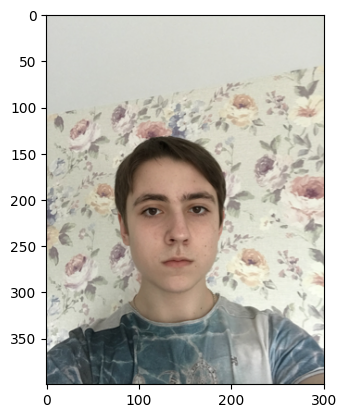

Target


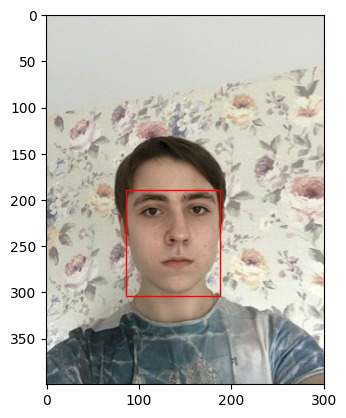

In [ ]:
print("Prediction")
plot_image(imgs[2], preds[2])
print("Target")
plot_image(imgs[2], annotations[2])

In [ ]:
torch.save(model.state_dict(),'model.pt')

In [ ]:
from google.colab import files
files.download('model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
torch.save(model, 'model_full.pth')

In [ ]:
from google.colab import files
files.download('model_full.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model2 = get_model_instance_segmentation(3)

### Save Model

In [ ]:
model2.load_state_dict(torch.load('model.pt'))
model2.eval()
model2.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### Load Model

In [ ]:
pred2 = model2(imgs)

Predict with loaded model


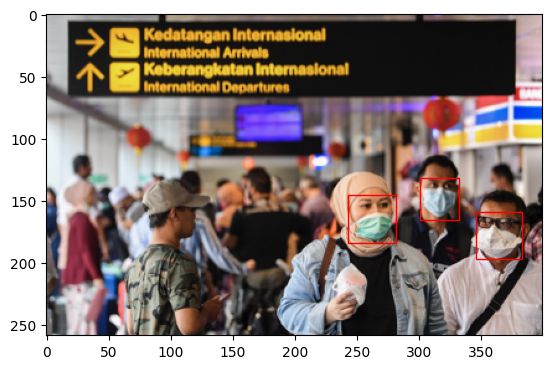

In [ ]:
print("Predict with loaded model")
plot_image(imgs[3], pred2[3])

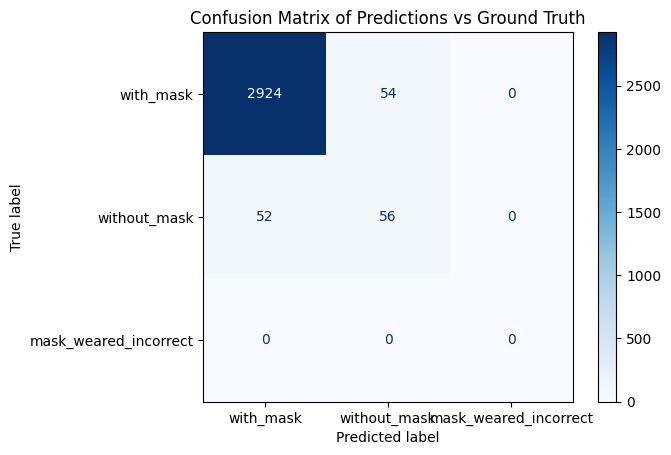

In [ ]:

import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ⚠️ Make sure your model is in eval mode
model.eval()

# ✅ Define class labels (adjust if you used 4 total classes)
CLASS_LABELS = ["background", "with_mask", "without_mask", "mask_weared_incorrect"]

# Store predictions and ground truths
all_preds = []
all_labels = []

score_threshold = 0.5  # You can raise this to 0.6 or 0.7 for stricter predictions

with torch.no_grad():
    for imgs, annotations in data_loader:
        imgs = [img.to(device) for img in imgs]
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

        outputs = model(imgs)

        for pred, ann in zip(outputs, annotations):
            # Filter predictions by confidence threshold
            pred_scores = pred['scores'].cpu().numpy()
            pred_labels = pred['labels'].cpu().numpy()
            filtered_labels = pred_labels[pred_scores > score_threshold]

            # Ground truth labels
            true_labels = ann['labels'].cpu().numpy()

            # Match lengths (optional: pad or cut for 1:1 alignment)
            min_len = min(len(filtered_labels), len(true_labels))
            all_preds.extend(filtered_labels[:min_len])
            all_labels.extend(true_labels[:min_len])

# ✅ Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=[1, 2, 3])  # skip background

# ✅ Plot confusion matrix with class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=CLASS_LABELS[1:])  # exclude 'background'
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix of Predictions vs Ground Truth")
plt.show()